# Model Experimentation

1. Random Forest Regressor
2. <b>XGBoost Regressor</b>
3. LightGBM Regressor

## Import Libraries

In [1]:
# dataframe packages
import pandas as pd
import numpy as np
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import joblib

# statistical packages
import math
from scipy.stats import uniform
from math import sqrt

# modeling packages
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# evaluation packages
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# scaling packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt
import shap

## Load Dataset

In [2]:
directory = 'C:/Users/chery/Documents/NUS Y4 Sem 2 Modules/BT4222/Dataset/Primary Dataset/modelling_dataset.csv'
model_df = pd.read_csv(directory)

In [3]:
model_df.head()

Area (SQM)  Unit Price ($ PSM)  Floor Number    PPI  \
0        95.0              6316.0           1.0  124.3   
1       138.0             13833.0           1.0  124.3   
2        99.0              8990.0          10.0  124.3   
3       111.0              6306.0           6.0  124.3   
4       122.0             13934.0          10.0  124.3   

   Average Cases Per Year  Nearest Primary School  nearest_station_distance  \
0                      33              705.752731               1207.822015   
1                      58             1233.947139                768.529003   
2                      50             1039.586179                816.818037   
3                      33              509.516515                501.364218   
4                      58             1253.733260                554.491114   

   Remaining Lease  Ang Mo Kio  Bedok  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
0             87.0           0      0  ...       0     0      0      0    0   
1             88.0           0      0  ...       0     0      0      0    0   
2             80.0           0      0  ...       0     0      0      1    0   
3             80.0           0      0  ...       1     0      0      0    0   
4             88.0           0      0  ...       0     0      0      0    0   

   PURPLE  RED  YELLOW  Apartment  Executive Condominium  
0       0    0       0          0                      0  
1       1    0       0          0                      0  
2       0    0       0          0                      0  
3       0    1       0          0                      0  
4       1    0       0          0                      0  

[5 rows x 53 columns]

## Train Test Split

1. Training set 0.6
2. Validation set 0.2
3. Test set - 0.2

The output variable will be <b>Unit Price ($ PSM)</b>

In [5]:
X = model_df.drop(["Unit Price ($ PSM)"], axis=1)
y = model_df['Unit Price ($ PSM)']

print('Shape of X is:', X.shape)
print('Shape of Y is:', y.shape)

Shape of X is: (54674, 52)
Shape of Y is: (54674,)


Instantiate TimeSeriesSplit

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print('Shape of X_train is:', X_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of X_test is:', X_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of X_train is: (38271, 52)
Shape of y_train is: (38271,)
Shape of X_test is: (16403, 52)
Shape of y_test is: (16403,)


## Scaling 

In [7]:
all_features = list(X_train.columns)

standardScale_vars = ['Area (SQM)',
                      'Floor Number',
                      'PPI',
                      'Average Cases Per Year',
                      'Nearest Primary School',
                      'nearest_station_distance']

minMax_vars = ['Remaining Lease']

remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

In [8]:
s_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

X_train = pd.concat([s_scaled, 
                     mm_scaled,
                     X_train.loc[:, remaining_features].copy()], axis=1)
X_train

Area (SQM)  Floor Number       PPI  Average Cases Per Year  \
11187    0.291530     -0.109176 -0.236229                0.243812   
18593   -1.125873      0.371998  0.210453                0.125051   
27013   -1.238366      5.785202 -0.452365                0.995966   
39116   -0.248433      0.973465  0.109589                0.243812   
6042    -0.113442      3.259040 -1.187229                0.006290   
...           ...           ...       ...                     ...   
44732   -0.203436     -0.830937  0.628316               -0.943799   
54343   -1.125873     -0.951230  1.795452                0.164638   
38158   -0.945886     -0.830937  0.109589                3.252428   
860     -0.563412      0.492291 -2.383183                2.896144   
15795   -0.518415      0.492291  0.109589                0.125051   

       Nearest Primary School  nearest_station_distance  Remaining Lease  \
11187               -0.771624                  1.226898         0.745098   
18593               -0.570640                  1.231468         0.725490   
27013                1.801408                 -1.015899         0.764706   
39116               -0.861865                 -0.889309         0.764706   
6042                -0.716828                 -0.836027         0.784314   
...                       ...                       ...              ...   
44732               -1.218061                 -0.237225         0.509804   
54343               -0.556898                  0.062359         0.784314   
38158                0.204740                 -0.494623         0.568627   
860                 -0.041901                 -0.749697         0.705882   
15795                0.706979                  1.325680         0.647059   

       Ang Mo Kio  Bedok  Bishan  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
11187           0      0       0  ...       0     0      0      0    0   
18593           0      1       0  ...       0     0      0      0    0   
27013           0      0       0  ...       0     1      0      1    0   
39116           0      0       0  ...       0     0      0      0    1   
6042            0      0       0  ...       0     0      0      1    0   
...           ...    ...     ...  ...     ...   ...    ...    ...  ...   
44732           1      0       0  ...       0     0      0      0    0   
54343           0      0       0  ...       0     0      1      0    0   
38158           0      0       0  ...       0     1      0      0    0   
860             0      0       0  ...       0     0      0      1    0   
15795           0      1       0  ...       0     0      0      0    0   

       PURPLE  RED  YELLOW  Apartment  Executive Condominium  
11187       0    0       0          0                      1  
18593       0    0       0          0                      0  
27013       0    1       1          1                      0  
39116       1    0       0          0                      0  
6042        0    0       0          0                      0  
...       ...  ...     ...        ...                    ...  
44732       0    1       0          0                      0  
54343       0    1       0          0                      0  
38158       1    0       0          0                      0  
860         0    0       1          0                      0  
15795       0    0       0          0                      0  

[38271 rows x 52 columns]

In [9]:
s_scaled_test = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
mm_scaled_test = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

X_test = pd.concat([s_scaled_test, 
                     mm_scaled_test,
                     X_test.loc[:, remaining_features].copy()], axis=1)
X_test

Area (SQM)  Floor Number       PPI  Average Cases Per Year  \
26109    0.134041      0.011118 -0.149775                0.243812   
51446   -0.765898     -0.830937  1.147043               -0.864625   
21609    0.224035     -0.349763  1.031770                2.896144   
6390    -0.045947     -0.951230 -1.187229               -0.033297   
40798    5.983642      3.018453  0.757998               -1.102147   
...           ...           ...       ...                     ...   
7350     1.056478      0.612585 -0.841411               -0.389580   
24268   -0.248433      0.011118  0.440998               -0.349993   
29622    0.089044     -0.470056 -0.855820                0.402161   
50030   -1.575843      0.492291  1.132634                0.243812   
35570   -0.653406     -0.710643 -0.754956               -0.864625   

       Nearest Primary School  nearest_station_distance  Remaining Lease  \
26109               -0.629690                 -0.453873         0.666667   
51446               -1.058519                 -0.912692         0.823529   
21609                2.509617                  0.157013         0.705882   
6390                 0.062520                 -0.976248         0.843137   
40798                0.138606                 -0.501497         0.862745   
...                       ...                       ...              ...   
7350                 0.018348                  0.334854         0.509804   
24268                0.014873                  1.248442         0.627451   
29622               -0.675015                  1.227770         0.647059   
50030               -0.740679                 -0.669763         0.882353   
35570               -0.548820                 -0.653270         0.843137   

       Ang Mo Kio  Bedok  Bishan  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
26109           0      0       0  ...       0     0      0      0    1   
51446           0      0       0  ...       0     1      0      1    0   
21609           0      0       0  ...       0     0      0      0    0   
6390            0      0       0  ...       0     0      0      0    1   
40798           0      0       0  ...       0     0      0      0    0   
...           ...    ...     ...  ...     ...   ...    ...    ...  ...   
7350            0      0       0  ...       0     0      0      1    0   
24268           0      0       0  ...       0     0      0      0    0   
29622           0      0       0  ...       0     0      0      0    0   
50030           0      0       0  ...       0     0      0      0    1   
35570           0      0       0  ...       0     1      0      1    0   

       PURPLE  RED  YELLOW  Apartment  Executive Condominium  
26109       1    0       0          0                      1  
51446       0    0       0          0                      0  
21609       0    0       1          0                      0  
6390        0    1       0          0                      0  
40798       0    0       1          0                      0  
...       ...  ...     ...        ...                    ...  
7350        0    0       0          0                      0  
24268       0    0       0          1                      0  
29622       0    0       0          0                      1  
50030       0    0       0          0                      0  
35570       0    0       0          0                      0  

[16403 rows x 52 columns]

## Model Tuning

Split training set into training and evaluation

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print('Shape of X_train is:', X_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of X_eval is:', X_eval.shape)
print('Shape of y_eval is:', y_eval.shape)

Shape of X_train is: (30616, 52)
Shape of y_train is: (30616,)
Shape of X_eval is: (7655, 52)
Shape of y_eval is: (7655,)


### XGBoost Regressor 

Select hyperparameters

In [18]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {'colsample_bytree':[i/10.0 for i in range(2, 8)], 
                  'gamma':[i for i in range(0, 10)], 
                  'max_depth':[i for i in range(3, 10)], 
                  'min_child_weight':[i for i in range(1, 10)], 
                  'reg_lambda':[i/10.0 for i in range(3, 6)], 
                  'reg_linear':[i/10.0 for i in range(4, 8)], 
                  'subsample':[i/10.0 for i in range(5, 9)]
}

# Instantiate the regressor: gbm
model = XGBRegressor(n_estimators=4675, learning_rate=0.07)

# Perform random search: grid_mse
clf = RandomizedSearchCV(model, gbm_param_grid, random_state=42)


# Fit randomized_mse to the data
search = clf.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], early_stopping_rounds=50)

# Print the best parameters and lowest RMSE
from pprint import pprint
pprint(search.best_estimator_.get_params())

[10:59:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11263.2
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10519.5
[2]	validation_0-rmse:9839.19
[3]	validation_0-rmse:9203.59
[4]	validation_0-rmse:8615.05
[5]	validation_0-rmse:8058.38
[6]	validation_0-rmse:7554.78
[7]	validation_0-rmse:7083.49
[8]	validation_0-rmse:6640.04
[9]	validation_0-rmse:6247.18
[10]	validation_0-rmse:5870.95
[11]	validation_0-rmse:5529.74
[12]	validation_0-rmse:5202.95
[13]	validation_0-rmse:4898.04
[14]	validation_0-rmse:4619.5
[15]	validation_0-rmse:4379.33
[16]	validation_0-rmse:4143.47
[17]	validation_0-rmse:3921.09
[18]	validation_0-rmse:3718.39
[19]	validation_0-rmse:3537.92
[20]	validation_0-rmse:3369.89
[21]	validation_0-rmse:3205.64
[22]	validation_0-rmse:3056.19
[23]	validation_0-rmse:2933.26
[24]	validation_0-rmse:2811.32
[25]	va

[254]	validation_0-rmse:1049.51
[255]	validation_0-rmse:1049.11
[256]	validation_0-rmse:1048.75
[257]	validation_0-rmse:1048.41
[258]	validation_0-rmse:1048.14
[259]	validation_0-rmse:1045.99
[260]	validation_0-rmse:1045.14
[261]	validation_0-rmse:1044.74
[262]	validation_0-rmse:1044.15
[263]	validation_0-rmse:1044.14
[264]	validation_0-rmse:1043.96
[265]	validation_0-rmse:1043.24
[266]	validation_0-rmse:1041.89
[267]	validation_0-rmse:1041.23
[268]	validation_0-rmse:1040.24
[269]	validation_0-rmse:1039.96
[270]	validation_0-rmse:1039.22
[271]	validation_0-rmse:1038.65
[272]	validation_0-rmse:1038.46
[273]	validation_0-rmse:1037.8
[274]	validation_0-rmse:1037.57
[275]	validation_0-rmse:1035.94
[276]	validation_0-rmse:1034.4
[277]	validation_0-rmse:1034.03
[278]	validation_0-rmse:1033.47
[279]	validation_0-rmse:1033.56
[280]	validation_0-rmse:1033.07
[281]	validation_0-rmse:1031.72
[282]	validation_0-rmse:1030.99
[283]	validation_0-rmse:1030.39
[284]	validation_0-rmse:1030.12
[285]	vali

[512]	validation_0-rmse:928.882
[513]	validation_0-rmse:928.095
[514]	validation_0-rmse:928.033
[515]	validation_0-rmse:927.801
[516]	validation_0-rmse:927.607
[517]	validation_0-rmse:927.585
[518]	validation_0-rmse:927.403
[519]	validation_0-rmse:926.83
[520]	validation_0-rmse:926.52
[521]	validation_0-rmse:926.427
[522]	validation_0-rmse:925.985
[523]	validation_0-rmse:925.927
[524]	validation_0-rmse:925.738
[525]	validation_0-rmse:925.725
[526]	validation_0-rmse:925.527
[527]	validation_0-rmse:925.433
[528]	validation_0-rmse:925.327
[529]	validation_0-rmse:924.701
[530]	validation_0-rmse:924.241
[531]	validation_0-rmse:923.747
[532]	validation_0-rmse:923.759
[533]	validation_0-rmse:922.952
[534]	validation_0-rmse:922.187
[535]	validation_0-rmse:921.994
[536]	validation_0-rmse:921.829
[537]	validation_0-rmse:921.666
[538]	validation_0-rmse:921.734
[539]	validation_0-rmse:921.42
[540]	validation_0-rmse:921.41
[541]	validation_0-rmse:921.516
[542]	validation_0-rmse:921.239
[543]	valida

[769]	validation_0-rmse:875.495
[770]	validation_0-rmse:875.094
[771]	validation_0-rmse:875.043
[772]	validation_0-rmse:874.972
[773]	validation_0-rmse:874.668
[774]	validation_0-rmse:874.483
[775]	validation_0-rmse:874.348
[776]	validation_0-rmse:874.339
[777]	validation_0-rmse:873.933
[778]	validation_0-rmse:873.751
[779]	validation_0-rmse:873.826
[780]	validation_0-rmse:873.487
[781]	validation_0-rmse:873.384
[782]	validation_0-rmse:873.389
[783]	validation_0-rmse:873.299
[784]	validation_0-rmse:873.14
[785]	validation_0-rmse:872.877
[786]	validation_0-rmse:872.563
[787]	validation_0-rmse:872.407
[788]	validation_0-rmse:872.377
[789]	validation_0-rmse:872.476
[790]	validation_0-rmse:872.396
[791]	validation_0-rmse:872.31
[792]	validation_0-rmse:872.166
[793]	validation_0-rmse:872.167
[794]	validation_0-rmse:871.954
[795]	validation_0-rmse:871.859
[796]	validation_0-rmse:871.704
[797]	validation_0-rmse:871.685
[798]	validation_0-rmse:871.366
[799]	validation_0-rmse:871.255
[800]	vali

[1026]	validation_0-rmse:845.852
[1027]	validation_0-rmse:845.79
[1028]	validation_0-rmse:845.594
[1029]	validation_0-rmse:845.388
[1030]	validation_0-rmse:845.486
[1031]	validation_0-rmse:845.422
[1032]	validation_0-rmse:845.355
[1033]	validation_0-rmse:845.455
[1034]	validation_0-rmse:845.352
[1035]	validation_0-rmse:845.18
[1036]	validation_0-rmse:845.094
[1037]	validation_0-rmse:845.048
[1038]	validation_0-rmse:844.733
[1039]	validation_0-rmse:844.793
[1040]	validation_0-rmse:844.471
[1041]	validation_0-rmse:844.459
[1042]	validation_0-rmse:844.376
[1043]	validation_0-rmse:844.361
[1044]	validation_0-rmse:844.172
[1045]	validation_0-rmse:844.099
[1046]	validation_0-rmse:844.089
[1047]	validation_0-rmse:844.132
[1048]	validation_0-rmse:843.763
[1049]	validation_0-rmse:843.728
[1050]	validation_0-rmse:843.784
[1051]	validation_0-rmse:843.707
[1052]	validation_0-rmse:843.603
[1053]	validation_0-rmse:843.463
[1054]	validation_0-rmse:843.248
[1055]	validation_0-rmse:843.289
[1056]	valid

[1275]	validation_0-rmse:828.522
[1276]	validation_0-rmse:828.397
[1277]	validation_0-rmse:828.281
[1278]	validation_0-rmse:828.477
[1279]	validation_0-rmse:828.415
[1280]	validation_0-rmse:828.318
[1281]	validation_0-rmse:828.263
[1282]	validation_0-rmse:828.05
[1283]	validation_0-rmse:827.998
[1284]	validation_0-rmse:827.934
[1285]	validation_0-rmse:828.018
[1286]	validation_0-rmse:828.044
[1287]	validation_0-rmse:828.028
[1288]	validation_0-rmse:828.037
[1289]	validation_0-rmse:827.945
[1290]	validation_0-rmse:827.617
[1291]	validation_0-rmse:827.616
[1292]	validation_0-rmse:827.526
[1293]	validation_0-rmse:827.614
[1294]	validation_0-rmse:827.536
[1295]	validation_0-rmse:827.503
[1296]	validation_0-rmse:827.447
[1297]	validation_0-rmse:827.545
[1298]	validation_0-rmse:827.521
[1299]	validation_0-rmse:827.549
[1300]	validation_0-rmse:827.51
[1301]	validation_0-rmse:827.173
[1302]	validation_0-rmse:827.045
[1303]	validation_0-rmse:826.971
[1304]	validation_0-rmse:826.821
[1305]	valid

[1524]	validation_0-rmse:818.123
[1525]	validation_0-rmse:818.173
[1526]	validation_0-rmse:818.118
[1527]	validation_0-rmse:818.182
[1528]	validation_0-rmse:818.245
[1529]	validation_0-rmse:818.125
[1530]	validation_0-rmse:818.057
[1531]	validation_0-rmse:817.977
[1532]	validation_0-rmse:817.839
[1533]	validation_0-rmse:817.552
[1534]	validation_0-rmse:817.527
[1535]	validation_0-rmse:817.521
[1536]	validation_0-rmse:817.545
[1537]	validation_0-rmse:817.492
[1538]	validation_0-rmse:817.507
[1539]	validation_0-rmse:817.539
[1540]	validation_0-rmse:817.519
[1541]	validation_0-rmse:817.495
[1542]	validation_0-rmse:817.333
[1543]	validation_0-rmse:817.229
[1544]	validation_0-rmse:817.28
[1545]	validation_0-rmse:817.247
[1546]	validation_0-rmse:817.24
[1547]	validation_0-rmse:817.222
[1548]	validation_0-rmse:817.222
[1549]	validation_0-rmse:817.231
[1550]	validation_0-rmse:817.258
[1551]	validation_0-rmse:817.005
[1552]	validation_0-rmse:816.934
[1553]	validation_0-rmse:816.923
[1554]	valid

[1774]	validation_0-rmse:811.224
[1775]	validation_0-rmse:811.223
[1776]	validation_0-rmse:811.243
[1777]	validation_0-rmse:811.203
[1778]	validation_0-rmse:811.174
[1779]	validation_0-rmse:811.172
[1780]	validation_0-rmse:811.243
[1781]	validation_0-rmse:811.105
[1782]	validation_0-rmse:810.965
[1783]	validation_0-rmse:810.938
[1784]	validation_0-rmse:810.915
[1785]	validation_0-rmse:810.872
[1786]	validation_0-rmse:810.823
[1787]	validation_0-rmse:810.672
[1788]	validation_0-rmse:810.662
[1789]	validation_0-rmse:810.638
[1790]	validation_0-rmse:810.567
[1791]	validation_0-rmse:810.605
[1792]	validation_0-rmse:810.515
[1793]	validation_0-rmse:810.375
[1794]	validation_0-rmse:810.166
[1795]	validation_0-rmse:810.135
[1796]	validation_0-rmse:810.033
[1797]	validation_0-rmse:810.158
[1798]	validation_0-rmse:810.273
[1799]	validation_0-rmse:810.285
[1800]	validation_0-rmse:810.161
[1801]	validation_0-rmse:810.15
[1802]	validation_0-rmse:810.023
[1803]	validation_0-rmse:810.033
[1804]	vali

[2024]	validation_0-rmse:805.601
[2025]	validation_0-rmse:805.554
[2026]	validation_0-rmse:805.57
[2027]	validation_0-rmse:805.537
[2028]	validation_0-rmse:805.56
[2029]	validation_0-rmse:805.565
[2030]	validation_0-rmse:805.449
[2031]	validation_0-rmse:805.493
[2032]	validation_0-rmse:805.38
[2033]	validation_0-rmse:805.404
[2034]	validation_0-rmse:805.378
[2035]	validation_0-rmse:805.326
[2036]	validation_0-rmse:805.371
[2037]	validation_0-rmse:805.313
[2038]	validation_0-rmse:805.328
[2039]	validation_0-rmse:805.274
[2040]	validation_0-rmse:805.276
[2041]	validation_0-rmse:805.175
[2042]	validation_0-rmse:805.324
[2043]	validation_0-rmse:805.225
[2044]	validation_0-rmse:805.106
[2045]	validation_0-rmse:805.204
[2046]	validation_0-rmse:805.109
[2047]	validation_0-rmse:805.122
[2048]	validation_0-rmse:805.072
[2049]	validation_0-rmse:805.002
[2050]	validation_0-rmse:805.052
[2051]	validation_0-rmse:804.936
[2052]	validation_0-rmse:804.934
[2053]	validation_0-rmse:804.952
[2054]	valida

[130]	validation_0-rmse:1212.32
[131]	validation_0-rmse:1209.87
[132]	validation_0-rmse:1208.64
[133]	validation_0-rmse:1206.16
[134]	validation_0-rmse:1204.63
[135]	validation_0-rmse:1202.14
[136]	validation_0-rmse:1199.18
[137]	validation_0-rmse:1196.84
[138]	validation_0-rmse:1194.48
[139]	validation_0-rmse:1193.36
[140]	validation_0-rmse:1192.45
[141]	validation_0-rmse:1191.46
[142]	validation_0-rmse:1189.57
[143]	validation_0-rmse:1188.41
[144]	validation_0-rmse:1185.74
[145]	validation_0-rmse:1184.57
[146]	validation_0-rmse:1181.21
[147]	validation_0-rmse:1180.48
[148]	validation_0-rmse:1179.55
[149]	validation_0-rmse:1177.32
[150]	validation_0-rmse:1176.68
[151]	validation_0-rmse:1174.54
[152]	validation_0-rmse:1173.35
[153]	validation_0-rmse:1170.43
[154]	validation_0-rmse:1169.19
[155]	validation_0-rmse:1167.86
[156]	validation_0-rmse:1167.23
[157]	validation_0-rmse:1166.6
[158]	validation_0-rmse:1164.84
[159]	validation_0-rmse:1163.93
[160]	validation_0-rmse:1162.1
[161]	vali

[387]	validation_0-rmse:993.943
[388]	validation_0-rmse:993.809
[389]	validation_0-rmse:994.047
[390]	validation_0-rmse:993.501
[391]	validation_0-rmse:993.48
[392]	validation_0-rmse:992.277
[393]	validation_0-rmse:991.982
[394]	validation_0-rmse:991.375
[395]	validation_0-rmse:991.176
[396]	validation_0-rmse:990.379
[397]	validation_0-rmse:989.842
[398]	validation_0-rmse:990.036
[399]	validation_0-rmse:989.133
[400]	validation_0-rmse:988.627
[401]	validation_0-rmse:987.485
[402]	validation_0-rmse:986.761
[403]	validation_0-rmse:986.127
[404]	validation_0-rmse:985.123
[405]	validation_0-rmse:984.604
[406]	validation_0-rmse:984.058
[407]	validation_0-rmse:983.621
[408]	validation_0-rmse:983.366
[409]	validation_0-rmse:983.381
[410]	validation_0-rmse:983.282
[411]	validation_0-rmse:982.701
[412]	validation_0-rmse:982.187
[413]	validation_0-rmse:981.226
[414]	validation_0-rmse:980.81
[415]	validation_0-rmse:981.002
[416]	validation_0-rmse:980.784
[417]	validation_0-rmse:980.721
[418]	vali

[644]	validation_0-rmse:911.343
[645]	validation_0-rmse:910.978
[646]	validation_0-rmse:910.918
[647]	validation_0-rmse:910.515
[648]	validation_0-rmse:910.475
[649]	validation_0-rmse:909.876
[650]	validation_0-rmse:909.694
[651]	validation_0-rmse:909.644
[652]	validation_0-rmse:909.5
[653]	validation_0-rmse:909.424
[654]	validation_0-rmse:909.128
[655]	validation_0-rmse:908.833
[656]	validation_0-rmse:908.444
[657]	validation_0-rmse:908.372
[658]	validation_0-rmse:907.899
[659]	validation_0-rmse:907.638
[660]	validation_0-rmse:907.259
[661]	validation_0-rmse:907.499
[662]	validation_0-rmse:907.405
[663]	validation_0-rmse:907.265
[664]	validation_0-rmse:907.03
[665]	validation_0-rmse:906.911
[666]	validation_0-rmse:906.721
[667]	validation_0-rmse:906.605
[668]	validation_0-rmse:906.479
[669]	validation_0-rmse:906.319
[670]	validation_0-rmse:906.149
[671]	validation_0-rmse:905.838
[672]	validation_0-rmse:905.816
[673]	validation_0-rmse:905.648
[674]	validation_0-rmse:905.434
[675]	valid

[902]	validation_0-rmse:874.195
[903]	validation_0-rmse:874.066
[904]	validation_0-rmse:873.937
[905]	validation_0-rmse:873.921
[906]	validation_0-rmse:873.779
[907]	validation_0-rmse:873.58
[908]	validation_0-rmse:873.466
[909]	validation_0-rmse:873.362
[910]	validation_0-rmse:873.506
[911]	validation_0-rmse:873.458
[912]	validation_0-rmse:873.383
[913]	validation_0-rmse:873.029
[914]	validation_0-rmse:872.872
[915]	validation_0-rmse:872.858
[916]	validation_0-rmse:872.696
[917]	validation_0-rmse:872.712
[918]	validation_0-rmse:872.763
[919]	validation_0-rmse:872.67
[920]	validation_0-rmse:872.549
[921]	validation_0-rmse:872.501
[922]	validation_0-rmse:872.312
[923]	validation_0-rmse:872.13
[924]	validation_0-rmse:872.126
[925]	validation_0-rmse:871.911
[926]	validation_0-rmse:871.775
[927]	validation_0-rmse:871.61
[928]	validation_0-rmse:871.459
[929]	validation_0-rmse:871.445
[930]	validation_0-rmse:871.397
[931]	validation_0-rmse:871.368
[932]	validation_0-rmse:871.398
[933]	valida

[1155]	validation_0-rmse:850.646
[1156]	validation_0-rmse:850.653
[1157]	validation_0-rmse:850.51
[1158]	validation_0-rmse:850.485
[1159]	validation_0-rmse:850.579
[1160]	validation_0-rmse:850.503
[1161]	validation_0-rmse:850.474
[1162]	validation_0-rmse:850.513
[1163]	validation_0-rmse:850.47
[1164]	validation_0-rmse:850.336
[1165]	validation_0-rmse:850.312
[1166]	validation_0-rmse:850.276
[1167]	validation_0-rmse:850.191
[1168]	validation_0-rmse:850.165
[1169]	validation_0-rmse:850.128
[1170]	validation_0-rmse:850.158
[1171]	validation_0-rmse:850.05
[1172]	validation_0-rmse:849.982
[1173]	validation_0-rmse:849.896
[1174]	validation_0-rmse:849.846
[1175]	validation_0-rmse:849.761
[1176]	validation_0-rmse:849.722
[1177]	validation_0-rmse:849.592
[1178]	validation_0-rmse:849.68
[1179]	validation_0-rmse:849.504
[1180]	validation_0-rmse:849.404
[1181]	validation_0-rmse:849.351
[1182]	validation_0-rmse:849.241
[1183]	validation_0-rmse:849.363
[1184]	validation_0-rmse:849.189
[1185]	validat

[1405]	validation_0-rmse:837.178
[1406]	validation_0-rmse:837.113
[1407]	validation_0-rmse:837.032
[1408]	validation_0-rmse:836.893
[1409]	validation_0-rmse:836.862
[1410]	validation_0-rmse:836.649
[1411]	validation_0-rmse:836.606
[1412]	validation_0-rmse:836.615
[1413]	validation_0-rmse:836.601
[1414]	validation_0-rmse:836.519
[1415]	validation_0-rmse:836.398
[1416]	validation_0-rmse:836.422
[1417]	validation_0-rmse:836.468
[1418]	validation_0-rmse:836.437
[1419]	validation_0-rmse:836.393
[1420]	validation_0-rmse:836.268
[1421]	validation_0-rmse:836.184
[1422]	validation_0-rmse:836.077
[1423]	validation_0-rmse:836.01
[1424]	validation_0-rmse:835.965
[1425]	validation_0-rmse:835.771
[1426]	validation_0-rmse:835.774
[1427]	validation_0-rmse:835.775
[1428]	validation_0-rmse:835.707
[1429]	validation_0-rmse:835.778
[1430]	validation_0-rmse:835.76
[1431]	validation_0-rmse:835.767
[1432]	validation_0-rmse:835.59
[1433]	validation_0-rmse:835.539
[1434]	validation_0-rmse:835.454
[1435]	valida

[1655]	validation_0-rmse:828.406
[1656]	validation_0-rmse:828.31
[1657]	validation_0-rmse:828.336
[1658]	validation_0-rmse:828.347
[1659]	validation_0-rmse:828.369
[1660]	validation_0-rmse:828.361
[1661]	validation_0-rmse:828.125
[1662]	validation_0-rmse:828.067
[1663]	validation_0-rmse:828.108
[1664]	validation_0-rmse:827.95
[1665]	validation_0-rmse:827.869
[1666]	validation_0-rmse:827.901
[1667]	validation_0-rmse:827.839
[1668]	validation_0-rmse:827.827
[1669]	validation_0-rmse:827.825
[1670]	validation_0-rmse:827.845
[1671]	validation_0-rmse:827.859
[1672]	validation_0-rmse:827.845
[1673]	validation_0-rmse:827.776
[1674]	validation_0-rmse:827.701
[1675]	validation_0-rmse:827.723
[1676]	validation_0-rmse:827.748
[1677]	validation_0-rmse:827.784
[1678]	validation_0-rmse:827.808
[1679]	validation_0-rmse:827.814
[1680]	validation_0-rmse:827.767
[1681]	validation_0-rmse:827.876
[1682]	validation_0-rmse:827.798
[1683]	validation_0-rmse:827.788
[1684]	validation_0-rmse:827.689
[1685]	valid

[1904]	validation_0-rmse:820.59
[1905]	validation_0-rmse:820.619
[1906]	validation_0-rmse:820.601
[1907]	validation_0-rmse:820.558
[1908]	validation_0-rmse:820.539
[1909]	validation_0-rmse:820.497
[1910]	validation_0-rmse:820.494
[1911]	validation_0-rmse:820.46
[1912]	validation_0-rmse:820.479
[1913]	validation_0-rmse:820.376
[1914]	validation_0-rmse:820.286
[1915]	validation_0-rmse:820.277
[1916]	validation_0-rmse:820.298
[1917]	validation_0-rmse:820.336
[1918]	validation_0-rmse:820.293
[1919]	validation_0-rmse:820.291
[1920]	validation_0-rmse:820.286
[1921]	validation_0-rmse:820.276
[1922]	validation_0-rmse:820.168
[1923]	validation_0-rmse:820.171
[1924]	validation_0-rmse:820.174
[1925]	validation_0-rmse:820.017
[1926]	validation_0-rmse:819.884
[1927]	validation_0-rmse:819.795
[1928]	validation_0-rmse:819.788
[1929]	validation_0-rmse:819.717
[1930]	validation_0-rmse:819.635
[1931]	validation_0-rmse:819.646
[1932]	validation_0-rmse:819.662
[1933]	validation_0-rmse:819.652
[1934]	valid

[2153]	validation_0-rmse:815.066
[2154]	validation_0-rmse:815.018
[2155]	validation_0-rmse:814.975
[2156]	validation_0-rmse:814.992
[2157]	validation_0-rmse:814.995
[2158]	validation_0-rmse:815.042
[2159]	validation_0-rmse:815.194
[2160]	validation_0-rmse:815.325
[2161]	validation_0-rmse:815.365
[2162]	validation_0-rmse:815.394
[2163]	validation_0-rmse:815.394
[2164]	validation_0-rmse:815.171
[2165]	validation_0-rmse:815.141
[2166]	validation_0-rmse:815.201
[2167]	validation_0-rmse:815.194
[2168]	validation_0-rmse:815.121
[2169]	validation_0-rmse:815.123
[2170]	validation_0-rmse:815.092
[2171]	validation_0-rmse:815.095
[2172]	validation_0-rmse:814.997
[2173]	validation_0-rmse:815.075
[2174]	validation_0-rmse:815.011
[2175]	validation_0-rmse:814.855
[2176]	validation_0-rmse:814.79
[2177]	validation_0-rmse:814.784
[2178]	validation_0-rmse:814.773
[2179]	validation_0-rmse:814.647
[2180]	validation_0-rmse:814.604
[2181]	validation_0-rmse:814.499
[2182]	validation_0-rmse:814.537
[2183]	vali

[2402]	validation_0-rmse:810.968
[2403]	validation_0-rmse:810.989
[2404]	validation_0-rmse:810.999
[2405]	validation_0-rmse:810.984
[2406]	validation_0-rmse:810.947
[2407]	validation_0-rmse:810.977
[2408]	validation_0-rmse:810.795
[2409]	validation_0-rmse:810.794
[2410]	validation_0-rmse:810.775
[2411]	validation_0-rmse:810.732
[2412]	validation_0-rmse:810.691
[2413]	validation_0-rmse:810.699
[2414]	validation_0-rmse:810.677
[2415]	validation_0-rmse:810.619
[2416]	validation_0-rmse:810.593
[2417]	validation_0-rmse:810.584
[2418]	validation_0-rmse:810.508
[2419]	validation_0-rmse:810.544
[2420]	validation_0-rmse:810.59
[2421]	validation_0-rmse:810.612
[2422]	validation_0-rmse:810.598
[2423]	validation_0-rmse:810.698
[2424]	validation_0-rmse:810.674
[2425]	validation_0-rmse:810.711
[2426]	validation_0-rmse:810.706
[2427]	validation_0-rmse:810.671
[2428]	validation_0-rmse:810.669
[2429]	validation_0-rmse:810.62
[2430]	validation_0-rmse:810.64
[2431]	validation_0-rmse:810.705
[2432]	valida

[2652]	validation_0-rmse:807.483
[2653]	validation_0-rmse:807.465
[2654]	validation_0-rmse:807.553
[2655]	validation_0-rmse:807.49
[2656]	validation_0-rmse:807.514
[2657]	validation_0-rmse:807.59
[2658]	validation_0-rmse:807.561
[2659]	validation_0-rmse:807.618
[2660]	validation_0-rmse:807.651
[2661]	validation_0-rmse:807.696
[2662]	validation_0-rmse:807.609
[2663]	validation_0-rmse:807.486
[2664]	validation_0-rmse:807.465
[2665]	validation_0-rmse:807.536
[2666]	validation_0-rmse:807.473
[2667]	validation_0-rmse:807.44
[2668]	validation_0-rmse:807.318
[2669]	validation_0-rmse:807.254
[2670]	validation_0-rmse:807.176
[2671]	validation_0-rmse:807.153
[2672]	validation_0-rmse:807.085
[2673]	validation_0-rmse:807.135
[2674]	validation_0-rmse:807.116
[2675]	validation_0-rmse:807.108
[2676]	validation_0-rmse:807.071
[2677]	validation_0-rmse:807.009
[2678]	validation_0-rmse:806.971
[2679]	validation_0-rmse:806.951
[2680]	validation_0-rmse:807.023
[2681]	validation_0-rmse:807.091
[2682]	valida

[2902]	validation_0-rmse:804.565
[2903]	validation_0-rmse:804.579
[2904]	validation_0-rmse:804.57
[2905]	validation_0-rmse:804.577
[2906]	validation_0-rmse:804.526
[2907]	validation_0-rmse:804.548
[2908]	validation_0-rmse:804.547
[2909]	validation_0-rmse:804.532
[2910]	validation_0-rmse:804.659
[2911]	validation_0-rmse:804.725
[2912]	validation_0-rmse:804.733
[2913]	validation_0-rmse:804.752
[2914]	validation_0-rmse:804.726
[2915]	validation_0-rmse:804.719
[2916]	validation_0-rmse:804.659
[2917]	validation_0-rmse:804.727
[2918]	validation_0-rmse:804.732
[2919]	validation_0-rmse:804.712
[2920]	validation_0-rmse:804.724
[2921]	validation_0-rmse:804.707
[2922]	validation_0-rmse:804.711
[2923]	validation_0-rmse:804.73
[2924]	validation_0-rmse:804.718
[2925]	validation_0-rmse:804.668
[2926]	validation_0-rmse:804.659
[2927]	validation_0-rmse:804.646
[2928]	validation_0-rmse:804.578
[2929]	validation_0-rmse:804.542
[2930]	validation_0-rmse:804.555
[2931]	validation_0-rmse:804.543
[2932]	valid

[3151]	validation_0-rmse:803.354
[3152]	validation_0-rmse:803.329
[3153]	validation_0-rmse:803.359
[3154]	validation_0-rmse:803.351
[3155]	validation_0-rmse:803.346
[3156]	validation_0-rmse:803.348
[3157]	validation_0-rmse:803.344
[3158]	validation_0-rmse:803.359
[3159]	validation_0-rmse:803.35
[3160]	validation_0-rmse:803.339
[3161]	validation_0-rmse:803.334
[3162]	validation_0-rmse:803.336
[3163]	validation_0-rmse:803.365
[3164]	validation_0-rmse:803.373
[3165]	validation_0-rmse:803.292
[3166]	validation_0-rmse:803.307
[3167]	validation_0-rmse:803.277
[3168]	validation_0-rmse:803.206
[3169]	validation_0-rmse:803.222
[3170]	validation_0-rmse:803.29
[3171]	validation_0-rmse:803.207
[3172]	validation_0-rmse:803.211
Stopping. Best iteration:
[3122]	validation_0-rmse:803.197

[11:06:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11255.4
Will train until valid

[229]	validation_0-rmse:1073.54
[230]	validation_0-rmse:1072.65
[231]	validation_0-rmse:1072.29
[232]	validation_0-rmse:1071.81
[233]	validation_0-rmse:1071.2
[234]	validation_0-rmse:1069.08
[235]	validation_0-rmse:1068.41
[236]	validation_0-rmse:1066.9
[237]	validation_0-rmse:1065.87
[238]	validation_0-rmse:1064.64
[239]	validation_0-rmse:1063.53
[240]	validation_0-rmse:1063.16
[241]	validation_0-rmse:1062.43
[242]	validation_0-rmse:1062.21
[243]	validation_0-rmse:1061.68
[244]	validation_0-rmse:1060.28
[245]	validation_0-rmse:1059.68
[246]	validation_0-rmse:1059.32
[247]	validation_0-rmse:1056.73
[248]	validation_0-rmse:1055.84
[249]	validation_0-rmse:1054.4
[250]	validation_0-rmse:1053.17
[251]	validation_0-rmse:1052.27
[252]	validation_0-rmse:1051.06
[253]	validation_0-rmse:1049.07
[254]	validation_0-rmse:1047.88
[255]	validation_0-rmse:1047.14
[256]	validation_0-rmse:1046.87
[257]	validation_0-rmse:1044.97
[258]	validation_0-rmse:1044.5
[259]	validation_0-rmse:1044.11
[260]	valida

[486]	validation_0-rmse:934.831
[487]	validation_0-rmse:934.431
[488]	validation_0-rmse:934.383
[489]	validation_0-rmse:934.254
[490]	validation_0-rmse:934.12
[491]	validation_0-rmse:933.692
[492]	validation_0-rmse:933.158
[493]	validation_0-rmse:932.421
[494]	validation_0-rmse:932.446
[495]	validation_0-rmse:932.302
[496]	validation_0-rmse:931.905
[497]	validation_0-rmse:931.982
[498]	validation_0-rmse:931.74
[499]	validation_0-rmse:931.432
[500]	validation_0-rmse:931.243
[501]	validation_0-rmse:930.81
[502]	validation_0-rmse:930.673
[503]	validation_0-rmse:930.445
[504]	validation_0-rmse:930.38
[505]	validation_0-rmse:929.92
[506]	validation_0-rmse:929.62
[507]	validation_0-rmse:929.27
[508]	validation_0-rmse:928.968
[509]	validation_0-rmse:928.413
[510]	validation_0-rmse:928.628
[511]	validation_0-rmse:927.86
[512]	validation_0-rmse:927.402
[513]	validation_0-rmse:927.135
[514]	validation_0-rmse:926.618
[515]	validation_0-rmse:926.564
[516]	validation_0-rmse:926.408
[517]	validation

[744]	validation_0-rmse:881.459
[745]	validation_0-rmse:881.281
[746]	validation_0-rmse:881.489
[747]	validation_0-rmse:881.261
[748]	validation_0-rmse:881.343
[749]	validation_0-rmse:881.243
[750]	validation_0-rmse:880.911
[751]	validation_0-rmse:880.503
[752]	validation_0-rmse:880.448
[753]	validation_0-rmse:880.38
[754]	validation_0-rmse:879.989
[755]	validation_0-rmse:879.763
[756]	validation_0-rmse:879.762
[757]	validation_0-rmse:879.556
[758]	validation_0-rmse:879.484
[759]	validation_0-rmse:879.497
[760]	validation_0-rmse:879.301
[761]	validation_0-rmse:879.106
[762]	validation_0-rmse:878.972
[763]	validation_0-rmse:878.924
[764]	validation_0-rmse:878.785
[765]	validation_0-rmse:878.39
[766]	validation_0-rmse:878.25
[767]	validation_0-rmse:877.895
[768]	validation_0-rmse:877.739
[769]	validation_0-rmse:877.187
[770]	validation_0-rmse:877.146
[771]	validation_0-rmse:877.046
[772]	validation_0-rmse:876.587
[773]	validation_0-rmse:876.137
[774]	validation_0-rmse:876.006
[775]	valid

[1001]	validation_0-rmse:852.455
[1002]	validation_0-rmse:852.333
[1003]	validation_0-rmse:852.289
[1004]	validation_0-rmse:852.301
[1005]	validation_0-rmse:852.252
[1006]	validation_0-rmse:852.064
[1007]	validation_0-rmse:851.959
[1008]	validation_0-rmse:851.837
[1009]	validation_0-rmse:851.737
[1010]	validation_0-rmse:851.758
[1011]	validation_0-rmse:851.653
[1012]	validation_0-rmse:851.542
[1013]	validation_0-rmse:851.528
[1014]	validation_0-rmse:851.364
[1015]	validation_0-rmse:851.117
[1016]	validation_0-rmse:851.031
[1017]	validation_0-rmse:850.88
[1018]	validation_0-rmse:850.833
[1019]	validation_0-rmse:850.952
[1020]	validation_0-rmse:850.841
[1021]	validation_0-rmse:850.744
[1022]	validation_0-rmse:850.647
[1023]	validation_0-rmse:850.579
[1024]	validation_0-rmse:850.488
[1025]	validation_0-rmse:850.324
[1026]	validation_0-rmse:850.137
[1027]	validation_0-rmse:850.137
[1028]	validation_0-rmse:849.924
[1029]	validation_0-rmse:849.77
[1030]	validation_0-rmse:849.439
[1031]	valid

[1251]	validation_0-rmse:833.62
[1252]	validation_0-rmse:833.627
[1253]	validation_0-rmse:833.548
[1254]	validation_0-rmse:833.623
[1255]	validation_0-rmse:833.678
[1256]	validation_0-rmse:833.408
[1257]	validation_0-rmse:833.358
[1258]	validation_0-rmse:833.384
[1259]	validation_0-rmse:833.089
[1260]	validation_0-rmse:833.052
[1261]	validation_0-rmse:833.043
[1262]	validation_0-rmse:832.897
[1263]	validation_0-rmse:833.029
[1264]	validation_0-rmse:833.039
[1265]	validation_0-rmse:833.032
[1266]	validation_0-rmse:833.053
[1267]	validation_0-rmse:832.964
[1268]	validation_0-rmse:832.746
[1269]	validation_0-rmse:832.794
[1270]	validation_0-rmse:832.742
[1271]	validation_0-rmse:832.484
[1272]	validation_0-rmse:832.543
[1273]	validation_0-rmse:832.505
[1274]	validation_0-rmse:832.388
[1275]	validation_0-rmse:832.119
[1276]	validation_0-rmse:832.025
[1277]	validation_0-rmse:831.938
[1278]	validation_0-rmse:831.913
[1279]	validation_0-rmse:831.848
[1280]	validation_0-rmse:831.996
[1281]	vali

[1501]	validation_0-rmse:820.598
[1502]	validation_0-rmse:820.635
[1503]	validation_0-rmse:820.644
[1504]	validation_0-rmse:820.686
[1505]	validation_0-rmse:820.571
[1506]	validation_0-rmse:820.574
[1507]	validation_0-rmse:820.594
[1508]	validation_0-rmse:820.578
[1509]	validation_0-rmse:820.642
[1510]	validation_0-rmse:820.532
[1511]	validation_0-rmse:820.477
[1512]	validation_0-rmse:820.416
[1513]	validation_0-rmse:820.402
[1514]	validation_0-rmse:820.286
[1515]	validation_0-rmse:820.249
[1516]	validation_0-rmse:820.143
[1517]	validation_0-rmse:820.18
[1518]	validation_0-rmse:820.187
[1519]	validation_0-rmse:820.17
[1520]	validation_0-rmse:820.138
[1521]	validation_0-rmse:820.024
[1522]	validation_0-rmse:819.998
[1523]	validation_0-rmse:820.023
[1524]	validation_0-rmse:819.992
[1525]	validation_0-rmse:819.956
[1526]	validation_0-rmse:819.963
[1527]	validation_0-rmse:819.809
[1528]	validation_0-rmse:819.81
[1529]	validation_0-rmse:819.739
[1530]	validation_0-rmse:819.74
[1531]	validat

[1750]	validation_0-rmse:811.428
[1751]	validation_0-rmse:811.535
[1752]	validation_0-rmse:811.475
[1753]	validation_0-rmse:811.458
[1754]	validation_0-rmse:811.203
[1755]	validation_0-rmse:811.208
[1756]	validation_0-rmse:811.134
[1757]	validation_0-rmse:811.114
[1758]	validation_0-rmse:811.104
[1759]	validation_0-rmse:811.066
[1760]	validation_0-rmse:811.137
[1761]	validation_0-rmse:811.136
[1762]	validation_0-rmse:811.087
[1763]	validation_0-rmse:810.983
[1764]	validation_0-rmse:810.887
[1765]	validation_0-rmse:810.873
[1766]	validation_0-rmse:810.925
[1767]	validation_0-rmse:811.013
[1768]	validation_0-rmse:810.957
[1769]	validation_0-rmse:810.998
[1770]	validation_0-rmse:810.957
[1771]	validation_0-rmse:810.898
[1772]	validation_0-rmse:810.966
[1773]	validation_0-rmse:811.09
[1774]	validation_0-rmse:811.094
[1775]	validation_0-rmse:810.968
[1776]	validation_0-rmse:811.072
[1777]	validation_0-rmse:811.076
[1778]	validation_0-rmse:811.039
[1779]	validation_0-rmse:810.927
[1780]	vali

[2000]	validation_0-rmse:805.041
[2001]	validation_0-rmse:805.028
[2002]	validation_0-rmse:804.983
[2003]	validation_0-rmse:805.021
[2004]	validation_0-rmse:804.97
[2005]	validation_0-rmse:804.947
[2006]	validation_0-rmse:804.998
[2007]	validation_0-rmse:804.951
[2008]	validation_0-rmse:804.896
[2009]	validation_0-rmse:804.854
[2010]	validation_0-rmse:804.838
[2011]	validation_0-rmse:804.834
[2012]	validation_0-rmse:804.768
[2013]	validation_0-rmse:804.785
[2014]	validation_0-rmse:804.638
[2015]	validation_0-rmse:804.674
[2016]	validation_0-rmse:804.682
[2017]	validation_0-rmse:804.766
[2018]	validation_0-rmse:804.738
[2019]	validation_0-rmse:804.739
[2020]	validation_0-rmse:804.64
[2021]	validation_0-rmse:804.732
[2022]	validation_0-rmse:804.609
[2023]	validation_0-rmse:804.528
[2024]	validation_0-rmse:804.422
[2025]	validation_0-rmse:804.341
[2026]	validation_0-rmse:804.295
[2027]	validation_0-rmse:804.177
[2028]	validation_0-rmse:804.114
[2029]	validation_0-rmse:804.083
[2030]	valid

[2249]	validation_0-rmse:800.411
[2250]	validation_0-rmse:800.366
[2251]	validation_0-rmse:800.377
[2252]	validation_0-rmse:800.352
[2253]	validation_0-rmse:800.354
[2254]	validation_0-rmse:800.347
[2255]	validation_0-rmse:800.336
[2256]	validation_0-rmse:800.248
[2257]	validation_0-rmse:800.305
[2258]	validation_0-rmse:800.331
[2259]	validation_0-rmse:800.154
[2260]	validation_0-rmse:800.108
[2261]	validation_0-rmse:800.11
[2262]	validation_0-rmse:800.087
[2263]	validation_0-rmse:800.107
[2264]	validation_0-rmse:800.072
[2265]	validation_0-rmse:800.045
[2266]	validation_0-rmse:800.007
[2267]	validation_0-rmse:800.068
[2268]	validation_0-rmse:800.11
[2269]	validation_0-rmse:800.072
[2270]	validation_0-rmse:800.145
[2271]	validation_0-rmse:800.182
[2272]	validation_0-rmse:800.172
[2273]	validation_0-rmse:800.189
[2274]	validation_0-rmse:800.144
[2275]	validation_0-rmse:800.13
[2276]	validation_0-rmse:800.113
[2277]	validation_0-rmse:800
[2278]	validation_0-rmse:799.932
[2279]	validation

[144]	validation_0-rmse:1175.16
[145]	validation_0-rmse:1173.79
[146]	validation_0-rmse:1172.09
[147]	validation_0-rmse:1169.48
[148]	validation_0-rmse:1168.52
[149]	validation_0-rmse:1166.18
[150]	validation_0-rmse:1165.19
[151]	validation_0-rmse:1163.64
[152]	validation_0-rmse:1162.43
[153]	validation_0-rmse:1159.08
[154]	validation_0-rmse:1157.25
[155]	validation_0-rmse:1156.05
[156]	validation_0-rmse:1155.29
[157]	validation_0-rmse:1154.52
[158]	validation_0-rmse:1153.15
[159]	validation_0-rmse:1152.43
[160]	validation_0-rmse:1151.58
[161]	validation_0-rmse:1150.81
[162]	validation_0-rmse:1148.71
[163]	validation_0-rmse:1147.24
[164]	validation_0-rmse:1145.83
[165]	validation_0-rmse:1145.19
[166]	validation_0-rmse:1144.35
[167]	validation_0-rmse:1141.92
[168]	validation_0-rmse:1141.2
[169]	validation_0-rmse:1140.27
[170]	validation_0-rmse:1139.35
[171]	validation_0-rmse:1139.05
[172]	validation_0-rmse:1136.91
[173]	validation_0-rmse:1136.12
[174]	validation_0-rmse:1134.66
[175]	val

[401]	validation_0-rmse:972.049
[402]	validation_0-rmse:971.276
[403]	validation_0-rmse:971.224
[404]	validation_0-rmse:970.539
[405]	validation_0-rmse:970.484
[406]	validation_0-rmse:969.91
[407]	validation_0-rmse:969.763
[408]	validation_0-rmse:969.272
[409]	validation_0-rmse:968.515
[410]	validation_0-rmse:967.951
[411]	validation_0-rmse:967.858
[412]	validation_0-rmse:967.63
[413]	validation_0-rmse:966.865
[414]	validation_0-rmse:966.622
[415]	validation_0-rmse:966.096
[416]	validation_0-rmse:965.737
[417]	validation_0-rmse:965.389
[418]	validation_0-rmse:965.354
[419]	validation_0-rmse:965.228
[420]	validation_0-rmse:964.383
[421]	validation_0-rmse:964.14
[422]	validation_0-rmse:963.739
[423]	validation_0-rmse:962.91
[424]	validation_0-rmse:962.105
[425]	validation_0-rmse:962.228
[426]	validation_0-rmse:962.174
[427]	validation_0-rmse:961.601
[428]	validation_0-rmse:961.245
[429]	validation_0-rmse:961.083
[430]	validation_0-rmse:960.812
[431]	validation_0-rmse:960.465
[432]	valida

[658]	validation_0-rmse:900.563
[659]	validation_0-rmse:900.391
[660]	validation_0-rmse:900.382
[661]	validation_0-rmse:900.042
[662]	validation_0-rmse:899.94
[663]	validation_0-rmse:899.819
[664]	validation_0-rmse:899.692
[665]	validation_0-rmse:899.698
[666]	validation_0-rmse:899.496
[667]	validation_0-rmse:899.659
[668]	validation_0-rmse:899.513
[669]	validation_0-rmse:899.162
[670]	validation_0-rmse:899.061
[671]	validation_0-rmse:898.89
[672]	validation_0-rmse:898.79
[673]	validation_0-rmse:898.769
[674]	validation_0-rmse:898.51
[675]	validation_0-rmse:898.217
[676]	validation_0-rmse:898.048
[677]	validation_0-rmse:897.904
[678]	validation_0-rmse:897.536
[679]	validation_0-rmse:897.298
[680]	validation_0-rmse:897.125
[681]	validation_0-rmse:896.737
[682]	validation_0-rmse:896.768
[683]	validation_0-rmse:896.397
[684]	validation_0-rmse:896.175
[685]	validation_0-rmse:896.21
[686]	validation_0-rmse:895.863
[687]	validation_0-rmse:895.67
[688]	validation_0-rmse:895.501
[689]	validati

[916]	validation_0-rmse:864.504
[917]	validation_0-rmse:864.398
[918]	validation_0-rmse:864.323
[919]	validation_0-rmse:864.102
[920]	validation_0-rmse:864.055
[921]	validation_0-rmse:864.033
[922]	validation_0-rmse:863.842
[923]	validation_0-rmse:863.73
[924]	validation_0-rmse:863.686
[925]	validation_0-rmse:863.397
[926]	validation_0-rmse:863.298
[927]	validation_0-rmse:863.359
[928]	validation_0-rmse:863.29
[929]	validation_0-rmse:863.166
[930]	validation_0-rmse:862.93
[931]	validation_0-rmse:862.886
[932]	validation_0-rmse:862.801
[933]	validation_0-rmse:862.662
[934]	validation_0-rmse:862.333
[935]	validation_0-rmse:862.215
[936]	validation_0-rmse:862.283
[937]	validation_0-rmse:862.146
[938]	validation_0-rmse:862.099
[939]	validation_0-rmse:861.947
[940]	validation_0-rmse:861.908
[941]	validation_0-rmse:861.68
[942]	validation_0-rmse:861.54
[943]	validation_0-rmse:861.516
[944]	validation_0-rmse:861.347
[945]	validation_0-rmse:861.461
[946]	validation_0-rmse:861.403
[947]	validat

[1168]	validation_0-rmse:845.945
[1169]	validation_0-rmse:846.039
[1170]	validation_0-rmse:845.914
[1171]	validation_0-rmse:846.003
[1172]	validation_0-rmse:845.954
[1173]	validation_0-rmse:845.993
[1174]	validation_0-rmse:845.898
[1175]	validation_0-rmse:845.718
[1176]	validation_0-rmse:845.77
[1177]	validation_0-rmse:845.728
[1178]	validation_0-rmse:845.741
[1179]	validation_0-rmse:845.553
[1180]	validation_0-rmse:845.409
[1181]	validation_0-rmse:845.371
[1182]	validation_0-rmse:845.317
[1183]	validation_0-rmse:845.396
[1184]	validation_0-rmse:845.106
[1185]	validation_0-rmse:845.159
[1186]	validation_0-rmse:845.042
[1187]	validation_0-rmse:844.944
[1188]	validation_0-rmse:844.807
[1189]	validation_0-rmse:845.091
[1190]	validation_0-rmse:845.114
[1191]	validation_0-rmse:845.146
[1192]	validation_0-rmse:845.044
[1193]	validation_0-rmse:844.955
[1194]	validation_0-rmse:844.78
[1195]	validation_0-rmse:844.714
[1196]	validation_0-rmse:844.761
[1197]	validation_0-rmse:844.642
[1198]	valid

[1418]	validation_0-rmse:832.033
[1419]	validation_0-rmse:831.962
[1420]	validation_0-rmse:831.893
[1421]	validation_0-rmse:831.844
[1422]	validation_0-rmse:831.916
[1423]	validation_0-rmse:831.875
[1424]	validation_0-rmse:831.848
[1425]	validation_0-rmse:831.79
[1426]	validation_0-rmse:831.766
[1427]	validation_0-rmse:831.806
[1428]	validation_0-rmse:831.784
[1429]	validation_0-rmse:831.729
[1430]	validation_0-rmse:831.716
[1431]	validation_0-rmse:831.813
[1432]	validation_0-rmse:831.841
[1433]	validation_0-rmse:831.862
[1434]	validation_0-rmse:831.887
[1435]	validation_0-rmse:831.74
[1436]	validation_0-rmse:831.767
[1437]	validation_0-rmse:831.701
[1438]	validation_0-rmse:831.635
[1439]	validation_0-rmse:831.241
[1440]	validation_0-rmse:831.305
[1441]	validation_0-rmse:831.267
[1442]	validation_0-rmse:831.124
[1443]	validation_0-rmse:831.109
[1444]	validation_0-rmse:831.205
[1445]	validation_0-rmse:831.25
[1446]	validation_0-rmse:831.306
[1447]	validation_0-rmse:830.979
[1448]	valida

[1668]	validation_0-rmse:821.331
[1669]	validation_0-rmse:821.227
[1670]	validation_0-rmse:821.145
[1671]	validation_0-rmse:821.201
[1672]	validation_0-rmse:821.283
[1673]	validation_0-rmse:821.246
[1674]	validation_0-rmse:821.233
[1675]	validation_0-rmse:821.249
[1676]	validation_0-rmse:821.245
[1677]	validation_0-rmse:821.267
[1678]	validation_0-rmse:821.181
[1679]	validation_0-rmse:820.908
[1680]	validation_0-rmse:820.902
[1681]	validation_0-rmse:820.862
[1682]	validation_0-rmse:820.874
[1683]	validation_0-rmse:820.862
[1684]	validation_0-rmse:820.807
[1685]	validation_0-rmse:820.804
[1686]	validation_0-rmse:820.853
[1687]	validation_0-rmse:820.82
[1688]	validation_0-rmse:820.702
[1689]	validation_0-rmse:820.638
[1690]	validation_0-rmse:820.722
[1691]	validation_0-rmse:820.698
[1692]	validation_0-rmse:820.624
[1693]	validation_0-rmse:820.653
[1694]	validation_0-rmse:820.526
[1695]	validation_0-rmse:820.552
[1696]	validation_0-rmse:820.597
[1697]	validation_0-rmse:820.507
[1698]	vali

[1918]	validation_0-rmse:814.478
[1919]	validation_0-rmse:814.542
[1920]	validation_0-rmse:814.48
[1921]	validation_0-rmse:814.489
[1922]	validation_0-rmse:814.406
[1923]	validation_0-rmse:814.441
[1924]	validation_0-rmse:814.483
[1925]	validation_0-rmse:814.459
[1926]	validation_0-rmse:814.416
[1927]	validation_0-rmse:814.459
[1928]	validation_0-rmse:814.496
[1929]	validation_0-rmse:814.458
[1930]	validation_0-rmse:814.475
[1931]	validation_0-rmse:814.412
[1932]	validation_0-rmse:814.372
[1933]	validation_0-rmse:814.162
[1934]	validation_0-rmse:814.22
[1935]	validation_0-rmse:814.041
[1936]	validation_0-rmse:814.02
[1937]	validation_0-rmse:813.974
[1938]	validation_0-rmse:813.913
[1939]	validation_0-rmse:813.838
[1940]	validation_0-rmse:813.84
[1941]	validation_0-rmse:813.86
[1942]	validation_0-rmse:813.84
[1943]	validation_0-rmse:813.78
[1944]	validation_0-rmse:813.858
[1945]	validation_0-rmse:814.034
[1946]	validation_0-rmse:814.056
[1947]	validation_0-rmse:814.072
[1948]	validation

[63]	validation_0-rmse:1462.45
[64]	validation_0-rmse:1455.58
[65]	validation_0-rmse:1447.78
[66]	validation_0-rmse:1441.21
[67]	validation_0-rmse:1435.52
[68]	validation_0-rmse:1429.06
[69]	validation_0-rmse:1421.66
[70]	validation_0-rmse:1417.91
[71]	validation_0-rmse:1409.86
[72]	validation_0-rmse:1405.48
[73]	validation_0-rmse:1399.32
[74]	validation_0-rmse:1393.05
[75]	validation_0-rmse:1387.8
[76]	validation_0-rmse:1383.02
[77]	validation_0-rmse:1378.22
[78]	validation_0-rmse:1372.46
[79]	validation_0-rmse:1365.15
[80]	validation_0-rmse:1358.54
[81]	validation_0-rmse:1355.89
[82]	validation_0-rmse:1352.12
[83]	validation_0-rmse:1347.53
[84]	validation_0-rmse:1343.13
[85]	validation_0-rmse:1339.31
[86]	validation_0-rmse:1334.4
[87]	validation_0-rmse:1329.98
[88]	validation_0-rmse:1326.41
[89]	validation_0-rmse:1322.32
[90]	validation_0-rmse:1319.42
[91]	validation_0-rmse:1314.59
[92]	validation_0-rmse:1311.73
[93]	validation_0-rmse:1309.48
[94]	validation_0-rmse:1305.35
[95]	valid

[321]	validation_0-rmse:1019.79
[322]	validation_0-rmse:1019.4
[323]	validation_0-rmse:1018.95
[324]	validation_0-rmse:1018.29
[325]	validation_0-rmse:1017.09
[326]	validation_0-rmse:1017.2
[327]	validation_0-rmse:1016.62
[328]	validation_0-rmse:1016.32
[329]	validation_0-rmse:1015.8
[330]	validation_0-rmse:1015.41
[331]	validation_0-rmse:1014.73
[332]	validation_0-rmse:1013.33
[333]	validation_0-rmse:1013.02
[334]	validation_0-rmse:1012.38
[335]	validation_0-rmse:1011.88
[336]	validation_0-rmse:1011.4
[337]	validation_0-rmse:1010.85
[338]	validation_0-rmse:1010.35
[339]	validation_0-rmse:1010.04
[340]	validation_0-rmse:1009.91
[341]	validation_0-rmse:1009.84
[342]	validation_0-rmse:1009.05
[343]	validation_0-rmse:1008.07
[344]	validation_0-rmse:1007.73
[345]	validation_0-rmse:1007.71
[346]	validation_0-rmse:1006.59
[347]	validation_0-rmse:1006.24
[348]	validation_0-rmse:1006.07
[349]	validation_0-rmse:1004.62
[350]	validation_0-rmse:1003.47
[351]	validation_0-rmse:1002.85
[352]	valida

[579]	validation_0-rmse:922.66
[580]	validation_0-rmse:922.789
[581]	validation_0-rmse:922.055
[582]	validation_0-rmse:921.921
[583]	validation_0-rmse:921.708
[584]	validation_0-rmse:920.967
[585]	validation_0-rmse:920.407
[586]	validation_0-rmse:920.591
[587]	validation_0-rmse:920.348
[588]	validation_0-rmse:920.251
[589]	validation_0-rmse:920.161
[590]	validation_0-rmse:920.027
[591]	validation_0-rmse:919.927
[592]	validation_0-rmse:919.828
[593]	validation_0-rmse:919.667
[594]	validation_0-rmse:918.855
[595]	validation_0-rmse:918.825
[596]	validation_0-rmse:918.27
[597]	validation_0-rmse:918.277
[598]	validation_0-rmse:918.093
[599]	validation_0-rmse:917.955
[600]	validation_0-rmse:917.879
[601]	validation_0-rmse:917.737
[602]	validation_0-rmse:917.502
[603]	validation_0-rmse:917.177
[604]	validation_0-rmse:916.972
[605]	validation_0-rmse:916.624
[606]	validation_0-rmse:916.376
[607]	validation_0-rmse:916.259
[608]	validation_0-rmse:916.125
[609]	validation_0-rmse:915.565
[610]	vali

[837]	validation_0-rmse:875.858
[838]	validation_0-rmse:875.978
[839]	validation_0-rmse:875.843
[840]	validation_0-rmse:875.725
[841]	validation_0-rmse:875.629
[842]	validation_0-rmse:875.374
[843]	validation_0-rmse:875.233
[844]	validation_0-rmse:875.163
[845]	validation_0-rmse:875.149
[846]	validation_0-rmse:875.079
[847]	validation_0-rmse:874.787
[848]	validation_0-rmse:874.696
[849]	validation_0-rmse:874.501
[850]	validation_0-rmse:874.359
[851]	validation_0-rmse:874.067
[852]	validation_0-rmse:874.031
[853]	validation_0-rmse:873.94
[854]	validation_0-rmse:873.738
[855]	validation_0-rmse:873.603
[856]	validation_0-rmse:873.372
[857]	validation_0-rmse:873.393
[858]	validation_0-rmse:873.27
[859]	validation_0-rmse:873.315
[860]	validation_0-rmse:873.253
[861]	validation_0-rmse:873.008
[862]	validation_0-rmse:872.863
[863]	validation_0-rmse:872.719
[864]	validation_0-rmse:872.677
[865]	validation_0-rmse:872.681
[866]	validation_0-rmse:872.548
[867]	validation_0-rmse:872.524
[868]	vali

[1092]	validation_0-rmse:849.953
[1093]	validation_0-rmse:849.944
[1094]	validation_0-rmse:849.974
[1095]	validation_0-rmse:849.848
[1096]	validation_0-rmse:849.898
[1097]	validation_0-rmse:849.824
[1098]	validation_0-rmse:849.818
[1099]	validation_0-rmse:849.705
[1100]	validation_0-rmse:849.39
[1101]	validation_0-rmse:849.422
[1102]	validation_0-rmse:849.304
[1103]	validation_0-rmse:849.43
[1104]	validation_0-rmse:849.435
[1105]	validation_0-rmse:849.552
[1106]	validation_0-rmse:849.513
[1107]	validation_0-rmse:849.484
[1108]	validation_0-rmse:849.441
[1109]	validation_0-rmse:849.288
[1110]	validation_0-rmse:849.29
[1111]	validation_0-rmse:849.209
[1112]	validation_0-rmse:849.021
[1113]	validation_0-rmse:848.856
[1114]	validation_0-rmse:848.694
[1115]	validation_0-rmse:848.627
[1116]	validation_0-rmse:848.451
[1117]	validation_0-rmse:848.455
[1118]	validation_0-rmse:848.329
[1119]	validation_0-rmse:848.345
[1120]	validation_0-rmse:848.21
[1121]	validation_0-rmse:848.167
[1122]	validat

[1342]	validation_0-rmse:833.622
[1343]	validation_0-rmse:833.588
[1344]	validation_0-rmse:833.626
[1345]	validation_0-rmse:833.733
[1346]	validation_0-rmse:833.647
[1347]	validation_0-rmse:833.574
[1348]	validation_0-rmse:833.457
[1349]	validation_0-rmse:833.532
[1350]	validation_0-rmse:833.492
[1351]	validation_0-rmse:833.341
[1352]	validation_0-rmse:833.297
[1353]	validation_0-rmse:833.235
[1354]	validation_0-rmse:833.106
[1355]	validation_0-rmse:833.26
[1356]	validation_0-rmse:833.055
[1357]	validation_0-rmse:833.002
[1358]	validation_0-rmse:832.929
[1359]	validation_0-rmse:832.785
[1360]	validation_0-rmse:832.777
[1361]	validation_0-rmse:832.71
[1362]	validation_0-rmse:832.601
[1363]	validation_0-rmse:832.569
[1364]	validation_0-rmse:832.624
[1365]	validation_0-rmse:832.536
[1366]	validation_0-rmse:832.507
[1367]	validation_0-rmse:832.436
[1368]	validation_0-rmse:832.381
[1369]	validation_0-rmse:832.423
[1370]	validation_0-rmse:832.363
[1371]	validation_0-rmse:832.152
[1372]	valid

[1591]	validation_0-rmse:822.126
[1592]	validation_0-rmse:822.065
[1593]	validation_0-rmse:822.016
[1594]	validation_0-rmse:822.079
[1595]	validation_0-rmse:822.062
[1596]	validation_0-rmse:821.991
[1597]	validation_0-rmse:821.946
[1598]	validation_0-rmse:822.006
[1599]	validation_0-rmse:822.02
[1600]	validation_0-rmse:822.005
[1601]	validation_0-rmse:821.942
[1602]	validation_0-rmse:821.835
[1603]	validation_0-rmse:821.834
[1604]	validation_0-rmse:821.864
[1605]	validation_0-rmse:821.835
[1606]	validation_0-rmse:821.93
[1607]	validation_0-rmse:821.924
[1608]	validation_0-rmse:821.866
[1609]	validation_0-rmse:821.93
[1610]	validation_0-rmse:821.954
[1611]	validation_0-rmse:821.792
[1612]	validation_0-rmse:821.695
[1613]	validation_0-rmse:821.675
[1614]	validation_0-rmse:821.605
[1615]	validation_0-rmse:821.452
[1616]	validation_0-rmse:821.468
[1617]	validation_0-rmse:821.482
[1618]	validation_0-rmse:821.469
[1619]	validation_0-rmse:821.418
[1620]	validation_0-rmse:821.301
[1621]	valida

[1841]	validation_0-rmse:814.234
[1842]	validation_0-rmse:814.153
[1843]	validation_0-rmse:814.184
[1844]	validation_0-rmse:814.153
[1845]	validation_0-rmse:814.165
[1846]	validation_0-rmse:814.066
[1847]	validation_0-rmse:813.968
[1848]	validation_0-rmse:813.936
[1849]	validation_0-rmse:813.919
[1850]	validation_0-rmse:813.928
[1851]	validation_0-rmse:813.859
[1852]	validation_0-rmse:813.82
[1853]	validation_0-rmse:813.774
[1854]	validation_0-rmse:813.757
[1855]	validation_0-rmse:813.815
[1856]	validation_0-rmse:813.749
[1857]	validation_0-rmse:813.733
[1858]	validation_0-rmse:813.791
[1859]	validation_0-rmse:813.754
[1860]	validation_0-rmse:813.849
[1861]	validation_0-rmse:813.93
[1862]	validation_0-rmse:813.888
[1863]	validation_0-rmse:813.913
[1864]	validation_0-rmse:813.904
[1865]	validation_0-rmse:813.915
[1866]	validation_0-rmse:813.892
[1867]	validation_0-rmse:813.882
[1868]	validation_0-rmse:813.891
[1869]	validation_0-rmse:813.928
[1870]	validation_0-rmse:813.936
[1871]	valid

[2090]	validation_0-rmse:809.257
[2091]	validation_0-rmse:809.293
[2092]	validation_0-rmse:809.334
[2093]	validation_0-rmse:809.342
[2094]	validation_0-rmse:809.377
[2095]	validation_0-rmse:809.482
[2096]	validation_0-rmse:809.552
[2097]	validation_0-rmse:809.526
[2098]	validation_0-rmse:809.469
[2099]	validation_0-rmse:809.47
[2100]	validation_0-rmse:809.477
[2101]	validation_0-rmse:809.536
[2102]	validation_0-rmse:809.543
[2103]	validation_0-rmse:809.512
[2104]	validation_0-rmse:809.507
[2105]	validation_0-rmse:809.55
[2106]	validation_0-rmse:809.619
[2107]	validation_0-rmse:809.671
[2108]	validation_0-rmse:809.645
[2109]	validation_0-rmse:809.68
[2110]	validation_0-rmse:809.606
[2111]	validation_0-rmse:809.511
[2112]	validation_0-rmse:809.506
[2113]	validation_0-rmse:809.445
[2114]	validation_0-rmse:809.445
[2115]	validation_0-rmse:809.37
[2116]	validation_0-rmse:809.338
[2117]	validation_0-rmse:809.288
[2118]	validation_0-rmse:809.141
[2119]	validation_0-rmse:809.176
[2120]	validat

[2340]	validation_0-rmse:805.875
[2341]	validation_0-rmse:805.702
[2342]	validation_0-rmse:805.673
[2343]	validation_0-rmse:805.679
[2344]	validation_0-rmse:805.585
[2345]	validation_0-rmse:805.569
[2346]	validation_0-rmse:805.571
[2347]	validation_0-rmse:805.484
[2348]	validation_0-rmse:805.382
[2349]	validation_0-rmse:805.34
[2350]	validation_0-rmse:805.329
[2351]	validation_0-rmse:805.333
[2352]	validation_0-rmse:805.27
[2353]	validation_0-rmse:805.325
[2354]	validation_0-rmse:805.304
[2355]	validation_0-rmse:805.201
[2356]	validation_0-rmse:805.159
[2357]	validation_0-rmse:805.096
[2358]	validation_0-rmse:805.125
[2359]	validation_0-rmse:805.15
[2360]	validation_0-rmse:805.11
[2361]	validation_0-rmse:805.046
[2362]	validation_0-rmse:805.072
[2363]	validation_0-rmse:805.126
[2364]	validation_0-rmse:805.146
[2365]	validation_0-rmse:805.196
[2366]	validation_0-rmse:805.17
[2367]	validation_0-rmse:805.187
[2368]	validation_0-rmse:805.223
[2369]	validation_0-rmse:805.208
[2370]	validati

[2590]	validation_0-rmse:802.804
[2591]	validation_0-rmse:802.795
[2592]	validation_0-rmse:802.777
[2593]	validation_0-rmse:802.727
[2594]	validation_0-rmse:802.768
[2595]	validation_0-rmse:802.847
[2596]	validation_0-rmse:802.853
[2597]	validation_0-rmse:802.867
[2598]	validation_0-rmse:802.888
[2599]	validation_0-rmse:802.8
[2600]	validation_0-rmse:802.757
[2601]	validation_0-rmse:802.669
[2602]	validation_0-rmse:802.771
[2603]	validation_0-rmse:802.664
[2604]	validation_0-rmse:802.648
[2605]	validation_0-rmse:802.586
[2606]	validation_0-rmse:802.541
[2607]	validation_0-rmse:802.474
[2608]	validation_0-rmse:802.408
[2609]	validation_0-rmse:802.476
[2610]	validation_0-rmse:802.455
[2611]	validation_0-rmse:802.422
[2612]	validation_0-rmse:802.403
[2613]	validation_0-rmse:802.413
[2614]	validation_0-rmse:802.424
[2615]	validation_0-rmse:802.434
[2616]	validation_0-rmse:802.343
[2617]	validation_0-rmse:802.361
[2618]	validation_0-rmse:802.339
[2619]	validation_0-rmse:802.319
[2620]	valid

[2839]	validation_0-rmse:799.526
[2840]	validation_0-rmse:799.468
[2841]	validation_0-rmse:799.453
[2842]	validation_0-rmse:799.448
[2843]	validation_0-rmse:799.429
[2844]	validation_0-rmse:799.452
[2845]	validation_0-rmse:799.445
[2846]	validation_0-rmse:799.311
[2847]	validation_0-rmse:799.283
[2848]	validation_0-rmse:799.382
[2849]	validation_0-rmse:799.355
[2850]	validation_0-rmse:799.519
[2851]	validation_0-rmse:799.517
[2852]	validation_0-rmse:799.507
[2853]	validation_0-rmse:799.452
[2854]	validation_0-rmse:799.511
[2855]	validation_0-rmse:799.5
[2856]	validation_0-rmse:799.461
[2857]	validation_0-rmse:799.346
[2858]	validation_0-rmse:799.333
[2859]	validation_0-rmse:799.325
[2860]	validation_0-rmse:799.337
[2861]	validation_0-rmse:799.319
[2862]	validation_0-rmse:799.335
[2863]	validation_0-rmse:799.368
[2864]	validation_0-rmse:799.393
[2865]	validation_0-rmse:799.385
[2866]	validation_0-rmse:799.358
[2867]	validation_0-rmse:799.351
[2868]	validation_0-rmse:799.288
[2869]	valid

[3089]	validation_0-rmse:798.414
[3090]	validation_0-rmse:798.395
[3091]	validation_0-rmse:798.463
Stopping. Best iteration:
[3041]	validation_0-rmse:798.14

[11:16:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11257.4
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10506.4
[2]	validation_0-rmse:9823.32
[3]	validation_0-rmse:9179.18
[4]	validation_0-rmse:8583.97
[5]	validation_0-rmse:8024.49
[6]	validation_0-rmse:7515.7
[7]	validation_0-rmse:7039.7
[8]	validation_0-rmse:6590.83
[9]	validation_0-rmse:6186.54
[10]	validation_0-rmse:5807.78
[11]	validation_0-rmse:5458.63
[12]	validation_0-rmse:5126.41
[13]	validation_0-rmse:4816.94
[14]	validation_0-rmse:4536.64
[15]	validation_0-rmse:4291.47
[16]	validation_0-rmse:4052.1
[17]	validation_0-rmse:3825.24
[18]	validation_0-rmse:3619.39
[19]	validation_0-rmse:3432.58
[20]	v

[249]	validation_0-rmse:975.237
[250]	validation_0-rmse:974.839
[251]	validation_0-rmse:973.934
[252]	validation_0-rmse:973.573
[253]	validation_0-rmse:973.175
[254]	validation_0-rmse:972.766
[255]	validation_0-rmse:972.586
[256]	validation_0-rmse:971.159
[257]	validation_0-rmse:970.62
[258]	validation_0-rmse:970.536
[259]	validation_0-rmse:969.122
[260]	validation_0-rmse:968.935
[261]	validation_0-rmse:968.18
[262]	validation_0-rmse:967.685
[263]	validation_0-rmse:967.036
[264]	validation_0-rmse:966.585
[265]	validation_0-rmse:965.819
[266]	validation_0-rmse:965.676
[267]	validation_0-rmse:964.708
[268]	validation_0-rmse:964.414
[269]	validation_0-rmse:963.325
[270]	validation_0-rmse:962.727
[271]	validation_0-rmse:961.957
[272]	validation_0-rmse:961.885
[273]	validation_0-rmse:961.088
[274]	validation_0-rmse:958.623
[275]	validation_0-rmse:958.57
[276]	validation_0-rmse:958.478
[277]	validation_0-rmse:957.808
[278]	validation_0-rmse:956.999
[279]	validation_0-rmse:956.03
[280]	valida

[506]	validation_0-rmse:876.84
[507]	validation_0-rmse:876.863
[508]	validation_0-rmse:876.815
[509]	validation_0-rmse:876.818
[510]	validation_0-rmse:876.58
[511]	validation_0-rmse:876.415
[512]	validation_0-rmse:876.239
[513]	validation_0-rmse:876.169
[514]	validation_0-rmse:876.198
[515]	validation_0-rmse:876.22
[516]	validation_0-rmse:876.058
[517]	validation_0-rmse:876.015
[518]	validation_0-rmse:875.54
[519]	validation_0-rmse:875.182
[520]	validation_0-rmse:874.809
[521]	validation_0-rmse:874.783
[522]	validation_0-rmse:874.621
[523]	validation_0-rmse:874.541
[524]	validation_0-rmse:874.656
[525]	validation_0-rmse:874.508
[526]	validation_0-rmse:874.554
[527]	validation_0-rmse:874.207
[528]	validation_0-rmse:874.127
[529]	validation_0-rmse:873.646
[530]	validation_0-rmse:873.514
[531]	validation_0-rmse:873.241
[532]	validation_0-rmse:873.105
[533]	validation_0-rmse:872.669
[534]	validation_0-rmse:872.325
[535]	validation_0-rmse:872.38
[536]	validation_0-rmse:872.201
[537]	validat

[763]	validation_0-rmse:840.892
[764]	validation_0-rmse:840.459
[765]	validation_0-rmse:840.338
[766]	validation_0-rmse:840.305
[767]	validation_0-rmse:840.209
[768]	validation_0-rmse:840.053
[769]	validation_0-rmse:839.719
[770]	validation_0-rmse:839.723
[771]	validation_0-rmse:839.561
[772]	validation_0-rmse:839.36
[773]	validation_0-rmse:839.215
[774]	validation_0-rmse:839.093
[775]	validation_0-rmse:839.11
[776]	validation_0-rmse:839.017
[777]	validation_0-rmse:838.911
[778]	validation_0-rmse:838.835
[779]	validation_0-rmse:838.755
[780]	validation_0-rmse:838.634
[781]	validation_0-rmse:838.566
[782]	validation_0-rmse:838.612
[783]	validation_0-rmse:838.408
[784]	validation_0-rmse:838.353
[785]	validation_0-rmse:837.915
[786]	validation_0-rmse:837.756
[787]	validation_0-rmse:837.4
[788]	validation_0-rmse:837.317
[789]	validation_0-rmse:837.321
[790]	validation_0-rmse:837.172
[791]	validation_0-rmse:836.982
[792]	validation_0-rmse:836.732
[793]	validation_0-rmse:836.666
[794]	valida

[1020]	validation_0-rmse:818.568
[1021]	validation_0-rmse:818.523
[1022]	validation_0-rmse:818.656
[1023]	validation_0-rmse:818.558
[1024]	validation_0-rmse:818.411
[1025]	validation_0-rmse:818.452
[1026]	validation_0-rmse:818.467
[1027]	validation_0-rmse:818.372
[1028]	validation_0-rmse:818.264
[1029]	validation_0-rmse:818.24
[1030]	validation_0-rmse:818.306
[1031]	validation_0-rmse:818.222
[1032]	validation_0-rmse:818.208
[1033]	validation_0-rmse:818.114
[1034]	validation_0-rmse:818.006
[1035]	validation_0-rmse:817.922
[1036]	validation_0-rmse:818.005
[1037]	validation_0-rmse:817.984
[1038]	validation_0-rmse:817.957
[1039]	validation_0-rmse:817.982
[1040]	validation_0-rmse:817.898
[1041]	validation_0-rmse:817.649
[1042]	validation_0-rmse:817.664
[1043]	validation_0-rmse:817.503
[1044]	validation_0-rmse:817.523
[1045]	validation_0-rmse:817.356
[1046]	validation_0-rmse:817.456
[1047]	validation_0-rmse:817.534
[1048]	validation_0-rmse:817.449
[1049]	validation_0-rmse:817.24
[1050]	valid

[1269]	validation_0-rmse:807.328
[1270]	validation_0-rmse:807.27
[1271]	validation_0-rmse:807.305
[1272]	validation_0-rmse:807.296
[1273]	validation_0-rmse:807.229
[1274]	validation_0-rmse:807.241
[1275]	validation_0-rmse:807.337
[1276]	validation_0-rmse:807.292
[1277]	validation_0-rmse:807.281
[1278]	validation_0-rmse:807.185
[1279]	validation_0-rmse:807.286
[1280]	validation_0-rmse:807.244
[1281]	validation_0-rmse:807.101
[1282]	validation_0-rmse:806.981
[1283]	validation_0-rmse:807.037
[1284]	validation_0-rmse:806.973
[1285]	validation_0-rmse:806.858
[1286]	validation_0-rmse:806.866
[1287]	validation_0-rmse:806.777
[1288]	validation_0-rmse:806.727
[1289]	validation_0-rmse:806.793
[1290]	validation_0-rmse:806.879
[1291]	validation_0-rmse:806.925
[1292]	validation_0-rmse:806.991
[1293]	validation_0-rmse:806.944
[1294]	validation_0-rmse:806.973
[1295]	validation_0-rmse:807.029
[1296]	validation_0-rmse:806.973
[1297]	validation_0-rmse:806.909
[1298]	validation_0-rmse:806.855
[1299]	vali

[1519]	validation_0-rmse:800.111
[1520]	validation_0-rmse:800.096
[1521]	validation_0-rmse:800.051
[1522]	validation_0-rmse:800.014
[1523]	validation_0-rmse:800.102
[1524]	validation_0-rmse:800.052
[1525]	validation_0-rmse:800.045
[1526]	validation_0-rmse:800.027
[1527]	validation_0-rmse:799.968
[1528]	validation_0-rmse:800.026
[1529]	validation_0-rmse:800.14
[1530]	validation_0-rmse:800.133
[1531]	validation_0-rmse:800.11
[1532]	validation_0-rmse:800.137
[1533]	validation_0-rmse:800.133
[1534]	validation_0-rmse:800.142
[1535]	validation_0-rmse:800.212
[1536]	validation_0-rmse:800.19
[1537]	validation_0-rmse:800.247
[1538]	validation_0-rmse:800.254
[1539]	validation_0-rmse:800.179
[1540]	validation_0-rmse:800.059
Stopping. Best iteration:
[1490]	validation_0-rmse:799.874

[11:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11248.6
Will train until valida

[229]	validation_0-rmse:1004.79
[230]	validation_0-rmse:1004.36
[231]	validation_0-rmse:1003.7
[232]	validation_0-rmse:1003.24
[233]	validation_0-rmse:1002.94
[234]	validation_0-rmse:1002.65
[235]	validation_0-rmse:1002.36
[236]	validation_0-rmse:1001.06
[237]	validation_0-rmse:1000.51
[238]	validation_0-rmse:1000.03
[239]	validation_0-rmse:1000.03
[240]	validation_0-rmse:999.767
[241]	validation_0-rmse:998.772
[242]	validation_0-rmse:997.974
[243]	validation_0-rmse:997.315
[244]	validation_0-rmse:997.019
[245]	validation_0-rmse:996.007
[246]	validation_0-rmse:995.591
[247]	validation_0-rmse:995.098
[248]	validation_0-rmse:994.676
[249]	validation_0-rmse:993.752
[250]	validation_0-rmse:993.488
[251]	validation_0-rmse:993.442
[252]	validation_0-rmse:993.138
[253]	validation_0-rmse:992.817
[254]	validation_0-rmse:991.6
[255]	validation_0-rmse:990.555
[256]	validation_0-rmse:989.427
[257]	validation_0-rmse:989.138
[258]	validation_0-rmse:988.552
[259]	validation_0-rmse:987.32
[260]	valida

[487]	validation_0-rmse:905.496
[488]	validation_0-rmse:905.415
[489]	validation_0-rmse:905.279
[490]	validation_0-rmse:905.202
[491]	validation_0-rmse:904.803
[492]	validation_0-rmse:903.9
[493]	validation_0-rmse:903.51
[494]	validation_0-rmse:903.165
[495]	validation_0-rmse:902.808
[496]	validation_0-rmse:902.646
[497]	validation_0-rmse:902.158
[498]	validation_0-rmse:901.624
[499]	validation_0-rmse:901.403
[500]	validation_0-rmse:901.304
[501]	validation_0-rmse:900.742
[502]	validation_0-rmse:900.645
[503]	validation_0-rmse:900.184
[504]	validation_0-rmse:899.907
[505]	validation_0-rmse:899.88
[506]	validation_0-rmse:899.676
[507]	validation_0-rmse:899.346
[508]	validation_0-rmse:899.198
[509]	validation_0-rmse:898.96
[510]	validation_0-rmse:898.812
[511]	validation_0-rmse:898.471
[512]	validation_0-rmse:898.579
[513]	validation_0-rmse:898.592
[514]	validation_0-rmse:897.969
[515]	validation_0-rmse:897.928
[516]	validation_0-rmse:897.758
[517]	validation_0-rmse:897.205
[518]	validat

[745]	validation_0-rmse:861.981
[746]	validation_0-rmse:861.865
[747]	validation_0-rmse:861.543
[748]	validation_0-rmse:861.532
[749]	validation_0-rmse:861.2
[750]	validation_0-rmse:861.025
[751]	validation_0-rmse:860.491
[752]	validation_0-rmse:860.503
[753]	validation_0-rmse:860.402
[754]	validation_0-rmse:859.515
[755]	validation_0-rmse:859.297
[756]	validation_0-rmse:858.974
[757]	validation_0-rmse:858.968
[758]	validation_0-rmse:858.63
[759]	validation_0-rmse:858.459
[760]	validation_0-rmse:858.467
[761]	validation_0-rmse:858.22
[762]	validation_0-rmse:858.182
[763]	validation_0-rmse:858.036
[764]	validation_0-rmse:857.543
[765]	validation_0-rmse:857.009
[766]	validation_0-rmse:856.924
[767]	validation_0-rmse:856.852
[768]	validation_0-rmse:856.643
[769]	validation_0-rmse:856.554
[770]	validation_0-rmse:856.51
[771]	validation_0-rmse:856.476
[772]	validation_0-rmse:856.394
[773]	validation_0-rmse:856.263
[774]	validation_0-rmse:856.158
[775]	validation_0-rmse:856.097
[776]	validat

[1002]	validation_0-rmse:836.156
[1003]	validation_0-rmse:836.108
[1004]	validation_0-rmse:836.067
[1005]	validation_0-rmse:836
[1006]	validation_0-rmse:835.891
[1007]	validation_0-rmse:835.864
[1008]	validation_0-rmse:835.853
[1009]	validation_0-rmse:835.844
[1010]	validation_0-rmse:835.783
[1011]	validation_0-rmse:835.747
[1012]	validation_0-rmse:835.697
[1013]	validation_0-rmse:835.57
[1014]	validation_0-rmse:835.528
[1015]	validation_0-rmse:835.542
[1016]	validation_0-rmse:835.618
[1017]	validation_0-rmse:835.666
[1018]	validation_0-rmse:835.51
[1019]	validation_0-rmse:835.408
[1020]	validation_0-rmse:835.518
[1021]	validation_0-rmse:835.336
[1022]	validation_0-rmse:835.358
[1023]	validation_0-rmse:835.436
[1024]	validation_0-rmse:835.644
[1025]	validation_0-rmse:835.593
[1026]	validation_0-rmse:835.614
[1027]	validation_0-rmse:835.606
[1028]	validation_0-rmse:835.465
[1029]	validation_0-rmse:835.45
[1030]	validation_0-rmse:835.311
[1031]	validation_0-rmse:835.326
[1032]	validation

[1252]	validation_0-rmse:822.779
[1253]	validation_0-rmse:822.733
[1254]	validation_0-rmse:822.596
[1255]	validation_0-rmse:822.637
[1256]	validation_0-rmse:822.588
[1257]	validation_0-rmse:822.601
[1258]	validation_0-rmse:822.69
[1259]	validation_0-rmse:822.554
[1260]	validation_0-rmse:822.494
[1261]	validation_0-rmse:822.35
[1262]	validation_0-rmse:822.113
[1263]	validation_0-rmse:822.175
[1264]	validation_0-rmse:822.174
[1265]	validation_0-rmse:822.292
[1266]	validation_0-rmse:822.27
[1267]	validation_0-rmse:822.126
[1268]	validation_0-rmse:822.147
[1269]	validation_0-rmse:822.219
[1270]	validation_0-rmse:822.258
[1271]	validation_0-rmse:822.316
[1272]	validation_0-rmse:822.183
[1273]	validation_0-rmse:822.235
[1274]	validation_0-rmse:822.121
[1275]	validation_0-rmse:822.085
[1276]	validation_0-rmse:822.062
[1277]	validation_0-rmse:821.959
[1278]	validation_0-rmse:821.837
[1279]	validation_0-rmse:821.683
[1280]	validation_0-rmse:821.29
[1281]	validation_0-rmse:821.227
[1282]	validat

[1502]	validation_0-rmse:812.808
[1503]	validation_0-rmse:812.773
[1504]	validation_0-rmse:812.743
[1505]	validation_0-rmse:812.793
[1506]	validation_0-rmse:812.754
[1507]	validation_0-rmse:812.849
[1508]	validation_0-rmse:812.764
[1509]	validation_0-rmse:812.772
[1510]	validation_0-rmse:812.588
[1511]	validation_0-rmse:812.592
[1512]	validation_0-rmse:812.522
[1513]	validation_0-rmse:812.527
[1514]	validation_0-rmse:812.455
[1515]	validation_0-rmse:812.42
[1516]	validation_0-rmse:812.256
[1517]	validation_0-rmse:812.276
[1518]	validation_0-rmse:812.287
[1519]	validation_0-rmse:812.276
[1520]	validation_0-rmse:812.242
[1521]	validation_0-rmse:812.111
[1522]	validation_0-rmse:812.087
[1523]	validation_0-rmse:812.003
[1524]	validation_0-rmse:811.93
[1525]	validation_0-rmse:811.82
[1526]	validation_0-rmse:811.87
[1527]	validation_0-rmse:811.885
[1528]	validation_0-rmse:811.886
[1529]	validation_0-rmse:811.931
[1530]	validation_0-rmse:811.916
[1531]	validation_0-rmse:811.863
[1532]	validat

[1752]	validation_0-rmse:806.512
[1753]	validation_0-rmse:806.562
[1754]	validation_0-rmse:806.509
[1755]	validation_0-rmse:806.438
[1756]	validation_0-rmse:806.56
[1757]	validation_0-rmse:806.503
[1758]	validation_0-rmse:806.394
[1759]	validation_0-rmse:806.247
[1760]	validation_0-rmse:806.216
[1761]	validation_0-rmse:806.176
[1762]	validation_0-rmse:806.205
[1763]	validation_0-rmse:806.204
[1764]	validation_0-rmse:806.203
[1765]	validation_0-rmse:806.215
[1766]	validation_0-rmse:806.218
[1767]	validation_0-rmse:806.087
[1768]	validation_0-rmse:806.136
[1769]	validation_0-rmse:806.094
[1770]	validation_0-rmse:806.116
[1771]	validation_0-rmse:806.157
[1772]	validation_0-rmse:806.28
[1773]	validation_0-rmse:806.271
[1774]	validation_0-rmse:806.302
[1775]	validation_0-rmse:806.134
[1776]	validation_0-rmse:806.013
[1777]	validation_0-rmse:806.013
[1778]	validation_0-rmse:805.928
[1779]	validation_0-rmse:805.995
[1780]	validation_0-rmse:805.953
[1781]	validation_0-rmse:805.917
[1782]	valid

[2002]	validation_0-rmse:801.836
[2003]	validation_0-rmse:801.755
[2004]	validation_0-rmse:801.641
[2005]	validation_0-rmse:801.56
[2006]	validation_0-rmse:801.62
[2007]	validation_0-rmse:801.605
[2008]	validation_0-rmse:801.615
[2009]	validation_0-rmse:801.637
[2010]	validation_0-rmse:801.635
[2011]	validation_0-rmse:801.629
[2012]	validation_0-rmse:801.547
[2013]	validation_0-rmse:801.559
[2014]	validation_0-rmse:801.617
[2015]	validation_0-rmse:801.611
[2016]	validation_0-rmse:801.672
[2017]	validation_0-rmse:801.597
[2018]	validation_0-rmse:801.572
[2019]	validation_0-rmse:801.549
[2020]	validation_0-rmse:801.606
[2021]	validation_0-rmse:801.525
[2022]	validation_0-rmse:801.444
[2023]	validation_0-rmse:801.347
[2024]	validation_0-rmse:801.313
[2025]	validation_0-rmse:801.314
[2026]	validation_0-rmse:801.322
[2027]	validation_0-rmse:801.291
[2028]	validation_0-rmse:801.309
[2029]	validation_0-rmse:801.277
[2030]	validation_0-rmse:801.258
[2031]	validation_0-rmse:801.234
[2032]	valid

[2252]	validation_0-rmse:798.551
[2253]	validation_0-rmse:798.562
[2254]	validation_0-rmse:798.524
[2255]	validation_0-rmse:798.48
[2256]	validation_0-rmse:798.494
[2257]	validation_0-rmse:798.453
[2258]	validation_0-rmse:798.516
[2259]	validation_0-rmse:798.534
[2260]	validation_0-rmse:798.55
[2261]	validation_0-rmse:798.592
[2262]	validation_0-rmse:798.507
[2263]	validation_0-rmse:798.548
[2264]	validation_0-rmse:798.503
[2265]	validation_0-rmse:798.492
[2266]	validation_0-rmse:798.478
[2267]	validation_0-rmse:798.507
[2268]	validation_0-rmse:798.463
[2269]	validation_0-rmse:798.442
[2270]	validation_0-rmse:798.433
[2271]	validation_0-rmse:798.457
[2272]	validation_0-rmse:798.424
[2273]	validation_0-rmse:798.444
[2274]	validation_0-rmse:798.502
[2275]	validation_0-rmse:798.485
[2276]	validation_0-rmse:798.495
[2277]	validation_0-rmse:798.519
[2278]	validation_0-rmse:798.546
[2279]	validation_0-rmse:798.515
[2280]	validation_0-rmse:798.45
[2281]	validation_0-rmse:798.409
[2282]	valida

[2502]	validation_0-rmse:796.341
[2503]	validation_0-rmse:796.32
[2504]	validation_0-rmse:796.228
[2505]	validation_0-rmse:796.26
[2506]	validation_0-rmse:796.234
[2507]	validation_0-rmse:796.256
[2508]	validation_0-rmse:796.321
[2509]	validation_0-rmse:796.326
[2510]	validation_0-rmse:796.275
[2511]	validation_0-rmse:796.227
[2512]	validation_0-rmse:796.267
[2513]	validation_0-rmse:796.321
[2514]	validation_0-rmse:796.302
[2515]	validation_0-rmse:796.382
[2516]	validation_0-rmse:796.298
[2517]	validation_0-rmse:796.323
[2518]	validation_0-rmse:796.318
[2519]	validation_0-rmse:796.325
[2520]	validation_0-rmse:796.341
[2521]	validation_0-rmse:796.308
[2522]	validation_0-rmse:796.307
[2523]	validation_0-rmse:796.273
[2524]	validation_0-rmse:796.283
[2525]	validation_0-rmse:796.285
[2526]	validation_0-rmse:796.294
[2527]	validation_0-rmse:796.307
[2528]	validation_0-rmse:796.306
[2529]	validation_0-rmse:796.293
[2530]	validation_0-rmse:796.341
[2531]	validation_0-rmse:796.419
[2532]	valid

[218]	validation_0-rmse:1005.37
[219]	validation_0-rmse:1004.37
[220]	validation_0-rmse:1004.02
[221]	validation_0-rmse:1003.64
[222]	validation_0-rmse:1003.2
[223]	validation_0-rmse:1002.6
[224]	validation_0-rmse:1001.96
[225]	validation_0-rmse:1001.86
[226]	validation_0-rmse:1001.04
[227]	validation_0-rmse:1001.05
[228]	validation_0-rmse:1000.16
[229]	validation_0-rmse:999.987
[230]	validation_0-rmse:999.181
[231]	validation_0-rmse:998.688
[232]	validation_0-rmse:998.662
[233]	validation_0-rmse:997.916
[234]	validation_0-rmse:997.48
[235]	validation_0-rmse:996.925
[236]	validation_0-rmse:995.92
[237]	validation_0-rmse:995.194
[238]	validation_0-rmse:994.933
[239]	validation_0-rmse:993.652
[240]	validation_0-rmse:993.348
[241]	validation_0-rmse:992.707
[242]	validation_0-rmse:991.48
[243]	validation_0-rmse:990.836
[244]	validation_0-rmse:989.768
[245]	validation_0-rmse:989.165
[246]	validation_0-rmse:988.399
[247]	validation_0-rmse:987.139
[248]	validation_0-rmse:986.26
[249]	validati

[475]	validation_0-rmse:897.666
[476]	validation_0-rmse:897.55
[477]	validation_0-rmse:897.385
[478]	validation_0-rmse:897.34
[479]	validation_0-rmse:897.145
[480]	validation_0-rmse:897.067
[481]	validation_0-rmse:897.065
[482]	validation_0-rmse:896.922
[483]	validation_0-rmse:896.81
[484]	validation_0-rmse:895.836
[485]	validation_0-rmse:895.556
[486]	validation_0-rmse:895.548
[487]	validation_0-rmse:895.351
[488]	validation_0-rmse:895.216
[489]	validation_0-rmse:895.274
[490]	validation_0-rmse:895.319
[491]	validation_0-rmse:894.837
[492]	validation_0-rmse:894.572
[493]	validation_0-rmse:894.425
[494]	validation_0-rmse:894.25
[495]	validation_0-rmse:893.814
[496]	validation_0-rmse:893.711
[497]	validation_0-rmse:893.589
[498]	validation_0-rmse:893.469
[499]	validation_0-rmse:893.234
[500]	validation_0-rmse:892.833
[501]	validation_0-rmse:892.799
[502]	validation_0-rmse:892.631
[503]	validation_0-rmse:892.19
[504]	validation_0-rmse:892.05
[505]	validation_0-rmse:891.536
[506]	validati

[732]	validation_0-rmse:858.672
[733]	validation_0-rmse:858.348
[734]	validation_0-rmse:858.247
[735]	validation_0-rmse:858.031
[736]	validation_0-rmse:857.963
[737]	validation_0-rmse:857.947
[738]	validation_0-rmse:857.82
[739]	validation_0-rmse:857.846
[740]	validation_0-rmse:857.757
[741]	validation_0-rmse:857.567
[742]	validation_0-rmse:857.574
[743]	validation_0-rmse:857.6
[744]	validation_0-rmse:857.683
[745]	validation_0-rmse:857.428
[746]	validation_0-rmse:857.344
[747]	validation_0-rmse:857.111
[748]	validation_0-rmse:857.031
[749]	validation_0-rmse:856.488
[750]	validation_0-rmse:856.572
[751]	validation_0-rmse:856.3
[752]	validation_0-rmse:856.082
[753]	validation_0-rmse:856.057
[754]	validation_0-rmse:855.615
[755]	validation_0-rmse:855.558
[756]	validation_0-rmse:855.398
[757]	validation_0-rmse:855.396
[758]	validation_0-rmse:855.316
[759]	validation_0-rmse:855.224
[760]	validation_0-rmse:854.906
[761]	validation_0-rmse:854.746
[762]	validation_0-rmse:854.435
[763]	validat

[989]	validation_0-rmse:832.838
[990]	validation_0-rmse:832.758
[991]	validation_0-rmse:832.723
[992]	validation_0-rmse:832.669
[993]	validation_0-rmse:832.615
[994]	validation_0-rmse:832.52
[995]	validation_0-rmse:832.348
[996]	validation_0-rmse:832.502
[997]	validation_0-rmse:832.357
[998]	validation_0-rmse:832.475
[999]	validation_0-rmse:832.357
[1000]	validation_0-rmse:832.406
[1001]	validation_0-rmse:832.502
[1002]	validation_0-rmse:832.271
[1003]	validation_0-rmse:832.197
[1004]	validation_0-rmse:832.097
[1005]	validation_0-rmse:832.076
[1006]	validation_0-rmse:831.943
[1007]	validation_0-rmse:831.792
[1008]	validation_0-rmse:831.719
[1009]	validation_0-rmse:831.8
[1010]	validation_0-rmse:831.659
[1011]	validation_0-rmse:831.754
[1012]	validation_0-rmse:831.666
[1013]	validation_0-rmse:831.495
[1014]	validation_0-rmse:831.269
[1015]	validation_0-rmse:831.217
[1016]	validation_0-rmse:831.047
[1017]	validation_0-rmse:831.092
[1018]	validation_0-rmse:831.029
[1019]	validation_0-rmse

[1239]	validation_0-rmse:817.215
[1240]	validation_0-rmse:817.099
[1241]	validation_0-rmse:817.167
[1242]	validation_0-rmse:817.125
[1243]	validation_0-rmse:817.143
[1244]	validation_0-rmse:816.971
[1245]	validation_0-rmse:816.876
[1246]	validation_0-rmse:816.755
[1247]	validation_0-rmse:816.747
[1248]	validation_0-rmse:816.503
[1249]	validation_0-rmse:816.449
[1250]	validation_0-rmse:816.443
[1251]	validation_0-rmse:816.392
[1252]	validation_0-rmse:816.315
[1253]	validation_0-rmse:816.286
[1254]	validation_0-rmse:816.317
[1255]	validation_0-rmse:816.166
[1256]	validation_0-rmse:816.186
[1257]	validation_0-rmse:816.156
[1258]	validation_0-rmse:816.122
[1259]	validation_0-rmse:815.878
[1260]	validation_0-rmse:815.837
[1261]	validation_0-rmse:815.711
[1262]	validation_0-rmse:815.218
[1263]	validation_0-rmse:815.439
[1264]	validation_0-rmse:815.45
[1265]	validation_0-rmse:815.459
[1266]	validation_0-rmse:815.485
[1267]	validation_0-rmse:815.414
[1268]	validation_0-rmse:815.425
[1269]	vali

[1488]	validation_0-rmse:807.47
[1489]	validation_0-rmse:807.439
[1490]	validation_0-rmse:807.257
[1491]	validation_0-rmse:807.345
[1492]	validation_0-rmse:807.381
[1493]	validation_0-rmse:807.425
[1494]	validation_0-rmse:807.436
[1495]	validation_0-rmse:807.38
[1496]	validation_0-rmse:807.368
[1497]	validation_0-rmse:807.356
[1498]	validation_0-rmse:807.301
[1499]	validation_0-rmse:807.28
[1500]	validation_0-rmse:807.194
[1501]	validation_0-rmse:807.067
[1502]	validation_0-rmse:807.046
[1503]	validation_0-rmse:807.172
[1504]	validation_0-rmse:807.196
[1505]	validation_0-rmse:807.256
[1506]	validation_0-rmse:807.198
[1507]	validation_0-rmse:807.108
[1508]	validation_0-rmse:807.067
[1509]	validation_0-rmse:807.008
[1510]	validation_0-rmse:806.971
[1511]	validation_0-rmse:806.987
[1512]	validation_0-rmse:806.949
[1513]	validation_0-rmse:806.861
[1514]	validation_0-rmse:806.966
[1515]	validation_0-rmse:807.05
[1516]	validation_0-rmse:807.046
[1517]	validation_0-rmse:807.076
[1518]	validat

[1738]	validation_0-rmse:801.184
[1739]	validation_0-rmse:801.208
[1740]	validation_0-rmse:801.173
[1741]	validation_0-rmse:801.103
[1742]	validation_0-rmse:801.132
[1743]	validation_0-rmse:801.014
[1744]	validation_0-rmse:801.042
[1745]	validation_0-rmse:801.11
[1746]	validation_0-rmse:801.047
[1747]	validation_0-rmse:800.948
[1748]	validation_0-rmse:800.972
[1749]	validation_0-rmse:801.042
[1750]	validation_0-rmse:801.013
[1751]	validation_0-rmse:801.003
[1752]	validation_0-rmse:800.857
[1753]	validation_0-rmse:800.823
[1754]	validation_0-rmse:800.752
[1755]	validation_0-rmse:800.846
[1756]	validation_0-rmse:800.886
[1757]	validation_0-rmse:800.713
[1758]	validation_0-rmse:800.525
[1759]	validation_0-rmse:800.462
[1760]	validation_0-rmse:800.465
[1761]	validation_0-rmse:800.424
[1762]	validation_0-rmse:800.317
[1763]	validation_0-rmse:800.236
[1764]	validation_0-rmse:800.194
[1765]	validation_0-rmse:800.227
[1766]	validation_0-rmse:800.223
[1767]	validation_0-rmse:800.193
[1768]	vali

[1988]	validation_0-rmse:796.512
[1989]	validation_0-rmse:796.461
[1990]	validation_0-rmse:796.443
[1991]	validation_0-rmse:796.427
[1992]	validation_0-rmse:796.31
[1993]	validation_0-rmse:796.36
[1994]	validation_0-rmse:796.393
[1995]	validation_0-rmse:796.453
[1996]	validation_0-rmse:796.478
[1997]	validation_0-rmse:796.549
[1998]	validation_0-rmse:796.411
[1999]	validation_0-rmse:796.364
[2000]	validation_0-rmse:796.273
[2001]	validation_0-rmse:796.257
[2002]	validation_0-rmse:796.32
[2003]	validation_0-rmse:796.301
[2004]	validation_0-rmse:796.314
[2005]	validation_0-rmse:796.226
[2006]	validation_0-rmse:796.335
[2007]	validation_0-rmse:796.346
[2008]	validation_0-rmse:796.297
[2009]	validation_0-rmse:796.234
[2010]	validation_0-rmse:796.185
[2011]	validation_0-rmse:796.192
[2012]	validation_0-rmse:796.193
[2013]	validation_0-rmse:796.16
[2014]	validation_0-rmse:796.264
[2015]	validation_0-rmse:796.243
[2016]	validation_0-rmse:796.299
[2017]	validation_0-rmse:796.3
[2018]	validatio

[174]	validation_0-rmse:1037.55
[175]	validation_0-rmse:1036.76
[176]	validation_0-rmse:1036.18
[177]	validation_0-rmse:1035.4
[178]	validation_0-rmse:1033.75
[179]	validation_0-rmse:1033.09
[180]	validation_0-rmse:1032.61
[181]	validation_0-rmse:1031.84
[182]	validation_0-rmse:1029.19
[183]	validation_0-rmse:1028.87
[184]	validation_0-rmse:1025.36
[185]	validation_0-rmse:1024.7
[186]	validation_0-rmse:1023.66
[187]	validation_0-rmse:1023.46
[188]	validation_0-rmse:1022.21
[189]	validation_0-rmse:1021.81
[190]	validation_0-rmse:1020.44
[191]	validation_0-rmse:1019.6
[192]	validation_0-rmse:1018.77
[193]	validation_0-rmse:1017.86
[194]	validation_0-rmse:1017.38
[195]	validation_0-rmse:1015.45
[196]	validation_0-rmse:1014.39
[197]	validation_0-rmse:1014.19
[198]	validation_0-rmse:1013.5
[199]	validation_0-rmse:1012.01
[200]	validation_0-rmse:1011.4
[201]	validation_0-rmse:1010.35
[202]	validation_0-rmse:1010.28
[203]	validation_0-rmse:1008.26
[204]	validation_0-rmse:1007.95
[205]	validat

[431]	validation_0-rmse:905.51
[432]	validation_0-rmse:904.692
[433]	validation_0-rmse:904.642
[434]	validation_0-rmse:904.425
[435]	validation_0-rmse:904.551
[436]	validation_0-rmse:904.481
[437]	validation_0-rmse:904.058
[438]	validation_0-rmse:903.85
[439]	validation_0-rmse:903.719
[440]	validation_0-rmse:903.466
[441]	validation_0-rmse:903.479
[442]	validation_0-rmse:903.166
[443]	validation_0-rmse:903.19
[444]	validation_0-rmse:902.74
[445]	validation_0-rmse:902.257
[446]	validation_0-rmse:902.175
[447]	validation_0-rmse:901.915
[448]	validation_0-rmse:901.267
[449]	validation_0-rmse:901.06
[450]	validation_0-rmse:900.755
[451]	validation_0-rmse:900.585
[452]	validation_0-rmse:900.526
[453]	validation_0-rmse:900.392
[454]	validation_0-rmse:899.531
[455]	validation_0-rmse:899.096
[456]	validation_0-rmse:898.782
[457]	validation_0-rmse:898.787
[458]	validation_0-rmse:898.66
[459]	validation_0-rmse:898.328
[460]	validation_0-rmse:898.239
[461]	validation_0-rmse:898.008
[462]	validati

[688]	validation_0-rmse:860.889
[689]	validation_0-rmse:860.779
[690]	validation_0-rmse:860.63
[691]	validation_0-rmse:860.557
[692]	validation_0-rmse:860.41
[693]	validation_0-rmse:860.33
[694]	validation_0-rmse:860.194
[695]	validation_0-rmse:859.577
[696]	validation_0-rmse:859.502
[697]	validation_0-rmse:859.275
[698]	validation_0-rmse:859.094
[699]	validation_0-rmse:858.922
[700]	validation_0-rmse:858.821
[701]	validation_0-rmse:858.8
[702]	validation_0-rmse:858.846
[703]	validation_0-rmse:858.708
[704]	validation_0-rmse:858.665
[705]	validation_0-rmse:858.627
[706]	validation_0-rmse:858.458
[707]	validation_0-rmse:858.156
[708]	validation_0-rmse:858.179
[709]	validation_0-rmse:858.142
[710]	validation_0-rmse:857.815
[711]	validation_0-rmse:857.777
[712]	validation_0-rmse:857.323
[713]	validation_0-rmse:857.306
[714]	validation_0-rmse:856.887
[715]	validation_0-rmse:856.7
[716]	validation_0-rmse:856.648
[717]	validation_0-rmse:856.58
[718]	validation_0-rmse:856.473
[719]	validation

[946]	validation_0-rmse:835.566
[947]	validation_0-rmse:835.468
[948]	validation_0-rmse:835.376
[949]	validation_0-rmse:835.312
[950]	validation_0-rmse:835.036
[951]	validation_0-rmse:834.968
[952]	validation_0-rmse:834.875
[953]	validation_0-rmse:834.946
[954]	validation_0-rmse:834.899
[955]	validation_0-rmse:834.857
[956]	validation_0-rmse:834.72
[957]	validation_0-rmse:834.656
[958]	validation_0-rmse:834.545
[959]	validation_0-rmse:834.576
[960]	validation_0-rmse:834.495
[961]	validation_0-rmse:834.527
[962]	validation_0-rmse:834.334
[963]	validation_0-rmse:834.224
[964]	validation_0-rmse:834.182
[965]	validation_0-rmse:833.948
[966]	validation_0-rmse:833.832
[967]	validation_0-rmse:833.916
[968]	validation_0-rmse:833.924
[969]	validation_0-rmse:833.75
[970]	validation_0-rmse:833.685
[971]	validation_0-rmse:833.745
[972]	validation_0-rmse:833.707
[973]	validation_0-rmse:833.524
[974]	validation_0-rmse:833.465
[975]	validation_0-rmse:833.412
[976]	validation_0-rmse:832.782
[977]	vali

[1197]	validation_0-rmse:822.361
[1198]	validation_0-rmse:822.348
[1199]	validation_0-rmse:822.287
[1200]	validation_0-rmse:822.238
[1201]	validation_0-rmse:822.207
[1202]	validation_0-rmse:822.152
[1203]	validation_0-rmse:822.045
[1204]	validation_0-rmse:822.01
[1205]	validation_0-rmse:822.097
[1206]	validation_0-rmse:822.036
[1207]	validation_0-rmse:821.997
[1208]	validation_0-rmse:822.13
[1209]	validation_0-rmse:822.088
[1210]	validation_0-rmse:821.983
[1211]	validation_0-rmse:822.041
[1212]	validation_0-rmse:822.133
[1213]	validation_0-rmse:822.058
[1214]	validation_0-rmse:822.176
[1215]	validation_0-rmse:822.152
[1216]	validation_0-rmse:822.231
[1217]	validation_0-rmse:822.233
[1218]	validation_0-rmse:822.232
[1219]	validation_0-rmse:822.241
[1220]	validation_0-rmse:822.244
[1221]	validation_0-rmse:822.205
[1222]	validation_0-rmse:822.228
[1223]	validation_0-rmse:821.843
[1224]	validation_0-rmse:821.872
[1225]	validation_0-rmse:821.746
[1226]	validation_0-rmse:821.757
[1227]	valid

[1446]	validation_0-rmse:814.936
[1447]	validation_0-rmse:814.91
[1448]	validation_0-rmse:814.877
[1449]	validation_0-rmse:815.02
[1450]	validation_0-rmse:814.956
[1451]	validation_0-rmse:814.949
[1452]	validation_0-rmse:814.836
[1453]	validation_0-rmse:814.798
[1454]	validation_0-rmse:814.822
[1455]	validation_0-rmse:814.796
[1456]	validation_0-rmse:814.734
[1457]	validation_0-rmse:814.858
[1458]	validation_0-rmse:814.911
[1459]	validation_0-rmse:814.871
[1460]	validation_0-rmse:814.798
[1461]	validation_0-rmse:814.833
[1462]	validation_0-rmse:814.64
[1463]	validation_0-rmse:814.65
[1464]	validation_0-rmse:814.562
[1465]	validation_0-rmse:814.531
[1466]	validation_0-rmse:814.548
[1467]	validation_0-rmse:814.526
[1468]	validation_0-rmse:814.438
[1469]	validation_0-rmse:814.357
[1470]	validation_0-rmse:814.392
[1471]	validation_0-rmse:814.42
[1472]	validation_0-rmse:814.296
[1473]	validation_0-rmse:814.425
[1474]	validation_0-rmse:814.169
[1475]	validation_0-rmse:814.183
[1476]	validati

[1696]	validation_0-rmse:808.361
[1697]	validation_0-rmse:808.359
[1698]	validation_0-rmse:808.301
[1699]	validation_0-rmse:808.293
[1700]	validation_0-rmse:808.279
[1701]	validation_0-rmse:808.279
[1702]	validation_0-rmse:808.301
[1703]	validation_0-rmse:808.281
[1704]	validation_0-rmse:808.294
[1705]	validation_0-rmse:808.277
[1706]	validation_0-rmse:808.267
[1707]	validation_0-rmse:808.244
[1708]	validation_0-rmse:808.199
[1709]	validation_0-rmse:808.121
[1710]	validation_0-rmse:808.154
[1711]	validation_0-rmse:808.172
[1712]	validation_0-rmse:808.159
[1713]	validation_0-rmse:808.161
[1714]	validation_0-rmse:808.111
[1715]	validation_0-rmse:808.15
[1716]	validation_0-rmse:808.107
[1717]	validation_0-rmse:808.047
[1718]	validation_0-rmse:808.143
[1719]	validation_0-rmse:808.17
[1720]	validation_0-rmse:808.231
[1721]	validation_0-rmse:808.265
[1722]	validation_0-rmse:808.167
[1723]	validation_0-rmse:808.148
[1724]	validation_0-rmse:808.097
[1725]	validation_0-rmse:808.054
[1726]	valid

[1946]	validation_0-rmse:805.398
[1947]	validation_0-rmse:805.395
[1948]	validation_0-rmse:805.428
[1949]	validation_0-rmse:805.35
[1950]	validation_0-rmse:805.435
[1951]	validation_0-rmse:805.23
[1952]	validation_0-rmse:805.262
[1953]	validation_0-rmse:805.084
[1954]	validation_0-rmse:805.129
[1955]	validation_0-rmse:805.06
[1956]	validation_0-rmse:805.124
[1957]	validation_0-rmse:805.183
[1958]	validation_0-rmse:805.145
[1959]	validation_0-rmse:805.053
[1960]	validation_0-rmse:805.053
[1961]	validation_0-rmse:805.095
[1962]	validation_0-rmse:805.144
[1963]	validation_0-rmse:805.145
[1964]	validation_0-rmse:805.113
[1965]	validation_0-rmse:805.116
[1966]	validation_0-rmse:805.016
[1967]	validation_0-rmse:805.053
[1968]	validation_0-rmse:805.053
[1969]	validation_0-rmse:804.942
[1970]	validation_0-rmse:804.977
[1971]	validation_0-rmse:805.015
[1972]	validation_0-rmse:804.999
[1973]	validation_0-rmse:805.011
[1974]	validation_0-rmse:805.013
[1975]	validation_0-rmse:805.101
[1976]	valida

[64]	validation_0-rmse:1324.66
[65]	validation_0-rmse:1316.68
[66]	validation_0-rmse:1311.55
[67]	validation_0-rmse:1304.72
[68]	validation_0-rmse:1299.45
[69]	validation_0-rmse:1291.4
[70]	validation_0-rmse:1287.29
[71]	validation_0-rmse:1281.03
[72]	validation_0-rmse:1277.4
[73]	validation_0-rmse:1272.93
[74]	validation_0-rmse:1265.7
[75]	validation_0-rmse:1261.09
[76]	validation_0-rmse:1257.91
[77]	validation_0-rmse:1253.51
[78]	validation_0-rmse:1249.89
[79]	validation_0-rmse:1243.91
[80]	validation_0-rmse:1238.32
[81]	validation_0-rmse:1235.82
[82]	validation_0-rmse:1231.21
[83]	validation_0-rmse:1227.96
[84]	validation_0-rmse:1224.11
[85]	validation_0-rmse:1220.13
[86]	validation_0-rmse:1215.99
[87]	validation_0-rmse:1212.28
[88]	validation_0-rmse:1209.13
[89]	validation_0-rmse:1205.6
[90]	validation_0-rmse:1202.05
[91]	validation_0-rmse:1198.43
[92]	validation_0-rmse:1196.91
[93]	validation_0-rmse:1195.17
[94]	validation_0-rmse:1191.03
[95]	validation_0-rmse:1188.27
[96]	validat

[323]	validation_0-rmse:955.665
[324]	validation_0-rmse:955.214
[325]	validation_0-rmse:954.726
[326]	validation_0-rmse:954.52
[327]	validation_0-rmse:954.392
[328]	validation_0-rmse:954.12
[329]	validation_0-rmse:953.675
[330]	validation_0-rmse:953.709
[331]	validation_0-rmse:953.773
[332]	validation_0-rmse:953.067
[333]	validation_0-rmse:952.433
[334]	validation_0-rmse:952.292
[335]	validation_0-rmse:951.684
[336]	validation_0-rmse:951.375
[337]	validation_0-rmse:951.4
[338]	validation_0-rmse:950.916
[339]	validation_0-rmse:950.74
[340]	validation_0-rmse:950.23
[341]	validation_0-rmse:950.238
[342]	validation_0-rmse:949.379
[343]	validation_0-rmse:949.075
[344]	validation_0-rmse:948.77
[345]	validation_0-rmse:948.374
[346]	validation_0-rmse:947.783
[347]	validation_0-rmse:947.674
[348]	validation_0-rmse:946.828
[349]	validation_0-rmse:946.197
[350]	validation_0-rmse:945.948
[351]	validation_0-rmse:945.694
[352]	validation_0-rmse:945.28
[353]	validation_0-rmse:945.152
[354]	validation

[581]	validation_0-rmse:882.383
[582]	validation_0-rmse:882.293
[583]	validation_0-rmse:882.206
[584]	validation_0-rmse:881.908
[585]	validation_0-rmse:881.726
[586]	validation_0-rmse:881.698
[587]	validation_0-rmse:881.537
[588]	validation_0-rmse:881.539
[589]	validation_0-rmse:881.504
[590]	validation_0-rmse:881.234
[591]	validation_0-rmse:881.043
[592]	validation_0-rmse:880.821
[593]	validation_0-rmse:880.713
[594]	validation_0-rmse:880.466
[595]	validation_0-rmse:880.414
[596]	validation_0-rmse:879.934
[597]	validation_0-rmse:879.435
[598]	validation_0-rmse:878.98
[599]	validation_0-rmse:878.916
[600]	validation_0-rmse:879.067
[601]	validation_0-rmse:878.807
[602]	validation_0-rmse:878.577
[603]	validation_0-rmse:878.366
[604]	validation_0-rmse:878.301
[605]	validation_0-rmse:878.218
[606]	validation_0-rmse:878.217
[607]	validation_0-rmse:878.164
[608]	validation_0-rmse:877.983
[609]	validation_0-rmse:877.697
[610]	validation_0-rmse:877.7
[611]	validation_0-rmse:877.468
[612]	valid

[838]	validation_0-rmse:849.063
[839]	validation_0-rmse:848.905
[840]	validation_0-rmse:848.924
[841]	validation_0-rmse:848.874
[842]	validation_0-rmse:848.783
[843]	validation_0-rmse:848.682
[844]	validation_0-rmse:848.609
[845]	validation_0-rmse:848.5
[846]	validation_0-rmse:848.429
[847]	validation_0-rmse:848.241
[848]	validation_0-rmse:848.058
[849]	validation_0-rmse:847.987
[850]	validation_0-rmse:847.892
[851]	validation_0-rmse:847.904
[852]	validation_0-rmse:847.929
[853]	validation_0-rmse:847.786
[854]	validation_0-rmse:847.632
[855]	validation_0-rmse:847.292
[856]	validation_0-rmse:847.156
[857]	validation_0-rmse:847.112
[858]	validation_0-rmse:846.95
[859]	validation_0-rmse:846.889
[860]	validation_0-rmse:846.758
[861]	validation_0-rmse:846.745
[862]	validation_0-rmse:846.675
[863]	validation_0-rmse:846.769
[864]	validation_0-rmse:846.847
[865]	validation_0-rmse:846.788
[866]	validation_0-rmse:846.646
[867]	validation_0-rmse:846.679
[868]	validation_0-rmse:846.519
[869]	valid

[1093]	validation_0-rmse:832.059
[1094]	validation_0-rmse:831.963
[1095]	validation_0-rmse:831.874
[1096]	validation_0-rmse:831.713
[1097]	validation_0-rmse:831.62
[1098]	validation_0-rmse:831.517
[1099]	validation_0-rmse:831.455
[1100]	validation_0-rmse:831.301
[1101]	validation_0-rmse:831.21
[1102]	validation_0-rmse:831.122
[1103]	validation_0-rmse:831.209
[1104]	validation_0-rmse:831.167
[1105]	validation_0-rmse:830.988
[1106]	validation_0-rmse:830.898
[1107]	validation_0-rmse:830.808
[1108]	validation_0-rmse:830.659
[1109]	validation_0-rmse:830.591
[1110]	validation_0-rmse:830.696
[1111]	validation_0-rmse:830.658
[1112]	validation_0-rmse:830.452
[1113]	validation_0-rmse:830.343
[1114]	validation_0-rmse:830.317
[1115]	validation_0-rmse:830.163
[1116]	validation_0-rmse:829.996
[1117]	validation_0-rmse:829.903
[1118]	validation_0-rmse:829.857
[1119]	validation_0-rmse:829.945
[1120]	validation_0-rmse:829.928
[1121]	validation_0-rmse:829.89
[1122]	validation_0-rmse:829.842
[1123]	valida

[1343]	validation_0-rmse:820.087
[1344]	validation_0-rmse:820.028
[1345]	validation_0-rmse:819.973
[1346]	validation_0-rmse:819.792
[1347]	validation_0-rmse:819.865
[1348]	validation_0-rmse:819.874
[1349]	validation_0-rmse:819.801
[1350]	validation_0-rmse:819.75
[1351]	validation_0-rmse:819.745
[1352]	validation_0-rmse:819.738
[1353]	validation_0-rmse:819.89
[1354]	validation_0-rmse:819.728
[1355]	validation_0-rmse:819.612
[1356]	validation_0-rmse:819.553
[1357]	validation_0-rmse:819.456
[1358]	validation_0-rmse:819.352
[1359]	validation_0-rmse:819.407
[1360]	validation_0-rmse:819.403
[1361]	validation_0-rmse:819.485
[1362]	validation_0-rmse:819.527
[1363]	validation_0-rmse:819.566
[1364]	validation_0-rmse:819.501
[1365]	validation_0-rmse:819.137
[1366]	validation_0-rmse:819.105
[1367]	validation_0-rmse:819.085
[1368]	validation_0-rmse:819.024
[1369]	validation_0-rmse:819.064
[1370]	validation_0-rmse:819.104
[1371]	validation_0-rmse:819.095
[1372]	validation_0-rmse:819.075
[1373]	valid

[1593]	validation_0-rmse:813.234
[1594]	validation_0-rmse:813.166
[1595]	validation_0-rmse:813.138
[1596]	validation_0-rmse:813.085
[1597]	validation_0-rmse:813.101
[1598]	validation_0-rmse:813.067
[1599]	validation_0-rmse:813.051
[1600]	validation_0-rmse:812.919
[1601]	validation_0-rmse:812.85
[1602]	validation_0-rmse:812.682
[1603]	validation_0-rmse:812.7
[1604]	validation_0-rmse:812.633
[1605]	validation_0-rmse:812.568
[1606]	validation_0-rmse:812.529
[1607]	validation_0-rmse:812.526
[1608]	validation_0-rmse:812.418
[1609]	validation_0-rmse:812.393
[1610]	validation_0-rmse:812.394
[1611]	validation_0-rmse:812.28
[1612]	validation_0-rmse:812.285
[1613]	validation_0-rmse:812.152
[1614]	validation_0-rmse:812.083
[1615]	validation_0-rmse:812.009
[1616]	validation_0-rmse:811.915
[1617]	validation_0-rmse:811.804
[1618]	validation_0-rmse:811.813
[1619]	validation_0-rmse:811.718
[1620]	validation_0-rmse:811.64
[1621]	validation_0-rmse:811.647
[1622]	validation_0-rmse:811.653
[1623]	validati

[1843]	validation_0-rmse:807.326
[1844]	validation_0-rmse:807.292
[1845]	validation_0-rmse:807.226
[1846]	validation_0-rmse:807.232
[1847]	validation_0-rmse:807.194
[1848]	validation_0-rmse:807.133
[1849]	validation_0-rmse:807.1
[1850]	validation_0-rmse:807.089
[1851]	validation_0-rmse:807.087
[1852]	validation_0-rmse:807.13
[1853]	validation_0-rmse:807.13
[1854]	validation_0-rmse:807.019
[1855]	validation_0-rmse:807.035
[1856]	validation_0-rmse:807.079
[1857]	validation_0-rmse:807.101
[1858]	validation_0-rmse:807.007
[1859]	validation_0-rmse:807.006
[1860]	validation_0-rmse:806.989
[1861]	validation_0-rmse:806.971
[1862]	validation_0-rmse:806.964
[1863]	validation_0-rmse:806.95
[1864]	validation_0-rmse:806.936
[1865]	validation_0-rmse:806.952
[1866]	validation_0-rmse:806.931
[1867]	validation_0-rmse:806.926
[1868]	validation_0-rmse:806.857
[1869]	validation_0-rmse:806.831
[1870]	validation_0-rmse:806.795
[1871]	validation_0-rmse:806.957
[1872]	validation_0-rmse:806.899
[1873]	validati

[2093]	validation_0-rmse:803.102
[2094]	validation_0-rmse:803.065
[2095]	validation_0-rmse:803.129
[2096]	validation_0-rmse:803.056
[2097]	validation_0-rmse:803.081
[2098]	validation_0-rmse:803.094
[2099]	validation_0-rmse:803.043
[2100]	validation_0-rmse:803.026
[2101]	validation_0-rmse:803.101
[2102]	validation_0-rmse:803.108
[2103]	validation_0-rmse:803.063
[2104]	validation_0-rmse:803.042
[2105]	validation_0-rmse:802.972
[2106]	validation_0-rmse:802.96
[2107]	validation_0-rmse:802.894
[2108]	validation_0-rmse:802.903
[2109]	validation_0-rmse:802.918
[2110]	validation_0-rmse:802.96
[2111]	validation_0-rmse:802.877
[2112]	validation_0-rmse:802.8
[2113]	validation_0-rmse:802.776
[2114]	validation_0-rmse:802.648
[2115]	validation_0-rmse:802.56
[2116]	validation_0-rmse:802.555
[2117]	validation_0-rmse:802.539
[2118]	validation_0-rmse:802.49
[2119]	validation_0-rmse:802.49
[2120]	validation_0-rmse:802.579
[2121]	validation_0-rmse:802.577
[2122]	validation_0-rmse:802.585
[2123]	validation

[2343]	validation_0-rmse:799.915
[2344]	validation_0-rmse:799.862
[2345]	validation_0-rmse:799.837
[2346]	validation_0-rmse:799.818
[2347]	validation_0-rmse:799.911
[2348]	validation_0-rmse:799.956
[2349]	validation_0-rmse:799.924
[2350]	validation_0-rmse:799.922
[2351]	validation_0-rmse:799.931
[2352]	validation_0-rmse:799.922
[2353]	validation_0-rmse:799.942
[2354]	validation_0-rmse:799.927
[2355]	validation_0-rmse:799.887
[2356]	validation_0-rmse:799.948
[2357]	validation_0-rmse:799.969
[2358]	validation_0-rmse:799.933
[2359]	validation_0-rmse:799.957
[2360]	validation_0-rmse:799.93
[2361]	validation_0-rmse:799.93
[2362]	validation_0-rmse:799.885
[2363]	validation_0-rmse:799.807
[2364]	validation_0-rmse:799.77
[2365]	validation_0-rmse:799.691
[2366]	validation_0-rmse:799.674
[2367]	validation_0-rmse:799.592
[2368]	validation_0-rmse:799.502
[2369]	validation_0-rmse:799.518
[2370]	validation_0-rmse:799.539
[2371]	validation_0-rmse:799.589
[2372]	validation_0-rmse:799.574
[2373]	valida

[2592]	validation_0-rmse:797.765
[2593]	validation_0-rmse:797.775
[2594]	validation_0-rmse:797.771
[2595]	validation_0-rmse:797.848
[2596]	validation_0-rmse:797.814
[2597]	validation_0-rmse:797.95
[2598]	validation_0-rmse:797.862
[2599]	validation_0-rmse:797.77
[2600]	validation_0-rmse:797.779
[2601]	validation_0-rmse:797.769
[2602]	validation_0-rmse:797.767
[2603]	validation_0-rmse:797.744
[2604]	validation_0-rmse:797.702
[2605]	validation_0-rmse:797.684
[2606]	validation_0-rmse:797.617
[2607]	validation_0-rmse:797.517
[2608]	validation_0-rmse:797.55
[2609]	validation_0-rmse:797.536
[2610]	validation_0-rmse:797.545
[2611]	validation_0-rmse:797.553
[2612]	validation_0-rmse:797.599
[2613]	validation_0-rmse:797.565
[2614]	validation_0-rmse:797.593
[2615]	validation_0-rmse:797.585
[2616]	validation_0-rmse:797.623
[2617]	validation_0-rmse:797.562
[2618]	validation_0-rmse:797.558
[2619]	validation_0-rmse:797.579
[2620]	validation_0-rmse:797.588
[2621]	validation_0-rmse:797.585
[2622]	valida

[2842]	validation_0-rmse:797.052
[2843]	validation_0-rmse:797.037
[2844]	validation_0-rmse:797.016
[2845]	validation_0-rmse:797.02
[2846]	validation_0-rmse:797.007
[2847]	validation_0-rmse:797.007
[2848]	validation_0-rmse:797.059
[2849]	validation_0-rmse:797.047
[2850]	validation_0-rmse:797.029
[2851]	validation_0-rmse:796.999
[2852]	validation_0-rmse:796.965
[2853]	validation_0-rmse:796.925
[2854]	validation_0-rmse:796.872
[2855]	validation_0-rmse:796.882
[2856]	validation_0-rmse:796.967
[2857]	validation_0-rmse:797.012
[2858]	validation_0-rmse:796.972
[2859]	validation_0-rmse:796.896
[2860]	validation_0-rmse:796.94
[2861]	validation_0-rmse:796.875
[2862]	validation_0-rmse:796.84
[2863]	validation_0-rmse:796.879
[2864]	validation_0-rmse:796.872
[2865]	validation_0-rmse:796.756
[2866]	validation_0-rmse:796.733
[2867]	validation_0-rmse:796.74
[2868]	validation_0-rmse:796.723
[2869]	validation_0-rmse:796.741
[2870]	validation_0-rmse:796.723
[2871]	validation_0-rmse:796.664
[2872]	validat

[158]	validation_0-rmse:984.87
[159]	validation_0-rmse:982.935
[160]	validation_0-rmse:982.286
[161]	validation_0-rmse:980.95
[162]	validation_0-rmse:980.583
[163]	validation_0-rmse:980.13
[164]	validation_0-rmse:979.497
[165]	validation_0-rmse:977.495
[166]	validation_0-rmse:977.216
[167]	validation_0-rmse:976.076
[168]	validation_0-rmse:974.202
[169]	validation_0-rmse:973.989
[170]	validation_0-rmse:973.368
[171]	validation_0-rmse:972.434
[172]	validation_0-rmse:971.629
[173]	validation_0-rmse:970.147
[174]	validation_0-rmse:969.453
[175]	validation_0-rmse:969.331
[176]	validation_0-rmse:968.913
[177]	validation_0-rmse:968.419
[178]	validation_0-rmse:966.929
[179]	validation_0-rmse:965.128
[180]	validation_0-rmse:962.716
[181]	validation_0-rmse:962.068
[182]	validation_0-rmse:962.034
[183]	validation_0-rmse:960.03
[184]	validation_0-rmse:959.59
[185]	validation_0-rmse:958.308
[186]	validation_0-rmse:958.419
[187]	validation_0-rmse:956.24
[188]	validation_0-rmse:955.514
[189]	validati

[415]	validation_0-rmse:869.281
[416]	validation_0-rmse:869.219
[417]	validation_0-rmse:868.724
[418]	validation_0-rmse:868.429
[419]	validation_0-rmse:868.301
[420]	validation_0-rmse:868.08
[421]	validation_0-rmse:867.21
[422]	validation_0-rmse:867.184
[423]	validation_0-rmse:867.076
[424]	validation_0-rmse:866.945
[425]	validation_0-rmse:866.812
[426]	validation_0-rmse:866.973
[427]	validation_0-rmse:866.881
[428]	validation_0-rmse:866.755
[429]	validation_0-rmse:866.496
[430]	validation_0-rmse:866.206
[431]	validation_0-rmse:865.914
[432]	validation_0-rmse:865.339
[433]	validation_0-rmse:865.098
[434]	validation_0-rmse:864.794
[435]	validation_0-rmse:864.125
[436]	validation_0-rmse:864.091
[437]	validation_0-rmse:863.964
[438]	validation_0-rmse:863.852
[439]	validation_0-rmse:864.189
[440]	validation_0-rmse:863.973
[441]	validation_0-rmse:863.862
[442]	validation_0-rmse:864.014
[443]	validation_0-rmse:863.755
[444]	validation_0-rmse:863.492
[445]	validation_0-rmse:863.339
[446]	vali

[672]	validation_0-rmse:833.547
[673]	validation_0-rmse:833.541
[674]	validation_0-rmse:833.07
[675]	validation_0-rmse:832.98
[676]	validation_0-rmse:832.88
[677]	validation_0-rmse:832.862
[678]	validation_0-rmse:832.836
[679]	validation_0-rmse:832.76
[680]	validation_0-rmse:832.876
[681]	validation_0-rmse:832.965
[682]	validation_0-rmse:832.849
[683]	validation_0-rmse:832.876
[684]	validation_0-rmse:832.809
[685]	validation_0-rmse:832.699
[686]	validation_0-rmse:832.833
[687]	validation_0-rmse:832.803
[688]	validation_0-rmse:832.717
[689]	validation_0-rmse:832.529
[690]	validation_0-rmse:832.603
[691]	validation_0-rmse:832.676
[692]	validation_0-rmse:832.586
[693]	validation_0-rmse:832.4
[694]	validation_0-rmse:832.466
[695]	validation_0-rmse:832.21
[696]	validation_0-rmse:831.87
[697]	validation_0-rmse:831.541
[698]	validation_0-rmse:831.428
[699]	validation_0-rmse:831.523
[700]	validation_0-rmse:831.634
[701]	validation_0-rmse:831.836
[702]	validation_0-rmse:831.59
[703]	validation_

[930]	validation_0-rmse:818.907
[931]	validation_0-rmse:818.996
[932]	validation_0-rmse:819.151
[933]	validation_0-rmse:819.074
[934]	validation_0-rmse:819.12
[935]	validation_0-rmse:819.091
[936]	validation_0-rmse:819.09
[937]	validation_0-rmse:819.005
[938]	validation_0-rmse:818.95
[939]	validation_0-rmse:818.998
[940]	validation_0-rmse:818.754
[941]	validation_0-rmse:818.759
[942]	validation_0-rmse:818.775
[943]	validation_0-rmse:818.828
[944]	validation_0-rmse:818.709
[945]	validation_0-rmse:818.69
[946]	validation_0-rmse:818.765
[947]	validation_0-rmse:818.813
[948]	validation_0-rmse:818.745
[949]	validation_0-rmse:818.901
[950]	validation_0-rmse:818.979
[951]	validation_0-rmse:818.827
[952]	validation_0-rmse:818.791
[953]	validation_0-rmse:818.844
[954]	validation_0-rmse:818.941
[955]	validation_0-rmse:818.966
[956]	validation_0-rmse:818.933
[957]	validation_0-rmse:818.769
[958]	validation_0-rmse:818.411
[959]	validation_0-rmse:818.427
[960]	validation_0-rmse:818.587
[961]	valida

[83]	validation_0-rmse:1106.18
[84]	validation_0-rmse:1103.02
[85]	validation_0-rmse:1100.2
[86]	validation_0-rmse:1097.43
[87]	validation_0-rmse:1094.04
[88]	validation_0-rmse:1091.48
[89]	validation_0-rmse:1089.38
[90]	validation_0-rmse:1088.04
[91]	validation_0-rmse:1085.32
[92]	validation_0-rmse:1083.32
[93]	validation_0-rmse:1081.26
[94]	validation_0-rmse:1079
[95]	validation_0-rmse:1077.1
[96]	validation_0-rmse:1076.19
[97]	validation_0-rmse:1074.45
[98]	validation_0-rmse:1072.3
[99]	validation_0-rmse:1069.3
[100]	validation_0-rmse:1066.07
[101]	validation_0-rmse:1063.47
[102]	validation_0-rmse:1061.43
[103]	validation_0-rmse:1060.3
[104]	validation_0-rmse:1058.31
[105]	validation_0-rmse:1056.47
[106]	validation_0-rmse:1054.44
[107]	validation_0-rmse:1053.25
[108]	validation_0-rmse:1052.63
[109]	validation_0-rmse:1051.1
[110]	validation_0-rmse:1050.76
[111]	validation_0-rmse:1048.84
[112]	validation_0-rmse:1048.08
[113]	validation_0-rmse:1045.75
[114]	validation_0-rmse:1043.42
[1

[341]	validation_0-rmse:896.945
[342]	validation_0-rmse:896.659
[343]	validation_0-rmse:896.552
[344]	validation_0-rmse:896.644
[345]	validation_0-rmse:897.051
[346]	validation_0-rmse:896.698
[347]	validation_0-rmse:896.611
[348]	validation_0-rmse:896.269
[349]	validation_0-rmse:895.62
[350]	validation_0-rmse:894.324
[351]	validation_0-rmse:893.88
[352]	validation_0-rmse:893.451
[353]	validation_0-rmse:893.359
[354]	validation_0-rmse:893.02
[355]	validation_0-rmse:892.521
[356]	validation_0-rmse:892.197
[357]	validation_0-rmse:891.996
[358]	validation_0-rmse:891.147
[359]	validation_0-rmse:890.63
[360]	validation_0-rmse:890.311
[361]	validation_0-rmse:889.847
[362]	validation_0-rmse:889.489
[363]	validation_0-rmse:888.91
[364]	validation_0-rmse:889.006
[365]	validation_0-rmse:888.372
[366]	validation_0-rmse:888.05
[367]	validation_0-rmse:887.809
[368]	validation_0-rmse:887.524
[369]	validation_0-rmse:886.996
[370]	validation_0-rmse:887.255
[371]	validation_0-rmse:887.047
[372]	validati

[599]	validation_0-rmse:845.923
[600]	validation_0-rmse:845.699
[601]	validation_0-rmse:845.434
[602]	validation_0-rmse:845.123
[603]	validation_0-rmse:844.86
[604]	validation_0-rmse:845.189
[605]	validation_0-rmse:845.176
[606]	validation_0-rmse:845.192
[607]	validation_0-rmse:845.098
[608]	validation_0-rmse:844.989
[609]	validation_0-rmse:844.714
[610]	validation_0-rmse:844.718
[611]	validation_0-rmse:844.443
[612]	validation_0-rmse:844.191
[613]	validation_0-rmse:844
[614]	validation_0-rmse:843.928
[615]	validation_0-rmse:843.483
[616]	validation_0-rmse:843.594
[617]	validation_0-rmse:843.511
[618]	validation_0-rmse:843.278
[619]	validation_0-rmse:843.426
[620]	validation_0-rmse:843.262
[621]	validation_0-rmse:843.195
[622]	validation_0-rmse:842.324
[623]	validation_0-rmse:842.136
[624]	validation_0-rmse:842.03
[625]	validation_0-rmse:841.976
[626]	validation_0-rmse:841.771
[627]	validation_0-rmse:841.372
[628]	validation_0-rmse:841.496
[629]	validation_0-rmse:841.68
[630]	validatio

[856]	validation_0-rmse:823.389
[857]	validation_0-rmse:823.263
[858]	validation_0-rmse:823.199
[859]	validation_0-rmse:823.306
[860]	validation_0-rmse:823.375
[861]	validation_0-rmse:823.339
[862]	validation_0-rmse:823.321
[863]	validation_0-rmse:823.405
[864]	validation_0-rmse:823.228
[865]	validation_0-rmse:823.042
[866]	validation_0-rmse:823.131
[867]	validation_0-rmse:823.198
[868]	validation_0-rmse:823.07
[869]	validation_0-rmse:822.887
[870]	validation_0-rmse:822.822
[871]	validation_0-rmse:822.722
[872]	validation_0-rmse:822.805
[873]	validation_0-rmse:822.739
[874]	validation_0-rmse:822.665
[875]	validation_0-rmse:822.63
[876]	validation_0-rmse:822.459
[877]	validation_0-rmse:822.457
[878]	validation_0-rmse:822.495
[879]	validation_0-rmse:822.587
[880]	validation_0-rmse:822.366
[881]	validation_0-rmse:822.107
[882]	validation_0-rmse:822.348
[883]	validation_0-rmse:822.172
[884]	validation_0-rmse:822.154
[885]	validation_0-rmse:822.197
[886]	validation_0-rmse:822.286
[887]	vali

[1110]	validation_0-rmse:810.641
[1111]	validation_0-rmse:810.697
[1112]	validation_0-rmse:810.603
[1113]	validation_0-rmse:810.622
[1114]	validation_0-rmse:810.488
[1115]	validation_0-rmse:810.349
[1116]	validation_0-rmse:810.415
[1117]	validation_0-rmse:810.386
[1118]	validation_0-rmse:810.535
[1119]	validation_0-rmse:810.728
[1120]	validation_0-rmse:810.6
[1121]	validation_0-rmse:810.503
[1122]	validation_0-rmse:810.529
[1123]	validation_0-rmse:810.407
[1124]	validation_0-rmse:810.488
[1125]	validation_0-rmse:810.428
[1126]	validation_0-rmse:810.457
[1127]	validation_0-rmse:810.343
[1128]	validation_0-rmse:810.318
[1129]	validation_0-rmse:810.276
[1130]	validation_0-rmse:810.171
[1131]	validation_0-rmse:810.436
[1132]	validation_0-rmse:810.553
[1133]	validation_0-rmse:810.557
[1134]	validation_0-rmse:810.315
[1135]	validation_0-rmse:810.547
[1136]	validation_0-rmse:810.643
[1137]	validation_0-rmse:810.656
[1138]	validation_0-rmse:810.624
[1139]	validation_0-rmse:810.676
[1140]	valid

[47]	validation_0-rmse:1362.02
[48]	validation_0-rmse:1343.08
[49]	validation_0-rmse:1324.74
[50]	validation_0-rmse:1311.53
[51]	validation_0-rmse:1297.85
[52]	validation_0-rmse:1284.97
[53]	validation_0-rmse:1272.36
[54]	validation_0-rmse:1260.85
[55]	validation_0-rmse:1250.23
[56]	validation_0-rmse:1240.18
[57]	validation_0-rmse:1229.95
[58]	validation_0-rmse:1220.16
[59]	validation_0-rmse:1214.98
[60]	validation_0-rmse:1206.76
[61]	validation_0-rmse:1198.54
[62]	validation_0-rmse:1193.14
[63]	validation_0-rmse:1184.39
[64]	validation_0-rmse:1178.08
[65]	validation_0-rmse:1172.31
[66]	validation_0-rmse:1168.78
[67]	validation_0-rmse:1161.62
[68]	validation_0-rmse:1156.05
[69]	validation_0-rmse:1151.04
[70]	validation_0-rmse:1147.55
[71]	validation_0-rmse:1140.15
[72]	validation_0-rmse:1136.21
[73]	validation_0-rmse:1131.79
[74]	validation_0-rmse:1125.54
[75]	validation_0-rmse:1122.71
[76]	validation_0-rmse:1120.19
[77]	validation_0-rmse:1113.99
[78]	validation_0-rmse:1110.86
[79]	val

[306]	validation_0-rmse:899.254
[307]	validation_0-rmse:898.403
[308]	validation_0-rmse:897.715
[309]	validation_0-rmse:898.042
[310]	validation_0-rmse:898.069
[311]	validation_0-rmse:897.342
[312]	validation_0-rmse:896.969
[313]	validation_0-rmse:896.82
[314]	validation_0-rmse:896.424
[315]	validation_0-rmse:895.055
[316]	validation_0-rmse:894.787
[317]	validation_0-rmse:894.422
[318]	validation_0-rmse:893.774
[319]	validation_0-rmse:893.254
[320]	validation_0-rmse:893.573
[321]	validation_0-rmse:893.204
[322]	validation_0-rmse:892.86
[323]	validation_0-rmse:892.938
[324]	validation_0-rmse:892.846
[325]	validation_0-rmse:892.464
[326]	validation_0-rmse:892.903
[327]	validation_0-rmse:892.609
[328]	validation_0-rmse:892.027
[329]	validation_0-rmse:891.879
[330]	validation_0-rmse:892.335
[331]	validation_0-rmse:892.233
[332]	validation_0-rmse:892.056
[333]	validation_0-rmse:891.867
[334]	validation_0-rmse:891.81
[335]	validation_0-rmse:891.218
[336]	validation_0-rmse:890.879
[337]	valid

[564]	validation_0-rmse:842.922
[565]	validation_0-rmse:842.916
[566]	validation_0-rmse:842.896
[567]	validation_0-rmse:842.707
[568]	validation_0-rmse:842.519
[569]	validation_0-rmse:842.592
[570]	validation_0-rmse:842.572
[571]	validation_0-rmse:842.316
[572]	validation_0-rmse:842.171
[573]	validation_0-rmse:842.148
[574]	validation_0-rmse:842.099
[575]	validation_0-rmse:842.001
[576]	validation_0-rmse:841.958
[577]	validation_0-rmse:841.743
[578]	validation_0-rmse:842.124
[579]	validation_0-rmse:841.937
[580]	validation_0-rmse:841.649
[581]	validation_0-rmse:841.321
[582]	validation_0-rmse:841.357
[583]	validation_0-rmse:840.97
[584]	validation_0-rmse:840.581
[585]	validation_0-rmse:840.503
[586]	validation_0-rmse:840.243
[587]	validation_0-rmse:840.071
[588]	validation_0-rmse:840.1
[589]	validation_0-rmse:840.038
[590]	validation_0-rmse:840.092
[591]	validation_0-rmse:840.144
[592]	validation_0-rmse:839.979
[593]	validation_0-rmse:839.946
[594]	validation_0-rmse:839.74
[595]	valida

[822]	validation_0-rmse:819.765
[823]	validation_0-rmse:819.793
[824]	validation_0-rmse:819.474
[825]	validation_0-rmse:819.367
[826]	validation_0-rmse:819.225
[827]	validation_0-rmse:819.242
[828]	validation_0-rmse:819.017
[829]	validation_0-rmse:819.02
[830]	validation_0-rmse:819.011
[831]	validation_0-rmse:818.842
[832]	validation_0-rmse:818.785
[833]	validation_0-rmse:818.856
[834]	validation_0-rmse:818.73
[835]	validation_0-rmse:818.704
[836]	validation_0-rmse:818.568
[837]	validation_0-rmse:818.631
[838]	validation_0-rmse:818.513
[839]	validation_0-rmse:818.237
[840]	validation_0-rmse:818.188
[841]	validation_0-rmse:817.814
[842]	validation_0-rmse:817.728
[843]	validation_0-rmse:817.728
[844]	validation_0-rmse:817.829
[845]	validation_0-rmse:817.808
[846]	validation_0-rmse:817.906
[847]	validation_0-rmse:817.758
[848]	validation_0-rmse:817.657
[849]	validation_0-rmse:817.642
[850]	validation_0-rmse:817.659
[851]	validation_0-rmse:818.01
[852]	validation_0-rmse:817.948
[853]	valid

[135]	validation_0-rmse:1029.41
[136]	validation_0-rmse:1027.64
[137]	validation_0-rmse:1026.84
[138]	validation_0-rmse:1025.27
[139]	validation_0-rmse:1025.12
[140]	validation_0-rmse:1024.56
[141]	validation_0-rmse:1023.85
[142]	validation_0-rmse:1022.87
[143]	validation_0-rmse:1021.72
[144]	validation_0-rmse:1018.64
[145]	validation_0-rmse:1016.24
[146]	validation_0-rmse:1015.22
[147]	validation_0-rmse:1013.84
[148]	validation_0-rmse:1012.25
[149]	validation_0-rmse:1011.76
[150]	validation_0-rmse:1010.77
[151]	validation_0-rmse:1010.69
[152]	validation_0-rmse:1008.87
[153]	validation_0-rmse:1006.86
[154]	validation_0-rmse:1005.45
[155]	validation_0-rmse:1002.94
[156]	validation_0-rmse:1001.47
[157]	validation_0-rmse:1000.29
[158]	validation_0-rmse:999.147
[159]	validation_0-rmse:996.796
[160]	validation_0-rmse:994.681
[161]	validation_0-rmse:993.768
[162]	validation_0-rmse:991.817
[163]	validation_0-rmse:991.248
[164]	validation_0-rmse:991.082
[165]	validation_0-rmse:990.432
[166]	va

[392]	validation_0-rmse:889.248
[393]	validation_0-rmse:889.017
[394]	validation_0-rmse:888.704
[395]	validation_0-rmse:888.503
[396]	validation_0-rmse:887.834
[397]	validation_0-rmse:887.473
[398]	validation_0-rmse:887.238
[399]	validation_0-rmse:886.945
[400]	validation_0-rmse:886.52
[401]	validation_0-rmse:886.033
[402]	validation_0-rmse:885.757
[403]	validation_0-rmse:885.38
[404]	validation_0-rmse:885.085
[405]	validation_0-rmse:884.436
[406]	validation_0-rmse:883.962
[407]	validation_0-rmse:883.912
[408]	validation_0-rmse:883.786
[409]	validation_0-rmse:882.914
[410]	validation_0-rmse:883.056
[411]	validation_0-rmse:883.344
[412]	validation_0-rmse:883.441
[413]	validation_0-rmse:882.824
[414]	validation_0-rmse:882.397
[415]	validation_0-rmse:882.356
[416]	validation_0-rmse:881.862
[417]	validation_0-rmse:881.959
[418]	validation_0-rmse:881.688
[419]	validation_0-rmse:881.435
[420]	validation_0-rmse:880.358
[421]	validation_0-rmse:879.828
[422]	validation_0-rmse:879.412
[423]	vali

[650]	validation_0-rmse:844.92
[651]	validation_0-rmse:844.762
[652]	validation_0-rmse:844.695
[653]	validation_0-rmse:844.452
[654]	validation_0-rmse:844.266
[655]	validation_0-rmse:844.182
[656]	validation_0-rmse:844.208
[657]	validation_0-rmse:844.31
[658]	validation_0-rmse:843.676
[659]	validation_0-rmse:843.532
[660]	validation_0-rmse:843.291
[661]	validation_0-rmse:843.179
[662]	validation_0-rmse:842.996
[663]	validation_0-rmse:843.055
[664]	validation_0-rmse:842.987
[665]	validation_0-rmse:843.002
[666]	validation_0-rmse:842.927
[667]	validation_0-rmse:843.02
[668]	validation_0-rmse:842.804
[669]	validation_0-rmse:842.671
[670]	validation_0-rmse:842.658
[671]	validation_0-rmse:842.763
[672]	validation_0-rmse:842.597
[673]	validation_0-rmse:842.645
[674]	validation_0-rmse:842.376
[675]	validation_0-rmse:842.641
[676]	validation_0-rmse:842.356
[677]	validation_0-rmse:842.135
[678]	validation_0-rmse:841.769
[679]	validation_0-rmse:841.412
[680]	validation_0-rmse:841.234
[681]	valid

[908]	validation_0-rmse:828.822
[909]	validation_0-rmse:829.026
[910]	validation_0-rmse:829.09
[911]	validation_0-rmse:829.07
[912]	validation_0-rmse:829.127
[913]	validation_0-rmse:828.932
[914]	validation_0-rmse:828.662
[915]	validation_0-rmse:828.668
[916]	validation_0-rmse:828.738
[917]	validation_0-rmse:828.841
[918]	validation_0-rmse:828.71
[919]	validation_0-rmse:828.734
[920]	validation_0-rmse:828.504
[921]	validation_0-rmse:828.517
[922]	validation_0-rmse:828.342
[923]	validation_0-rmse:828.363
[924]	validation_0-rmse:828.442
[925]	validation_0-rmse:828.294
[926]	validation_0-rmse:828.105
[927]	validation_0-rmse:827.93
[928]	validation_0-rmse:827.824
[929]	validation_0-rmse:827.958
[930]	validation_0-rmse:827.855
[931]	validation_0-rmse:827.775
[932]	validation_0-rmse:827.741
[933]	validation_0-rmse:827.657
[934]	validation_0-rmse:827.321
[935]	validation_0-rmse:827.246
[936]	validation_0-rmse:827.183
[937]	validation_0-rmse:827.295
[938]	validation_0-rmse:827.278
[939]	valida

[1160]	validation_0-rmse:821.094
[1161]	validation_0-rmse:821.043
[1162]	validation_0-rmse:820.997
[1163]	validation_0-rmse:821.001
[1164]	validation_0-rmse:820.999
[1165]	validation_0-rmse:820.879
[1166]	validation_0-rmse:820.884
[1167]	validation_0-rmse:820.918
[1168]	validation_0-rmse:820.872
[1169]	validation_0-rmse:820.856
[1170]	validation_0-rmse:820.844
[1171]	validation_0-rmse:820.762
[1172]	validation_0-rmse:820.778
Stopping. Best iteration:
[1122]	validation_0-rmse:820.286

[11:39:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11254.2
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10514.8
[2]	validation_0-rmse:9810.27
[3]	validation_0-rmse:9159.3
[4]	validation_0-rmse:8564.42
[5]	validation_0-rmse:8010.28
[6]	validation_0-rmse:7490.16
[7]	validation_0-rmse:7009.59
[8]	validation_0-rmse:6561.35
[9]	validatio

[238]	validation_0-rmse:945.664
[239]	validation_0-rmse:944.259
[240]	validation_0-rmse:944.191
[241]	validation_0-rmse:943.531
[242]	validation_0-rmse:943.699
[243]	validation_0-rmse:942.996
[244]	validation_0-rmse:942.759
[245]	validation_0-rmse:941.445
[246]	validation_0-rmse:940.256
[247]	validation_0-rmse:939.126
[248]	validation_0-rmse:938.949
[249]	validation_0-rmse:938.156
[250]	validation_0-rmse:937.396
[251]	validation_0-rmse:937.126
[252]	validation_0-rmse:937.19
[253]	validation_0-rmse:936.667
[254]	validation_0-rmse:936.257
[255]	validation_0-rmse:935.585
[256]	validation_0-rmse:934.49
[257]	validation_0-rmse:932.441
[258]	validation_0-rmse:932.05
[259]	validation_0-rmse:931.568
[260]	validation_0-rmse:931.222
[261]	validation_0-rmse:930.768
[262]	validation_0-rmse:930.417
[263]	validation_0-rmse:930.084
[264]	validation_0-rmse:930.24
[265]	validation_0-rmse:929.812
[266]	validation_0-rmse:929.699
[267]	validation_0-rmse:929.304
[268]	validation_0-rmse:929.115
[269]	valida

[495]	validation_0-rmse:857.515
[496]	validation_0-rmse:857.426
[497]	validation_0-rmse:857.441
[498]	validation_0-rmse:857.071
[499]	validation_0-rmse:857.179
[500]	validation_0-rmse:856.868
[501]	validation_0-rmse:856.748
[502]	validation_0-rmse:856.447
[503]	validation_0-rmse:856.386
[504]	validation_0-rmse:856.625
[505]	validation_0-rmse:856.364
[506]	validation_0-rmse:856.244
[507]	validation_0-rmse:855.816
[508]	validation_0-rmse:855.733
[509]	validation_0-rmse:855.662
[510]	validation_0-rmse:855.284
[511]	validation_0-rmse:855.312
[512]	validation_0-rmse:855.224
[513]	validation_0-rmse:854.83
[514]	validation_0-rmse:854.825
[515]	validation_0-rmse:854.834
[516]	validation_0-rmse:854.53
[517]	validation_0-rmse:854.243
[518]	validation_0-rmse:854.281
[519]	validation_0-rmse:854.001
[520]	validation_0-rmse:853.94
[521]	validation_0-rmse:853.756
[522]	validation_0-rmse:853.126
[523]	validation_0-rmse:853.098
[524]	validation_0-rmse:852.975
[525]	validation_0-rmse:852.812
[526]	valid

[752]	validation_0-rmse:830.413
[753]	validation_0-rmse:830.461
[754]	validation_0-rmse:830.531
[755]	validation_0-rmse:830.563
[756]	validation_0-rmse:830.391
[757]	validation_0-rmse:830.057
[758]	validation_0-rmse:829.953
[759]	validation_0-rmse:829.671
[760]	validation_0-rmse:829.444
[761]	validation_0-rmse:829.549
[762]	validation_0-rmse:829.28
[763]	validation_0-rmse:829.213
[764]	validation_0-rmse:829.103
[765]	validation_0-rmse:829.015
[766]	validation_0-rmse:828.502
[767]	validation_0-rmse:828.229
[768]	validation_0-rmse:828.385
[769]	validation_0-rmse:828.543
[770]	validation_0-rmse:828.577
[771]	validation_0-rmse:828.442
[772]	validation_0-rmse:828.339
[773]	validation_0-rmse:828.051
[774]	validation_0-rmse:828
[775]	validation_0-rmse:827.786
[776]	validation_0-rmse:827.69
[777]	validation_0-rmse:827.718
[778]	validation_0-rmse:827.702
[779]	validation_0-rmse:827.471
[780]	validation_0-rmse:827.34
[781]	validation_0-rmse:827.354
[782]	validation_0-rmse:827.221
[783]	validatio

[1009]	validation_0-rmse:814.803
[1010]	validation_0-rmse:814.77
[1011]	validation_0-rmse:814.714
[1012]	validation_0-rmse:814.748
[1013]	validation_0-rmse:814.708
[1014]	validation_0-rmse:814.643
[1015]	validation_0-rmse:814.497
[1016]	validation_0-rmse:814.519
[1017]	validation_0-rmse:814.387
[1018]	validation_0-rmse:814.209
[1019]	validation_0-rmse:814.225
[1020]	validation_0-rmse:814.178
[1021]	validation_0-rmse:813.897
[1022]	validation_0-rmse:813.65
[1023]	validation_0-rmse:813.776
[1024]	validation_0-rmse:813.78
[1025]	validation_0-rmse:813.746
[1026]	validation_0-rmse:813.767
[1027]	validation_0-rmse:813.731
[1028]	validation_0-rmse:813.729
[1029]	validation_0-rmse:813.667
[1030]	validation_0-rmse:813.577
[1031]	validation_0-rmse:813.942
[1032]	validation_0-rmse:813.916
[1033]	validation_0-rmse:813.941
[1034]	validation_0-rmse:813.775
[1035]	validation_0-rmse:813.906
[1036]	validation_0-rmse:813.778
[1037]	validation_0-rmse:813.837
[1038]	validation_0-rmse:813.965
[1039]	valida

[1259]	validation_0-rmse:806.604
[1260]	validation_0-rmse:806.774
[1261]	validation_0-rmse:806.919
[1262]	validation_0-rmse:806.818
[1263]	validation_0-rmse:806.819
[1264]	validation_0-rmse:806.765
[1265]	validation_0-rmse:806.891
[1266]	validation_0-rmse:806.923
[1267]	validation_0-rmse:806.898
[1268]	validation_0-rmse:806.79
[1269]	validation_0-rmse:806.706
[1270]	validation_0-rmse:806.719
[1271]	validation_0-rmse:806.739
[1272]	validation_0-rmse:806.649
[1273]	validation_0-rmse:806.732
[1274]	validation_0-rmse:806.748
[1275]	validation_0-rmse:806.803
[1276]	validation_0-rmse:806.714
[1277]	validation_0-rmse:806.65
[1278]	validation_0-rmse:806.691
[1279]	validation_0-rmse:806.606
[1280]	validation_0-rmse:806.652
[1281]	validation_0-rmse:806.631
[1282]	validation_0-rmse:806.493
[1283]	validation_0-rmse:806.371
[1284]	validation_0-rmse:806.292
[1285]	validation_0-rmse:806.128
[1286]	validation_0-rmse:805.999
[1287]	validation_0-rmse:805.722
[1288]	validation_0-rmse:805.707
[1289]	valid

[68]	validation_0-rmse:1422.31
[69]	validation_0-rmse:1416.7
[70]	validation_0-rmse:1408.91
[71]	validation_0-rmse:1403.82
[72]	validation_0-rmse:1394
[73]	validation_0-rmse:1387.01
[74]	validation_0-rmse:1379.3
[75]	validation_0-rmse:1372.02
[76]	validation_0-rmse:1367.22
[77]	validation_0-rmse:1360.44
[78]	validation_0-rmse:1355.93
[79]	validation_0-rmse:1350.46
[80]	validation_0-rmse:1345.81
[81]	validation_0-rmse:1340.98
[82]	validation_0-rmse:1337.64
[83]	validation_0-rmse:1335.63
[84]	validation_0-rmse:1330.49
[85]	validation_0-rmse:1325.89
[86]	validation_0-rmse:1322.37
[87]	validation_0-rmse:1318.93
[88]	validation_0-rmse:1315.32
[89]	validation_0-rmse:1311.37
[90]	validation_0-rmse:1307.83
[91]	validation_0-rmse:1304.6
[92]	validation_0-rmse:1300.62
[93]	validation_0-rmse:1295.69
[94]	validation_0-rmse:1291.37
[95]	validation_0-rmse:1288.31
[96]	validation_0-rmse:1283.44
[97]	validation_0-rmse:1281.39
[98]	validation_0-rmse:1279.36
[99]	validation_0-rmse:1274.67
[100]	validati

[327]	validation_0-rmse:991.052
[328]	validation_0-rmse:990.754
[329]	validation_0-rmse:990.628
[330]	validation_0-rmse:990.322
[331]	validation_0-rmse:989.781
[332]	validation_0-rmse:989.114
[333]	validation_0-rmse:988.17
[334]	validation_0-rmse:987.708
[335]	validation_0-rmse:987.654
[336]	validation_0-rmse:986.698
[337]	validation_0-rmse:985.143
[338]	validation_0-rmse:984.947
[339]	validation_0-rmse:984.589
[340]	validation_0-rmse:984.173
[341]	validation_0-rmse:983.529
[342]	validation_0-rmse:983.262
[343]	validation_0-rmse:982.205
[344]	validation_0-rmse:981.584
[345]	validation_0-rmse:980.951
[346]	validation_0-rmse:980.836
[347]	validation_0-rmse:980.39
[348]	validation_0-rmse:979.978
[349]	validation_0-rmse:979.646
[350]	validation_0-rmse:979.38
[351]	validation_0-rmse:979.03
[352]	validation_0-rmse:978.638
[353]	validation_0-rmse:978.15
[354]	validation_0-rmse:976.534
[355]	validation_0-rmse:976.326
[356]	validation_0-rmse:975.304
[357]	validation_0-rmse:974.641
[358]	validat

[585]	validation_0-rmse:900.791
[586]	validation_0-rmse:900.911
[587]	validation_0-rmse:900.69
[588]	validation_0-rmse:900.547
[589]	validation_0-rmse:899.831
[590]	validation_0-rmse:899.035
[591]	validation_0-rmse:898.723
[592]	validation_0-rmse:898.425
[593]	validation_0-rmse:898.614
[594]	validation_0-rmse:898.338
[595]	validation_0-rmse:898.203
[596]	validation_0-rmse:898.195
[597]	validation_0-rmse:898.132
[598]	validation_0-rmse:897.746
[599]	validation_0-rmse:897.612
[600]	validation_0-rmse:897.236
[601]	validation_0-rmse:896.577
[602]	validation_0-rmse:896.472
[603]	validation_0-rmse:896.269
[604]	validation_0-rmse:896.034
[605]	validation_0-rmse:895.782
[606]	validation_0-rmse:895.61
[607]	validation_0-rmse:895.412
[608]	validation_0-rmse:895.12
[609]	validation_0-rmse:894.799
[610]	validation_0-rmse:894.634
[611]	validation_0-rmse:894.598
[612]	validation_0-rmse:894.444
[613]	validation_0-rmse:894.302
[614]	validation_0-rmse:893.892
[615]	validation_0-rmse:893.517
[616]	valid

[842]	validation_0-rmse:856.354
[843]	validation_0-rmse:855.885
[844]	validation_0-rmse:855.755
[845]	validation_0-rmse:855.808
[846]	validation_0-rmse:855.701
[847]	validation_0-rmse:855.811
[848]	validation_0-rmse:855.824
[849]	validation_0-rmse:855.579
[850]	validation_0-rmse:855.832
[851]	validation_0-rmse:855.216
[852]	validation_0-rmse:855.095
[853]	validation_0-rmse:855.019
[854]	validation_0-rmse:855.007
[855]	validation_0-rmse:854.894
[856]	validation_0-rmse:854.58
[857]	validation_0-rmse:854.574
[858]	validation_0-rmse:854.551
[859]	validation_0-rmse:854.488
[860]	validation_0-rmse:854.409
[861]	validation_0-rmse:854.279
[862]	validation_0-rmse:854.254
[863]	validation_0-rmse:854.112
[864]	validation_0-rmse:854.023
[865]	validation_0-rmse:853.935
[866]	validation_0-rmse:853.8
[867]	validation_0-rmse:853.671
[868]	validation_0-rmse:853.455
[869]	validation_0-rmse:853.401
[870]	validation_0-rmse:853.41
[871]	validation_0-rmse:853.299
[872]	validation_0-rmse:853.134
[873]	valida

[1096]	validation_0-rmse:833.594
[1097]	validation_0-rmse:833.629
[1098]	validation_0-rmse:833.466
[1099]	validation_0-rmse:833.115
[1100]	validation_0-rmse:833.044
[1101]	validation_0-rmse:832.824
[1102]	validation_0-rmse:832.817
[1103]	validation_0-rmse:832.822
[1104]	validation_0-rmse:832.781
[1105]	validation_0-rmse:832.751
[1106]	validation_0-rmse:832.647
[1107]	validation_0-rmse:832.431
[1108]	validation_0-rmse:832.409
[1109]	validation_0-rmse:832.295
[1110]	validation_0-rmse:832.165
[1111]	validation_0-rmse:832.079
[1112]	validation_0-rmse:831.851
[1113]	validation_0-rmse:831.917
[1114]	validation_0-rmse:831.78
[1115]	validation_0-rmse:831.751
[1116]	validation_0-rmse:831.664
[1117]	validation_0-rmse:831.607
[1118]	validation_0-rmse:831.612
[1119]	validation_0-rmse:831.517
[1120]	validation_0-rmse:831.466
[1121]	validation_0-rmse:831.597
[1122]	validation_0-rmse:831.549
[1123]	validation_0-rmse:831.7
[1124]	validation_0-rmse:831.732
[1125]	validation_0-rmse:831.646
[1126]	valida

[1346]	validation_0-rmse:821.009
[1347]	validation_0-rmse:820.99
[1348]	validation_0-rmse:820.983
[1349]	validation_0-rmse:820.909
[1350]	validation_0-rmse:820.817
[1351]	validation_0-rmse:820.948
[1352]	validation_0-rmse:820.924
[1353]	validation_0-rmse:820.812
[1354]	validation_0-rmse:820.736
[1355]	validation_0-rmse:820.617
[1356]	validation_0-rmse:820.569
[1357]	validation_0-rmse:820.526
[1358]	validation_0-rmse:820.638
[1359]	validation_0-rmse:820.597
[1360]	validation_0-rmse:820.565
[1361]	validation_0-rmse:820.678
[1362]	validation_0-rmse:820.679
[1363]	validation_0-rmse:820.619
[1364]	validation_0-rmse:820.712
[1365]	validation_0-rmse:820.536
[1366]	validation_0-rmse:820.604
[1367]	validation_0-rmse:820.466
[1368]	validation_0-rmse:820.417
[1369]	validation_0-rmse:820.362
[1370]	validation_0-rmse:820.294
[1371]	validation_0-rmse:820.351
[1372]	validation_0-rmse:820.383
[1373]	validation_0-rmse:820.396
[1374]	validation_0-rmse:820.359
[1375]	validation_0-rmse:820.356
[1376]	vali

[1596]	validation_0-rmse:812.263
[1597]	validation_0-rmse:812.249
[1598]	validation_0-rmse:812.492
[1599]	validation_0-rmse:812.387
[1600]	validation_0-rmse:812.302
[1601]	validation_0-rmse:812.352
[1602]	validation_0-rmse:812.391
[1603]	validation_0-rmse:812.386
[1604]	validation_0-rmse:812.307
[1605]	validation_0-rmse:812.283
[1606]	validation_0-rmse:812.246
[1607]	validation_0-rmse:812.205
[1608]	validation_0-rmse:812.195
[1609]	validation_0-rmse:812.066
[1610]	validation_0-rmse:812.033
[1611]	validation_0-rmse:811.956
[1612]	validation_0-rmse:811.974
[1613]	validation_0-rmse:811.902
[1614]	validation_0-rmse:811.708
[1615]	validation_0-rmse:811.478
[1616]	validation_0-rmse:811.312
[1617]	validation_0-rmse:811.279
[1618]	validation_0-rmse:811.33
[1619]	validation_0-rmse:811.316
[1620]	validation_0-rmse:811.341
[1621]	validation_0-rmse:811.375
[1622]	validation_0-rmse:811.3
[1623]	validation_0-rmse:811.274
[1624]	validation_0-rmse:811.221
[1625]	validation_0-rmse:811.095
[1626]	valida

[1845]	validation_0-rmse:806.618
[1846]	validation_0-rmse:806.557
[1847]	validation_0-rmse:806.598
[1848]	validation_0-rmse:806.505
[1849]	validation_0-rmse:806.522
[1850]	validation_0-rmse:806.566
[1851]	validation_0-rmse:806.46
[1852]	validation_0-rmse:806.382
[1853]	validation_0-rmse:806.354
[1854]	validation_0-rmse:806.326
[1855]	validation_0-rmse:806.278
[1856]	validation_0-rmse:806.265
[1857]	validation_0-rmse:806.31
[1858]	validation_0-rmse:806.232
[1859]	validation_0-rmse:806.263
[1860]	validation_0-rmse:806.203
[1861]	validation_0-rmse:806.119
[1862]	validation_0-rmse:806.09
[1863]	validation_0-rmse:806.076
[1864]	validation_0-rmse:806.057
[1865]	validation_0-rmse:805.992
[1866]	validation_0-rmse:805.992
[1867]	validation_0-rmse:806.027
[1868]	validation_0-rmse:806.06
[1869]	validation_0-rmse:806.171
[1870]	validation_0-rmse:806.303
[1871]	validation_0-rmse:806.288
[1872]	validation_0-rmse:806.376
[1873]	validation_0-rmse:806.451
[1874]	validation_0-rmse:806.396
[1875]	validat

[2095]	validation_0-rmse:803.099
[2096]	validation_0-rmse:803.179
[2097]	validation_0-rmse:803.159
[2098]	validation_0-rmse:803.093
[2099]	validation_0-rmse:803.03
[2100]	validation_0-rmse:803.106
[2101]	validation_0-rmse:803.01
[2102]	validation_0-rmse:803.062
[2103]	validation_0-rmse:803.058
[2104]	validation_0-rmse:803.054
[2105]	validation_0-rmse:802.983
[2106]	validation_0-rmse:802.996
[2107]	validation_0-rmse:803.004
[2108]	validation_0-rmse:802.958
[2109]	validation_0-rmse:802.937
[2110]	validation_0-rmse:803.082
[2111]	validation_0-rmse:803.082
[2112]	validation_0-rmse:803.041
[2113]	validation_0-rmse:803.033
[2114]	validation_0-rmse:802.954
[2115]	validation_0-rmse:802.989
[2116]	validation_0-rmse:802.974
[2117]	validation_0-rmse:803.01
[2118]	validation_0-rmse:802.978
[2119]	validation_0-rmse:803.025
[2120]	validation_0-rmse:802.951
[2121]	validation_0-rmse:802.957
[2122]	validation_0-rmse:802.935
[2123]	validation_0-rmse:802.834
[2124]	validation_0-rmse:802.819
[2125]	valida

[2345]	validation_0-rmse:800.714
[2346]	validation_0-rmse:800.63
[2347]	validation_0-rmse:800.577
Stopping. Best iteration:
[2297]	validation_0-rmse:800.296

[11:45:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11254.5
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10522.7
[2]	validation_0-rmse:9825.16
[3]	validation_0-rmse:9179.71
[4]	validation_0-rmse:8592.94
[5]	validation_0-rmse:8048.76
[6]	validation_0-rmse:7535.96
[7]	validation_0-rmse:7063.52
[8]	validation_0-rmse:6623.83
[9]	validation_0-rmse:6216.95
[10]	validation_0-rmse:5849.13
[11]	validation_0-rmse:5504.7
[12]	validation_0-rmse:5178.92
[13]	validation_0-rmse:4876.73
[14]	validation_0-rmse:4600.28
[15]	validation_0-rmse:4346.88
[16]	validation_0-rmse:4117.06
[17]	validation_0-rmse:3908.67
[18]	validation_0-rmse:3716.11
[19]	validation_0-rmse:3538.66
[20]

[249]	validation_0-rmse:1060.3
[250]	validation_0-rmse:1059.81
[251]	validation_0-rmse:1058.87
[252]	validation_0-rmse:1058.26
[253]	validation_0-rmse:1055.61
[254]	validation_0-rmse:1054.47
[255]	validation_0-rmse:1053.81
[256]	validation_0-rmse:1052.58
[257]	validation_0-rmse:1051.04
[258]	validation_0-rmse:1050.37
[259]	validation_0-rmse:1049.3
[260]	validation_0-rmse:1048.47
[261]	validation_0-rmse:1048.16
[262]	validation_0-rmse:1047.64
[263]	validation_0-rmse:1047.04
[264]	validation_0-rmse:1046.28
[265]	validation_0-rmse:1045.12
[266]	validation_0-rmse:1043.16
[267]	validation_0-rmse:1042.95
[268]	validation_0-rmse:1042.69
[269]	validation_0-rmse:1042.07
[270]	validation_0-rmse:1040.61
[271]	validation_0-rmse:1038.66
[272]	validation_0-rmse:1038.59
[273]	validation_0-rmse:1036.87
[274]	validation_0-rmse:1036.26
[275]	validation_0-rmse:1035.87
[276]	validation_0-rmse:1034.1
[277]	validation_0-rmse:1031.19
[278]	validation_0-rmse:1030.93
[279]	validation_0-rmse:1030.08
[280]	valid

[507]	validation_0-rmse:932.151
[508]	validation_0-rmse:931.173
[509]	validation_0-rmse:930.608
[510]	validation_0-rmse:930.584
[511]	validation_0-rmse:930.356
[512]	validation_0-rmse:930.198
[513]	validation_0-rmse:930.275
[514]	validation_0-rmse:929.733
[515]	validation_0-rmse:929.327
[516]	validation_0-rmse:929.082
[517]	validation_0-rmse:928.948
[518]	validation_0-rmse:928.939
[519]	validation_0-rmse:928.616
[520]	validation_0-rmse:928.51
[521]	validation_0-rmse:927.927
[522]	validation_0-rmse:927.666
[523]	validation_0-rmse:927.453
[524]	validation_0-rmse:926.405
[525]	validation_0-rmse:925.805
[526]	validation_0-rmse:925.513
[527]	validation_0-rmse:924.968
[528]	validation_0-rmse:924.767
[529]	validation_0-rmse:924.012
[530]	validation_0-rmse:923.815
[531]	validation_0-rmse:923.74
[532]	validation_0-rmse:923.624
[533]	validation_0-rmse:923.216
[534]	validation_0-rmse:923.27
[535]	validation_0-rmse:922.804
[536]	validation_0-rmse:922.517
[537]	validation_0-rmse:922.551
[538]	valid

[764]	validation_0-rmse:875.718
[765]	validation_0-rmse:874.967
[766]	validation_0-rmse:874.893
[767]	validation_0-rmse:874.763
[768]	validation_0-rmse:874.547
[769]	validation_0-rmse:874.296
[770]	validation_0-rmse:874.178
[771]	validation_0-rmse:874.186
[772]	validation_0-rmse:874.076
[773]	validation_0-rmse:873.952
[774]	validation_0-rmse:873.926
[775]	validation_0-rmse:873.761
[776]	validation_0-rmse:873.734
[777]	validation_0-rmse:873.676
[778]	validation_0-rmse:873.645
[779]	validation_0-rmse:873.466
[780]	validation_0-rmse:873.268
[781]	validation_0-rmse:873.209
[782]	validation_0-rmse:873.064
[783]	validation_0-rmse:872.863
[784]	validation_0-rmse:872.871
[785]	validation_0-rmse:872.96
[786]	validation_0-rmse:872.469
[787]	validation_0-rmse:872.443
[788]	validation_0-rmse:872.28
[789]	validation_0-rmse:872.349
[790]	validation_0-rmse:872.202
[791]	validation_0-rmse:872.109
[792]	validation_0-rmse:872.059
[793]	validation_0-rmse:872.008
[794]	validation_0-rmse:871.738
[795]	vali

[1021]	validation_0-rmse:849.627
[1022]	validation_0-rmse:849.602
[1023]	validation_0-rmse:849.5
[1024]	validation_0-rmse:849.276
[1025]	validation_0-rmse:849.308
[1026]	validation_0-rmse:849.349
[1027]	validation_0-rmse:849.308
[1028]	validation_0-rmse:849.274
[1029]	validation_0-rmse:849.166
[1030]	validation_0-rmse:849.106
[1031]	validation_0-rmse:849.131
[1032]	validation_0-rmse:849.097
[1033]	validation_0-rmse:848.974
[1034]	validation_0-rmse:848.862
[1035]	validation_0-rmse:848.92
[1036]	validation_0-rmse:848.817
[1037]	validation_0-rmse:848.781
[1038]	validation_0-rmse:848.741
[1039]	validation_0-rmse:848.645
[1040]	validation_0-rmse:848.515
[1041]	validation_0-rmse:848.405
[1042]	validation_0-rmse:848.127
[1043]	validation_0-rmse:847.921
[1044]	validation_0-rmse:847.82
[1045]	validation_0-rmse:847.679
[1046]	validation_0-rmse:847.612
[1047]	validation_0-rmse:847.616
[1048]	validation_0-rmse:847.537
[1049]	validation_0-rmse:847.482
[1050]	validation_0-rmse:847.543
[1051]	validat

[1270]	validation_0-rmse:832.629
[1271]	validation_0-rmse:832.42
[1272]	validation_0-rmse:832.345
[1273]	validation_0-rmse:832.444
[1274]	validation_0-rmse:832.201
[1275]	validation_0-rmse:832.129
[1276]	validation_0-rmse:832.021
[1277]	validation_0-rmse:831.989
[1278]	validation_0-rmse:831.952
[1279]	validation_0-rmse:831.807
[1280]	validation_0-rmse:831.719
[1281]	validation_0-rmse:831.91
[1282]	validation_0-rmse:831.82
[1283]	validation_0-rmse:831.749
[1284]	validation_0-rmse:831.753
[1285]	validation_0-rmse:831.803
[1286]	validation_0-rmse:831.766
[1287]	validation_0-rmse:831.748
[1288]	validation_0-rmse:831.728
[1289]	validation_0-rmse:831.621
[1290]	validation_0-rmse:831.546
[1291]	validation_0-rmse:831.493
[1292]	validation_0-rmse:831.468
[1293]	validation_0-rmse:831.456
[1294]	validation_0-rmse:831.367
[1295]	validation_0-rmse:831.339
[1296]	validation_0-rmse:831.244
[1297]	validation_0-rmse:831.172
[1298]	validation_0-rmse:831.19
[1299]	validation_0-rmse:831.173
[1300]	validat

[1520]	validation_0-rmse:821.21
[1521]	validation_0-rmse:821.085
[1522]	validation_0-rmse:820.987
[1523]	validation_0-rmse:820.899
[1524]	validation_0-rmse:820.832
[1525]	validation_0-rmse:820.745
[1526]	validation_0-rmse:820.786
[1527]	validation_0-rmse:820.853
[1528]	validation_0-rmse:820.804
[1529]	validation_0-rmse:820.764
[1530]	validation_0-rmse:820.766
[1531]	validation_0-rmse:820.732
[1532]	validation_0-rmse:820.696
[1533]	validation_0-rmse:820.625
[1534]	validation_0-rmse:820.59
[1535]	validation_0-rmse:820.678
[1536]	validation_0-rmse:820.611
[1537]	validation_0-rmse:820.638
[1538]	validation_0-rmse:820.558
[1539]	validation_0-rmse:820.471
[1540]	validation_0-rmse:820.427
[1541]	validation_0-rmse:820.431
[1542]	validation_0-rmse:820.439
[1543]	validation_0-rmse:820.501
[1544]	validation_0-rmse:820.425
[1545]	validation_0-rmse:820.329
[1546]	validation_0-rmse:820.245
[1547]	validation_0-rmse:820.169
[1548]	validation_0-rmse:820.221
[1549]	validation_0-rmse:820.132
[1550]	valid

[1770]	validation_0-rmse:814.543
[1771]	validation_0-rmse:814.506
[1772]	validation_0-rmse:814.526
[1773]	validation_0-rmse:814.508
[1774]	validation_0-rmse:814.403
[1775]	validation_0-rmse:814.254
[1776]	validation_0-rmse:814.206
[1777]	validation_0-rmse:814.191
[1778]	validation_0-rmse:814.059
[1779]	validation_0-rmse:813.993
[1780]	validation_0-rmse:813.888
[1781]	validation_0-rmse:813.854
[1782]	validation_0-rmse:813.778
[1783]	validation_0-rmse:813.773
[1784]	validation_0-rmse:813.746
[1785]	validation_0-rmse:813.722
[1786]	validation_0-rmse:813.887
[1787]	validation_0-rmse:813.809
[1788]	validation_0-rmse:813.723
[1789]	validation_0-rmse:813.59
[1790]	validation_0-rmse:813.584
[1791]	validation_0-rmse:813.651
[1792]	validation_0-rmse:813.646
[1793]	validation_0-rmse:813.573
[1794]	validation_0-rmse:813.624
[1795]	validation_0-rmse:813.581
[1796]	validation_0-rmse:813.587
[1797]	validation_0-rmse:813.601
[1798]	validation_0-rmse:813.513
[1799]	validation_0-rmse:813.474
[1800]	vali

[4]	validation_0-rmse:8594.11
[5]	validation_0-rmse:8050.91
[6]	validation_0-rmse:7537.85
[7]	validation_0-rmse:7066.68
[8]	validation_0-rmse:6626.63
[9]	validation_0-rmse:6222.51
[10]	validation_0-rmse:5857.11
[11]	validation_0-rmse:5512
[12]	validation_0-rmse:5185.02
[13]	validation_0-rmse:4884.76
[14]	validation_0-rmse:4609.09
[15]	validation_0-rmse:4352.8
[16]	validation_0-rmse:4125.21
[17]	validation_0-rmse:3918.22
[18]	validation_0-rmse:3726.56
[19]	validation_0-rmse:3549.32
[20]	validation_0-rmse:3378.43
[21]	validation_0-rmse:3222.37
[22]	validation_0-rmse:3071.82
[23]	validation_0-rmse:2935.93
[24]	validation_0-rmse:2817.08
[25]	validation_0-rmse:2706.73
[26]	validation_0-rmse:2603.51
[27]	validation_0-rmse:2508.18
[28]	validation_0-rmse:2424.68
[29]	validation_0-rmse:2348.87
[30]	validation_0-rmse:2279.28
[31]	validation_0-rmse:2214.25
[32]	validation_0-rmse:2160.23
[33]	validation_0-rmse:2106.12
[34]	validation_0-rmse:2059.18
[35]	validation_0-rmse:2015.21
[36]	validation_0-

[265]	validation_0-rmse:1038.11
[266]	validation_0-rmse:1035.92
[267]	validation_0-rmse:1035.68
[268]	validation_0-rmse:1033.23
[269]	validation_0-rmse:1032.56
[270]	validation_0-rmse:1031.96
[271]	validation_0-rmse:1031.76
[272]	validation_0-rmse:1031.25
[273]	validation_0-rmse:1030.47
[274]	validation_0-rmse:1028.46
[275]	validation_0-rmse:1028.09
[276]	validation_0-rmse:1026.56
[277]	validation_0-rmse:1026.15
[278]	validation_0-rmse:1025.25
[279]	validation_0-rmse:1024.72
[280]	validation_0-rmse:1024.38
[281]	validation_0-rmse:1023.85
[282]	validation_0-rmse:1023.69
[283]	validation_0-rmse:1022.75
[284]	validation_0-rmse:1021.71
[285]	validation_0-rmse:1020.16
[286]	validation_0-rmse:1019.65
[287]	validation_0-rmse:1018.72
[288]	validation_0-rmse:1017.6
[289]	validation_0-rmse:1017.37
[290]	validation_0-rmse:1017.23
[291]	validation_0-rmse:1016.14
[292]	validation_0-rmse:1014.9
[293]	validation_0-rmse:1014.46
[294]	validation_0-rmse:1014.1
[295]	validation_0-rmse:1013.71
[296]	valid

[523]	validation_0-rmse:917.549
[524]	validation_0-rmse:917.285
[525]	validation_0-rmse:916.763
[526]	validation_0-rmse:916.561
[527]	validation_0-rmse:915.956
[528]	validation_0-rmse:915.76
[529]	validation_0-rmse:915.471
[530]	validation_0-rmse:915.37
[531]	validation_0-rmse:915.292
[532]	validation_0-rmse:914.84
[533]	validation_0-rmse:914.373
[534]	validation_0-rmse:914.155
[535]	validation_0-rmse:913.82
[536]	validation_0-rmse:913.691
[537]	validation_0-rmse:913.627
[538]	validation_0-rmse:913.881
[539]	validation_0-rmse:913.163
[540]	validation_0-rmse:913.036
[541]	validation_0-rmse:912.877
[542]	validation_0-rmse:912.445
[543]	validation_0-rmse:912.314
[544]	validation_0-rmse:912.393
[545]	validation_0-rmse:912.334
[546]	validation_0-rmse:911.991
[547]	validation_0-rmse:912.274
[548]	validation_0-rmse:911.909
[549]	validation_0-rmse:911.784
[550]	validation_0-rmse:911.469
[551]	validation_0-rmse:911.186
[552]	validation_0-rmse:911.012
[553]	validation_0-rmse:909.959
[554]	valida

[780]	validation_0-rmse:871.602
[781]	validation_0-rmse:871.471
[782]	validation_0-rmse:871.297
[783]	validation_0-rmse:870.839
[784]	validation_0-rmse:870.653
[785]	validation_0-rmse:870.605
[786]	validation_0-rmse:870.451
[787]	validation_0-rmse:870.404
[788]	validation_0-rmse:870.335
[789]	validation_0-rmse:870.138
[790]	validation_0-rmse:870.079
[791]	validation_0-rmse:869.904
[792]	validation_0-rmse:869.709
[793]	validation_0-rmse:869.616
[794]	validation_0-rmse:869.699
[795]	validation_0-rmse:869.408
[796]	validation_0-rmse:869.218
[797]	validation_0-rmse:869.053
[798]	validation_0-rmse:868.822
[799]	validation_0-rmse:868.682
[800]	validation_0-rmse:868.638
[801]	validation_0-rmse:868.614
[802]	validation_0-rmse:868.24
[803]	validation_0-rmse:868.078
[804]	validation_0-rmse:868.06
[805]	validation_0-rmse:868.009
[806]	validation_0-rmse:868.107
[807]	validation_0-rmse:867.984
[808]	validation_0-rmse:867.865
[809]	validation_0-rmse:867.614
[810]	validation_0-rmse:867.594
[811]	vali

[1036]	validation_0-rmse:844.879
[1037]	validation_0-rmse:844.881
[1038]	validation_0-rmse:844.844
[1039]	validation_0-rmse:844.773
[1040]	validation_0-rmse:844.367
[1041]	validation_0-rmse:844.12
[1042]	validation_0-rmse:844.153
[1043]	validation_0-rmse:844.038
[1044]	validation_0-rmse:843.924
[1045]	validation_0-rmse:843.713
[1046]	validation_0-rmse:843.511
[1047]	validation_0-rmse:843.55
[1048]	validation_0-rmse:843.45
[1049]	validation_0-rmse:843.349
[1050]	validation_0-rmse:843.328
[1051]	validation_0-rmse:843.24
[1052]	validation_0-rmse:843.041
[1053]	validation_0-rmse:842.953
[1054]	validation_0-rmse:842.822
[1055]	validation_0-rmse:842.695
[1056]	validation_0-rmse:842.665
[1057]	validation_0-rmse:842.636
[1058]	validation_0-rmse:842.578
[1059]	validation_0-rmse:842.529
[1060]	validation_0-rmse:842.377
[1061]	validation_0-rmse:842.308
[1062]	validation_0-rmse:842.275
[1063]	validation_0-rmse:842.022
[1064]	validation_0-rmse:842.075
[1065]	validation_0-rmse:841.938
[1066]	validat

[1285]	validation_0-rmse:829.753
[1286]	validation_0-rmse:829.644
[1287]	validation_0-rmse:829.393
[1288]	validation_0-rmse:829.273
[1289]	validation_0-rmse:829.132
[1290]	validation_0-rmse:828.918
[1291]	validation_0-rmse:828.764
[1292]	validation_0-rmse:828.73
[1293]	validation_0-rmse:828.72
[1294]	validation_0-rmse:828.711
[1295]	validation_0-rmse:828.554
[1296]	validation_0-rmse:828.514
[1297]	validation_0-rmse:828.496
[1298]	validation_0-rmse:828.53
[1299]	validation_0-rmse:828.453
[1300]	validation_0-rmse:828.404
[1301]	validation_0-rmse:828.311
[1302]	validation_0-rmse:828.184
[1303]	validation_0-rmse:828.1
[1304]	validation_0-rmse:827.959
[1305]	validation_0-rmse:827.835
[1306]	validation_0-rmse:827.807
[1307]	validation_0-rmse:827.79
[1308]	validation_0-rmse:827.765
[1309]	validation_0-rmse:827.806
[1310]	validation_0-rmse:827.643
[1311]	validation_0-rmse:827.662
[1312]	validation_0-rmse:827.678
[1313]	validation_0-rmse:827.785
[1314]	validation_0-rmse:827.687
[1315]	validatio

[1535]	validation_0-rmse:817.559
[1536]	validation_0-rmse:817.491
[1537]	validation_0-rmse:817.485
[1538]	validation_0-rmse:817.477
[1539]	validation_0-rmse:817.455
[1540]	validation_0-rmse:817.335
[1541]	validation_0-rmse:817.229
[1542]	validation_0-rmse:817.146
[1543]	validation_0-rmse:817.172
[1544]	validation_0-rmse:817.161
[1545]	validation_0-rmse:817.156
[1546]	validation_0-rmse:817.179
[1547]	validation_0-rmse:817.096
[1548]	validation_0-rmse:817.195
[1549]	validation_0-rmse:817.134
[1550]	validation_0-rmse:817.071
[1551]	validation_0-rmse:817.026
[1552]	validation_0-rmse:817.058
[1553]	validation_0-rmse:816.99
[1554]	validation_0-rmse:816.969
[1555]	validation_0-rmse:817.031
[1556]	validation_0-rmse:816.974
[1557]	validation_0-rmse:816.941
[1558]	validation_0-rmse:816.923
[1559]	validation_0-rmse:817.027
[1560]	validation_0-rmse:816.997
[1561]	validation_0-rmse:817.066
[1562]	validation_0-rmse:817.009
[1563]	validation_0-rmse:817.028
[1564]	validation_0-rmse:816.907
[1565]	vali

[1785]	validation_0-rmse:810.859
[1786]	validation_0-rmse:810.907
[1787]	validation_0-rmse:810.876
[1788]	validation_0-rmse:810.871
[1789]	validation_0-rmse:810.804
[1790]	validation_0-rmse:810.843
[1791]	validation_0-rmse:810.874
[1792]	validation_0-rmse:810.984
[1793]	validation_0-rmse:810.974
[1794]	validation_0-rmse:810.928
[1795]	validation_0-rmse:810.91
[1796]	validation_0-rmse:810.923
[1797]	validation_0-rmse:810.869
[1798]	validation_0-rmse:810.86
[1799]	validation_0-rmse:810.898
[1800]	validation_0-rmse:810.829
[1801]	validation_0-rmse:810.69
[1802]	validation_0-rmse:810.8
[1803]	validation_0-rmse:810.725
[1804]	validation_0-rmse:810.757
[1805]	validation_0-rmse:810.77
[1806]	validation_0-rmse:810.724
[1807]	validation_0-rmse:810.596
[1808]	validation_0-rmse:810.474
[1809]	validation_0-rmse:810.492
[1810]	validation_0-rmse:810.716
[1811]	validation_0-rmse:810.667
[1812]	validation_0-rmse:810.648
[1813]	validation_0-rmse:810.693
[1814]	validation_0-rmse:810.616
[1815]	validatio

[2034]	validation_0-rmse:805.503
[2035]	validation_0-rmse:805.454
[2036]	validation_0-rmse:805.53
[2037]	validation_0-rmse:805.595
[2038]	validation_0-rmse:805.422
[2039]	validation_0-rmse:805.39
[2040]	validation_0-rmse:805.36
[2041]	validation_0-rmse:805.324
[2042]	validation_0-rmse:805.312
[2043]	validation_0-rmse:805.267
[2044]	validation_0-rmse:805.494
[2045]	validation_0-rmse:805.434
[2046]	validation_0-rmse:805.389
[2047]	validation_0-rmse:805.393
[2048]	validation_0-rmse:805.379
[2049]	validation_0-rmse:805.334
[2050]	validation_0-rmse:805.346
[2051]	validation_0-rmse:805.339
[2052]	validation_0-rmse:805.372
[2053]	validation_0-rmse:805.355
[2054]	validation_0-rmse:805.418
[2055]	validation_0-rmse:805.383
[2056]	validation_0-rmse:805.341
[2057]	validation_0-rmse:805.355
[2058]	validation_0-rmse:805.154
[2059]	validation_0-rmse:805.138
[2060]	validation_0-rmse:805.046
[2061]	validation_0-rmse:805.112
[2062]	validation_0-rmse:805.099
[2063]	validation_0-rmse:805.153
[2064]	valida

[2283]	validation_0-rmse:801.687
[2284]	validation_0-rmse:801.765
[2285]	validation_0-rmse:801.728
[2286]	validation_0-rmse:801.683
[2287]	validation_0-rmse:802.025
[2288]	validation_0-rmse:802.06
[2289]	validation_0-rmse:802.018
[2290]	validation_0-rmse:801.977
[2291]	validation_0-rmse:801.997
[2292]	validation_0-rmse:801.976
[2293]	validation_0-rmse:802.026
[2294]	validation_0-rmse:802.121
[2295]	validation_0-rmse:802.215
[2296]	validation_0-rmse:802.267
[2297]	validation_0-rmse:802.286
[2298]	validation_0-rmse:802.19
[2299]	validation_0-rmse:802.183
[2300]	validation_0-rmse:802.037
[2301]	validation_0-rmse:802.022
[2302]	validation_0-rmse:802.07
[2303]	validation_0-rmse:802.017
[2304]	validation_0-rmse:802.048
[2305]	validation_0-rmse:802.028
[2306]	validation_0-rmse:802.014
[2307]	validation_0-rmse:801.948
[2308]	validation_0-rmse:801.949
[2309]	validation_0-rmse:801.91
[2310]	validation_0-rmse:801.886
[2311]	validation_0-rmse:801.904
[2312]	validation_0-rmse:801.861
[2313]	validat

[52]	validation_0-rmse:1592.05
[53]	validation_0-rmse:1576.95
[54]	validation_0-rmse:1562.74
[55]	validation_0-rmse:1547.42
[56]	validation_0-rmse:1537.36
[57]	validation_0-rmse:1525.68
[58]	validation_0-rmse:1517.17
[59]	validation_0-rmse:1510.09
[60]	validation_0-rmse:1501.61
[61]	validation_0-rmse:1492.75
[62]	validation_0-rmse:1484.65
[63]	validation_0-rmse:1478.86
[64]	validation_0-rmse:1472.12
[65]	validation_0-rmse:1462.97
[66]	validation_0-rmse:1456.01
[67]	validation_0-rmse:1447.85
[68]	validation_0-rmse:1441.85
[69]	validation_0-rmse:1435.18
[70]	validation_0-rmse:1426.14
[71]	validation_0-rmse:1418.89
[72]	validation_0-rmse:1413.59
[73]	validation_0-rmse:1408.85
[74]	validation_0-rmse:1401
[75]	validation_0-rmse:1394.3
[76]	validation_0-rmse:1389.15
[77]	validation_0-rmse:1381.38
[78]	validation_0-rmse:1374.95
[79]	validation_0-rmse:1371.72
[80]	validation_0-rmse:1365.7
[81]	validation_0-rmse:1362.82
[82]	validation_0-rmse:1357.93
[83]	validation_0-rmse:1352.72
[84]	validati

[311]	validation_0-rmse:1012.83
[312]	validation_0-rmse:1012.29
[313]	validation_0-rmse:1011.93
[314]	validation_0-rmse:1011.39
[315]	validation_0-rmse:1010.86
[316]	validation_0-rmse:1010.34
[317]	validation_0-rmse:1010.18
[318]	validation_0-rmse:1009.55
[319]	validation_0-rmse:1008.67
[320]	validation_0-rmse:1007.96
[321]	validation_0-rmse:1007.6
[322]	validation_0-rmse:1006.96
[323]	validation_0-rmse:1006.73
[324]	validation_0-rmse:1006.4
[325]	validation_0-rmse:1005.3
[326]	validation_0-rmse:1004.89
[327]	validation_0-rmse:1003.84
[328]	validation_0-rmse:1003.38
[329]	validation_0-rmse:1003
[330]	validation_0-rmse:1002.63
[331]	validation_0-rmse:1001.76
[332]	validation_0-rmse:1000.27
[333]	validation_0-rmse:1000.25
[334]	validation_0-rmse:999.858
[335]	validation_0-rmse:999.666
[336]	validation_0-rmse:999.61
[337]	validation_0-rmse:998.507
[338]	validation_0-rmse:996.995
[339]	validation_0-rmse:995.685
[340]	validation_0-rmse:994.184
[341]	validation_0-rmse:993.747
[342]	validatio

[569]	validation_0-rmse:908.508
[570]	validation_0-rmse:908.436
[571]	validation_0-rmse:908.107
[572]	validation_0-rmse:907.96
[573]	validation_0-rmse:907.765
[574]	validation_0-rmse:907.435
[575]	validation_0-rmse:906.229
[576]	validation_0-rmse:906.171
[577]	validation_0-rmse:905.91
[578]	validation_0-rmse:905.959
[579]	validation_0-rmse:905.918
[580]	validation_0-rmse:905.681
[581]	validation_0-rmse:905.42
[582]	validation_0-rmse:905.151
[583]	validation_0-rmse:904.844
[584]	validation_0-rmse:904.604
[585]	validation_0-rmse:903.821
[586]	validation_0-rmse:903.827
[587]	validation_0-rmse:903.648
[588]	validation_0-rmse:903.558
[589]	validation_0-rmse:903.472
[590]	validation_0-rmse:903.298
[591]	validation_0-rmse:903.14
[592]	validation_0-rmse:902.736
[593]	validation_0-rmse:902.624
[594]	validation_0-rmse:902.155
[595]	validation_0-rmse:901.976
[596]	validation_0-rmse:901.659
[597]	validation_0-rmse:901.675
[598]	validation_0-rmse:901.233
[599]	validation_0-rmse:901.05
[600]	validat

[826]	validation_0-rmse:865.02
[827]	validation_0-rmse:864.685
[828]	validation_0-rmse:864.804
[829]	validation_0-rmse:865.005
[830]	validation_0-rmse:864.439
[831]	validation_0-rmse:864.188
[832]	validation_0-rmse:864.168
[833]	validation_0-rmse:863.987
[834]	validation_0-rmse:863.929
[835]	validation_0-rmse:863.836
[836]	validation_0-rmse:863.824
[837]	validation_0-rmse:863.578
[838]	validation_0-rmse:863.427
[839]	validation_0-rmse:863.138
[840]	validation_0-rmse:862.973
[841]	validation_0-rmse:862.958
[842]	validation_0-rmse:862.751
[843]	validation_0-rmse:862.622
[844]	validation_0-rmse:862.471
[845]	validation_0-rmse:862.384
[846]	validation_0-rmse:862.308
[847]	validation_0-rmse:862.264
[848]	validation_0-rmse:862.277
[849]	validation_0-rmse:862.046
[850]	validation_0-rmse:861.422
[851]	validation_0-rmse:861.472
[852]	validation_0-rmse:861.275
[853]	validation_0-rmse:861.269
[854]	validation_0-rmse:861.131
[855]	validation_0-rmse:861.027
[856]	validation_0-rmse:860.899
[857]	val

[1081]	validation_0-rmse:838.752
[1082]	validation_0-rmse:838.871
[1083]	validation_0-rmse:838.704
[1084]	validation_0-rmse:838.61
[1085]	validation_0-rmse:838.561
[1086]	validation_0-rmse:838.542
[1087]	validation_0-rmse:838.533
[1088]	validation_0-rmse:838.444
[1089]	validation_0-rmse:838.447
[1090]	validation_0-rmse:838.324
[1091]	validation_0-rmse:838.234
[1092]	validation_0-rmse:838.197
[1093]	validation_0-rmse:838.135
[1094]	validation_0-rmse:838.217
[1095]	validation_0-rmse:838.159
[1096]	validation_0-rmse:838.085
[1097]	validation_0-rmse:838.166
[1098]	validation_0-rmse:837.925
[1099]	validation_0-rmse:837.856
[1100]	validation_0-rmse:837.695
[1101]	validation_0-rmse:837.594
[1102]	validation_0-rmse:837.526
[1103]	validation_0-rmse:837.598
[1104]	validation_0-rmse:837.531
[1105]	validation_0-rmse:837.309
[1106]	validation_0-rmse:837.244
[1107]	validation_0-rmse:837.19
[1108]	validation_0-rmse:837.157
[1109]	validation_0-rmse:837.094
[1110]	validation_0-rmse:837.018
[1111]	valid

[1330]	validation_0-rmse:824.21
[1331]	validation_0-rmse:824.079
[1332]	validation_0-rmse:824.052
[1333]	validation_0-rmse:824.03
[1334]	validation_0-rmse:824.047
[1335]	validation_0-rmse:824.017
[1336]	validation_0-rmse:823.911
[1337]	validation_0-rmse:823.85
[1338]	validation_0-rmse:823.768
[1339]	validation_0-rmse:823.743
[1340]	validation_0-rmse:823.727
[1341]	validation_0-rmse:823.658
[1342]	validation_0-rmse:823.523
[1343]	validation_0-rmse:823.668
[1344]	validation_0-rmse:823.564
[1345]	validation_0-rmse:823.524
[1346]	validation_0-rmse:823.472
[1347]	validation_0-rmse:823.482
[1348]	validation_0-rmse:823.485
[1349]	validation_0-rmse:823.501
[1350]	validation_0-rmse:823.422
[1351]	validation_0-rmse:823.422
[1352]	validation_0-rmse:823.356
[1353]	validation_0-rmse:823.232
[1354]	validation_0-rmse:823.057
[1355]	validation_0-rmse:822.921
[1356]	validation_0-rmse:822.803
[1357]	validation_0-rmse:822.846
[1358]	validation_0-rmse:822.859
[1359]	validation_0-rmse:822.865
[1360]	valida

[1580]	validation_0-rmse:813.522
[1581]	validation_0-rmse:813.463
[1582]	validation_0-rmse:813.432
[1583]	validation_0-rmse:813.388
[1584]	validation_0-rmse:813.334
[1585]	validation_0-rmse:813.292
[1586]	validation_0-rmse:813.392
[1587]	validation_0-rmse:813.437
[1588]	validation_0-rmse:813.417
[1589]	validation_0-rmse:813.325
[1590]	validation_0-rmse:813.298
[1591]	validation_0-rmse:813.242
[1592]	validation_0-rmse:813.218
[1593]	validation_0-rmse:813.208
[1594]	validation_0-rmse:813.196
[1595]	validation_0-rmse:813.276
[1596]	validation_0-rmse:813.199
[1597]	validation_0-rmse:813.195
[1598]	validation_0-rmse:813.214
[1599]	validation_0-rmse:813.221
[1600]	validation_0-rmse:813.227
[1601]	validation_0-rmse:813.246
[1602]	validation_0-rmse:813.063
[1603]	validation_0-rmse:813.047
[1604]	validation_0-rmse:812.983
[1605]	validation_0-rmse:812.925
[1606]	validation_0-rmse:812.918
[1607]	validation_0-rmse:812.866
[1608]	validation_0-rmse:812.77
[1609]	validation_0-rmse:812.766
[1610]	vali

[1829]	validation_0-rmse:806.826
[1830]	validation_0-rmse:806.855
[1831]	validation_0-rmse:806.879
[1832]	validation_0-rmse:806.751
[1833]	validation_0-rmse:806.761
[1834]	validation_0-rmse:806.687
[1835]	validation_0-rmse:806.676
[1836]	validation_0-rmse:806.671
[1837]	validation_0-rmse:806.618
[1838]	validation_0-rmse:806.622
[1839]	validation_0-rmse:806.699
[1840]	validation_0-rmse:806.686
[1841]	validation_0-rmse:806.677
[1842]	validation_0-rmse:806.587
[1843]	validation_0-rmse:806.541
[1844]	validation_0-rmse:806.388
[1845]	validation_0-rmse:806.35
[1846]	validation_0-rmse:806.22
[1847]	validation_0-rmse:806.132
[1848]	validation_0-rmse:806.208
[1849]	validation_0-rmse:806.135
[1850]	validation_0-rmse:806.145
[1851]	validation_0-rmse:806.194
[1852]	validation_0-rmse:806.182
[1853]	validation_0-rmse:806.216
[1854]	validation_0-rmse:806.196
[1855]	validation_0-rmse:806.213
[1856]	validation_0-rmse:806.153
[1857]	validation_0-rmse:806.196
[1858]	validation_0-rmse:806.192
[1859]	valid

[2078]	validation_0-rmse:802.052
[2079]	validation_0-rmse:802.106
[2080]	validation_0-rmse:802.146
[2081]	validation_0-rmse:802.001
[2082]	validation_0-rmse:801.955
[2083]	validation_0-rmse:801.872
[2084]	validation_0-rmse:801.929
[2085]	validation_0-rmse:801.915
[2086]	validation_0-rmse:801.925
[2087]	validation_0-rmse:801.943
[2088]	validation_0-rmse:801.939
[2089]	validation_0-rmse:801.921
[2090]	validation_0-rmse:801.95
[2091]	validation_0-rmse:801.905
[2092]	validation_0-rmse:801.86
[2093]	validation_0-rmse:801.847
[2094]	validation_0-rmse:801.813
[2095]	validation_0-rmse:801.804
[2096]	validation_0-rmse:801.904
[2097]	validation_0-rmse:801.797
[2098]	validation_0-rmse:801.818
[2099]	validation_0-rmse:801.814
[2100]	validation_0-rmse:801.832
[2101]	validation_0-rmse:801.848
[2102]	validation_0-rmse:801.89
[2103]	validation_0-rmse:801.921
[2104]	validation_0-rmse:801.871
[2105]	validation_0-rmse:801.755
[2106]	validation_0-rmse:801.815
[2107]	validation_0-rmse:801.863
[2108]	valida

[2328]	validation_0-rmse:798.373
[2329]	validation_0-rmse:798.334
[2330]	validation_0-rmse:798.244
[2331]	validation_0-rmse:798.18
[2332]	validation_0-rmse:798.255
[2333]	validation_0-rmse:798.286
[2334]	validation_0-rmse:798.298
[2335]	validation_0-rmse:798.246
[2336]	validation_0-rmse:798.161
[2337]	validation_0-rmse:798.136
[2338]	validation_0-rmse:798.234
[2339]	validation_0-rmse:798.315
[2340]	validation_0-rmse:798.308
[2341]	validation_0-rmse:798.386
[2342]	validation_0-rmse:798.426
[2343]	validation_0-rmse:798.441
[2344]	validation_0-rmse:798.328
[2345]	validation_0-rmse:798.325
[2346]	validation_0-rmse:798.319
[2347]	validation_0-rmse:798.23
[2348]	validation_0-rmse:798.221
[2349]	validation_0-rmse:798.25
[2350]	validation_0-rmse:798.264
[2351]	validation_0-rmse:798.236
[2352]	validation_0-rmse:798.212
[2353]	validation_0-rmse:798.103
[2354]	validation_0-rmse:798.062
[2355]	validation_0-rmse:798.041
[2356]	validation_0-rmse:798.082
[2357]	validation_0-rmse:798.119
[2358]	valida

[2578]	validation_0-rmse:796.161
[2579]	validation_0-rmse:796.181
[2580]	validation_0-rmse:796.158
[2581]	validation_0-rmse:796.147
[2582]	validation_0-rmse:796.153
[2583]	validation_0-rmse:796.199
[2584]	validation_0-rmse:796.108
[2585]	validation_0-rmse:796.049
[2586]	validation_0-rmse:796.024
[2587]	validation_0-rmse:795.942
[2588]	validation_0-rmse:795.913
[2589]	validation_0-rmse:795.944
[2590]	validation_0-rmse:795.916
[2591]	validation_0-rmse:795.876
[2592]	validation_0-rmse:795.855
[2593]	validation_0-rmse:795.784
[2594]	validation_0-rmse:795.721
[2595]	validation_0-rmse:795.804
[2596]	validation_0-rmse:795.951
[2597]	validation_0-rmse:795.912
[2598]	validation_0-rmse:795.865
[2599]	validation_0-rmse:795.828
[2600]	validation_0-rmse:795.79
[2601]	validation_0-rmse:795.679
[2602]	validation_0-rmse:795.766
[2603]	validation_0-rmse:795.74
[2604]	validation_0-rmse:795.73
[2605]	validation_0-rmse:795.809
[2606]	validation_0-rmse:795.811
[2607]	validation_0-rmse:795.758
[2608]	valida

[2828]	validation_0-rmse:794.178
[2829]	validation_0-rmse:794.193
[2830]	validation_0-rmse:794.175
[2831]	validation_0-rmse:794.188
[2832]	validation_0-rmse:794.151
[2833]	validation_0-rmse:794.155
[2834]	validation_0-rmse:794.158
[2835]	validation_0-rmse:794.17
[2836]	validation_0-rmse:794.129
[2837]	validation_0-rmse:794.023
[2838]	validation_0-rmse:794.058
[2839]	validation_0-rmse:794.089
[2840]	validation_0-rmse:794.133
[2841]	validation_0-rmse:794.094
Stopping. Best iteration:
[2791]	validation_0-rmse:793.893

[12:00:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11261.3
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10531.2
[2]	validation_0-rmse:9831.39
[3]	validation_0-rmse:9184.39
[4]	validation_0-rmse:8598.55
[5]	validation_0-rmse:8054.69
[6]	validation_0-rmse:7542.14
[7]	validation_0-rmse:7070.85
[8]	valida

[238]	validation_0-rmse:1069.31
[239]	validation_0-rmse:1068.38
[240]	validation_0-rmse:1068.09
[241]	validation_0-rmse:1066.27
[242]	validation_0-rmse:1065.36
[243]	validation_0-rmse:1064.9
[244]	validation_0-rmse:1063.55
[245]	validation_0-rmse:1062.49
[246]	validation_0-rmse:1061.57
[247]	validation_0-rmse:1060.35
[248]	validation_0-rmse:1060.17
[249]	validation_0-rmse:1058.39
[250]	validation_0-rmse:1058.07
[251]	validation_0-rmse:1057.34
[252]	validation_0-rmse:1056.76
[253]	validation_0-rmse:1056.43
[254]	validation_0-rmse:1056.04
[255]	validation_0-rmse:1055.1
[256]	validation_0-rmse:1054.53
[257]	validation_0-rmse:1053
[258]	validation_0-rmse:1051.76
[259]	validation_0-rmse:1050.41
[260]	validation_0-rmse:1049.89
[261]	validation_0-rmse:1049.41
[262]	validation_0-rmse:1048.44
[263]	validation_0-rmse:1047.74
[264]	validation_0-rmse:1047.4
[265]	validation_0-rmse:1046.06
[266]	validation_0-rmse:1045.64
[267]	validation_0-rmse:1045.51
[268]	validation_0-rmse:1044.92
[269]	validati

[496]	validation_0-rmse:932.407
[497]	validation_0-rmse:931.898
[498]	validation_0-rmse:931.69
[499]	validation_0-rmse:931.312
[500]	validation_0-rmse:930.943
[501]	validation_0-rmse:930.49
[502]	validation_0-rmse:929.631
[503]	validation_0-rmse:929.427
[504]	validation_0-rmse:929.267
[505]	validation_0-rmse:928.403
[506]	validation_0-rmse:928.167
[507]	validation_0-rmse:928.056
[508]	validation_0-rmse:927.806
[509]	validation_0-rmse:927.521
[510]	validation_0-rmse:927.329
[511]	validation_0-rmse:926.787
[512]	validation_0-rmse:926.28
[513]	validation_0-rmse:926.019
[514]	validation_0-rmse:925.357
[515]	validation_0-rmse:925.055
[516]	validation_0-rmse:924.669
[517]	validation_0-rmse:924.123
[518]	validation_0-rmse:923.949
[519]	validation_0-rmse:923.547
[520]	validation_0-rmse:923.391
[521]	validation_0-rmse:923.414
[522]	validation_0-rmse:923.139
[523]	validation_0-rmse:922.724
[524]	validation_0-rmse:922.378
[525]	validation_0-rmse:921.994
[526]	validation_0-rmse:921.681
[527]	valid

[753]	validation_0-rmse:882.263
[754]	validation_0-rmse:881.978
[755]	validation_0-rmse:881.787
[756]	validation_0-rmse:881.309
[757]	validation_0-rmse:881.36
[758]	validation_0-rmse:881.38
[759]	validation_0-rmse:880.804
[760]	validation_0-rmse:880.759
[761]	validation_0-rmse:880.713
[762]	validation_0-rmse:880.655
[763]	validation_0-rmse:880.59
[764]	validation_0-rmse:880.336
[765]	validation_0-rmse:880.004
[766]	validation_0-rmse:879.964
[767]	validation_0-rmse:879.345
[768]	validation_0-rmse:879.081
[769]	validation_0-rmse:878.985
[770]	validation_0-rmse:878.762
[771]	validation_0-rmse:878.483
[772]	validation_0-rmse:878.587
[773]	validation_0-rmse:878.457
[774]	validation_0-rmse:878.24
[775]	validation_0-rmse:878.06
[776]	validation_0-rmse:877.593
[777]	validation_0-rmse:877.51
[778]	validation_0-rmse:877.543
[779]	validation_0-rmse:877.236
[780]	validation_0-rmse:877.142
[781]	validation_0-rmse:877.08
[782]	validation_0-rmse:877.058
[783]	validation_0-rmse:876.977
[784]	validatio

[1010]	validation_0-rmse:852.284
[1011]	validation_0-rmse:852.269
[1012]	validation_0-rmse:852.078
[1013]	validation_0-rmse:852.073
[1014]	validation_0-rmse:852.171
[1015]	validation_0-rmse:852.371
[1016]	validation_0-rmse:852.322
[1017]	validation_0-rmse:852.256
[1018]	validation_0-rmse:852.206
[1019]	validation_0-rmse:852.089
[1020]	validation_0-rmse:851.635
[1021]	validation_0-rmse:851.495
[1022]	validation_0-rmse:851.404
[1023]	validation_0-rmse:851.392
[1024]	validation_0-rmse:851.283
[1025]	validation_0-rmse:851.152
[1026]	validation_0-rmse:851.025
[1027]	validation_0-rmse:850.95
[1028]	validation_0-rmse:850.859
[1029]	validation_0-rmse:850.717
[1030]	validation_0-rmse:850.628
[1031]	validation_0-rmse:850.802
[1032]	validation_0-rmse:850.717
[1033]	validation_0-rmse:850.631
[1034]	validation_0-rmse:850.501
[1035]	validation_0-rmse:850.439
[1036]	validation_0-rmse:850.464
[1037]	validation_0-rmse:850.323
[1038]	validation_0-rmse:850.32
[1039]	validation_0-rmse:850.338
[1040]	valid

[1260]	validation_0-rmse:835.198
[1261]	validation_0-rmse:834.976
[1262]	validation_0-rmse:834.889
[1263]	validation_0-rmse:834.885
[1264]	validation_0-rmse:834.953
[1265]	validation_0-rmse:834.93
[1266]	validation_0-rmse:834.902
[1267]	validation_0-rmse:834.945
[1268]	validation_0-rmse:834.883
[1269]	validation_0-rmse:834.961
[1270]	validation_0-rmse:834.818
[1271]	validation_0-rmse:834.637
[1272]	validation_0-rmse:834.684
[1273]	validation_0-rmse:834.656
[1274]	validation_0-rmse:834.339
[1275]	validation_0-rmse:834.354
[1276]	validation_0-rmse:834.443
[1277]	validation_0-rmse:834.41
[1278]	validation_0-rmse:834.313
[1279]	validation_0-rmse:834.255
[1280]	validation_0-rmse:834.119
[1281]	validation_0-rmse:834.03
[1282]	validation_0-rmse:833.914
[1283]	validation_0-rmse:833.886
[1284]	validation_0-rmse:834.105
[1285]	validation_0-rmse:833.958
[1286]	validation_0-rmse:833.732
[1287]	validation_0-rmse:833.684
[1288]	validation_0-rmse:833.607
[1289]	validation_0-rmse:833.559
[1290]	valida

[1509]	validation_0-rmse:824.865
[1510]	validation_0-rmse:824.732
[1511]	validation_0-rmse:824.664
[1512]	validation_0-rmse:824.752
[1513]	validation_0-rmse:824.768
[1514]	validation_0-rmse:824.707
[1515]	validation_0-rmse:824.638
[1516]	validation_0-rmse:824.646
[1517]	validation_0-rmse:824.702
[1518]	validation_0-rmse:824.721
[1519]	validation_0-rmse:824.652
[1520]	validation_0-rmse:824.702
[1521]	validation_0-rmse:824.594
[1522]	validation_0-rmse:824.61
[1523]	validation_0-rmse:824.549
[1524]	validation_0-rmse:824.456
[1525]	validation_0-rmse:824.152
[1526]	validation_0-rmse:824.163
[1527]	validation_0-rmse:824.166
[1528]	validation_0-rmse:824.158
[1529]	validation_0-rmse:824.071
[1530]	validation_0-rmse:824.042
[1531]	validation_0-rmse:824.049
[1532]	validation_0-rmse:824.08
[1533]	validation_0-rmse:824.107
[1534]	validation_0-rmse:824.106
[1535]	validation_0-rmse:823.945
[1536]	validation_0-rmse:824.05
[1537]	validation_0-rmse:823.987
[1538]	validation_0-rmse:823.931
[1539]	valida

[1758]	validation_0-rmse:817.053
[1759]	validation_0-rmse:817.165
[1760]	validation_0-rmse:817.149
[1761]	validation_0-rmse:817.186
[1762]	validation_0-rmse:817.122
[1763]	validation_0-rmse:817.153
[1764]	validation_0-rmse:817.247
[1765]	validation_0-rmse:817.286
[1766]	validation_0-rmse:817.205
[1767]	validation_0-rmse:817.253
[1768]	validation_0-rmse:817.222
[1769]	validation_0-rmse:817.234
[1770]	validation_0-rmse:817.213
[1771]	validation_0-rmse:817.131
[1772]	validation_0-rmse:817.135
[1773]	validation_0-rmse:817.113
[1774]	validation_0-rmse:817.122
[1775]	validation_0-rmse:817.186
[1776]	validation_0-rmse:817.274
[1777]	validation_0-rmse:817.255
[1778]	validation_0-rmse:817.213
[1779]	validation_0-rmse:817.093
[1780]	validation_0-rmse:817.15
[1781]	validation_0-rmse:817.039
[1782]	validation_0-rmse:817.017
[1783]	validation_0-rmse:817.028
[1784]	validation_0-rmse:816.98
[1785]	validation_0-rmse:817.005
[1786]	validation_0-rmse:816.984
[1787]	validation_0-rmse:817.009
[1788]	valid

[2008]	validation_0-rmse:812.413
[2009]	validation_0-rmse:812.338
[2010]	validation_0-rmse:812.281
[2011]	validation_0-rmse:812.236
[2012]	validation_0-rmse:812.185
[2013]	validation_0-rmse:812.118
[2014]	validation_0-rmse:812.107
[2015]	validation_0-rmse:812.159
[2016]	validation_0-rmse:812.223
[2017]	validation_0-rmse:812.237
[2018]	validation_0-rmse:812.2
[2019]	validation_0-rmse:812.112
[2020]	validation_0-rmse:812.165
[2021]	validation_0-rmse:812.247
[2022]	validation_0-rmse:812.167
[2023]	validation_0-rmse:812.152
[2024]	validation_0-rmse:812.239
[2025]	validation_0-rmse:812.235
[2026]	validation_0-rmse:812.393
[2027]	validation_0-rmse:812.403
[2028]	validation_0-rmse:812.378
[2029]	validation_0-rmse:812.351
[2030]	validation_0-rmse:812.313
[2031]	validation_0-rmse:812.31
[2032]	validation_0-rmse:812.294
[2033]	validation_0-rmse:812.272
[2034]	validation_0-rmse:812.239
[2035]	validation_0-rmse:812.252
[2036]	validation_0-rmse:812.373
[2037]	validation_0-rmse:812.447
[2038]	valida

[193]	validation_0-rmse:945.969
[194]	validation_0-rmse:945.173
[195]	validation_0-rmse:944.936
[196]	validation_0-rmse:944.408
[197]	validation_0-rmse:943.272
[198]	validation_0-rmse:941.769
[199]	validation_0-rmse:939.99
[200]	validation_0-rmse:939.131
[201]	validation_0-rmse:938.734
[202]	validation_0-rmse:937.451
[203]	validation_0-rmse:937.051
[204]	validation_0-rmse:936.661
[205]	validation_0-rmse:936.295
[206]	validation_0-rmse:935.322
[207]	validation_0-rmse:935.144
[208]	validation_0-rmse:932.952
[209]	validation_0-rmse:932.307
[210]	validation_0-rmse:931.98
[211]	validation_0-rmse:931.515
[212]	validation_0-rmse:931.368
[213]	validation_0-rmse:930.438
[214]	validation_0-rmse:929.787
[215]	validation_0-rmse:928.664
[216]	validation_0-rmse:928.382
[217]	validation_0-rmse:927.753
[218]	validation_0-rmse:926.444
[219]	validation_0-rmse:925.816
[220]	validation_0-rmse:924.783
[221]	validation_0-rmse:924.337
[222]	validation_0-rmse:923.315
[223]	validation_0-rmse:922.864
[224]	vali

[450]	validation_0-rmse:848.645
[451]	validation_0-rmse:848.619
[452]	validation_0-rmse:848.573
[453]	validation_0-rmse:848.398
[454]	validation_0-rmse:848.126
[455]	validation_0-rmse:847.774
[456]	validation_0-rmse:847.392
[457]	validation_0-rmse:847.012
[458]	validation_0-rmse:846.891
[459]	validation_0-rmse:846.786
[460]	validation_0-rmse:846.539
[461]	validation_0-rmse:846.141
[462]	validation_0-rmse:846.174
[463]	validation_0-rmse:846.155
[464]	validation_0-rmse:846.201
[465]	validation_0-rmse:846.232
[466]	validation_0-rmse:846.184
[467]	validation_0-rmse:846.099
[468]	validation_0-rmse:846.043
[469]	validation_0-rmse:845.438
[470]	validation_0-rmse:845.385
[471]	validation_0-rmse:845.185
[472]	validation_0-rmse:845.14
[473]	validation_0-rmse:844.669
[474]	validation_0-rmse:844.536
[475]	validation_0-rmse:844.408
[476]	validation_0-rmse:844.38
[477]	validation_0-rmse:844.338
[478]	validation_0-rmse:843.898
[479]	validation_0-rmse:843.945
[480]	validation_0-rmse:843.95
[481]	valid

[707]	validation_0-rmse:820.091
[708]	validation_0-rmse:819.957
[709]	validation_0-rmse:819.912
[710]	validation_0-rmse:820.181
[711]	validation_0-rmse:820.008
[712]	validation_0-rmse:819.753
[713]	validation_0-rmse:819.824
[714]	validation_0-rmse:819.617
[715]	validation_0-rmse:819.606
[716]	validation_0-rmse:819.667
[717]	validation_0-rmse:819.506
[718]	validation_0-rmse:819.561
[719]	validation_0-rmse:819.287
[720]	validation_0-rmse:819.081
[721]	validation_0-rmse:819.062
[722]	validation_0-rmse:819.162
[723]	validation_0-rmse:818.995
[724]	validation_0-rmse:818.977
[725]	validation_0-rmse:818.826
[726]	validation_0-rmse:818.753
[727]	validation_0-rmse:818.6
[728]	validation_0-rmse:818.637
[729]	validation_0-rmse:818.715
[730]	validation_0-rmse:818.256
[731]	validation_0-rmse:818.368
[732]	validation_0-rmse:818.251
[733]	validation_0-rmse:818.119
[734]	validation_0-rmse:818.103
[735]	validation_0-rmse:817.974
[736]	validation_0-rmse:817.912
[737]	validation_0-rmse:818.115
[738]	vali

[964]	validation_0-rmse:808.684
[965]	validation_0-rmse:808.576
[966]	validation_0-rmse:808.57
[967]	validation_0-rmse:808.389
[968]	validation_0-rmse:808.298
[969]	validation_0-rmse:808.215
[970]	validation_0-rmse:808.168
[971]	validation_0-rmse:808.121
[972]	validation_0-rmse:808.179
[973]	validation_0-rmse:808.099
[974]	validation_0-rmse:808.185
[975]	validation_0-rmse:808.161
[976]	validation_0-rmse:808.029
[977]	validation_0-rmse:807.976
[978]	validation_0-rmse:807.863
[979]	validation_0-rmse:807.862
[980]	validation_0-rmse:807.8
[981]	validation_0-rmse:807.668
[982]	validation_0-rmse:807.512
[983]	validation_0-rmse:807.498
[984]	validation_0-rmse:807.434
[985]	validation_0-rmse:807.414
[986]	validation_0-rmse:807.521
[987]	validation_0-rmse:807.519
[988]	validation_0-rmse:807.508
[989]	validation_0-rmse:807.357
[990]	validation_0-rmse:807.268
[991]	validation_0-rmse:807.255
[992]	validation_0-rmse:807.301
[993]	validation_0-rmse:807.148
[994]	validation_0-rmse:807.106
[995]	valid

[1215]	validation_0-rmse:801.894
[1216]	validation_0-rmse:801.866
[1217]	validation_0-rmse:801.853
[1218]	validation_0-rmse:801.83
[1219]	validation_0-rmse:801.773
[1220]	validation_0-rmse:801.88
[1221]	validation_0-rmse:801.903
[1222]	validation_0-rmse:801.982
[1223]	validation_0-rmse:802.039
[1224]	validation_0-rmse:801.99
[1225]	validation_0-rmse:801.971
[1226]	validation_0-rmse:801.951
[1227]	validation_0-rmse:801.898
[1228]	validation_0-rmse:801.909
[1229]	validation_0-rmse:801.88
[1230]	validation_0-rmse:801.755
[1231]	validation_0-rmse:801.768
[1232]	validation_0-rmse:801.776
[1233]	validation_0-rmse:801.603
Stopping. Best iteration:
[1183]	validation_0-rmse:801.544

[12:09:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11242.7
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10505.9
[2]	validation_0-rmse:9799.6

[233]	validation_0-rmse:929.276
[234]	validation_0-rmse:928.894
[235]	validation_0-rmse:928.508
[236]	validation_0-rmse:928.361
[237]	validation_0-rmse:928.042
[238]	validation_0-rmse:927.064
[239]	validation_0-rmse:926.567
[240]	validation_0-rmse:926.032
[241]	validation_0-rmse:925.393
[242]	validation_0-rmse:924.956
[243]	validation_0-rmse:924.772
[244]	validation_0-rmse:924.558
[245]	validation_0-rmse:923.551
[246]	validation_0-rmse:923.318
[247]	validation_0-rmse:922.548
[248]	validation_0-rmse:922.022
[249]	validation_0-rmse:922.015
[250]	validation_0-rmse:921.586
[251]	validation_0-rmse:920.535
[252]	validation_0-rmse:920.309
[253]	validation_0-rmse:919.899
[254]	validation_0-rmse:918.951
[255]	validation_0-rmse:918.752
[256]	validation_0-rmse:917.607
[257]	validation_0-rmse:916.587
[258]	validation_0-rmse:916.277
[259]	validation_0-rmse:915.853
[260]	validation_0-rmse:916.063
[261]	validation_0-rmse:915.867
[262]	validation_0-rmse:915.089
[263]	validation_0-rmse:914.942
[264]	va

[490]	validation_0-rmse:857.801
[491]	validation_0-rmse:857.823
[492]	validation_0-rmse:857.922
[493]	validation_0-rmse:857.9
[494]	validation_0-rmse:857.609
[495]	validation_0-rmse:857.514
[496]	validation_0-rmse:857.322
[497]	validation_0-rmse:857.115
[498]	validation_0-rmse:856.792
[499]	validation_0-rmse:856.51
[500]	validation_0-rmse:856.549
[501]	validation_0-rmse:856.366
[502]	validation_0-rmse:856.334
[503]	validation_0-rmse:855.884
[504]	validation_0-rmse:855.599
[505]	validation_0-rmse:855.566
[506]	validation_0-rmse:855.459
[507]	validation_0-rmse:855.122
[508]	validation_0-rmse:854.808
[509]	validation_0-rmse:854.318
[510]	validation_0-rmse:854.382
[511]	validation_0-rmse:854.368
[512]	validation_0-rmse:854.127
[513]	validation_0-rmse:854.05
[514]	validation_0-rmse:854.023
[515]	validation_0-rmse:853.804
[516]	validation_0-rmse:853.408
[517]	validation_0-rmse:853.157
[518]	validation_0-rmse:852.988
[519]	validation_0-rmse:852.844
[520]	validation_0-rmse:852.733
[521]	valida

[747]	validation_0-rmse:829.848
[748]	validation_0-rmse:829.743
[749]	validation_0-rmse:829.432
[750]	validation_0-rmse:829.273
[751]	validation_0-rmse:829.087
[752]	validation_0-rmse:829.061
[753]	validation_0-rmse:828.942
[754]	validation_0-rmse:828.877
[755]	validation_0-rmse:828.884
[756]	validation_0-rmse:828.65
[757]	validation_0-rmse:828.661
[758]	validation_0-rmse:828.382
[759]	validation_0-rmse:828.337
[760]	validation_0-rmse:828.337
[761]	validation_0-rmse:828.089
[762]	validation_0-rmse:827.959
[763]	validation_0-rmse:827.918
[764]	validation_0-rmse:827.727
[765]	validation_0-rmse:827.554
[766]	validation_0-rmse:827.708
[767]	validation_0-rmse:827.792
[768]	validation_0-rmse:827.628
[769]	validation_0-rmse:827.574
[770]	validation_0-rmse:827.589
[771]	validation_0-rmse:827.516
[772]	validation_0-rmse:827.392
[773]	validation_0-rmse:827.288
[774]	validation_0-rmse:827.369
[775]	validation_0-rmse:827.241
[776]	validation_0-rmse:827.298
[777]	validation_0-rmse:827.308
[778]	val

[1005]	validation_0-rmse:815.482
[1006]	validation_0-rmse:815.424
[1007]	validation_0-rmse:815.336
[1008]	validation_0-rmse:815.429
[1009]	validation_0-rmse:815.386
[1010]	validation_0-rmse:815.358
[1011]	validation_0-rmse:815.331
[1012]	validation_0-rmse:815.253
[1013]	validation_0-rmse:815.139
[1014]	validation_0-rmse:815.077
[1015]	validation_0-rmse:815.129
[1016]	validation_0-rmse:815.081
[1017]	validation_0-rmse:814.928
[1018]	validation_0-rmse:814.642
[1019]	validation_0-rmse:814.629
[1020]	validation_0-rmse:814.701
[1021]	validation_0-rmse:814.61
[1022]	validation_0-rmse:814.444
[1023]	validation_0-rmse:814.358
[1024]	validation_0-rmse:814.226
[1025]	validation_0-rmse:814.166
[1026]	validation_0-rmse:814.208
[1027]	validation_0-rmse:814.186
[1028]	validation_0-rmse:814.199
[1029]	validation_0-rmse:814.163
[1030]	validation_0-rmse:814.148
[1031]	validation_0-rmse:814.141
[1032]	validation_0-rmse:814.026
[1033]	validation_0-rmse:813.916
[1034]	validation_0-rmse:813.938
[1035]	vali

[1255]	validation_0-rmse:807.971
[1256]	validation_0-rmse:807.978
[1257]	validation_0-rmse:807.948
[1258]	validation_0-rmse:807.857
[1259]	validation_0-rmse:807.79
[1260]	validation_0-rmse:807.785
[1261]	validation_0-rmse:807.706
[1262]	validation_0-rmse:807.51
[1263]	validation_0-rmse:807.515
[1264]	validation_0-rmse:807.444
[1265]	validation_0-rmse:807.452
[1266]	validation_0-rmse:807.409
[1267]	validation_0-rmse:807.338
[1268]	validation_0-rmse:807.382
[1269]	validation_0-rmse:807.422
[1270]	validation_0-rmse:807.478
[1271]	validation_0-rmse:807.55
[1272]	validation_0-rmse:807.427
[1273]	validation_0-rmse:807.331
[1274]	validation_0-rmse:807.199
[1275]	validation_0-rmse:807.208
[1276]	validation_0-rmse:807.178
[1277]	validation_0-rmse:807.196
[1278]	validation_0-rmse:807.145
[1279]	validation_0-rmse:807.173
[1280]	validation_0-rmse:807.077
[1281]	validation_0-rmse:807.149
[1282]	validation_0-rmse:807.161
[1283]	validation_0-rmse:807.193
[1284]	validation_0-rmse:807.17
[1285]	validat

[1504]	validation_0-rmse:802.68
[1505]	validation_0-rmse:802.602
[1506]	validation_0-rmse:802.557
[1507]	validation_0-rmse:802.615
[1508]	validation_0-rmse:802.604
[1509]	validation_0-rmse:802.581
[1510]	validation_0-rmse:802.571
[1511]	validation_0-rmse:802.505
[1512]	validation_0-rmse:802.454
[1513]	validation_0-rmse:802.196
[1514]	validation_0-rmse:802.172
[1515]	validation_0-rmse:802.194
[1516]	validation_0-rmse:802.065
[1517]	validation_0-rmse:802.169
[1518]	validation_0-rmse:802.185
[1519]	validation_0-rmse:802.153
[1520]	validation_0-rmse:802.073
[1521]	validation_0-rmse:802.037
[1522]	validation_0-rmse:802.111
[1523]	validation_0-rmse:802.088
[1524]	validation_0-rmse:802.073
[1525]	validation_0-rmse:802.094
[1526]	validation_0-rmse:802.119
[1527]	validation_0-rmse:802.047
[1528]	validation_0-rmse:802.013
[1529]	validation_0-rmse:801.983
[1530]	validation_0-rmse:802.037
[1531]	validation_0-rmse:802.078
[1532]	validation_0-rmse:802.036
[1533]	validation_0-rmse:801.949
[1534]	vali

[1753]	validation_0-rmse:799.187
[1754]	validation_0-rmse:799.208
[1755]	validation_0-rmse:799.172
[1756]	validation_0-rmse:799.208
[1757]	validation_0-rmse:799.259
[1758]	validation_0-rmse:799.298
[1759]	validation_0-rmse:799.279
[1760]	validation_0-rmse:799.281
[1761]	validation_0-rmse:799.264
[1762]	validation_0-rmse:799.335
[1763]	validation_0-rmse:799.389
[1764]	validation_0-rmse:799.389
[1765]	validation_0-rmse:799.247
[1766]	validation_0-rmse:799.207
[1767]	validation_0-rmse:799.263
[1768]	validation_0-rmse:799.328
[1769]	validation_0-rmse:799.317
[1770]	validation_0-rmse:799.319
[1771]	validation_0-rmse:799.37
[1772]	validation_0-rmse:799.356
[1773]	validation_0-rmse:799.385
[1774]	validation_0-rmse:799.446
[1775]	validation_0-rmse:799.416
[1776]	validation_0-rmse:799.382
[1777]	validation_0-rmse:799.312
[1778]	validation_0-rmse:799.273
[1779]	validation_0-rmse:799.242
[1780]	validation_0-rmse:799.264
[1781]	validation_0-rmse:799.244
[1782]	validation_0-rmse:799.16
[1783]	valid

[2003]	validation_0-rmse:798.158
[2004]	validation_0-rmse:798.113
[2005]	validation_0-rmse:798.143
[2006]	validation_0-rmse:798.158
[2007]	validation_0-rmse:798.111
[2008]	validation_0-rmse:798.116
[2009]	validation_0-rmse:798.178
[2010]	validation_0-rmse:798.17
[2011]	validation_0-rmse:798.204
[2012]	validation_0-rmse:798.226
[2013]	validation_0-rmse:798.21
[2014]	validation_0-rmse:798.179
[2015]	validation_0-rmse:798.198
[2016]	validation_0-rmse:798.182
[2017]	validation_0-rmse:798.196
[2018]	validation_0-rmse:798.178
[2019]	validation_0-rmse:798.164
[2020]	validation_0-rmse:798.206
[2021]	validation_0-rmse:798.149
[2022]	validation_0-rmse:798.121
[2023]	validation_0-rmse:798.129
[2024]	validation_0-rmse:798.173
[2025]	validation_0-rmse:798.137
[2026]	validation_0-rmse:798.169
[2027]	validation_0-rmse:798.185
[2028]	validation_0-rmse:798.144
[2029]	validation_0-rmse:798.201
[2030]	validation_0-rmse:798.225
[2031]	validation_0-rmse:798.211
[2032]	validation_0-rmse:798.205
[2033]	valid

[203]	validation_0-rmse:933.807
[204]	validation_0-rmse:933.306
[205]	validation_0-rmse:932.666
[206]	validation_0-rmse:932.231
[207]	validation_0-rmse:931.122
[208]	validation_0-rmse:930.287
[209]	validation_0-rmse:929.665
[210]	validation_0-rmse:929.081
[211]	validation_0-rmse:928.355
[212]	validation_0-rmse:927.459
[213]	validation_0-rmse:926.94
[214]	validation_0-rmse:926.899
[215]	validation_0-rmse:925.951
[216]	validation_0-rmse:925.492
[217]	validation_0-rmse:924.3
[218]	validation_0-rmse:924.246
[219]	validation_0-rmse:924.297
[220]	validation_0-rmse:923.976
[221]	validation_0-rmse:923.634
[222]	validation_0-rmse:922.966
[223]	validation_0-rmse:922.85
[224]	validation_0-rmse:922.442
[225]	validation_0-rmse:922.336
[226]	validation_0-rmse:921.813
[227]	validation_0-rmse:921.606
[228]	validation_0-rmse:921.184
[229]	validation_0-rmse:920.603
[230]	validation_0-rmse:920.452
[231]	validation_0-rmse:920.038
[232]	validation_0-rmse:919.548
[233]	validation_0-rmse:918.785
[234]	valida

[460]	validation_0-rmse:851.895
[461]	validation_0-rmse:851.709
[462]	validation_0-rmse:851.528
[463]	validation_0-rmse:851.557
[464]	validation_0-rmse:851.425
[465]	validation_0-rmse:851.27
[466]	validation_0-rmse:850.919
[467]	validation_0-rmse:850.834
[468]	validation_0-rmse:850.795
[469]	validation_0-rmse:850.331
[470]	validation_0-rmse:849.977
[471]	validation_0-rmse:849.798
[472]	validation_0-rmse:849.536
[473]	validation_0-rmse:849.341
[474]	validation_0-rmse:849.152
[475]	validation_0-rmse:848.879
[476]	validation_0-rmse:848.769
[477]	validation_0-rmse:848.118
[478]	validation_0-rmse:848.016
[479]	validation_0-rmse:847.845
[480]	validation_0-rmse:847.909
[481]	validation_0-rmse:847.989
[482]	validation_0-rmse:847.96
[483]	validation_0-rmse:847.609
[484]	validation_0-rmse:847.275
[485]	validation_0-rmse:846.877
[486]	validation_0-rmse:846.794
[487]	validation_0-rmse:846.539
[488]	validation_0-rmse:846.42
[489]	validation_0-rmse:846.292
[490]	validation_0-rmse:846.305
[491]	valid

[717]	validation_0-rmse:822.143
[718]	validation_0-rmse:822.187
[719]	validation_0-rmse:822.236
[720]	validation_0-rmse:822.168
[721]	validation_0-rmse:822.222
[722]	validation_0-rmse:822.049
[723]	validation_0-rmse:822.013
[724]	validation_0-rmse:821.907
[725]	validation_0-rmse:821.617
[726]	validation_0-rmse:821.487
[727]	validation_0-rmse:821.437
[728]	validation_0-rmse:821.392
[729]	validation_0-rmse:821.396
[730]	validation_0-rmse:821.265
[731]	validation_0-rmse:821.174
[732]	validation_0-rmse:821.235
[733]	validation_0-rmse:821.092
[734]	validation_0-rmse:820.935
[735]	validation_0-rmse:820.632
[736]	validation_0-rmse:820.841
[737]	validation_0-rmse:820.702
[738]	validation_0-rmse:820.683
[739]	validation_0-rmse:820.83
[740]	validation_0-rmse:820.741
[741]	validation_0-rmse:820.448
[742]	validation_0-rmse:820.552
[743]	validation_0-rmse:820.65
[744]	validation_0-rmse:820.626
[745]	validation_0-rmse:820.51
[746]	validation_0-rmse:820.475
[747]	validation_0-rmse:820.326
[748]	valid

[974]	validation_0-rmse:807.697
[975]	validation_0-rmse:807.626
[976]	validation_0-rmse:807.714
[977]	validation_0-rmse:807.492
[978]	validation_0-rmse:807.355
[979]	validation_0-rmse:807.254
[980]	validation_0-rmse:807.179
[981]	validation_0-rmse:807.122
[982]	validation_0-rmse:807.185
[983]	validation_0-rmse:807.206
[984]	validation_0-rmse:807.171
[985]	validation_0-rmse:807.147
[986]	validation_0-rmse:807.196
[987]	validation_0-rmse:807.173
[988]	validation_0-rmse:807.08
[989]	validation_0-rmse:807.096
[990]	validation_0-rmse:807.144
[991]	validation_0-rmse:807.061
[992]	validation_0-rmse:806.998
[993]	validation_0-rmse:807.083
[994]	validation_0-rmse:807.124
[995]	validation_0-rmse:807.116
[996]	validation_0-rmse:807.221
[997]	validation_0-rmse:807.207
[998]	validation_0-rmse:807.117
[999]	validation_0-rmse:807.096
[1000]	validation_0-rmse:807.08
[1001]	validation_0-rmse:807.179
[1002]	validation_0-rmse:807.077
[1003]	validation_0-rmse:807.105
[1004]	validation_0-rmse:807.158
[1005

[1225]	validation_0-rmse:799.818
[1226]	validation_0-rmse:799.839
[1227]	validation_0-rmse:799.825
[1228]	validation_0-rmse:799.714
[1229]	validation_0-rmse:799.672
[1230]	validation_0-rmse:799.695
[1231]	validation_0-rmse:799.625
[1232]	validation_0-rmse:799.479
[1233]	validation_0-rmse:799.446
[1234]	validation_0-rmse:799.449
[1235]	validation_0-rmse:799.415
[1236]	validation_0-rmse:799.44
[1237]	validation_0-rmse:799.577
[1238]	validation_0-rmse:799.633
[1239]	validation_0-rmse:799.636
[1240]	validation_0-rmse:799.609
[1241]	validation_0-rmse:799.631
[1242]	validation_0-rmse:799.574
[1243]	validation_0-rmse:799.54
[1244]	validation_0-rmse:799.504
[1245]	validation_0-rmse:799.42
[1246]	validation_0-rmse:799.362
[1247]	validation_0-rmse:799.313
[1248]	validation_0-rmse:799.18
[1249]	validation_0-rmse:799.071
[1250]	validation_0-rmse:799.072
[1251]	validation_0-rmse:799.194
[1252]	validation_0-rmse:799.147
[1253]	validation_0-rmse:799.094
[1254]	validation_0-rmse:799.182
[1255]	validat

[1474]	validation_0-rmse:794.161
[1475]	validation_0-rmse:794.135
[1476]	validation_0-rmse:794.142
[1477]	validation_0-rmse:794.129
[1478]	validation_0-rmse:794.074
[1479]	validation_0-rmse:793.983
[1480]	validation_0-rmse:793.977
[1481]	validation_0-rmse:793.962
[1482]	validation_0-rmse:793.883
[1483]	validation_0-rmse:793.869
[1484]	validation_0-rmse:793.865
[1485]	validation_0-rmse:793.852
[1486]	validation_0-rmse:793.75
[1487]	validation_0-rmse:793.848
[1488]	validation_0-rmse:793.845
[1489]	validation_0-rmse:793.875
[1490]	validation_0-rmse:793.843
[1491]	validation_0-rmse:793.816
[1492]	validation_0-rmse:793.806
[1493]	validation_0-rmse:793.806
[1494]	validation_0-rmse:793.753
[1495]	validation_0-rmse:793.724
[1496]	validation_0-rmse:793.618
[1497]	validation_0-rmse:793.703
[1498]	validation_0-rmse:793.718
[1499]	validation_0-rmse:793.807
[1500]	validation_0-rmse:793.761
[1501]	validation_0-rmse:793.754
[1502]	validation_0-rmse:793.758
[1503]	validation_0-rmse:793.84
[1504]	valid

[1724]	validation_0-rmse:791.539
[1725]	validation_0-rmse:791.602
[1726]	validation_0-rmse:791.501
[1727]	validation_0-rmse:791.516
[1728]	validation_0-rmse:791.672
[1729]	validation_0-rmse:791.645
[1730]	validation_0-rmse:791.666
[1731]	validation_0-rmse:791.641
[1732]	validation_0-rmse:791.688
[1733]	validation_0-rmse:791.583
[1734]	validation_0-rmse:791.581
[1735]	validation_0-rmse:791.646
[1736]	validation_0-rmse:791.612
[1737]	validation_0-rmse:791.636
[1738]	validation_0-rmse:791.573
[1739]	validation_0-rmse:791.591
Stopping. Best iteration:
[1689]	validation_0-rmse:790.986

[12:19:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11242.7
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10506.8
[2]	validation_0-rmse:9799.33
[3]	validation_0-rmse:9146.34
[4]	validation_0-rmse:8549.56
[5]	validation_0-rmse:7996.11
[6]

[236]	validation_0-rmse:918.942
[237]	validation_0-rmse:918.108
[238]	validation_0-rmse:917.594
[239]	validation_0-rmse:917.479
[240]	validation_0-rmse:917.064
[241]	validation_0-rmse:914.801
[242]	validation_0-rmse:914.513
[243]	validation_0-rmse:914.141
[244]	validation_0-rmse:914.104
[245]	validation_0-rmse:913.492
[246]	validation_0-rmse:913.136
[247]	validation_0-rmse:912.682
[248]	validation_0-rmse:911.73
[249]	validation_0-rmse:910.656
[250]	validation_0-rmse:910.091
[251]	validation_0-rmse:907.607
[252]	validation_0-rmse:907.35
[253]	validation_0-rmse:906.89
[254]	validation_0-rmse:906.092
[255]	validation_0-rmse:905.02
[256]	validation_0-rmse:904.321
[257]	validation_0-rmse:903.177
[258]	validation_0-rmse:901.944
[259]	validation_0-rmse:901.684
[260]	validation_0-rmse:901.493
[261]	validation_0-rmse:901.385
[262]	validation_0-rmse:901.137
[263]	validation_0-rmse:900.783
[264]	validation_0-rmse:900.49
[265]	validation_0-rmse:899.881
[266]	validation_0-rmse:899.589
[267]	validat

[493]	validation_0-rmse:836.739
[494]	validation_0-rmse:836.696
[495]	validation_0-rmse:836.468
[496]	validation_0-rmse:836.29
[497]	validation_0-rmse:836.155
[498]	validation_0-rmse:836.089
[499]	validation_0-rmse:835.951
[500]	validation_0-rmse:835.753
[501]	validation_0-rmse:835.484
[502]	validation_0-rmse:835.162
[503]	validation_0-rmse:834.991
[504]	validation_0-rmse:834.994
[505]	validation_0-rmse:834.45
[506]	validation_0-rmse:834.098
[507]	validation_0-rmse:834.064
[508]	validation_0-rmse:833.79
[509]	validation_0-rmse:833.737
[510]	validation_0-rmse:833.706
[511]	validation_0-rmse:833.446
[512]	validation_0-rmse:833.417
[513]	validation_0-rmse:833.413
[514]	validation_0-rmse:833.3
[515]	validation_0-rmse:833.416
[516]	validation_0-rmse:833.212
[517]	validation_0-rmse:833.154
[518]	validation_0-rmse:832.966
[519]	validation_0-rmse:832.74
[520]	validation_0-rmse:832.703
[521]	validation_0-rmse:832.5
[522]	validation_0-rmse:832.32
[523]	validation_0-rmse:831.793
[524]	validation_

[751]	validation_0-rmse:810.901
[752]	validation_0-rmse:810.875
[753]	validation_0-rmse:810.816
[754]	validation_0-rmse:810.875
[755]	validation_0-rmse:810.912
[756]	validation_0-rmse:810.767
[757]	validation_0-rmse:810.771
[758]	validation_0-rmse:810.711
[759]	validation_0-rmse:810.673
[760]	validation_0-rmse:810.597
[761]	validation_0-rmse:810.416
[762]	validation_0-rmse:810.09
[763]	validation_0-rmse:809.971
[764]	validation_0-rmse:809.913
[765]	validation_0-rmse:809.601
[766]	validation_0-rmse:809.563
[767]	validation_0-rmse:809.433
[768]	validation_0-rmse:809.155
[769]	validation_0-rmse:809
[770]	validation_0-rmse:808.905
[771]	validation_0-rmse:808.799
[772]	validation_0-rmse:808.73
[773]	validation_0-rmse:808.608
[774]	validation_0-rmse:808.529
[775]	validation_0-rmse:808.548
[776]	validation_0-rmse:808.672
[777]	validation_0-rmse:808.706
[778]	validation_0-rmse:808.749
[779]	validation_0-rmse:808.693
[780]	validation_0-rmse:808.586
[781]	validation_0-rmse:808.583
[782]	validati

[1008]	validation_0-rmse:800.311
[1009]	validation_0-rmse:800.27
[1010]	validation_0-rmse:800.274
[1011]	validation_0-rmse:800.243
[1012]	validation_0-rmse:800.136
[1013]	validation_0-rmse:800.162
[1014]	validation_0-rmse:800.27
[1015]	validation_0-rmse:800.251
[1016]	validation_0-rmse:800.241
[1017]	validation_0-rmse:800.206
[1018]	validation_0-rmse:800.22
[1019]	validation_0-rmse:800.189
[1020]	validation_0-rmse:800.178
[1021]	validation_0-rmse:800.065
[1022]	validation_0-rmse:799.933
[1023]	validation_0-rmse:799.959
[1024]	validation_0-rmse:800.006
[1025]	validation_0-rmse:799.991
[1026]	validation_0-rmse:799.898
[1027]	validation_0-rmse:799.783
[1028]	validation_0-rmse:799.79
[1029]	validation_0-rmse:799.757
[1030]	validation_0-rmse:799.8
[1031]	validation_0-rmse:799.743
[1032]	validation_0-rmse:799.649
[1033]	validation_0-rmse:799.591
[1034]	validation_0-rmse:799.556
[1035]	validation_0-rmse:799.566
[1036]	validation_0-rmse:799.712
[1037]	validation_0-rmse:799.844
[1038]	validatio

[1258]	validation_0-rmse:793.98
[1259]	validation_0-rmse:793.914
[1260]	validation_0-rmse:793.98
[1261]	validation_0-rmse:793.984
[1262]	validation_0-rmse:793.899
[1263]	validation_0-rmse:793.911
[1264]	validation_0-rmse:793.894
[1265]	validation_0-rmse:793.888
[1266]	validation_0-rmse:793.913
[1267]	validation_0-rmse:793.953
[1268]	validation_0-rmse:793.956
[1269]	validation_0-rmse:793.959
[1270]	validation_0-rmse:793.92
[1271]	validation_0-rmse:793.861
[1272]	validation_0-rmse:793.831
[1273]	validation_0-rmse:793.833
[1274]	validation_0-rmse:793.726
[1275]	validation_0-rmse:793.663
[1276]	validation_0-rmse:793.636
[1277]	validation_0-rmse:793.643
[1278]	validation_0-rmse:793.667
[1279]	validation_0-rmse:793.638
[1280]	validation_0-rmse:793.666
[1281]	validation_0-rmse:793.748
[1282]	validation_0-rmse:793.749
[1283]	validation_0-rmse:793.789
[1284]	validation_0-rmse:793.869
[1285]	validation_0-rmse:793.866
[1286]	validation_0-rmse:793.87
[1287]	validation_0-rmse:793.851
[1288]	validat

[1508]	validation_0-rmse:791.455
[1509]	validation_0-rmse:791.49
[1510]	validation_0-rmse:791.402
[1511]	validation_0-rmse:791.349
[1512]	validation_0-rmse:791.367
[1513]	validation_0-rmse:791.29
[1514]	validation_0-rmse:791.34
[1515]	validation_0-rmse:791.32
[1516]	validation_0-rmse:791.298
[1517]	validation_0-rmse:791.3
[1518]	validation_0-rmse:791.292
[1519]	validation_0-rmse:791.231
[1520]	validation_0-rmse:791.245
[1521]	validation_0-rmse:791.212
[1522]	validation_0-rmse:791.091
[1523]	validation_0-rmse:791.038
[1524]	validation_0-rmse:791.106
[1525]	validation_0-rmse:791.051
[1526]	validation_0-rmse:791.111
[1527]	validation_0-rmse:791.13
[1528]	validation_0-rmse:791.096
[1529]	validation_0-rmse:790.999
[1530]	validation_0-rmse:791.006
[1531]	validation_0-rmse:790.974
[1532]	validation_0-rmse:791.065
[1533]	validation_0-rmse:790.984
[1534]	validation_0-rmse:790.99
[1535]	validation_0-rmse:790.978
[1536]	validation_0-rmse:790.983
[1537]	validation_0-rmse:790.93
[1538]	validation_0

[151]	validation_0-rmse:992.133
[152]	validation_0-rmse:991.415
[153]	validation_0-rmse:991.115
[154]	validation_0-rmse:989.395
[155]	validation_0-rmse:988.946
[156]	validation_0-rmse:988.429
[157]	validation_0-rmse:987.516
[158]	validation_0-rmse:986.281
[159]	validation_0-rmse:985.918
[160]	validation_0-rmse:985.698
[161]	validation_0-rmse:985.254
[162]	validation_0-rmse:983.624
[163]	validation_0-rmse:982.774
[164]	validation_0-rmse:982.415
[165]	validation_0-rmse:981.463
[166]	validation_0-rmse:980.961
[167]	validation_0-rmse:980.348
[168]	validation_0-rmse:979.77
[169]	validation_0-rmse:979.087
[170]	validation_0-rmse:978.265
[171]	validation_0-rmse:977.969
[172]	validation_0-rmse:976.74
[173]	validation_0-rmse:975.891
[174]	validation_0-rmse:974.953
[175]	validation_0-rmse:974.793
[176]	validation_0-rmse:974.548
[177]	validation_0-rmse:972.542
[178]	validation_0-rmse:971.52
[179]	validation_0-rmse:970.643
[180]	validation_0-rmse:970.082
[181]	validation_0-rmse:969.647
[182]	valid

[408]	validation_0-rmse:866.5
[409]	validation_0-rmse:866.353
[410]	validation_0-rmse:865.956
[411]	validation_0-rmse:865.537
[412]	validation_0-rmse:865.27
[413]	validation_0-rmse:864.981
[414]	validation_0-rmse:864.77
[415]	validation_0-rmse:864.639
[416]	validation_0-rmse:864.733
[417]	validation_0-rmse:864.676
[418]	validation_0-rmse:864.636
[419]	validation_0-rmse:864.447
[420]	validation_0-rmse:864.417
[421]	validation_0-rmse:864.358
[422]	validation_0-rmse:864.455
[423]	validation_0-rmse:864.403
[424]	validation_0-rmse:864.033
[425]	validation_0-rmse:864.365
[426]	validation_0-rmse:864.078
[427]	validation_0-rmse:864.125
[428]	validation_0-rmse:864.123
[429]	validation_0-rmse:864.205
[430]	validation_0-rmse:863.89
[431]	validation_0-rmse:863.736
[432]	validation_0-rmse:863.493
[433]	validation_0-rmse:863.514
[434]	validation_0-rmse:862.959
[435]	validation_0-rmse:862.694
[436]	validation_0-rmse:862.439
[437]	validation_0-rmse:862.284
[438]	validation_0-rmse:862.211
[439]	validat

[665]	validation_0-rmse:829.704
[666]	validation_0-rmse:829.456
[667]	validation_0-rmse:829.419
[668]	validation_0-rmse:829.348
[669]	validation_0-rmse:829.302
[670]	validation_0-rmse:829.461
[671]	validation_0-rmse:829.412
[672]	validation_0-rmse:829.299
[673]	validation_0-rmse:829.296
[674]	validation_0-rmse:829.237
[675]	validation_0-rmse:829.284
[676]	validation_0-rmse:829.245
[677]	validation_0-rmse:828.53
[678]	validation_0-rmse:828.47
[679]	validation_0-rmse:828.25
[680]	validation_0-rmse:828.193
[681]	validation_0-rmse:827.96
[682]	validation_0-rmse:827.709
[683]	validation_0-rmse:827.531
[684]	validation_0-rmse:827.424
[685]	validation_0-rmse:827.367
[686]	validation_0-rmse:827.321
[687]	validation_0-rmse:827.062
[688]	validation_0-rmse:827.047
[689]	validation_0-rmse:826.868
[690]	validation_0-rmse:826.697
[691]	validation_0-rmse:826.391
[692]	validation_0-rmse:826.471
[693]	validation_0-rmse:826.569
[694]	validation_0-rmse:826.605
[695]	validation_0-rmse:826.647
[696]	valida

[922]	validation_0-rmse:811.521
[923]	validation_0-rmse:811.385
[924]	validation_0-rmse:811.445
[925]	validation_0-rmse:811.506
[926]	validation_0-rmse:811.401
[927]	validation_0-rmse:811.37
[928]	validation_0-rmse:811.338
[929]	validation_0-rmse:811.321
[930]	validation_0-rmse:811.298
[931]	validation_0-rmse:811.263
[932]	validation_0-rmse:811.167
[933]	validation_0-rmse:811.119
[934]	validation_0-rmse:811.12
[935]	validation_0-rmse:811.058
[936]	validation_0-rmse:810.855
[937]	validation_0-rmse:810.883
[938]	validation_0-rmse:810.913
[939]	validation_0-rmse:810.927
[940]	validation_0-rmse:810.853
[941]	validation_0-rmse:810.641
[942]	validation_0-rmse:810.629
[943]	validation_0-rmse:810.642
[944]	validation_0-rmse:810.681
[945]	validation_0-rmse:810.826
[946]	validation_0-rmse:810.845
[947]	validation_0-rmse:810.783
[948]	validation_0-rmse:810.731
[949]	validation_0-rmse:810.602
[950]	validation_0-rmse:810.481
[951]	validation_0-rmse:810.491
[952]	validation_0-rmse:810.461
[953]	vali

[1174]	validation_0-rmse:802.903
[1175]	validation_0-rmse:802.765
[1176]	validation_0-rmse:802.704
[1177]	validation_0-rmse:802.562
[1178]	validation_0-rmse:802.474
[1179]	validation_0-rmse:802.445
[1180]	validation_0-rmse:802.469
[1181]	validation_0-rmse:802.531
[1182]	validation_0-rmse:802.421
[1183]	validation_0-rmse:802.294
[1184]	validation_0-rmse:802.294
[1185]	validation_0-rmse:802.305
[1186]	validation_0-rmse:802.184
[1187]	validation_0-rmse:802.213
[1188]	validation_0-rmse:802.189
[1189]	validation_0-rmse:802.078
[1190]	validation_0-rmse:802.006
[1191]	validation_0-rmse:801.95
[1192]	validation_0-rmse:801.813
[1193]	validation_0-rmse:801.878
[1194]	validation_0-rmse:801.81
[1195]	validation_0-rmse:801.713
[1196]	validation_0-rmse:801.744
[1197]	validation_0-rmse:801.64
[1198]	validation_0-rmse:801.587
[1199]	validation_0-rmse:801.493
[1200]	validation_0-rmse:801.386
[1201]	validation_0-rmse:801.33
[1202]	validation_0-rmse:801.156
[1203]	validation_0-rmse:801.182
[1204]	validat

[1424]	validation_0-rmse:797.484
[1425]	validation_0-rmse:797.501
[1426]	validation_0-rmse:797.605
[1427]	validation_0-rmse:797.593
[1428]	validation_0-rmse:797.445
[1429]	validation_0-rmse:797.184
[1430]	validation_0-rmse:797.173
[1431]	validation_0-rmse:797.165
[1432]	validation_0-rmse:797.189
[1433]	validation_0-rmse:797.123
[1434]	validation_0-rmse:797.126
[1435]	validation_0-rmse:797.186
[1436]	validation_0-rmse:797.171
[1437]	validation_0-rmse:797.272
[1438]	validation_0-rmse:797.371
[1439]	validation_0-rmse:797.265
[1440]	validation_0-rmse:797.036
[1441]	validation_0-rmse:796.907
[1442]	validation_0-rmse:796.778
[1443]	validation_0-rmse:796.793
[1444]	validation_0-rmse:796.787
[1445]	validation_0-rmse:796.784
[1446]	validation_0-rmse:796.819
[1447]	validation_0-rmse:796.736
[1448]	validation_0-rmse:796.724
[1449]	validation_0-rmse:796.725
[1450]	validation_0-rmse:796.662
[1451]	validation_0-rmse:796.606
[1452]	validation_0-rmse:796.628
[1453]	validation_0-rmse:796.562
[1454]	val

[51]	validation_0-rmse:1448.06
[52]	validation_0-rmse:1430.84
[53]	validation_0-rmse:1417.98
[54]	validation_0-rmse:1406.62
[55]	validation_0-rmse:1394.92
[56]	validation_0-rmse:1383.24
[57]	validation_0-rmse:1372.38
[58]	validation_0-rmse:1361.79
[59]	validation_0-rmse:1353.63
[60]	validation_0-rmse:1345.58
[61]	validation_0-rmse:1335.17
[62]	validation_0-rmse:1329.37
[63]	validation_0-rmse:1321.26
[64]	validation_0-rmse:1315.57
[65]	validation_0-rmse:1308.8
[66]	validation_0-rmse:1302.73
[67]	validation_0-rmse:1295.7
[68]	validation_0-rmse:1285.98
[69]	validation_0-rmse:1281.38
[70]	validation_0-rmse:1274.74
[71]	validation_0-rmse:1270.84
[72]	validation_0-rmse:1267.28
[73]	validation_0-rmse:1261.75
[74]	validation_0-rmse:1255.3
[75]	validation_0-rmse:1248.64
[76]	validation_0-rmse:1243.58
[77]	validation_0-rmse:1238.89
[78]	validation_0-rmse:1235.7
[79]	validation_0-rmse:1230.69
[80]	validation_0-rmse:1226.74
[81]	validation_0-rmse:1222.31
[82]	validation_0-rmse:1220.43
[83]	validat

[310]	validation_0-rmse:953.392
[311]	validation_0-rmse:952.037
[312]	validation_0-rmse:950.567
[313]	validation_0-rmse:950.501
[314]	validation_0-rmse:948.95
[315]	validation_0-rmse:948.289
[316]	validation_0-rmse:948.424
[317]	validation_0-rmse:948.34
[318]	validation_0-rmse:948.333
[319]	validation_0-rmse:948.137
[320]	validation_0-rmse:947.621
[321]	validation_0-rmse:946.472
[322]	validation_0-rmse:946.26
[323]	validation_0-rmse:946.241
[324]	validation_0-rmse:946.083
[325]	validation_0-rmse:945.898
[326]	validation_0-rmse:945.875
[327]	validation_0-rmse:945.878
[328]	validation_0-rmse:944.865
[329]	validation_0-rmse:944.539
[330]	validation_0-rmse:943.591
[331]	validation_0-rmse:943.329
[332]	validation_0-rmse:942.561
[333]	validation_0-rmse:941.928
[334]	validation_0-rmse:941.467
[335]	validation_0-rmse:941.059
[336]	validation_0-rmse:940.919
[337]	validation_0-rmse:940.755
[338]	validation_0-rmse:940.691
[339]	validation_0-rmse:940.016
[340]	validation_0-rmse:939.636
[341]	valid

[567]	validation_0-rmse:885.044
[568]	validation_0-rmse:885.04
[569]	validation_0-rmse:884.946
[570]	validation_0-rmse:884.796
[571]	validation_0-rmse:884.67
[572]	validation_0-rmse:884.636
[573]	validation_0-rmse:884.427
[574]	validation_0-rmse:883.839
[575]	validation_0-rmse:884.137
[576]	validation_0-rmse:883.621
[577]	validation_0-rmse:883.377
[578]	validation_0-rmse:883.176
[579]	validation_0-rmse:883.06
[580]	validation_0-rmse:882.928
[581]	validation_0-rmse:882.72
[582]	validation_0-rmse:882.807
[583]	validation_0-rmse:882.438
[584]	validation_0-rmse:882.199
[585]	validation_0-rmse:882.157
[586]	validation_0-rmse:881.804
[587]	validation_0-rmse:881.653
[588]	validation_0-rmse:881.622
[589]	validation_0-rmse:881.398
[590]	validation_0-rmse:881.244
[591]	validation_0-rmse:880.459
[592]	validation_0-rmse:880.567
[593]	validation_0-rmse:880.269
[594]	validation_0-rmse:880.054
[595]	validation_0-rmse:879.861
[596]	validation_0-rmse:879.847
[597]	validation_0-rmse:879.813
[598]	valida

[824]	validation_0-rmse:850.203
[825]	validation_0-rmse:850.208
[826]	validation_0-rmse:849.969
[827]	validation_0-rmse:849.84
[828]	validation_0-rmse:849.703
[829]	validation_0-rmse:849.449
[830]	validation_0-rmse:849.473
[831]	validation_0-rmse:849.894
[832]	validation_0-rmse:849.94
[833]	validation_0-rmse:849.919
[834]	validation_0-rmse:849.783
[835]	validation_0-rmse:849.838
[836]	validation_0-rmse:849.605
[837]	validation_0-rmse:849.537
[838]	validation_0-rmse:849.452
[839]	validation_0-rmse:849.302
[840]	validation_0-rmse:849.149
[841]	validation_0-rmse:849.141
[842]	validation_0-rmse:849.14
[843]	validation_0-rmse:848.926
[844]	validation_0-rmse:848.853
[845]	validation_0-rmse:849.208
[846]	validation_0-rmse:849.245
[847]	validation_0-rmse:849.324
[848]	validation_0-rmse:849.124
[849]	validation_0-rmse:849.003
[850]	validation_0-rmse:848.605
[851]	validation_0-rmse:848.469
[852]	validation_0-rmse:848.214
[853]	validation_0-rmse:848.167
[854]	validation_0-rmse:847.988
[855]	valid

[1079]	validation_0-rmse:833.368
[1080]	validation_0-rmse:833.165
[1081]	validation_0-rmse:832.971
[1082]	validation_0-rmse:833.131
[1083]	validation_0-rmse:832.915
[1084]	validation_0-rmse:832.891
[1085]	validation_0-rmse:832.822
[1086]	validation_0-rmse:832.666
[1087]	validation_0-rmse:832.677
[1088]	validation_0-rmse:832.571
[1089]	validation_0-rmse:832.586
[1090]	validation_0-rmse:832.609
[1091]	validation_0-rmse:832.57
[1092]	validation_0-rmse:832.651
[1093]	validation_0-rmse:832.463
[1094]	validation_0-rmse:832.437
[1095]	validation_0-rmse:832.329
[1096]	validation_0-rmse:832.372
[1097]	validation_0-rmse:832.302
[1098]	validation_0-rmse:832.323
[1099]	validation_0-rmse:832.194
[1100]	validation_0-rmse:832.221
[1101]	validation_0-rmse:832.025
[1102]	validation_0-rmse:832.058
[1103]	validation_0-rmse:831.977
[1104]	validation_0-rmse:831.868
[1105]	validation_0-rmse:831.957
[1106]	validation_0-rmse:831.792
[1107]	validation_0-rmse:831.719
[1108]	validation_0-rmse:831.724
[1109]	vali

[1328]	validation_0-rmse:825.026
[1329]	validation_0-rmse:824.898
[1330]	validation_0-rmse:824.974
[1331]	validation_0-rmse:825.074
[1332]	validation_0-rmse:825.001
[1333]	validation_0-rmse:824.946
[1334]	validation_0-rmse:825.078
[1335]	validation_0-rmse:825.033
[1336]	validation_0-rmse:824.989
[1337]	validation_0-rmse:824.98
[1338]	validation_0-rmse:825.006
[1339]	validation_0-rmse:825.137
[1340]	validation_0-rmse:825.136
[1341]	validation_0-rmse:825.253
[1342]	validation_0-rmse:825.194
[1343]	validation_0-rmse:825.219
[1344]	validation_0-rmse:825.188
[1345]	validation_0-rmse:825.313
[1346]	validation_0-rmse:825.173
[1347]	validation_0-rmse:825.14
[1348]	validation_0-rmse:825.1
Stopping. Best iteration:
[1298]	validation_0-rmse:824.803

[12:32:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11247
Will train until validation_0-rmse hasn't improved in 50 ro

[230]	validation_0-rmse:1010.33
[231]	validation_0-rmse:1009.89
[232]	validation_0-rmse:1009.42
[233]	validation_0-rmse:1008.77
[234]	validation_0-rmse:1008.88
[235]	validation_0-rmse:1008.18
[236]	validation_0-rmse:1007.83
[237]	validation_0-rmse:1007.87
[238]	validation_0-rmse:1007.66
[239]	validation_0-rmse:1007.72
[240]	validation_0-rmse:1007.93
[241]	validation_0-rmse:1007.49
[242]	validation_0-rmse:1007.16
[243]	validation_0-rmse:1006.65
[244]	validation_0-rmse:1005.65
[245]	validation_0-rmse:1004.92
[246]	validation_0-rmse:1003.68
[247]	validation_0-rmse:1003.08
[248]	validation_0-rmse:1002.46
[249]	validation_0-rmse:1000.64
[250]	validation_0-rmse:999.735
[251]	validation_0-rmse:999.022
[252]	validation_0-rmse:999.109
[253]	validation_0-rmse:997.929
[254]	validation_0-rmse:997.577
[255]	validation_0-rmse:996.565
[256]	validation_0-rmse:994.559
[257]	validation_0-rmse:994.359
[258]	validation_0-rmse:992.884
[259]	validation_0-rmse:992.476
[260]	validation_0-rmse:992.288
[261]	va

[487]	validation_0-rmse:908.429
[488]	validation_0-rmse:907.938
[489]	validation_0-rmse:907.325
[490]	validation_0-rmse:907.381
[491]	validation_0-rmse:907.287
[492]	validation_0-rmse:906.861
[493]	validation_0-rmse:906.745
[494]	validation_0-rmse:906.445
[495]	validation_0-rmse:906.056
[496]	validation_0-rmse:906.054
[497]	validation_0-rmse:905.995
[498]	validation_0-rmse:905.913
[499]	validation_0-rmse:905.668
[500]	validation_0-rmse:905.747
[501]	validation_0-rmse:905.384
[502]	validation_0-rmse:905.336
[503]	validation_0-rmse:904.672
[504]	validation_0-rmse:904.411
[505]	validation_0-rmse:904.201
[506]	validation_0-rmse:903.958
[507]	validation_0-rmse:903.698
[508]	validation_0-rmse:903.485
[509]	validation_0-rmse:903.184
[510]	validation_0-rmse:903.136
[511]	validation_0-rmse:902.897
[512]	validation_0-rmse:902.624
[513]	validation_0-rmse:902.477
[514]	validation_0-rmse:901.855
[515]	validation_0-rmse:902.222
[516]	validation_0-rmse:901.906
[517]	validation_0-rmse:901.373
[518]	va

[744]	validation_0-rmse:870.266
[745]	validation_0-rmse:870.356
[746]	validation_0-rmse:870.335
[747]	validation_0-rmse:870.245
[748]	validation_0-rmse:870.323
[749]	validation_0-rmse:870.053
[750]	validation_0-rmse:869.758
[751]	validation_0-rmse:869.767
[752]	validation_0-rmse:869.803
[753]	validation_0-rmse:869.689
[754]	validation_0-rmse:869.864
[755]	validation_0-rmse:869.627
[756]	validation_0-rmse:869.313
[757]	validation_0-rmse:869.115
[758]	validation_0-rmse:869.304
[759]	validation_0-rmse:869.139
[760]	validation_0-rmse:869.028
[761]	validation_0-rmse:868.752
[762]	validation_0-rmse:868.601
[763]	validation_0-rmse:868.64
[764]	validation_0-rmse:868.499
[765]	validation_0-rmse:868.319
[766]	validation_0-rmse:868.617
[767]	validation_0-rmse:868.672
[768]	validation_0-rmse:868.14
[769]	validation_0-rmse:867.833
[770]	validation_0-rmse:867.737
[771]	validation_0-rmse:867.572
[772]	validation_0-rmse:867.553
[773]	validation_0-rmse:867.37
[774]	validation_0-rmse:867.275
[775]	valid

[1001]	validation_0-rmse:850.006
[1002]	validation_0-rmse:850.082
[1003]	validation_0-rmse:849.941
[1004]	validation_0-rmse:849.952
[1005]	validation_0-rmse:849.854
[1006]	validation_0-rmse:849.818
[1007]	validation_0-rmse:849.649
[1008]	validation_0-rmse:849.525
[1009]	validation_0-rmse:849.333
[1010]	validation_0-rmse:849.318
[1011]	validation_0-rmse:849.212
[1012]	validation_0-rmse:849.128
[1013]	validation_0-rmse:849.311
[1014]	validation_0-rmse:849.383
[1015]	validation_0-rmse:849.199
[1016]	validation_0-rmse:849.262
[1017]	validation_0-rmse:849.248
[1018]	validation_0-rmse:848.919
[1019]	validation_0-rmse:848.616
[1020]	validation_0-rmse:848.271
[1021]	validation_0-rmse:848.135
[1022]	validation_0-rmse:848.18
[1023]	validation_0-rmse:847.849
[1024]	validation_0-rmse:847.704
[1025]	validation_0-rmse:847.615
[1026]	validation_0-rmse:847.602
[1027]	validation_0-rmse:847.537
[1028]	validation_0-rmse:847.497
[1029]	validation_0-rmse:847.409
[1030]	validation_0-rmse:847.386
[1031]	vali

[1251]	validation_0-rmse:836.767
[1252]	validation_0-rmse:836.78
[1253]	validation_0-rmse:836.697
[1254]	validation_0-rmse:836.625
[1255]	validation_0-rmse:836.619
[1256]	validation_0-rmse:836.55
[1257]	validation_0-rmse:836.452
[1258]	validation_0-rmse:836.302
[1259]	validation_0-rmse:836.385
[1260]	validation_0-rmse:836.413
[1261]	validation_0-rmse:836.302
[1262]	validation_0-rmse:836.286
[1263]	validation_0-rmse:836.164
[1264]	validation_0-rmse:836.099
[1265]	validation_0-rmse:836.103
[1266]	validation_0-rmse:836.152
[1267]	validation_0-rmse:836.182
[1268]	validation_0-rmse:835.779
[1269]	validation_0-rmse:835.825
[1270]	validation_0-rmse:835.709
[1271]	validation_0-rmse:835.787
[1272]	validation_0-rmse:835.743
[1273]	validation_0-rmse:835.757
[1274]	validation_0-rmse:835.944
[1275]	validation_0-rmse:836.007
[1276]	validation_0-rmse:836.084
[1277]	validation_0-rmse:836.079
[1278]	validation_0-rmse:835.975
[1279]	validation_0-rmse:836.044
[1280]	validation_0-rmse:836.051
[1281]	valid

[1501]	validation_0-rmse:827.199
[1502]	validation_0-rmse:827.228
[1503]	validation_0-rmse:827.293
[1504]	validation_0-rmse:827.259
[1505]	validation_0-rmse:827.222
[1506]	validation_0-rmse:827.143
[1507]	validation_0-rmse:827.121
[1508]	validation_0-rmse:827.14
[1509]	validation_0-rmse:827.125
[1510]	validation_0-rmse:826.917
[1511]	validation_0-rmse:826.814
[1512]	validation_0-rmse:826.857
[1513]	validation_0-rmse:826.663
[1514]	validation_0-rmse:826.904
[1515]	validation_0-rmse:826.8
[1516]	validation_0-rmse:826.787
[1517]	validation_0-rmse:826.878
[1518]	validation_0-rmse:826.898
[1519]	validation_0-rmse:826.976
[1520]	validation_0-rmse:826.867
[1521]	validation_0-rmse:826.86
[1522]	validation_0-rmse:826.944
[1523]	validation_0-rmse:827.003
[1524]	validation_0-rmse:826.894
[1525]	validation_0-rmse:826.764
[1526]	validation_0-rmse:826.884
[1527]	validation_0-rmse:826.963
[1528]	validation_0-rmse:826.952
[1529]	validation_0-rmse:827.039
[1530]	validation_0-rmse:826.814
[1531]	validat

[1750]	validation_0-rmse:821.297
[1751]	validation_0-rmse:821.38
[1752]	validation_0-rmse:821.462
[1753]	validation_0-rmse:821.446
[1754]	validation_0-rmse:821.431
[1755]	validation_0-rmse:821.44
[1756]	validation_0-rmse:821.459
[1757]	validation_0-rmse:821.311
[1758]	validation_0-rmse:821.334
[1759]	validation_0-rmse:821.248
[1760]	validation_0-rmse:821.248
[1761]	validation_0-rmse:821.196
[1762]	validation_0-rmse:821.134
[1763]	validation_0-rmse:821.384
[1764]	validation_0-rmse:821.26
[1765]	validation_0-rmse:821.274
[1766]	validation_0-rmse:821.106
[1767]	validation_0-rmse:821.046
[1768]	validation_0-rmse:821.161
[1769]	validation_0-rmse:821.154
[1770]	validation_0-rmse:821.388
[1771]	validation_0-rmse:821.382
[1772]	validation_0-rmse:821.389
[1773]	validation_0-rmse:821.353
[1774]	validation_0-rmse:821.37
[1775]	validation_0-rmse:821.401
[1776]	validation_0-rmse:821.291
[1777]	validation_0-rmse:821.285
[1778]	validation_0-rmse:821.195
[1779]	validation_0-rmse:821.119
[1780]	validat

[2000]	validation_0-rmse:817.579
[2001]	validation_0-rmse:817.535
[2002]	validation_0-rmse:817.523
[2003]	validation_0-rmse:817.609
[2004]	validation_0-rmse:817.679
[2005]	validation_0-rmse:817.614
[2006]	validation_0-rmse:817.616
[2007]	validation_0-rmse:817.622
[2008]	validation_0-rmse:817.568
[2009]	validation_0-rmse:817.509
[2010]	validation_0-rmse:817.465
[2011]	validation_0-rmse:817.431
[2012]	validation_0-rmse:817.366
[2013]	validation_0-rmse:817.32
[2014]	validation_0-rmse:817.313
[2015]	validation_0-rmse:817.291
[2016]	validation_0-rmse:817.244
[2017]	validation_0-rmse:817.32
[2018]	validation_0-rmse:817.31
[2019]	validation_0-rmse:817.33
[2020]	validation_0-rmse:817.31
[2021]	validation_0-rmse:817.32
[2022]	validation_0-rmse:817.412
[2023]	validation_0-rmse:817.497
[2024]	validation_0-rmse:817.51
[2025]	validation_0-rmse:817.49
[2026]	validation_0-rmse:817.484
[2027]	validation_0-rmse:817.455
[2028]	validation_0-rmse:817.416
[2029]	validation_0-rmse:817.501
[2030]	validation_

[183]	validation_0-rmse:1042.46
[184]	validation_0-rmse:1041.86
[185]	validation_0-rmse:1041.12
[186]	validation_0-rmse:1040.99
[187]	validation_0-rmse:1039.58
[188]	validation_0-rmse:1038.96
[189]	validation_0-rmse:1037.51
[190]	validation_0-rmse:1036.68
[191]	validation_0-rmse:1035.48
[192]	validation_0-rmse:1034.87
[193]	validation_0-rmse:1034.51
[194]	validation_0-rmse:1033.91
[195]	validation_0-rmse:1030.4
[196]	validation_0-rmse:1029.25
[197]	validation_0-rmse:1027.73
[198]	validation_0-rmse:1027.43
[199]	validation_0-rmse:1027.02
[200]	validation_0-rmse:1026.45
[201]	validation_0-rmse:1025.85
[202]	validation_0-rmse:1024.77
[203]	validation_0-rmse:1023.8
[204]	validation_0-rmse:1022.65
[205]	validation_0-rmse:1022.04
[206]	validation_0-rmse:1022.16
[207]	validation_0-rmse:1020.18
[208]	validation_0-rmse:1019.26
[209]	validation_0-rmse:1018.93
[210]	validation_0-rmse:1018.88
[211]	validation_0-rmse:1017.49
[212]	validation_0-rmse:1016.32
[213]	validation_0-rmse:1015.93
[214]	vali

[440]	validation_0-rmse:915.483
[441]	validation_0-rmse:914.93
[442]	validation_0-rmse:914.559
[443]	validation_0-rmse:914.578
[444]	validation_0-rmse:914.667
[445]	validation_0-rmse:914.916
[446]	validation_0-rmse:914.863
[447]	validation_0-rmse:914.782
[448]	validation_0-rmse:914.82
[449]	validation_0-rmse:914.339
[450]	validation_0-rmse:914.298
[451]	validation_0-rmse:912.612
[452]	validation_0-rmse:912.625
[453]	validation_0-rmse:912.554
[454]	validation_0-rmse:912.218
[455]	validation_0-rmse:911.898
[456]	validation_0-rmse:911.514
[457]	validation_0-rmse:910.584
[458]	validation_0-rmse:910.198
[459]	validation_0-rmse:909.966
[460]	validation_0-rmse:909.945
[461]	validation_0-rmse:909.896
[462]	validation_0-rmse:909.414
[463]	validation_0-rmse:909.264
[464]	validation_0-rmse:909.432
[465]	validation_0-rmse:908.219
[466]	validation_0-rmse:907.842
[467]	validation_0-rmse:907.509
[468]	validation_0-rmse:907.253
[469]	validation_0-rmse:906.763
[470]	validation_0-rmse:906.987
[471]	vali

[697]	validation_0-rmse:864.488
[698]	validation_0-rmse:864.493
[699]	validation_0-rmse:864.443
[700]	validation_0-rmse:864.574
[701]	validation_0-rmse:864.259
[702]	validation_0-rmse:863.998
[703]	validation_0-rmse:863.857
[704]	validation_0-rmse:863.386
[705]	validation_0-rmse:863.638
[706]	validation_0-rmse:863.504
[707]	validation_0-rmse:863.715
[708]	validation_0-rmse:863.779
[709]	validation_0-rmse:863.613
[710]	validation_0-rmse:863.697
[711]	validation_0-rmse:863.474
[712]	validation_0-rmse:863.389
[713]	validation_0-rmse:863.244
[714]	validation_0-rmse:863.001
[715]	validation_0-rmse:862.82
[716]	validation_0-rmse:862.459
[717]	validation_0-rmse:862.157
[718]	validation_0-rmse:862.042
[719]	validation_0-rmse:861.86
[720]	validation_0-rmse:861.95
[721]	validation_0-rmse:862.105
[722]	validation_0-rmse:862.139
[723]	validation_0-rmse:862.235
[724]	validation_0-rmse:862.046
[725]	validation_0-rmse:861.549
[726]	validation_0-rmse:861.503
[727]	validation_0-rmse:861.521
[728]	valid

[954]	validation_0-rmse:840.014
[955]	validation_0-rmse:839.976
[956]	validation_0-rmse:839.689
[957]	validation_0-rmse:839.349
[958]	validation_0-rmse:839.29
[959]	validation_0-rmse:838.95
[960]	validation_0-rmse:838.922
[961]	validation_0-rmse:838.654
[962]	validation_0-rmse:838.709
[963]	validation_0-rmse:838.472
[964]	validation_0-rmse:838.401
[965]	validation_0-rmse:838.27
[966]	validation_0-rmse:838.235
[967]	validation_0-rmse:838.243
[968]	validation_0-rmse:838.178
[969]	validation_0-rmse:838.147
[970]	validation_0-rmse:838.301
[971]	validation_0-rmse:838.154
[972]	validation_0-rmse:837.997
[973]	validation_0-rmse:838.026
[974]	validation_0-rmse:838.006
[975]	validation_0-rmse:837.931
[976]	validation_0-rmse:837.871
[977]	validation_0-rmse:837.8
[978]	validation_0-rmse:837.87
[979]	validation_0-rmse:837.908
[980]	validation_0-rmse:837.76
[981]	validation_0-rmse:837.745
[982]	validation_0-rmse:837.651
[983]	validation_0-rmse:837.555
[984]	validation_0-rmse:837.355
[985]	validatio

[1205]	validation_0-rmse:823.729
[1206]	validation_0-rmse:823.577
[1207]	validation_0-rmse:823.395
[1208]	validation_0-rmse:823.457
[1209]	validation_0-rmse:823.63
[1210]	validation_0-rmse:823.515
[1211]	validation_0-rmse:823.521
[1212]	validation_0-rmse:823.398
[1213]	validation_0-rmse:823.358
[1214]	validation_0-rmse:823.487
[1215]	validation_0-rmse:823.517
[1216]	validation_0-rmse:823.652
[1217]	validation_0-rmse:823.618
[1218]	validation_0-rmse:823.695
[1219]	validation_0-rmse:823.578
[1220]	validation_0-rmse:823.24
[1221]	validation_0-rmse:823.187
[1222]	validation_0-rmse:823.248
[1223]	validation_0-rmse:823.287
[1224]	validation_0-rmse:823.257
[1225]	validation_0-rmse:822.78
[1226]	validation_0-rmse:822.718
[1227]	validation_0-rmse:822.636
[1228]	validation_0-rmse:822.336
[1229]	validation_0-rmse:822.281
[1230]	validation_0-rmse:822.398
[1231]	validation_0-rmse:822.401
[1232]	validation_0-rmse:821.922
[1233]	validation_0-rmse:821.845
[1234]	validation_0-rmse:821.816
[1235]	valida

[1455]	validation_0-rmse:816.538
[1456]	validation_0-rmse:816.547
[1457]	validation_0-rmse:816.766
[1458]	validation_0-rmse:816.685
[1459]	validation_0-rmse:816.633
[1460]	validation_0-rmse:816.631
[1461]	validation_0-rmse:816.628
[1462]	validation_0-rmse:816.532
[1463]	validation_0-rmse:816.462
[1464]	validation_0-rmse:816.425
[1465]	validation_0-rmse:816.448
[1466]	validation_0-rmse:816.415
[1467]	validation_0-rmse:816.43
[1468]	validation_0-rmse:816.438
[1469]	validation_0-rmse:816.368
[1470]	validation_0-rmse:816.335
[1471]	validation_0-rmse:816.368
[1472]	validation_0-rmse:816.339
[1473]	validation_0-rmse:816.527
[1474]	validation_0-rmse:816.49
[1475]	validation_0-rmse:816.479
[1476]	validation_0-rmse:816.328
[1477]	validation_0-rmse:816.493
[1478]	validation_0-rmse:816.608
[1479]	validation_0-rmse:816.659
[1480]	validation_0-rmse:816.589
[1481]	validation_0-rmse:816.802
[1482]	validation_0-rmse:816.909
[1483]	validation_0-rmse:816.737
[1484]	validation_0-rmse:816.682
[1485]	valid

[113]	validation_0-rmse:1130.87
[114]	validation_0-rmse:1129.9
[115]	validation_0-rmse:1128.27
[116]	validation_0-rmse:1125.57
[117]	validation_0-rmse:1124.02
[118]	validation_0-rmse:1121.8
[119]	validation_0-rmse:1119.87
[120]	validation_0-rmse:1118.3
[121]	validation_0-rmse:1117.01
[122]	validation_0-rmse:1114.82
[123]	validation_0-rmse:1112.83
[124]	validation_0-rmse:1110.05
[125]	validation_0-rmse:1108.54
[126]	validation_0-rmse:1106.9
[127]	validation_0-rmse:1105.29
[128]	validation_0-rmse:1102.38
[129]	validation_0-rmse:1101.53
[130]	validation_0-rmse:1098.31
[131]	validation_0-rmse:1096.53
[132]	validation_0-rmse:1094.26
[133]	validation_0-rmse:1090.78
[134]	validation_0-rmse:1089.64
[135]	validation_0-rmse:1087.66
[136]	validation_0-rmse:1085.96
[137]	validation_0-rmse:1085.82
[138]	validation_0-rmse:1084.19
[139]	validation_0-rmse:1083
[140]	validation_0-rmse:1081.98
[141]	validation_0-rmse:1081.06
[142]	validation_0-rmse:1078.94
[143]	validation_0-rmse:1078.34
[144]	validatio

[370]	validation_0-rmse:924.343
[371]	validation_0-rmse:924.409
[372]	validation_0-rmse:924.302
[373]	validation_0-rmse:923.779
[374]	validation_0-rmse:923.353
[375]	validation_0-rmse:922.779
[376]	validation_0-rmse:921.925
[377]	validation_0-rmse:921.417
[378]	validation_0-rmse:920.879
[379]	validation_0-rmse:920.551
[380]	validation_0-rmse:920.922
[381]	validation_0-rmse:920.384
[382]	validation_0-rmse:920.513
[383]	validation_0-rmse:920.241
[384]	validation_0-rmse:919.88
[385]	validation_0-rmse:919.898
[386]	validation_0-rmse:919.037
[387]	validation_0-rmse:918.915
[388]	validation_0-rmse:917.74
[389]	validation_0-rmse:917.675
[390]	validation_0-rmse:917.324
[391]	validation_0-rmse:917.339
[392]	validation_0-rmse:915.588
[393]	validation_0-rmse:915.264
[394]	validation_0-rmse:914.88
[395]	validation_0-rmse:914.068
[396]	validation_0-rmse:913.547
[397]	validation_0-rmse:913.418
[398]	validation_0-rmse:913.352
[399]	validation_0-rmse:912.777
[400]	validation_0-rmse:912.599
[401]	valid

[627]	validation_0-rmse:864.074
[628]	validation_0-rmse:864.01
[629]	validation_0-rmse:863.942
[630]	validation_0-rmse:863.616
[631]	validation_0-rmse:863.352
[632]	validation_0-rmse:863.332
[633]	validation_0-rmse:863.209
[634]	validation_0-rmse:863.063
[635]	validation_0-rmse:862.873
[636]	validation_0-rmse:862.802
[637]	validation_0-rmse:862.52
[638]	validation_0-rmse:862.429
[639]	validation_0-rmse:862.289
[640]	validation_0-rmse:862.215
[641]	validation_0-rmse:862.161
[642]	validation_0-rmse:861.928
[643]	validation_0-rmse:861.684
[644]	validation_0-rmse:861.513
[645]	validation_0-rmse:861.349
[646]	validation_0-rmse:861.581
[647]	validation_0-rmse:861.887
[648]	validation_0-rmse:862.089
[649]	validation_0-rmse:861.749
[650]	validation_0-rmse:861.676
[651]	validation_0-rmse:861.492
[652]	validation_0-rmse:861.242
[653]	validation_0-rmse:861.126
[654]	validation_0-rmse:860.953
[655]	validation_0-rmse:861.156
[656]	validation_0-rmse:861.119
[657]	validation_0-rmse:861.305
[658]	vali

[884]	validation_0-rmse:838.845
[885]	validation_0-rmse:838.732
[886]	validation_0-rmse:838.251
[887]	validation_0-rmse:838.162
[888]	validation_0-rmse:838.017
[889]	validation_0-rmse:837.881
[890]	validation_0-rmse:837.923
[891]	validation_0-rmse:837.825
[892]	validation_0-rmse:837.576
[893]	validation_0-rmse:837.404
[894]	validation_0-rmse:837.295
[895]	validation_0-rmse:837.212
[896]	validation_0-rmse:837.155
[897]	validation_0-rmse:837.043
[898]	validation_0-rmse:836.996
[899]	validation_0-rmse:836.909
[900]	validation_0-rmse:836.976
[901]	validation_0-rmse:837.302
[902]	validation_0-rmse:837.235
[903]	validation_0-rmse:837.207
[904]	validation_0-rmse:836.986
[905]	validation_0-rmse:836.903
[906]	validation_0-rmse:836.926
[907]	validation_0-rmse:836.721
[908]	validation_0-rmse:836.618
[909]	validation_0-rmse:836.411
[910]	validation_0-rmse:836.545
[911]	validation_0-rmse:836.493
[912]	validation_0-rmse:836.477
[913]	validation_0-rmse:836.201
[914]	validation_0-rmse:835.839
[915]	va

[1137]	validation_0-rmse:822.737
[1138]	validation_0-rmse:822.745
[1139]	validation_0-rmse:822.703
[1140]	validation_0-rmse:822.582
[1141]	validation_0-rmse:822.556
[1142]	validation_0-rmse:822.53
[1143]	validation_0-rmse:822.347
[1144]	validation_0-rmse:822.323
[1145]	validation_0-rmse:822.468
[1146]	validation_0-rmse:822.307
[1147]	validation_0-rmse:822.199
[1148]	validation_0-rmse:821.837
[1149]	validation_0-rmse:821.743
[1150]	validation_0-rmse:821.864
[1151]	validation_0-rmse:821.61
[1152]	validation_0-rmse:821.632
[1153]	validation_0-rmse:821.563
[1154]	validation_0-rmse:821.478
[1155]	validation_0-rmse:821.385
[1156]	validation_0-rmse:821.312
[1157]	validation_0-rmse:821.449
[1158]	validation_0-rmse:821.725
[1159]	validation_0-rmse:821.723
[1160]	validation_0-rmse:821.629
[1161]	validation_0-rmse:821.718
[1162]	validation_0-rmse:821.634
[1163]	validation_0-rmse:821.726
[1164]	validation_0-rmse:821.679
[1165]	validation_0-rmse:821.669
[1166]	validation_0-rmse:821.641
[1167]	valid

[1387]	validation_0-rmse:813.619
[1388]	validation_0-rmse:813.51
[1389]	validation_0-rmse:813.378
[1390]	validation_0-rmse:813.297
[1391]	validation_0-rmse:813.337
[1392]	validation_0-rmse:813.377
[1393]	validation_0-rmse:813.32
[1394]	validation_0-rmse:813.45
[1395]	validation_0-rmse:813.412
[1396]	validation_0-rmse:813.3
[1397]	validation_0-rmse:813.212
[1398]	validation_0-rmse:813.162
[1399]	validation_0-rmse:813.066
[1400]	validation_0-rmse:813.064
[1401]	validation_0-rmse:812.957
[1402]	validation_0-rmse:813.095
[1403]	validation_0-rmse:813.082
[1404]	validation_0-rmse:813.088
[1405]	validation_0-rmse:812.896
[1406]	validation_0-rmse:812.744
[1407]	validation_0-rmse:812.677
[1408]	validation_0-rmse:812.462
[1409]	validation_0-rmse:812.397
[1410]	validation_0-rmse:812.329
[1411]	validation_0-rmse:812.477
[1412]	validation_0-rmse:812.351
[1413]	validation_0-rmse:812.415
[1414]	validation_0-rmse:812.37
[1415]	validation_0-rmse:812.256
[1416]	validation_0-rmse:812.233
[1417]	validatio

[1637]	validation_0-rmse:809.415
[1638]	validation_0-rmse:809.493
[1639]	validation_0-rmse:809.42
[1640]	validation_0-rmse:809.397
[1641]	validation_0-rmse:809.477
[1642]	validation_0-rmse:809.458
[1643]	validation_0-rmse:809.436
[1644]	validation_0-rmse:809.559
[1645]	validation_0-rmse:809.528
[1646]	validation_0-rmse:809.622
[1647]	validation_0-rmse:809.65
[1648]	validation_0-rmse:809.697
[1649]	validation_0-rmse:809.748
[1650]	validation_0-rmse:809.726
[1651]	validation_0-rmse:809.578
[1652]	validation_0-rmse:809.472
[1653]	validation_0-rmse:809.407
[1654]	validation_0-rmse:809.301
[1655]	validation_0-rmse:809.271
[1656]	validation_0-rmse:809.155
[1657]	validation_0-rmse:809.138
[1658]	validation_0-rmse:809.095
[1659]	validation_0-rmse:809.158
[1660]	validation_0-rmse:809.235
[1661]	validation_0-rmse:809.228
[1662]	validation_0-rmse:809.196
[1663]	validation_0-rmse:809.15
[1664]	validation_0-rmse:809.193
[1665]	validation_0-rmse:808.937
[1666]	validation_0-rmse:808.829
[1667]	valida

[1887]	validation_0-rmse:806.088
[1888]	validation_0-rmse:806.156
[1889]	validation_0-rmse:806.168
[1890]	validation_0-rmse:805.995
[1891]	validation_0-rmse:805.977
[1892]	validation_0-rmse:805.93
[1893]	validation_0-rmse:805.906
[1894]	validation_0-rmse:805.844
[1895]	validation_0-rmse:805.83
[1896]	validation_0-rmse:805.912
[1897]	validation_0-rmse:805.862
[1898]	validation_0-rmse:805.861
[1899]	validation_0-rmse:805.861
[1900]	validation_0-rmse:805.819
[1901]	validation_0-rmse:805.758
[1902]	validation_0-rmse:805.814
[1903]	validation_0-rmse:805.767
[1904]	validation_0-rmse:805.692
[1905]	validation_0-rmse:805.664
[1906]	validation_0-rmse:805.717
[1907]	validation_0-rmse:805.809
[1908]	validation_0-rmse:805.809
[1909]	validation_0-rmse:805.904
[1910]	validation_0-rmse:805.821
[1911]	validation_0-rmse:805.727
[1912]	validation_0-rmse:805.601
[1913]	validation_0-rmse:805.507
[1914]	validation_0-rmse:805.452
[1915]	validation_0-rmse:805.494
[1916]	validation_0-rmse:805.584
[1917]	valid

[40]	validation_0-rmse:1691.7
[41]	validation_0-rmse:1662.07
[42]	validation_0-rmse:1635.41
[43]	validation_0-rmse:1611.52
[44]	validation_0-rmse:1583.65
[45]	validation_0-rmse:1563.27
[46]	validation_0-rmse:1545.35
[47]	validation_0-rmse:1523.87
[48]	validation_0-rmse:1506.1
[49]	validation_0-rmse:1489.11
[50]	validation_0-rmse:1473.51
[51]	validation_0-rmse:1455.69
[52]	validation_0-rmse:1445.39
[53]	validation_0-rmse:1429.06
[54]	validation_0-rmse:1415.5
[55]	validation_0-rmse:1402.55
[56]	validation_0-rmse:1392.14
[57]	validation_0-rmse:1380.23
[58]	validation_0-rmse:1372.66
[59]	validation_0-rmse:1366.82
[60]	validation_0-rmse:1359.58
[61]	validation_0-rmse:1352.36
[62]	validation_0-rmse:1345.15
[63]	validation_0-rmse:1337.59
[64]	validation_0-rmse:1331.74
[65]	validation_0-rmse:1326.7
[66]	validation_0-rmse:1317.92
[67]	validation_0-rmse:1309.93
[68]	validation_0-rmse:1304.81
[69]	validation_0-rmse:1298.34
[70]	validation_0-rmse:1289.71
[71]	validation_0-rmse:1284.74
[72]	validat

[299]	validation_0-rmse:968.302
[300]	validation_0-rmse:966.484
[301]	validation_0-rmse:965.979
[302]	validation_0-rmse:965.31
[303]	validation_0-rmse:965.236
[304]	validation_0-rmse:964.895
[305]	validation_0-rmse:964.321
[306]	validation_0-rmse:964.145
[307]	validation_0-rmse:963.589
[308]	validation_0-rmse:962.999
[309]	validation_0-rmse:962.25
[310]	validation_0-rmse:962.114
[311]	validation_0-rmse:962.191
[312]	validation_0-rmse:961.335
[313]	validation_0-rmse:960.642
[314]	validation_0-rmse:959.968
[315]	validation_0-rmse:959.523
[316]	validation_0-rmse:958.244
[317]	validation_0-rmse:957.747
[318]	validation_0-rmse:956.91
[319]	validation_0-rmse:955.614
[320]	validation_0-rmse:955.879
[321]	validation_0-rmse:955.567
[322]	validation_0-rmse:955.268
[323]	validation_0-rmse:955.212
[324]	validation_0-rmse:954.906
[325]	validation_0-rmse:954.556
[326]	validation_0-rmse:954.549
[327]	validation_0-rmse:954.348
[328]	validation_0-rmse:953.878
[329]	validation_0-rmse:953.157
[330]	valid

[556]	validation_0-rmse:882.651
[557]	validation_0-rmse:882.506
[558]	validation_0-rmse:882.082
[559]	validation_0-rmse:881.759
[560]	validation_0-rmse:881.419
[561]	validation_0-rmse:881.462
[562]	validation_0-rmse:881.063
[563]	validation_0-rmse:880.844
[564]	validation_0-rmse:880.918
[565]	validation_0-rmse:880.676
[566]	validation_0-rmse:880.706
[567]	validation_0-rmse:880.395
[568]	validation_0-rmse:880.35
[569]	validation_0-rmse:880.138
[570]	validation_0-rmse:879.688
[571]	validation_0-rmse:879.225
[572]	validation_0-rmse:878.928
[573]	validation_0-rmse:878.767
[574]	validation_0-rmse:878.808
[575]	validation_0-rmse:878.735
[576]	validation_0-rmse:878.528
[577]	validation_0-rmse:878.386
[578]	validation_0-rmse:878.373
[579]	validation_0-rmse:878.112
[580]	validation_0-rmse:877.968
[581]	validation_0-rmse:877.698
[582]	validation_0-rmse:877.481
[583]	validation_0-rmse:877.255
[584]	validation_0-rmse:876.993
[585]	validation_0-rmse:876.444
[586]	validation_0-rmse:876.824
[587]	val

[814]	validation_0-rmse:846.708
[815]	validation_0-rmse:846.687
[816]	validation_0-rmse:846.565
[817]	validation_0-rmse:846.58
[818]	validation_0-rmse:846.471
[819]	validation_0-rmse:846.524
[820]	validation_0-rmse:846.418
[821]	validation_0-rmse:846.2
[822]	validation_0-rmse:846.011
[823]	validation_0-rmse:845.856
[824]	validation_0-rmse:845.562
[825]	validation_0-rmse:845.136
[826]	validation_0-rmse:845.167
[827]	validation_0-rmse:845.035
[828]	validation_0-rmse:844.888
[829]	validation_0-rmse:845.088
[830]	validation_0-rmse:844.253
[831]	validation_0-rmse:843.951
[832]	validation_0-rmse:843.776
[833]	validation_0-rmse:843.541
[834]	validation_0-rmse:843.453
[835]	validation_0-rmse:843.353
[836]	validation_0-rmse:843.226
[837]	validation_0-rmse:843.169
[838]	validation_0-rmse:843.142
[839]	validation_0-rmse:843.379
[840]	validation_0-rmse:843.446
[841]	validation_0-rmse:843.23
[842]	validation_0-rmse:843.034
[843]	validation_0-rmse:842.928
[844]	validation_0-rmse:842.768
[845]	valida

[1069]	validation_0-rmse:828.389
[1070]	validation_0-rmse:828.369
[1071]	validation_0-rmse:828.393
[1072]	validation_0-rmse:828.062
[1073]	validation_0-rmse:828.222
[1074]	validation_0-rmse:828.095
[1075]	validation_0-rmse:827.978
[1076]	validation_0-rmse:827.925
[1077]	validation_0-rmse:827.82
[1078]	validation_0-rmse:827.791
[1079]	validation_0-rmse:827.915
[1080]	validation_0-rmse:827.643
[1081]	validation_0-rmse:827.704
[1082]	validation_0-rmse:827.718
[1083]	validation_0-rmse:827.637
[1084]	validation_0-rmse:827.547
[1085]	validation_0-rmse:827.546
[1086]	validation_0-rmse:827.616
[1087]	validation_0-rmse:827.515
[1088]	validation_0-rmse:827.505
[1089]	validation_0-rmse:827.483
[1090]	validation_0-rmse:827.39
[1091]	validation_0-rmse:827.54
[1092]	validation_0-rmse:827.539
[1093]	validation_0-rmse:827.483
[1094]	validation_0-rmse:827.456
[1095]	validation_0-rmse:827.445
[1096]	validation_0-rmse:827.468
[1097]	validation_0-rmse:827.393
[1098]	validation_0-rmse:827.253
[1099]	valida

[1318]	validation_0-rmse:814.711
[1319]	validation_0-rmse:814.643
[1320]	validation_0-rmse:814.778
[1321]	validation_0-rmse:814.695
[1322]	validation_0-rmse:814.693
[1323]	validation_0-rmse:814.711
[1324]	validation_0-rmse:814.751
[1325]	validation_0-rmse:814.773
[1326]	validation_0-rmse:814.756
[1327]	validation_0-rmse:814.948
[1328]	validation_0-rmse:814.909
[1329]	validation_0-rmse:814.72
[1330]	validation_0-rmse:814.662
[1331]	validation_0-rmse:814.717
[1332]	validation_0-rmse:814.668
[1333]	validation_0-rmse:814.562
[1334]	validation_0-rmse:814.656
[1335]	validation_0-rmse:814.542
[1336]	validation_0-rmse:814.554
[1337]	validation_0-rmse:814.613
[1338]	validation_0-rmse:814.529
[1339]	validation_0-rmse:814.628
[1340]	validation_0-rmse:814.477
[1341]	validation_0-rmse:814.513
[1342]	validation_0-rmse:814.469
[1343]	validation_0-rmse:814.647
[1344]	validation_0-rmse:814.587
[1345]	validation_0-rmse:814.488
[1346]	validation_0-rmse:814.522
[1347]	validation_0-rmse:814.532
[1348]	vali

[113]	validation_0-rmse:1466.12
[114]	validation_0-rmse:1460.05
[115]	validation_0-rmse:1456.08
[116]	validation_0-rmse:1453.31
[117]	validation_0-rmse:1449.75
[118]	validation_0-rmse:1447.46
[119]	validation_0-rmse:1443.33
[120]	validation_0-rmse:1438.99
[121]	validation_0-rmse:1435.66
[122]	validation_0-rmse:1434.3
[123]	validation_0-rmse:1432.35
[124]	validation_0-rmse:1430.19
[125]	validation_0-rmse:1426.86
[126]	validation_0-rmse:1423.61
[127]	validation_0-rmse:1422.07
[128]	validation_0-rmse:1419.06
[129]	validation_0-rmse:1415.97
[130]	validation_0-rmse:1413.07
[131]	validation_0-rmse:1408.05
[132]	validation_0-rmse:1405.74
[133]	validation_0-rmse:1404.86
[134]	validation_0-rmse:1402.09
[135]	validation_0-rmse:1399.04
[136]	validation_0-rmse:1397.22
[137]	validation_0-rmse:1395.76
[138]	validation_0-rmse:1394.58
[139]	validation_0-rmse:1391.98
[140]	validation_0-rmse:1388.9
[141]	validation_0-rmse:1385.48
[142]	validation_0-rmse:1383.38
[143]	validation_0-rmse:1377.26
[144]	vali

[370]	validation_0-rmse:1137.93
[371]	validation_0-rmse:1137.18
[372]	validation_0-rmse:1135.14
[373]	validation_0-rmse:1133.98
[374]	validation_0-rmse:1133.71
[375]	validation_0-rmse:1133.16
[376]	validation_0-rmse:1133.29
[377]	validation_0-rmse:1133.27
[378]	validation_0-rmse:1131.6
[379]	validation_0-rmse:1129.73
[380]	validation_0-rmse:1129.3
[381]	validation_0-rmse:1128.88
[382]	validation_0-rmse:1128.6
[383]	validation_0-rmse:1127.86
[384]	validation_0-rmse:1127.48
[385]	validation_0-rmse:1126.85
[386]	validation_0-rmse:1126.12
[387]	validation_0-rmse:1125.65
[388]	validation_0-rmse:1125.16
[389]	validation_0-rmse:1124.93
[390]	validation_0-rmse:1124.04
[391]	validation_0-rmse:1123.7
[392]	validation_0-rmse:1123.04
[393]	validation_0-rmse:1122.92
[394]	validation_0-rmse:1122.28
[395]	validation_0-rmse:1121.64
[396]	validation_0-rmse:1121.14
[397]	validation_0-rmse:1120.58
[398]	validation_0-rmse:1120.43
[399]	validation_0-rmse:1119.48
[400]	validation_0-rmse:1118.19
[401]	valida

[628]	validation_0-rmse:1021.86
[629]	validation_0-rmse:1022.03
[630]	validation_0-rmse:1020.92
[631]	validation_0-rmse:1020.74
[632]	validation_0-rmse:1020.34
[633]	validation_0-rmse:1020
[634]	validation_0-rmse:1019.53
[635]	validation_0-rmse:1019.02
[636]	validation_0-rmse:1019.11
[637]	validation_0-rmse:1019.14
[638]	validation_0-rmse:1019.22
[639]	validation_0-rmse:1018.8
[640]	validation_0-rmse:1018.36
[641]	validation_0-rmse:1017.95
[642]	validation_0-rmse:1017.75
[643]	validation_0-rmse:1017.35
[644]	validation_0-rmse:1017.33
[645]	validation_0-rmse:1016.97
[646]	validation_0-rmse:1016.79
[647]	validation_0-rmse:1016.44
[648]	validation_0-rmse:1016.13
[649]	validation_0-rmse:1014.79
[650]	validation_0-rmse:1014.48
[651]	validation_0-rmse:1014.34
[652]	validation_0-rmse:1014.25
[653]	validation_0-rmse:1014.17
[654]	validation_0-rmse:1014.13
[655]	validation_0-rmse:1013.93
[656]	validation_0-rmse:1013.66
[657]	validation_0-rmse:1013.52
[658]	validation_0-rmse:1013.2
[659]	validat

[885]	validation_0-rmse:968.086
[886]	validation_0-rmse:968.016
[887]	validation_0-rmse:967.771
[888]	validation_0-rmse:967.414
[889]	validation_0-rmse:967.247
[890]	validation_0-rmse:967.089
[891]	validation_0-rmse:966.789
[892]	validation_0-rmse:966.654
[893]	validation_0-rmse:965.848
[894]	validation_0-rmse:965.628
[895]	validation_0-rmse:965.506
[896]	validation_0-rmse:965.247
[897]	validation_0-rmse:965.231
[898]	validation_0-rmse:965.196
[899]	validation_0-rmse:965.123
[900]	validation_0-rmse:964.881
[901]	validation_0-rmse:964.853
[902]	validation_0-rmse:964.64
[903]	validation_0-rmse:964.568
[904]	validation_0-rmse:964.391
[905]	validation_0-rmse:964.379
[906]	validation_0-rmse:964.514
[907]	validation_0-rmse:964.505
[908]	validation_0-rmse:964.362
[909]	validation_0-rmse:964.286
[910]	validation_0-rmse:964.184
[911]	validation_0-rmse:964.033
[912]	validation_0-rmse:963.955
[913]	validation_0-rmse:963.764
[914]	validation_0-rmse:963.782
[915]	validation_0-rmse:963.555
[916]	val

[1138]	validation_0-rmse:934.197
[1139]	validation_0-rmse:933.988
[1140]	validation_0-rmse:933.957
[1141]	validation_0-rmse:933.867
[1142]	validation_0-rmse:933.637
[1143]	validation_0-rmse:933.515
[1144]	validation_0-rmse:933.546
[1145]	validation_0-rmse:933.46
[1146]	validation_0-rmse:933.316
[1147]	validation_0-rmse:933.263
[1148]	validation_0-rmse:933.119
[1149]	validation_0-rmse:933.041
[1150]	validation_0-rmse:932.509
[1151]	validation_0-rmse:932.483
[1152]	validation_0-rmse:932.281
[1153]	validation_0-rmse:931.781
[1154]	validation_0-rmse:931.634
[1155]	validation_0-rmse:931.542
[1156]	validation_0-rmse:931.545
[1157]	validation_0-rmse:931.474
[1158]	validation_0-rmse:931.455
[1159]	validation_0-rmse:931.477
[1160]	validation_0-rmse:931.185
[1161]	validation_0-rmse:931.089
[1162]	validation_0-rmse:930.896
[1163]	validation_0-rmse:930.777
[1164]	validation_0-rmse:930.547
[1165]	validation_0-rmse:930.504
[1166]	validation_0-rmse:930.321
[1167]	validation_0-rmse:930.291
[1168]	vali

[1387]	validation_0-rmse:908.317
[1388]	validation_0-rmse:908.314
[1389]	validation_0-rmse:908.322
[1390]	validation_0-rmse:908.33
[1391]	validation_0-rmse:908.315
[1392]	validation_0-rmse:907.918
[1393]	validation_0-rmse:907.866
[1394]	validation_0-rmse:907.528
[1395]	validation_0-rmse:907.507
[1396]	validation_0-rmse:907.415
[1397]	validation_0-rmse:907.425
[1398]	validation_0-rmse:907.538
[1399]	validation_0-rmse:907.412
[1400]	validation_0-rmse:907.431
[1401]	validation_0-rmse:907.4
[1402]	validation_0-rmse:907.363
[1403]	validation_0-rmse:907.354
[1404]	validation_0-rmse:907.183
[1405]	validation_0-rmse:907.102
[1406]	validation_0-rmse:907.033
[1407]	validation_0-rmse:907.086
[1408]	validation_0-rmse:906.88
[1409]	validation_0-rmse:906.827
[1410]	validation_0-rmse:906.651
[1411]	validation_0-rmse:906.614
[1412]	validation_0-rmse:906.625
[1413]	validation_0-rmse:906.779
[1414]	validation_0-rmse:906.628
[1415]	validation_0-rmse:906.654
[1416]	validation_0-rmse:906.547
[1417]	validat

[1636]	validation_0-rmse:889.43
[1637]	validation_0-rmse:889.379
[1638]	validation_0-rmse:889.356
[1639]	validation_0-rmse:889.296
[1640]	validation_0-rmse:889.23
[1641]	validation_0-rmse:889.207
[1642]	validation_0-rmse:889.058
[1643]	validation_0-rmse:888.976
[1644]	validation_0-rmse:889.014
[1645]	validation_0-rmse:888.915
[1646]	validation_0-rmse:888.738
[1647]	validation_0-rmse:888.547
[1648]	validation_0-rmse:888.515
[1649]	validation_0-rmse:888.568
[1650]	validation_0-rmse:888.533
[1651]	validation_0-rmse:888.488
[1652]	validation_0-rmse:888.388
[1653]	validation_0-rmse:888.22
[1654]	validation_0-rmse:888.043
[1655]	validation_0-rmse:887.966
[1656]	validation_0-rmse:887.877
[1657]	validation_0-rmse:887.95
[1658]	validation_0-rmse:887.988
[1659]	validation_0-rmse:887.987
[1660]	validation_0-rmse:887.885
[1661]	validation_0-rmse:887.899
[1662]	validation_0-rmse:887.814
[1663]	validation_0-rmse:887.711
[1664]	validation_0-rmse:887.476
[1665]	validation_0-rmse:887.347
[1666]	validat

[1886]	validation_0-rmse:876.82
[1887]	validation_0-rmse:876.692
[1888]	validation_0-rmse:876.67
[1889]	validation_0-rmse:876.648
[1890]	validation_0-rmse:876.669
[1891]	validation_0-rmse:876.542
[1892]	validation_0-rmse:876.602
[1893]	validation_0-rmse:876.361
[1894]	validation_0-rmse:876.316
[1895]	validation_0-rmse:876.229
[1896]	validation_0-rmse:876.307
[1897]	validation_0-rmse:876.053
[1898]	validation_0-rmse:875.958
[1899]	validation_0-rmse:875.827
[1900]	validation_0-rmse:875.83
[1901]	validation_0-rmse:875.673
[1902]	validation_0-rmse:875.708
[1903]	validation_0-rmse:875.689
[1904]	validation_0-rmse:875.642
[1905]	validation_0-rmse:875.484
[1906]	validation_0-rmse:875.354
[1907]	validation_0-rmse:875.33
[1908]	validation_0-rmse:875.12
[1909]	validation_0-rmse:874.969
[1910]	validation_0-rmse:874.951
[1911]	validation_0-rmse:874.926
[1912]	validation_0-rmse:874.89
[1913]	validation_0-rmse:874.843
[1914]	validation_0-rmse:874.851
[1915]	validation_0-rmse:874.886
[1916]	validatio

[2136]	validation_0-rmse:867.19
[2137]	validation_0-rmse:867.214
[2138]	validation_0-rmse:867.153
[2139]	validation_0-rmse:867.109
[2140]	validation_0-rmse:866.93
[2141]	validation_0-rmse:866.91
[2142]	validation_0-rmse:867.037
[2143]	validation_0-rmse:867.058
[2144]	validation_0-rmse:867.024
[2145]	validation_0-rmse:867.127
[2146]	validation_0-rmse:867.111
[2147]	validation_0-rmse:867.243
[2148]	validation_0-rmse:867.151
[2149]	validation_0-rmse:867.161
[2150]	validation_0-rmse:867.179
[2151]	validation_0-rmse:867.196
[2152]	validation_0-rmse:867.25
[2153]	validation_0-rmse:867.147
[2154]	validation_0-rmse:867.157
[2155]	validation_0-rmse:867.062
[2156]	validation_0-rmse:867.023
[2157]	validation_0-rmse:866.832
[2158]	validation_0-rmse:866.832
[2159]	validation_0-rmse:866.687
[2160]	validation_0-rmse:866.624
[2161]	validation_0-rmse:866.588
[2162]	validation_0-rmse:866.527
[2163]	validation_0-rmse:866.54
[2164]	validation_0-rmse:866.584
[2165]	validation_0-rmse:866.682
[2166]	validati

[2386]	validation_0-rmse:858.724
[2387]	validation_0-rmse:858.692
[2388]	validation_0-rmse:858.711
[2389]	validation_0-rmse:858.626
[2390]	validation_0-rmse:858.619
[2391]	validation_0-rmse:858.548
[2392]	validation_0-rmse:858.591
[2393]	validation_0-rmse:858.518
[2394]	validation_0-rmse:858.643
[2395]	validation_0-rmse:858.593
[2396]	validation_0-rmse:858.591
[2397]	validation_0-rmse:858.65
[2398]	validation_0-rmse:858.607
[2399]	validation_0-rmse:858.581
[2400]	validation_0-rmse:858.51
[2401]	validation_0-rmse:858.477
[2402]	validation_0-rmse:858.513
[2403]	validation_0-rmse:858.494
[2404]	validation_0-rmse:858.453
[2405]	validation_0-rmse:858.416
[2406]	validation_0-rmse:858.39
[2407]	validation_0-rmse:858.494
[2408]	validation_0-rmse:858.662
[2409]	validation_0-rmse:858.538
[2410]	validation_0-rmse:858.533
[2411]	validation_0-rmse:858.476
[2412]	validation_0-rmse:858.532
[2413]	validation_0-rmse:858.474
[2414]	validation_0-rmse:858.477
[2415]	validation_0-rmse:858.498
[2416]	valida

[2635]	validation_0-rmse:851.807
[2636]	validation_0-rmse:851.76
[2637]	validation_0-rmse:851.779
[2638]	validation_0-rmse:851.683
[2639]	validation_0-rmse:851.747
[2640]	validation_0-rmse:851.561
[2641]	validation_0-rmse:851.323
[2642]	validation_0-rmse:851.313
[2643]	validation_0-rmse:851.394
[2644]	validation_0-rmse:851.309
[2645]	validation_0-rmse:851.216
[2646]	validation_0-rmse:851.182
[2647]	validation_0-rmse:851.144
[2648]	validation_0-rmse:851.172
[2649]	validation_0-rmse:851.144
[2650]	validation_0-rmse:851.026
[2651]	validation_0-rmse:850.95
[2652]	validation_0-rmse:850.905
[2653]	validation_0-rmse:850.803
[2654]	validation_0-rmse:850.705
[2655]	validation_0-rmse:850.661
[2656]	validation_0-rmse:850.806
[2657]	validation_0-rmse:850.792
[2658]	validation_0-rmse:850.757
[2659]	validation_0-rmse:850.714
[2660]	validation_0-rmse:850.767
[2661]	validation_0-rmse:850.753
[2662]	validation_0-rmse:850.712
[2663]	validation_0-rmse:850.655
[2664]	validation_0-rmse:850.623
[2665]	valid

[2884]	validation_0-rmse:845.216
[2885]	validation_0-rmse:845.127
[2886]	validation_0-rmse:845.123
[2887]	validation_0-rmse:845.112
[2888]	validation_0-rmse:845.066
[2889]	validation_0-rmse:845.082
[2890]	validation_0-rmse:845.139
[2891]	validation_0-rmse:845.163
[2892]	validation_0-rmse:845.009
[2893]	validation_0-rmse:845.056
[2894]	validation_0-rmse:845.035
[2895]	validation_0-rmse:844.981
[2896]	validation_0-rmse:845.024
[2897]	validation_0-rmse:844.985
[2898]	validation_0-rmse:845.005
[2899]	validation_0-rmse:845.04
[2900]	validation_0-rmse:844.926
[2901]	validation_0-rmse:845.01
[2902]	validation_0-rmse:845.032
[2903]	validation_0-rmse:845.033
[2904]	validation_0-rmse:845.008
[2905]	validation_0-rmse:844.961
[2906]	validation_0-rmse:844.816
[2907]	validation_0-rmse:844.699
[2908]	validation_0-rmse:844.751
[2909]	validation_0-rmse:844.911
[2910]	validation_0-rmse:844.906
[2911]	validation_0-rmse:844.943
[2912]	validation_0-rmse:844.948
[2913]	validation_0-rmse:844.948
[2914]	valid

[3134]	validation_0-rmse:840.845
[3135]	validation_0-rmse:840.827
[3136]	validation_0-rmse:840.918
[3137]	validation_0-rmse:840.897
[3138]	validation_0-rmse:840.874
[3139]	validation_0-rmse:840.872
[3140]	validation_0-rmse:840.94
[3141]	validation_0-rmse:840.905
[3142]	validation_0-rmse:840.862
[3143]	validation_0-rmse:840.835
[3144]	validation_0-rmse:840.828
[3145]	validation_0-rmse:840.813
[3146]	validation_0-rmse:840.803
[3147]	validation_0-rmse:840.682
[3148]	validation_0-rmse:840.669
[3149]	validation_0-rmse:840.71
[3150]	validation_0-rmse:840.618
[3151]	validation_0-rmse:840.587
[3152]	validation_0-rmse:840.578
[3153]	validation_0-rmse:840.508
[3154]	validation_0-rmse:840.491
[3155]	validation_0-rmse:840.407
[3156]	validation_0-rmse:840.409
[3157]	validation_0-rmse:840.403
[3158]	validation_0-rmse:840.303
[3159]	validation_0-rmse:840.277
[3160]	validation_0-rmse:840.297
[3161]	validation_0-rmse:840.354
[3162]	validation_0-rmse:840.288
[3163]	validation_0-rmse:840.271
[3164]	valid

[3384]	validation_0-rmse:837.538
[3385]	validation_0-rmse:837.48
[3386]	validation_0-rmse:837.479
[3387]	validation_0-rmse:837.454
[3388]	validation_0-rmse:837.384
[3389]	validation_0-rmse:837.428
[3390]	validation_0-rmse:837.374
[3391]	validation_0-rmse:837.305
[3392]	validation_0-rmse:837.299
[3393]	validation_0-rmse:837.303
[3394]	validation_0-rmse:837.246
[3395]	validation_0-rmse:837.175
[3396]	validation_0-rmse:837.239
[3397]	validation_0-rmse:837.191
[3398]	validation_0-rmse:837.001
[3399]	validation_0-rmse:837.013
[3400]	validation_0-rmse:836.973
[3401]	validation_0-rmse:837.009
[3402]	validation_0-rmse:836.984
[3403]	validation_0-rmse:836.961
[3404]	validation_0-rmse:836.949
[3405]	validation_0-rmse:837.036
[3406]	validation_0-rmse:837.021
[3407]	validation_0-rmse:837.028
[3408]	validation_0-rmse:837.005
[3409]	validation_0-rmse:836.964
[3410]	validation_0-rmse:836.991
[3411]	validation_0-rmse:836.963
[3412]	validation_0-rmse:836.967
[3413]	validation_0-rmse:836.876
[3414]	vali

[3634]	validation_0-rmse:833.541
[3635]	validation_0-rmse:833.586
[3636]	validation_0-rmse:833.571
[3637]	validation_0-rmse:833.572
[3638]	validation_0-rmse:833.567
[3639]	validation_0-rmse:833.556
[3640]	validation_0-rmse:833.509
[3641]	validation_0-rmse:833.47
[3642]	validation_0-rmse:833.419
[3643]	validation_0-rmse:833.339
[3644]	validation_0-rmse:833.206
[3645]	validation_0-rmse:833.139
[3646]	validation_0-rmse:833.086
[3647]	validation_0-rmse:833.074
[3648]	validation_0-rmse:833.057
[3649]	validation_0-rmse:832.918
[3650]	validation_0-rmse:832.898
[3651]	validation_0-rmse:832.893
[3652]	validation_0-rmse:832.796
[3653]	validation_0-rmse:832.776
[3654]	validation_0-rmse:832.766
[3655]	validation_0-rmse:832.718
[3656]	validation_0-rmse:832.697
[3657]	validation_0-rmse:832.713
[3658]	validation_0-rmse:832.713
[3659]	validation_0-rmse:832.742
[3660]	validation_0-rmse:832.714
[3661]	validation_0-rmse:832.709
[3662]	validation_0-rmse:832.714
[3663]	validation_0-rmse:832.708
[3664]	vali

[73]	validation_0-rmse:1704.19
[74]	validation_0-rmse:1693.9
[75]	validation_0-rmse:1689.34
[76]	validation_0-rmse:1682.39
[77]	validation_0-rmse:1672.74
[78]	validation_0-rmse:1663.7
[79]	validation_0-rmse:1659.24
[80]	validation_0-rmse:1652.4
[81]	validation_0-rmse:1646.46
[82]	validation_0-rmse:1639.68
[83]	validation_0-rmse:1634.72
[84]	validation_0-rmse:1627.11
[85]	validation_0-rmse:1616.82
[86]	validation_0-rmse:1611.56
[87]	validation_0-rmse:1606.16
[88]	validation_0-rmse:1600.91
[89]	validation_0-rmse:1594.27
[90]	validation_0-rmse:1589.35
[91]	validation_0-rmse:1582.8
[92]	validation_0-rmse:1577.93
[93]	validation_0-rmse:1574.45
[94]	validation_0-rmse:1569.49
[95]	validation_0-rmse:1565
[96]	validation_0-rmse:1557.8
[97]	validation_0-rmse:1553.24
[98]	validation_0-rmse:1549.95
[99]	validation_0-rmse:1546.97
[100]	validation_0-rmse:1541.65
[101]	validation_0-rmse:1537.65
[102]	validation_0-rmse:1534.23
[103]	validation_0-rmse:1526.61
[104]	validation_0-rmse:1520.24
[105]	valid

[332]	validation_0-rmse:1178.38
[333]	validation_0-rmse:1178.23
[334]	validation_0-rmse:1177.5
[335]	validation_0-rmse:1176.82
[336]	validation_0-rmse:1176.26
[337]	validation_0-rmse:1174.96
[338]	validation_0-rmse:1174.59
[339]	validation_0-rmse:1174.58
[340]	validation_0-rmse:1174.1
[341]	validation_0-rmse:1173.88
[342]	validation_0-rmse:1173.71
[343]	validation_0-rmse:1172.77
[344]	validation_0-rmse:1172.63
[345]	validation_0-rmse:1172.1
[346]	validation_0-rmse:1171.18
[347]	validation_0-rmse:1170.8
[348]	validation_0-rmse:1170.67
[349]	validation_0-rmse:1169.69
[350]	validation_0-rmse:1168.72
[351]	validation_0-rmse:1168.49
[352]	validation_0-rmse:1167.97
[353]	validation_0-rmse:1167.72
[354]	validation_0-rmse:1167.27
[355]	validation_0-rmse:1166.5
[356]	validation_0-rmse:1165.53
[357]	validation_0-rmse:1164.74
[358]	validation_0-rmse:1163.51
[359]	validation_0-rmse:1163
[360]	validation_0-rmse:1162.26
[361]	validation_0-rmse:1162.12
[362]	validation_0-rmse:1161.91
[363]	validation

[590]	validation_0-rmse:1052.29
[591]	validation_0-rmse:1051.99
[592]	validation_0-rmse:1051.61
[593]	validation_0-rmse:1051.11
[594]	validation_0-rmse:1050.55
[595]	validation_0-rmse:1050.3
[596]	validation_0-rmse:1050.25
[597]	validation_0-rmse:1050.06
[598]	validation_0-rmse:1049.72
[599]	validation_0-rmse:1049.29
[600]	validation_0-rmse:1048.72
[601]	validation_0-rmse:1048.45
[602]	validation_0-rmse:1047.94
[603]	validation_0-rmse:1047.31
[604]	validation_0-rmse:1047.13
[605]	validation_0-rmse:1047.01
[606]	validation_0-rmse:1046.54
[607]	validation_0-rmse:1045.65
[608]	validation_0-rmse:1045.29
[609]	validation_0-rmse:1045.24
[610]	validation_0-rmse:1044.44
[611]	validation_0-rmse:1044.27
[612]	validation_0-rmse:1043.78
[613]	validation_0-rmse:1043.18
[614]	validation_0-rmse:1043.03
[615]	validation_0-rmse:1042.69
[616]	validation_0-rmse:1042.45
[617]	validation_0-rmse:1041.96
[618]	validation_0-rmse:1041.81
[619]	validation_0-rmse:1041.35
[620]	validation_0-rmse:1040.85
[621]	val

[847]	validation_0-rmse:987.946
[848]	validation_0-rmse:987.782
[849]	validation_0-rmse:987.105
[850]	validation_0-rmse:986.996
[851]	validation_0-rmse:986.81
[852]	validation_0-rmse:986.542
[853]	validation_0-rmse:986.193
[854]	validation_0-rmse:985.986
[855]	validation_0-rmse:985.861
[856]	validation_0-rmse:986.118
[857]	validation_0-rmse:985.819
[858]	validation_0-rmse:985.692
[859]	validation_0-rmse:985.638
[860]	validation_0-rmse:985.535
[861]	validation_0-rmse:985.315
[862]	validation_0-rmse:984.354
[863]	validation_0-rmse:984.349
[864]	validation_0-rmse:984.25
[865]	validation_0-rmse:984.132
[866]	validation_0-rmse:983.983
[867]	validation_0-rmse:983.958
[868]	validation_0-rmse:983.976
[869]	validation_0-rmse:983.841
[870]	validation_0-rmse:983.711
[871]	validation_0-rmse:983.619
[872]	validation_0-rmse:983.105
[873]	validation_0-rmse:983.218
[874]	validation_0-rmse:983.233
[875]	validation_0-rmse:983.153
[876]	validation_0-rmse:983.102
[877]	validation_0-rmse:982.912
[878]	vali

[1101]	validation_0-rmse:948.68
[1102]	validation_0-rmse:948.222
[1103]	validation_0-rmse:947.991
[1104]	validation_0-rmse:947.945
[1105]	validation_0-rmse:946.761
[1106]	validation_0-rmse:946.647
[1107]	validation_0-rmse:946.601
[1108]	validation_0-rmse:946.597
[1109]	validation_0-rmse:946.537
[1110]	validation_0-rmse:946.389
[1111]	validation_0-rmse:946.116
[1112]	validation_0-rmse:945.989
[1113]	validation_0-rmse:945.894
[1114]	validation_0-rmse:945.841
[1115]	validation_0-rmse:945.716
[1116]	validation_0-rmse:945.856
[1117]	validation_0-rmse:945.717
[1118]	validation_0-rmse:945.638
[1119]	validation_0-rmse:945.585
[1120]	validation_0-rmse:945.462
[1121]	validation_0-rmse:945.108
[1122]	validation_0-rmse:945.148
[1123]	validation_0-rmse:944.988
[1124]	validation_0-rmse:944.913
[1125]	validation_0-rmse:944.711
[1126]	validation_0-rmse:944.485
[1127]	validation_0-rmse:944.15
[1128]	validation_0-rmse:944.192
[1129]	validation_0-rmse:944.091
[1130]	validation_0-rmse:944.025
[1131]	valid

[1350]	validation_0-rmse:923.203
[1351]	validation_0-rmse:923.105
[1352]	validation_0-rmse:922.902
[1353]	validation_0-rmse:922.947
[1354]	validation_0-rmse:922.834
[1355]	validation_0-rmse:922.889
[1356]	validation_0-rmse:922.816
[1357]	validation_0-rmse:922.74
[1358]	validation_0-rmse:922.703
[1359]	validation_0-rmse:922.697
[1360]	validation_0-rmse:922.442
[1361]	validation_0-rmse:922.419
[1362]	validation_0-rmse:922.45
[1363]	validation_0-rmse:922.374
[1364]	validation_0-rmse:922.401
[1365]	validation_0-rmse:922.363
[1366]	validation_0-rmse:922.138
[1367]	validation_0-rmse:921.972
[1368]	validation_0-rmse:921.896
[1369]	validation_0-rmse:921.824
[1370]	validation_0-rmse:921.809
[1371]	validation_0-rmse:921.77
[1372]	validation_0-rmse:921.784
[1373]	validation_0-rmse:921.758
[1374]	validation_0-rmse:921.711
[1375]	validation_0-rmse:921.494
[1376]	validation_0-rmse:921.469
[1377]	validation_0-rmse:921.221
[1378]	validation_0-rmse:921.24
[1379]	validation_0-rmse:921.129
[1380]	validat

[1599]	validation_0-rmse:903.085
[1600]	validation_0-rmse:903.114
[1601]	validation_0-rmse:902.964
[1602]	validation_0-rmse:902.98
[1603]	validation_0-rmse:902.976
[1604]	validation_0-rmse:902.967
[1605]	validation_0-rmse:902.964
[1606]	validation_0-rmse:902.976
[1607]	validation_0-rmse:903.046
[1608]	validation_0-rmse:902.863
[1609]	validation_0-rmse:902.925
[1610]	validation_0-rmse:902.645
[1611]	validation_0-rmse:902.656
[1612]	validation_0-rmse:902.487
[1613]	validation_0-rmse:902.419
[1614]	validation_0-rmse:902.28
[1615]	validation_0-rmse:902.184
[1616]	validation_0-rmse:902.176
[1617]	validation_0-rmse:902.197
[1618]	validation_0-rmse:902.226
[1619]	validation_0-rmse:902.21
[1620]	validation_0-rmse:902.078
[1621]	validation_0-rmse:901.884
[1622]	validation_0-rmse:901.783
[1623]	validation_0-rmse:901.592
[1624]	validation_0-rmse:901.485
[1625]	validation_0-rmse:901.439
[1626]	validation_0-rmse:901.445
[1627]	validation_0-rmse:901.427
[1628]	validation_0-rmse:901.056
[1629]	valida

[1849]	validation_0-rmse:885.74
[1850]	validation_0-rmse:885.781
[1851]	validation_0-rmse:885.65
[1852]	validation_0-rmse:885.625
[1853]	validation_0-rmse:885.536
[1854]	validation_0-rmse:885.344
[1855]	validation_0-rmse:885.299
[1856]	validation_0-rmse:885.2
[1857]	validation_0-rmse:885.116
[1858]	validation_0-rmse:885.131
[1859]	validation_0-rmse:885.129
[1860]	validation_0-rmse:885.067
[1861]	validation_0-rmse:885.048
[1862]	validation_0-rmse:885.029
[1863]	validation_0-rmse:885.032
[1864]	validation_0-rmse:884.855
[1865]	validation_0-rmse:884.845
[1866]	validation_0-rmse:884.842
[1867]	validation_0-rmse:884.759
[1868]	validation_0-rmse:884.689
[1869]	validation_0-rmse:884.68
[1870]	validation_0-rmse:884.635
[1871]	validation_0-rmse:884.619
[1872]	validation_0-rmse:884.536
[1873]	validation_0-rmse:884.448
[1874]	validation_0-rmse:884.317
[1875]	validation_0-rmse:884.282
[1876]	validation_0-rmse:884.205
[1877]	validation_0-rmse:884.058
[1878]	validation_0-rmse:884.169
[1879]	validati

[2099]	validation_0-rmse:874.418
[2100]	validation_0-rmse:874.329
[2101]	validation_0-rmse:874.234
[2102]	validation_0-rmse:874.175
[2103]	validation_0-rmse:874.133
[2104]	validation_0-rmse:874.107
[2105]	validation_0-rmse:874.047
[2106]	validation_0-rmse:874.087
[2107]	validation_0-rmse:874.067
[2108]	validation_0-rmse:874.123
[2109]	validation_0-rmse:874.138
[2110]	validation_0-rmse:874.076
[2111]	validation_0-rmse:874.013
[2112]	validation_0-rmse:873.967
[2113]	validation_0-rmse:874.047
[2114]	validation_0-rmse:873.876
[2115]	validation_0-rmse:874.012
[2116]	validation_0-rmse:874.066
[2117]	validation_0-rmse:874.082
[2118]	validation_0-rmse:873.99
[2119]	validation_0-rmse:873.952
[2120]	validation_0-rmse:873.807
[2121]	validation_0-rmse:873.725
[2122]	validation_0-rmse:873.598
[2123]	validation_0-rmse:873.623
[2124]	validation_0-rmse:873.56
[2125]	validation_0-rmse:873.509
[2126]	validation_0-rmse:873.377
[2127]	validation_0-rmse:873.451
[2128]	validation_0-rmse:873.266
[2129]	valid

[2348]	validation_0-rmse:865.601
[2349]	validation_0-rmse:865.5
[2350]	validation_0-rmse:865.463
[2351]	validation_0-rmse:865.437
[2352]	validation_0-rmse:865.429
[2353]	validation_0-rmse:865.408
[2354]	validation_0-rmse:865.339
[2355]	validation_0-rmse:865.364
[2356]	validation_0-rmse:865.289
[2357]	validation_0-rmse:865.244
[2358]	validation_0-rmse:865.162
[2359]	validation_0-rmse:865.152
[2360]	validation_0-rmse:865.088
[2361]	validation_0-rmse:865.055
[2362]	validation_0-rmse:865.05
[2363]	validation_0-rmse:865.1
[2364]	validation_0-rmse:865.049
[2365]	validation_0-rmse:865.033
[2366]	validation_0-rmse:865.034
[2367]	validation_0-rmse:864.986
[2368]	validation_0-rmse:864.814
[2369]	validation_0-rmse:864.777
[2370]	validation_0-rmse:864.598
[2371]	validation_0-rmse:864.56
[2372]	validation_0-rmse:864.54
[2373]	validation_0-rmse:864.633
[2374]	validation_0-rmse:864.594
[2375]	validation_0-rmse:864.574
[2376]	validation_0-rmse:864.654
[2377]	validation_0-rmse:864.632
[2378]	validation

[2597]	validation_0-rmse:860.452
[2598]	validation_0-rmse:860.451
[2599]	validation_0-rmse:860.412
[2600]	validation_0-rmse:860.4
[2601]	validation_0-rmse:860.176
[2602]	validation_0-rmse:860.183
[2603]	validation_0-rmse:860.114
[2604]	validation_0-rmse:860.08
[2605]	validation_0-rmse:860.103
[2606]	validation_0-rmse:860.068
[2607]	validation_0-rmse:860.012
[2608]	validation_0-rmse:859.954
[2609]	validation_0-rmse:859.873
[2610]	validation_0-rmse:859.707
[2611]	validation_0-rmse:859.662
[2612]	validation_0-rmse:859.654
[2613]	validation_0-rmse:859.6
[2614]	validation_0-rmse:859.609
[2615]	validation_0-rmse:859.651
[2616]	validation_0-rmse:859.665
[2617]	validation_0-rmse:859.626
[2618]	validation_0-rmse:859.68
[2619]	validation_0-rmse:859.502
[2620]	validation_0-rmse:859.378
[2621]	validation_0-rmse:859.311
[2622]	validation_0-rmse:859.254
[2623]	validation_0-rmse:859.239
[2624]	validation_0-rmse:859.269
[2625]	validation_0-rmse:859.132
[2626]	validation_0-rmse:859.174
[2627]	validatio

[2847]	validation_0-rmse:854.824
[2848]	validation_0-rmse:854.847
[2849]	validation_0-rmse:854.842
[2850]	validation_0-rmse:854.773
[2851]	validation_0-rmse:854.8
[2852]	validation_0-rmse:854.742
[2853]	validation_0-rmse:854.71
[2854]	validation_0-rmse:854.61
[2855]	validation_0-rmse:854.668
[2856]	validation_0-rmse:854.677
[2857]	validation_0-rmse:854.695
[2858]	validation_0-rmse:854.868
[2859]	validation_0-rmse:854.838
[2860]	validation_0-rmse:854.875
[2861]	validation_0-rmse:854.898
[2862]	validation_0-rmse:854.82
[2863]	validation_0-rmse:854.85
[2864]	validation_0-rmse:854.817
[2865]	validation_0-rmse:854.805
[2866]	validation_0-rmse:855.036
[2867]	validation_0-rmse:855.006
[2868]	validation_0-rmse:854.972
[2869]	validation_0-rmse:854.957
[2870]	validation_0-rmse:854.928
[2871]	validation_0-rmse:854.948
[2872]	validation_0-rmse:854.951
[2873]	validation_0-rmse:854.843
[2874]	validation_0-rmse:854.898
[2875]	validation_0-rmse:854.919
[2876]	validation_0-rmse:854.846
[2877]	validatio

[3097]	validation_0-rmse:849.398
[3098]	validation_0-rmse:849.399
[3099]	validation_0-rmse:849.353
[3100]	validation_0-rmse:849.328
[3101]	validation_0-rmse:849.293
[3102]	validation_0-rmse:849.268
[3103]	validation_0-rmse:849.277
[3104]	validation_0-rmse:849.255
[3105]	validation_0-rmse:849.249
[3106]	validation_0-rmse:849.228
[3107]	validation_0-rmse:849.224
[3108]	validation_0-rmse:849.322
[3109]	validation_0-rmse:849.31
[3110]	validation_0-rmse:849.228
[3111]	validation_0-rmse:849.208
[3112]	validation_0-rmse:849.354
[3113]	validation_0-rmse:849.317
[3114]	validation_0-rmse:849.353
[3115]	validation_0-rmse:849.352
[3116]	validation_0-rmse:849.238
[3117]	validation_0-rmse:849.237
[3118]	validation_0-rmse:849.248
[3119]	validation_0-rmse:849.186
[3120]	validation_0-rmse:849.177
[3121]	validation_0-rmse:849.112
[3122]	validation_0-rmse:849.027
[3123]	validation_0-rmse:849.038
[3124]	validation_0-rmse:848.957
[3125]	validation_0-rmse:849.029
[3126]	validation_0-rmse:848.955
[3127]	vali

[3347]	validation_0-rmse:843.535
[3348]	validation_0-rmse:843.531
[3349]	validation_0-rmse:843.521
[3350]	validation_0-rmse:843.498
[3351]	validation_0-rmse:843.445
[3352]	validation_0-rmse:843.244
[3353]	validation_0-rmse:843.107
[3354]	validation_0-rmse:843.081
[3355]	validation_0-rmse:843.059
[3356]	validation_0-rmse:842.98
[3357]	validation_0-rmse:843.016
[3358]	validation_0-rmse:842.998
[3359]	validation_0-rmse:842.715
[3360]	validation_0-rmse:842.59
[3361]	validation_0-rmse:842.593
[3362]	validation_0-rmse:842.614
[3363]	validation_0-rmse:842.602
[3364]	validation_0-rmse:842.57
[3365]	validation_0-rmse:842.554
[3366]	validation_0-rmse:842.56
[3367]	validation_0-rmse:842.54
[3368]	validation_0-rmse:842.489
[3369]	validation_0-rmse:842.458
[3370]	validation_0-rmse:842.459
[3371]	validation_0-rmse:842.444
[3372]	validation_0-rmse:842.403
[3373]	validation_0-rmse:842.417
[3374]	validation_0-rmse:842.417
[3375]	validation_0-rmse:842.391
[3376]	validation_0-rmse:842.41
[3377]	validatio

[3597]	validation_0-rmse:839.562
[3598]	validation_0-rmse:839.566
[3599]	validation_0-rmse:839.547
[3600]	validation_0-rmse:839.456
[3601]	validation_0-rmse:839.374
[3602]	validation_0-rmse:839.371
[3603]	validation_0-rmse:839.359
[3604]	validation_0-rmse:839.343
[3605]	validation_0-rmse:839.305
[3606]	validation_0-rmse:839.172
[3607]	validation_0-rmse:839.157
[3608]	validation_0-rmse:839.196
[3609]	validation_0-rmse:839.187
[3610]	validation_0-rmse:839.08
[3611]	validation_0-rmse:839.129
[3612]	validation_0-rmse:839.088
[3613]	validation_0-rmse:839.083
[3614]	validation_0-rmse:839.008
[3615]	validation_0-rmse:839.051
[3616]	validation_0-rmse:839.096
[3617]	validation_0-rmse:839.014
[3618]	validation_0-rmse:838.954
[3619]	validation_0-rmse:838.932
[3620]	validation_0-rmse:838.949
[3621]	validation_0-rmse:838.97
[3622]	validation_0-rmse:838.912
[3623]	validation_0-rmse:838.959
[3624]	validation_0-rmse:838.96
[3625]	validation_0-rmse:838.962
[3626]	validation_0-rmse:838.944
[3627]	valida

[3847]	validation_0-rmse:836.224
[3848]	validation_0-rmse:836.194
[3849]	validation_0-rmse:836.094
[3850]	validation_0-rmse:836.104
[3851]	validation_0-rmse:835.99
[3852]	validation_0-rmse:835.905
[3853]	validation_0-rmse:835.913
[3854]	validation_0-rmse:835.9
[3855]	validation_0-rmse:835.844
[3856]	validation_0-rmse:835.857
[3857]	validation_0-rmse:835.785
[3858]	validation_0-rmse:835.919
[3859]	validation_0-rmse:835.849
[3860]	validation_0-rmse:835.813
[3861]	validation_0-rmse:835.806
[3862]	validation_0-rmse:835.832
[3863]	validation_0-rmse:835.833
[3864]	validation_0-rmse:835.755
[3865]	validation_0-rmse:835.752
[3866]	validation_0-rmse:835.781
[3867]	validation_0-rmse:835.829
[3868]	validation_0-rmse:835.772
[3869]	validation_0-rmse:835.759
[3870]	validation_0-rmse:835.775
[3871]	validation_0-rmse:835.842
[3872]	validation_0-rmse:835.904
[3873]	validation_0-rmse:835.937
[3874]	validation_0-rmse:835.931
[3875]	validation_0-rmse:835.913
[3876]	validation_0-rmse:835.907
[3877]	valida

[4097]	validation_0-rmse:832.622
[4098]	validation_0-rmse:832.699
[4099]	validation_0-rmse:832.62
[4100]	validation_0-rmse:832.606
[4101]	validation_0-rmse:832.59
[4102]	validation_0-rmse:832.573
[4103]	validation_0-rmse:832.555
[4104]	validation_0-rmse:832.627
[4105]	validation_0-rmse:832.632
[4106]	validation_0-rmse:832.598
[4107]	validation_0-rmse:832.606
[4108]	validation_0-rmse:832.6
[4109]	validation_0-rmse:832.629
[4110]	validation_0-rmse:832.613
[4111]	validation_0-rmse:832.587
[4112]	validation_0-rmse:832.554
[4113]	validation_0-rmse:832.544
[4114]	validation_0-rmse:832.576
[4115]	validation_0-rmse:832.595
[4116]	validation_0-rmse:832.579
[4117]	validation_0-rmse:832.559
[4118]	validation_0-rmse:832.533
[4119]	validation_0-rmse:832.54
[4120]	validation_0-rmse:832.553
[4121]	validation_0-rmse:832.52
[4122]	validation_0-rmse:832.519
[4123]	validation_0-rmse:832.393
[4124]	validation_0-rmse:832.388
[4125]	validation_0-rmse:832.387
[4126]	validation_0-rmse:832.327
[4127]	validatio

[4347]	validation_0-rmse:830.339
[4348]	validation_0-rmse:830.332
[4349]	validation_0-rmse:830.305
[4350]	validation_0-rmse:830.268
[4351]	validation_0-rmse:830.237
[4352]	validation_0-rmse:830.215
[4353]	validation_0-rmse:830.204
[4354]	validation_0-rmse:830.208
[4355]	validation_0-rmse:830.182
[4356]	validation_0-rmse:830.165
[4357]	validation_0-rmse:830.129
[4358]	validation_0-rmse:830.117
[4359]	validation_0-rmse:830.095
[4360]	validation_0-rmse:830.09
[4361]	validation_0-rmse:830.117
[4362]	validation_0-rmse:830.117
[4363]	validation_0-rmse:830.124
[4364]	validation_0-rmse:830.168
[4365]	validation_0-rmse:830.177
[4366]	validation_0-rmse:830.167
[4367]	validation_0-rmse:830.159
[4368]	validation_0-rmse:830.18
[4369]	validation_0-rmse:830.185
[4370]	validation_0-rmse:830.17
[4371]	validation_0-rmse:830.054
[4372]	validation_0-rmse:830.018
[4373]	validation_0-rmse:830.019
[4374]	validation_0-rmse:829.777
[4375]	validation_0-rmse:829.707
[4376]	validation_0-rmse:829.706
[4377]	valida

[4596]	validation_0-rmse:827.416
[4597]	validation_0-rmse:827.435
[4598]	validation_0-rmse:827.411
[4599]	validation_0-rmse:827.454
[4600]	validation_0-rmse:827.462
[4601]	validation_0-rmse:827.435
[4602]	validation_0-rmse:827.429
[4603]	validation_0-rmse:827.513
[4604]	validation_0-rmse:827.467
[4605]	validation_0-rmse:827.415
[4606]	validation_0-rmse:827.409
[4607]	validation_0-rmse:827.338
[4608]	validation_0-rmse:827.337
[4609]	validation_0-rmse:827.304
[4610]	validation_0-rmse:827.269
[4611]	validation_0-rmse:827.276
[4612]	validation_0-rmse:827.263
[4613]	validation_0-rmse:827.237
[4614]	validation_0-rmse:827.238
[4615]	validation_0-rmse:827.314
[4616]	validation_0-rmse:827.328
[4617]	validation_0-rmse:827.323
[4618]	validation_0-rmse:827.509
[4619]	validation_0-rmse:827.517
[4620]	validation_0-rmse:827.47
[4621]	validation_0-rmse:827.46
[4622]	validation_0-rmse:827.41
[4623]	validation_0-rmse:827.391
[4624]	validation_0-rmse:827.436
[4625]	validation_0-rmse:827.411
[4626]	valida

[172]	validation_0-rmse:1347.53
[173]	validation_0-rmse:1346.11
[174]	validation_0-rmse:1343.59
[175]	validation_0-rmse:1342.73
[176]	validation_0-rmse:1341.83
[177]	validation_0-rmse:1340.12
[178]	validation_0-rmse:1337.43
[179]	validation_0-rmse:1336.3
[180]	validation_0-rmse:1334.76
[181]	validation_0-rmse:1333.63
[182]	validation_0-rmse:1332.13
[183]	validation_0-rmse:1331.12
[184]	validation_0-rmse:1330.17
[185]	validation_0-rmse:1326.79
[186]	validation_0-rmse:1325.44
[187]	validation_0-rmse:1322.53
[188]	validation_0-rmse:1321.29
[189]	validation_0-rmse:1319.72
[190]	validation_0-rmse:1319.23
[191]	validation_0-rmse:1318.19
[192]	validation_0-rmse:1317.64
[193]	validation_0-rmse:1317.09
[194]	validation_0-rmse:1316.19
[195]	validation_0-rmse:1313.44
[196]	validation_0-rmse:1312.43
[197]	validation_0-rmse:1311.4
[198]	validation_0-rmse:1309.63
[199]	validation_0-rmse:1307.36
[200]	validation_0-rmse:1306.21
[201]	validation_0-rmse:1303.27
[202]	validation_0-rmse:1301.69
[203]	vali

[429]	validation_0-rmse:1111.09
[430]	validation_0-rmse:1109.3
[431]	validation_0-rmse:1108.27
[432]	validation_0-rmse:1107.92
[433]	validation_0-rmse:1107.25
[434]	validation_0-rmse:1107.35
[435]	validation_0-rmse:1107.02
[436]	validation_0-rmse:1106.86
[437]	validation_0-rmse:1106.67
[438]	validation_0-rmse:1105.85
[439]	validation_0-rmse:1105.72
[440]	validation_0-rmse:1104.62
[441]	validation_0-rmse:1104.36
[442]	validation_0-rmse:1104.25
[443]	validation_0-rmse:1103.12
[444]	validation_0-rmse:1102.18
[445]	validation_0-rmse:1101.59
[446]	validation_0-rmse:1101.62
[447]	validation_0-rmse:1101.23
[448]	validation_0-rmse:1099.55
[449]	validation_0-rmse:1099.43
[450]	validation_0-rmse:1099.37
[451]	validation_0-rmse:1099.03
[452]	validation_0-rmse:1098.32
[453]	validation_0-rmse:1098
[454]	validation_0-rmse:1097.38
[455]	validation_0-rmse:1097.16
[456]	validation_0-rmse:1096.79
[457]	validation_0-rmse:1096.69
[458]	validation_0-rmse:1095.99
[459]	validation_0-rmse:1095.2
[460]	validat

[687]	validation_0-rmse:1010.28
[688]	validation_0-rmse:1009.88
[689]	validation_0-rmse:1009.7
[690]	validation_0-rmse:1009.19
[691]	validation_0-rmse:1009.02
[692]	validation_0-rmse:1008.99
[693]	validation_0-rmse:1008.78
[694]	validation_0-rmse:1008.61
[695]	validation_0-rmse:1008.55
[696]	validation_0-rmse:1008.47
[697]	validation_0-rmse:1008.46
[698]	validation_0-rmse:1007.82
[699]	validation_0-rmse:1007.53
[700]	validation_0-rmse:1007.23
[701]	validation_0-rmse:1007.16
[702]	validation_0-rmse:1006.86
[703]	validation_0-rmse:1006.86
[704]	validation_0-rmse:1006.67
[705]	validation_0-rmse:1006.49
[706]	validation_0-rmse:1006.27
[707]	validation_0-rmse:1006.19
[708]	validation_0-rmse:1006.11
[709]	validation_0-rmse:1005.96
[710]	validation_0-rmse:1005.95
[711]	validation_0-rmse:1006.07
[712]	validation_0-rmse:1005.63
[713]	validation_0-rmse:1005.62
[714]	validation_0-rmse:1005.6
[715]	validation_0-rmse:1005
[716]	validation_0-rmse:1004.85
[717]	validation_0-rmse:1004.5
[718]	validati

[945]	validation_0-rmse:961.332
[946]	validation_0-rmse:960.902
[947]	validation_0-rmse:960.654
[948]	validation_0-rmse:960.562
[949]	validation_0-rmse:960.496
[950]	validation_0-rmse:960.123
[951]	validation_0-rmse:960.119
[952]	validation_0-rmse:959.757
[953]	validation_0-rmse:959.66
[954]	validation_0-rmse:959.493
[955]	validation_0-rmse:959.915
[956]	validation_0-rmse:959.706
[957]	validation_0-rmse:959.499
[958]	validation_0-rmse:959.579
[959]	validation_0-rmse:959.105
[960]	validation_0-rmse:959.067
[961]	validation_0-rmse:959.012
[962]	validation_0-rmse:958.702
[963]	validation_0-rmse:958.695
[964]	validation_0-rmse:958.675
[965]	validation_0-rmse:958.479
[966]	validation_0-rmse:958.559
[967]	validation_0-rmse:958.674
[968]	validation_0-rmse:958.625
[969]	validation_0-rmse:958.453
[970]	validation_0-rmse:958.445
[971]	validation_0-rmse:958.387
[972]	validation_0-rmse:958.299
[973]	validation_0-rmse:958.257
[974]	validation_0-rmse:957.971
[975]	validation_0-rmse:957.643
[976]	val

[1196]	validation_0-rmse:928.53
[1197]	validation_0-rmse:928.353
[1198]	validation_0-rmse:928.173
[1199]	validation_0-rmse:927.982
[1200]	validation_0-rmse:927.858
[1201]	validation_0-rmse:927.698
[1202]	validation_0-rmse:927.666
[1203]	validation_0-rmse:927.828
[1204]	validation_0-rmse:927.699
[1205]	validation_0-rmse:927.363
[1206]	validation_0-rmse:927.32
[1207]	validation_0-rmse:927.299
[1208]	validation_0-rmse:927.245
[1209]	validation_0-rmse:927.036
[1210]	validation_0-rmse:926.359
[1211]	validation_0-rmse:926.119
[1212]	validation_0-rmse:925.803
[1213]	validation_0-rmse:925.795
[1214]	validation_0-rmse:925.819
[1215]	validation_0-rmse:925.681
[1216]	validation_0-rmse:925.674
[1217]	validation_0-rmse:925.618
[1218]	validation_0-rmse:925.682
[1219]	validation_0-rmse:925.739
[1220]	validation_0-rmse:925.558
[1221]	validation_0-rmse:925.495
[1222]	validation_0-rmse:925.547
[1223]	validation_0-rmse:925.557
[1224]	validation_0-rmse:925.505
[1225]	validation_0-rmse:925.332
[1226]	valid

[1445]	validation_0-rmse:906.593
[1446]	validation_0-rmse:906.426
[1447]	validation_0-rmse:906.088
[1448]	validation_0-rmse:906.07
[1449]	validation_0-rmse:905.973
[1450]	validation_0-rmse:905.879
[1451]	validation_0-rmse:905.91
[1452]	validation_0-rmse:905.815
[1453]	validation_0-rmse:905.722
[1454]	validation_0-rmse:905.568
[1455]	validation_0-rmse:905.547
[1456]	validation_0-rmse:905.496
[1457]	validation_0-rmse:905.329
[1458]	validation_0-rmse:905.261
[1459]	validation_0-rmse:905.251
[1460]	validation_0-rmse:905.148
[1461]	validation_0-rmse:905.296
[1462]	validation_0-rmse:905.254
[1463]	validation_0-rmse:905.232
[1464]	validation_0-rmse:905.147
[1465]	validation_0-rmse:904.858
[1466]	validation_0-rmse:904.691
[1467]	validation_0-rmse:904.546
[1468]	validation_0-rmse:904.487
[1469]	validation_0-rmse:904.483
[1470]	validation_0-rmse:904.372
[1471]	validation_0-rmse:904.265
[1472]	validation_0-rmse:904.414
[1473]	validation_0-rmse:904.451
[1474]	validation_0-rmse:904.34
[1475]	valida

[1695]	validation_0-rmse:891.159
[1696]	validation_0-rmse:891.143
[1697]	validation_0-rmse:891.092
[1698]	validation_0-rmse:891.073
[1699]	validation_0-rmse:891.016
[1700]	validation_0-rmse:890.911
[1701]	validation_0-rmse:890.86
[1702]	validation_0-rmse:890.65
[1703]	validation_0-rmse:890.592
[1704]	validation_0-rmse:890.551
[1705]	validation_0-rmse:890.448
[1706]	validation_0-rmse:890.458
[1707]	validation_0-rmse:890.209
[1708]	validation_0-rmse:890.047
[1709]	validation_0-rmse:889.983
[1710]	validation_0-rmse:889.923
[1711]	validation_0-rmse:889.924
[1712]	validation_0-rmse:889.645
[1713]	validation_0-rmse:889.599
[1714]	validation_0-rmse:889.156
[1715]	validation_0-rmse:889.088
[1716]	validation_0-rmse:888.886
[1717]	validation_0-rmse:888.833
[1718]	validation_0-rmse:888.745
[1719]	validation_0-rmse:888.667
[1720]	validation_0-rmse:888.72
[1721]	validation_0-rmse:888.785
[1722]	validation_0-rmse:888.749
[1723]	validation_0-rmse:888.748
[1724]	validation_0-rmse:888.83
[1725]	validat

[1945]	validation_0-rmse:877.302
[1946]	validation_0-rmse:877.274
[1947]	validation_0-rmse:877.117
[1948]	validation_0-rmse:876.977
[1949]	validation_0-rmse:876.903
[1950]	validation_0-rmse:876.924
[1951]	validation_0-rmse:876.861
[1952]	validation_0-rmse:876.756
[1953]	validation_0-rmse:876.796
[1954]	validation_0-rmse:876.811
[1955]	validation_0-rmse:876.8
[1956]	validation_0-rmse:876.766
[1957]	validation_0-rmse:876.743
[1958]	validation_0-rmse:876.664
[1959]	validation_0-rmse:876.126
[1960]	validation_0-rmse:876.024
[1961]	validation_0-rmse:875.998
[1962]	validation_0-rmse:876.003
[1963]	validation_0-rmse:876.059
[1964]	validation_0-rmse:875.966
[1965]	validation_0-rmse:875.958
[1966]	validation_0-rmse:876.011
[1967]	validation_0-rmse:875.976
[1968]	validation_0-rmse:875.622
[1969]	validation_0-rmse:875.537
[1970]	validation_0-rmse:875.505
[1971]	validation_0-rmse:875.566
[1972]	validation_0-rmse:875.658
[1973]	validation_0-rmse:875.605
[1974]	validation_0-rmse:875.453
[1975]	valid

[2195]	validation_0-rmse:865.754
[2196]	validation_0-rmse:865.66
[2197]	validation_0-rmse:865.612
[2198]	validation_0-rmse:865.586
[2199]	validation_0-rmse:865.55
[2200]	validation_0-rmse:865.546
[2201]	validation_0-rmse:865.534
[2202]	validation_0-rmse:865.446
[2203]	validation_0-rmse:865.367
[2204]	validation_0-rmse:865.344
[2205]	validation_0-rmse:865.284
[2206]	validation_0-rmse:864.996
[2207]	validation_0-rmse:864.945
[2208]	validation_0-rmse:864.931
[2209]	validation_0-rmse:864.983
[2210]	validation_0-rmse:865.015
[2211]	validation_0-rmse:864.912
[2212]	validation_0-rmse:864.745
[2213]	validation_0-rmse:864.798
[2214]	validation_0-rmse:864.683
[2215]	validation_0-rmse:864.701
[2216]	validation_0-rmse:864.773
[2217]	validation_0-rmse:864.676
[2218]	validation_0-rmse:864.625
[2219]	validation_0-rmse:864.533
[2220]	validation_0-rmse:864.381
[2221]	validation_0-rmse:864.302
[2222]	validation_0-rmse:864.3
[2223]	validation_0-rmse:864.3
[2224]	validation_0-rmse:864.164
[2225]	validatio

[2445]	validation_0-rmse:857.843
[2446]	validation_0-rmse:857.894
[2447]	validation_0-rmse:857.9
[2448]	validation_0-rmse:857.853
[2449]	validation_0-rmse:857.785
[2450]	validation_0-rmse:857.825
[2451]	validation_0-rmse:857.7
[2452]	validation_0-rmse:857.69
[2453]	validation_0-rmse:857.616
[2454]	validation_0-rmse:857.538
[2455]	validation_0-rmse:857.567
[2456]	validation_0-rmse:857.374
[2457]	validation_0-rmse:857.385
[2458]	validation_0-rmse:857.326
[2459]	validation_0-rmse:857.324
[2460]	validation_0-rmse:857.281
[2461]	validation_0-rmse:857.322
[2462]	validation_0-rmse:857.233
[2463]	validation_0-rmse:857.258
[2464]	validation_0-rmse:857.232
[2465]	validation_0-rmse:857.226
[2466]	validation_0-rmse:857.007
[2467]	validation_0-rmse:857.041
[2468]	validation_0-rmse:857.085
[2469]	validation_0-rmse:856.974
[2470]	validation_0-rmse:856.954
[2471]	validation_0-rmse:857.096
[2472]	validation_0-rmse:857.154
[2473]	validation_0-rmse:857.119
[2474]	validation_0-rmse:857.147
[2475]	validati

[2694]	validation_0-rmse:852.255
[2695]	validation_0-rmse:852.308
[2696]	validation_0-rmse:852.252
[2697]	validation_0-rmse:852.303
[2698]	validation_0-rmse:852.277
[2699]	validation_0-rmse:852.257
[2700]	validation_0-rmse:852.247
[2701]	validation_0-rmse:852.231
[2702]	validation_0-rmse:852.198
[2703]	validation_0-rmse:852.199
[2704]	validation_0-rmse:852.166
[2705]	validation_0-rmse:852.243
[2706]	validation_0-rmse:852.276
[2707]	validation_0-rmse:852.2
[2708]	validation_0-rmse:852.164
[2709]	validation_0-rmse:852.189
[2710]	validation_0-rmse:852.149
[2711]	validation_0-rmse:852.14
[2712]	validation_0-rmse:852.126
[2713]	validation_0-rmse:852.181
[2714]	validation_0-rmse:852.178
[2715]	validation_0-rmse:852.136
[2716]	validation_0-rmse:852.146
[2717]	validation_0-rmse:852.119
[2718]	validation_0-rmse:852.076
[2719]	validation_0-rmse:852.025
[2720]	validation_0-rmse:851.981
[2721]	validation_0-rmse:851.924
[2722]	validation_0-rmse:851.936
[2723]	validation_0-rmse:851.941
[2724]	valida

[2944]	validation_0-rmse:847.024
[2945]	validation_0-rmse:847.025
[2946]	validation_0-rmse:846.994
[2947]	validation_0-rmse:847.001
[2948]	validation_0-rmse:846.966
[2949]	validation_0-rmse:846.829
[2950]	validation_0-rmse:846.803
[2951]	validation_0-rmse:846.725
[2952]	validation_0-rmse:846.725
[2953]	validation_0-rmse:846.683
[2954]	validation_0-rmse:846.51
[2955]	validation_0-rmse:846.426
[2956]	validation_0-rmse:846.377
[2957]	validation_0-rmse:846.347
[2958]	validation_0-rmse:846.423
[2959]	validation_0-rmse:846.411
[2960]	validation_0-rmse:846.407
[2961]	validation_0-rmse:846.37
[2962]	validation_0-rmse:846.357
[2963]	validation_0-rmse:846.301
[2964]	validation_0-rmse:846.367
[2965]	validation_0-rmse:846.365
[2966]	validation_0-rmse:846.362
[2967]	validation_0-rmse:846.409
[2968]	validation_0-rmse:846.311
[2969]	validation_0-rmse:846.201
[2970]	validation_0-rmse:846.244
[2971]	validation_0-rmse:846.227
[2972]	validation_0-rmse:846.188
[2973]	validation_0-rmse:846.172
[2974]	valid

[3193]	validation_0-rmse:841.675
[3194]	validation_0-rmse:841.625
[3195]	validation_0-rmse:841.59
[3196]	validation_0-rmse:841.547
[3197]	validation_0-rmse:841.493
[3198]	validation_0-rmse:841.47
[3199]	validation_0-rmse:841.465
[3200]	validation_0-rmse:841.451
[3201]	validation_0-rmse:841.438
[3202]	validation_0-rmse:841.41
[3203]	validation_0-rmse:841.377
[3204]	validation_0-rmse:841.336
[3205]	validation_0-rmse:841.125
[3206]	validation_0-rmse:841.12
[3207]	validation_0-rmse:841.216
[3208]	validation_0-rmse:841.164
[3209]	validation_0-rmse:841.096
[3210]	validation_0-rmse:841.163
[3211]	validation_0-rmse:841.231
[3212]	validation_0-rmse:841.128
[3213]	validation_0-rmse:841.018
[3214]	validation_0-rmse:840.868
[3215]	validation_0-rmse:840.854
[3216]	validation_0-rmse:840.849
[3217]	validation_0-rmse:840.812
[3218]	validation_0-rmse:840.784
[3219]	validation_0-rmse:840.792
[3220]	validation_0-rmse:840.589
[3221]	validation_0-rmse:840.56
[3222]	validation_0-rmse:840.552
[3223]	validati

[3442]	validation_0-rmse:837.059
[3443]	validation_0-rmse:837.056
[3444]	validation_0-rmse:837.062
[3445]	validation_0-rmse:837.075
[3446]	validation_0-rmse:837.061
[3447]	validation_0-rmse:837.102
[3448]	validation_0-rmse:837.096
[3449]	validation_0-rmse:837.073
[3450]	validation_0-rmse:837.069
[3451]	validation_0-rmse:837.054
[3452]	validation_0-rmse:837.041
[3453]	validation_0-rmse:837.083
[3454]	validation_0-rmse:837.076
[3455]	validation_0-rmse:837.031
[3456]	validation_0-rmse:836.996
[3457]	validation_0-rmse:836.988
[3458]	validation_0-rmse:836.991
[3459]	validation_0-rmse:836.945
[3460]	validation_0-rmse:837
[3461]	validation_0-rmse:837.001
[3462]	validation_0-rmse:837.116
[3463]	validation_0-rmse:837.053
[3464]	validation_0-rmse:836.944
[3465]	validation_0-rmse:836.919
[3466]	validation_0-rmse:836.893
[3467]	validation_0-rmse:836.874
[3468]	validation_0-rmse:836.824
[3469]	validation_0-rmse:836.865
[3470]	validation_0-rmse:836.927
[3471]	validation_0-rmse:836.894
[3472]	validat

[3692]	validation_0-rmse:834.306
[3693]	validation_0-rmse:834.294
[3694]	validation_0-rmse:834.25
[3695]	validation_0-rmse:834.251
[3696]	validation_0-rmse:834.178
[3697]	validation_0-rmse:834.144
[3698]	validation_0-rmse:834.173
[3699]	validation_0-rmse:834.032
[3700]	validation_0-rmse:833.998
[3701]	validation_0-rmse:833.985
[3702]	validation_0-rmse:833.906
[3703]	validation_0-rmse:833.894
[3704]	validation_0-rmse:833.937
[3705]	validation_0-rmse:833.926
[3706]	validation_0-rmse:833.933
[3707]	validation_0-rmse:833.939
[3708]	validation_0-rmse:833.948
[3709]	validation_0-rmse:833.834
[3710]	validation_0-rmse:833.913
[3711]	validation_0-rmse:833.87
[3712]	validation_0-rmse:833.843
[3713]	validation_0-rmse:833.82
[3714]	validation_0-rmse:833.829
[3715]	validation_0-rmse:833.854
[3716]	validation_0-rmse:833.857
[3717]	validation_0-rmse:833.852
[3718]	validation_0-rmse:833.838
[3719]	validation_0-rmse:833.735
[3720]	validation_0-rmse:833.816
[3721]	validation_0-rmse:833.745
[3722]	valida

[3942]	validation_0-rmse:830.437
[3943]	validation_0-rmse:830.481
[3944]	validation_0-rmse:830.36
[3945]	validation_0-rmse:830.318
[3946]	validation_0-rmse:830.283
[3947]	validation_0-rmse:830.316
[3948]	validation_0-rmse:830.302
[3949]	validation_0-rmse:830.28
[3950]	validation_0-rmse:830.282
[3951]	validation_0-rmse:830.118
[3952]	validation_0-rmse:830.1
[3953]	validation_0-rmse:830.095
[3954]	validation_0-rmse:830.034
[3955]	validation_0-rmse:830.005
[3956]	validation_0-rmse:830.045
[3957]	validation_0-rmse:830.012
[3958]	validation_0-rmse:829.945
[3959]	validation_0-rmse:829.888
[3960]	validation_0-rmse:829.895
[3961]	validation_0-rmse:829.836
[3962]	validation_0-rmse:829.901
[3963]	validation_0-rmse:829.884
[3964]	validation_0-rmse:829.888
[3965]	validation_0-rmse:829.819
[3966]	validation_0-rmse:829.75
[3967]	validation_0-rmse:829.708
[3968]	validation_0-rmse:829.644
[3969]	validation_0-rmse:829.613
[3970]	validation_0-rmse:829.611
[3971]	validation_0-rmse:829.618
[3972]	validati

[22]	validation_0-rmse:3384.48
[23]	validation_0-rmse:3253.75
[24]	validation_0-rmse:3141.89
[25]	validation_0-rmse:3043.72
[26]	validation_0-rmse:2940.35
[27]	validation_0-rmse:2835.57
[28]	validation_0-rmse:2758.13
[29]	validation_0-rmse:2682.38
[30]	validation_0-rmse:2615.29
[31]	validation_0-rmse:2547.74
[32]	validation_0-rmse:2499.58
[33]	validation_0-rmse:2454.72
[34]	validation_0-rmse:2410.5
[35]	validation_0-rmse:2361.71
[36]	validation_0-rmse:2322.54
[37]	validation_0-rmse:2294.09
[38]	validation_0-rmse:2259.53
[39]	validation_0-rmse:2224.96
[40]	validation_0-rmse:2195.85
[41]	validation_0-rmse:2168.32
[42]	validation_0-rmse:2138.01
[43]	validation_0-rmse:2113.16
[44]	validation_0-rmse:2093.61
[45]	validation_0-rmse:2070.16
[46]	validation_0-rmse:2051.55
[47]	validation_0-rmse:2027.81
[48]	validation_0-rmse:2012.56
[49]	validation_0-rmse:1989.34
[50]	validation_0-rmse:1968.14
[51]	validation_0-rmse:1946.89
[52]	validation_0-rmse:1936.07
[53]	validation_0-rmse:1917.01
[54]	vali

[282]	validation_0-rmse:1216.32
[283]	validation_0-rmse:1214.87
[284]	validation_0-rmse:1212.81
[285]	validation_0-rmse:1212.23
[286]	validation_0-rmse:1211.95
[287]	validation_0-rmse:1211.61
[288]	validation_0-rmse:1211.12
[289]	validation_0-rmse:1210.06
[290]	validation_0-rmse:1208.63
[291]	validation_0-rmse:1207.98
[292]	validation_0-rmse:1206.56
[293]	validation_0-rmse:1203.69
[294]	validation_0-rmse:1203.03
[295]	validation_0-rmse:1202.88
[296]	validation_0-rmse:1201.96
[297]	validation_0-rmse:1201.52
[298]	validation_0-rmse:1201.18
[299]	validation_0-rmse:1200.78
[300]	validation_0-rmse:1199.02
[301]	validation_0-rmse:1197.13
[302]	validation_0-rmse:1195.65
[303]	validation_0-rmse:1195.49
[304]	validation_0-rmse:1194.91
[305]	validation_0-rmse:1193.89
[306]	validation_0-rmse:1192.99
[307]	validation_0-rmse:1191.13
[308]	validation_0-rmse:1191.09
[309]	validation_0-rmse:1189.82
[310]	validation_0-rmse:1189.58
[311]	validation_0-rmse:1188.17
[312]	validation_0-rmse:1187.6
[313]	val

[540]	validation_0-rmse:1065.04
[541]	validation_0-rmse:1064.78
[542]	validation_0-rmse:1063.94
[543]	validation_0-rmse:1063.59
[544]	validation_0-rmse:1063.41
[545]	validation_0-rmse:1063.19
[546]	validation_0-rmse:1062.28
[547]	validation_0-rmse:1062.02
[548]	validation_0-rmse:1061.98
[549]	validation_0-rmse:1061.82
[550]	validation_0-rmse:1061.5
[551]	validation_0-rmse:1061.44
[552]	validation_0-rmse:1061.38
[553]	validation_0-rmse:1061.09
[554]	validation_0-rmse:1061.51
[555]	validation_0-rmse:1061.22
[556]	validation_0-rmse:1061.1
[557]	validation_0-rmse:1060.83
[558]	validation_0-rmse:1060.79
[559]	validation_0-rmse:1060.89
[560]	validation_0-rmse:1060.3
[561]	validation_0-rmse:1060.21
[562]	validation_0-rmse:1060.48
[563]	validation_0-rmse:1060.46
[564]	validation_0-rmse:1060.12
[565]	validation_0-rmse:1059.53
[566]	validation_0-rmse:1059.13
[567]	validation_0-rmse:1058.56
[568]	validation_0-rmse:1058.31
[569]	validation_0-rmse:1057.92
[570]	validation_0-rmse:1057.15
[571]	valid

[797]	validation_0-rmse:997.947
[798]	validation_0-rmse:997.816
[799]	validation_0-rmse:997.668
[800]	validation_0-rmse:997.251
[801]	validation_0-rmse:996.606
[802]	validation_0-rmse:996.403
[803]	validation_0-rmse:996.611
[804]	validation_0-rmse:996.458
[805]	validation_0-rmse:996.271
[806]	validation_0-rmse:996.345
[807]	validation_0-rmse:996.33
[808]	validation_0-rmse:996.126
[809]	validation_0-rmse:995.94
[810]	validation_0-rmse:996.066
[811]	validation_0-rmse:995.999
[812]	validation_0-rmse:995.882
[813]	validation_0-rmse:995.351
[814]	validation_0-rmse:995.232
[815]	validation_0-rmse:995.2
[816]	validation_0-rmse:995.096
[817]	validation_0-rmse:994.76
[818]	validation_0-rmse:994.445
[819]	validation_0-rmse:994.382
[820]	validation_0-rmse:994.439
[821]	validation_0-rmse:994.22
[822]	validation_0-rmse:993.986
[823]	validation_0-rmse:993.996
[824]	validation_0-rmse:993.672
[825]	validation_0-rmse:993.502
[826]	validation_0-rmse:993.322
[827]	validation_0-rmse:992.96
[828]	validatio

[1053]	validation_0-rmse:962.222
[1054]	validation_0-rmse:962.003
[1055]	validation_0-rmse:961.836
[1056]	validation_0-rmse:961.716
[1057]	validation_0-rmse:961.634
[1058]	validation_0-rmse:961.586
[1059]	validation_0-rmse:961.616
[1060]	validation_0-rmse:961.266
[1061]	validation_0-rmse:961.05
[1062]	validation_0-rmse:961.043
[1063]	validation_0-rmse:960.862
[1064]	validation_0-rmse:960.857
[1065]	validation_0-rmse:960.53
[1066]	validation_0-rmse:960.399
[1067]	validation_0-rmse:960.344
[1068]	validation_0-rmse:960.341
[1069]	validation_0-rmse:960.271
[1070]	validation_0-rmse:960.153
[1071]	validation_0-rmse:960.005
[1072]	validation_0-rmse:960.058
[1073]	validation_0-rmse:959.906
[1074]	validation_0-rmse:959.805
[1075]	validation_0-rmse:959.749
[1076]	validation_0-rmse:959.695
[1077]	validation_0-rmse:959.638
[1078]	validation_0-rmse:959.181
[1079]	validation_0-rmse:959.217
[1080]	validation_0-rmse:959.197
[1081]	validation_0-rmse:958.387
[1082]	validation_0-rmse:958.307
[1083]	valid

[1303]	validation_0-rmse:939.695
[1304]	validation_0-rmse:939.573
[1305]	validation_0-rmse:939.512
[1306]	validation_0-rmse:939.587
[1307]	validation_0-rmse:939.584
[1308]	validation_0-rmse:939.606
[1309]	validation_0-rmse:939.586
[1310]	validation_0-rmse:939.5
[1311]	validation_0-rmse:939.466
[1312]	validation_0-rmse:939.32
[1313]	validation_0-rmse:939.233
[1314]	validation_0-rmse:939.165
[1315]	validation_0-rmse:939.104
[1316]	validation_0-rmse:938.985
[1317]	validation_0-rmse:938.853
[1318]	validation_0-rmse:938.761
[1319]	validation_0-rmse:938.617
[1320]	validation_0-rmse:938.543
[1321]	validation_0-rmse:938.137
[1322]	validation_0-rmse:938.072
[1323]	validation_0-rmse:937.976
[1324]	validation_0-rmse:937.943
[1325]	validation_0-rmse:937.906
[1326]	validation_0-rmse:937.843
[1327]	validation_0-rmse:937.854
[1328]	validation_0-rmse:937.753
[1329]	validation_0-rmse:937.733
[1330]	validation_0-rmse:937.67
[1331]	validation_0-rmse:937.503
[1332]	validation_0-rmse:937.484
[1333]	validat

[1553]	validation_0-rmse:919.797
[1554]	validation_0-rmse:919.797
[1555]	validation_0-rmse:919.78
[1556]	validation_0-rmse:919.585
[1557]	validation_0-rmse:919.342
[1558]	validation_0-rmse:919.461
[1559]	validation_0-rmse:919.441
[1560]	validation_0-rmse:919.44
[1561]	validation_0-rmse:919.414
[1562]	validation_0-rmse:919.369
[1563]	validation_0-rmse:919.235
[1564]	validation_0-rmse:919.222
[1565]	validation_0-rmse:919.053
[1566]	validation_0-rmse:918.85
[1567]	validation_0-rmse:918.871
[1568]	validation_0-rmse:919.016
[1569]	validation_0-rmse:918.98
[1570]	validation_0-rmse:918.931
[1571]	validation_0-rmse:918.832
[1572]	validation_0-rmse:918.771
[1573]	validation_0-rmse:918.713
[1574]	validation_0-rmse:918.589
[1575]	validation_0-rmse:918.416
[1576]	validation_0-rmse:918.372
[1577]	validation_0-rmse:918.366
[1578]	validation_0-rmse:918.289
[1579]	validation_0-rmse:918.115
[1580]	validation_0-rmse:918.166
[1581]	validation_0-rmse:918.27
[1582]	validation_0-rmse:918.243
[1583]	validati

[1803]	validation_0-rmse:903.983
[1804]	validation_0-rmse:903.971
[1805]	validation_0-rmse:903.94
[1806]	validation_0-rmse:903.928
[1807]	validation_0-rmse:903.964
[1808]	validation_0-rmse:903.81
[1809]	validation_0-rmse:903.812
[1810]	validation_0-rmse:903.787
[1811]	validation_0-rmse:903.668
[1812]	validation_0-rmse:903.306
[1813]	validation_0-rmse:903.321
[1814]	validation_0-rmse:903.37
[1815]	validation_0-rmse:903.277
[1816]	validation_0-rmse:902.779
[1817]	validation_0-rmse:902.6
[1818]	validation_0-rmse:902.598
[1819]	validation_0-rmse:902.379
[1820]	validation_0-rmse:902.281
[1821]	validation_0-rmse:902.36
[1822]	validation_0-rmse:902.206
[1823]	validation_0-rmse:902.252
[1824]	validation_0-rmse:902.081
[1825]	validation_0-rmse:901.93
[1826]	validation_0-rmse:901.91
[1827]	validation_0-rmse:901.845
[1828]	validation_0-rmse:901.664
[1829]	validation_0-rmse:901.637
[1830]	validation_0-rmse:901.619
[1831]	validation_0-rmse:901.69
[1832]	validation_0-rmse:901.604
[1833]	validation_0

[2053]	validation_0-rmse:891.626
[2054]	validation_0-rmse:891.762
[2055]	validation_0-rmse:891.764
[2056]	validation_0-rmse:891.675
[2057]	validation_0-rmse:891.564
[2058]	validation_0-rmse:891.584
[2059]	validation_0-rmse:891.611
[2060]	validation_0-rmse:891.542
[2061]	validation_0-rmse:891.53
[2062]	validation_0-rmse:891.508
[2063]	validation_0-rmse:891.36
[2064]	validation_0-rmse:891.347
[2065]	validation_0-rmse:891.464
[2066]	validation_0-rmse:891.439
[2067]	validation_0-rmse:891.431
[2068]	validation_0-rmse:891.193
[2069]	validation_0-rmse:891.089
[2070]	validation_0-rmse:891.114
[2071]	validation_0-rmse:891.019
[2072]	validation_0-rmse:890.994
[2073]	validation_0-rmse:890.905
[2074]	validation_0-rmse:890.803
[2075]	validation_0-rmse:890.773
[2076]	validation_0-rmse:890.742
[2077]	validation_0-rmse:890.8
[2078]	validation_0-rmse:890.814
[2079]	validation_0-rmse:890.791
[2080]	validation_0-rmse:890.717
[2081]	validation_0-rmse:890.697
[2082]	validation_0-rmse:890.804
[2083]	validat

[2303]	validation_0-rmse:881.18
[2304]	validation_0-rmse:881.124
[2305]	validation_0-rmse:881.197
[2306]	validation_0-rmse:881.138
[2307]	validation_0-rmse:880.993
[2308]	validation_0-rmse:881.029
[2309]	validation_0-rmse:881.004
[2310]	validation_0-rmse:880.948
[2311]	validation_0-rmse:880.982
[2312]	validation_0-rmse:880.998
[2313]	validation_0-rmse:881.053
[2314]	validation_0-rmse:880.9
[2315]	validation_0-rmse:880.909
[2316]	validation_0-rmse:880.832
[2317]	validation_0-rmse:880.759
[2318]	validation_0-rmse:880.729
[2319]	validation_0-rmse:880.466
[2320]	validation_0-rmse:880.234
[2321]	validation_0-rmse:880.201
[2322]	validation_0-rmse:880.172
[2323]	validation_0-rmse:880.186
[2324]	validation_0-rmse:880.006
[2325]	validation_0-rmse:879.991
[2326]	validation_0-rmse:879.993
[2327]	validation_0-rmse:879.986
[2328]	validation_0-rmse:879.784
[2329]	validation_0-rmse:879.738
[2330]	validation_0-rmse:879.506
[2331]	validation_0-rmse:879.417
[2332]	validation_0-rmse:879.366
[2333]	valida

[2553]	validation_0-rmse:874.724
[2554]	validation_0-rmse:874.636
[2555]	validation_0-rmse:874.538
[2556]	validation_0-rmse:874.539
[2557]	validation_0-rmse:874.521
[2558]	validation_0-rmse:874.587
[2559]	validation_0-rmse:874.634
[2560]	validation_0-rmse:874.651
[2561]	validation_0-rmse:874.63
[2562]	validation_0-rmse:874.655
[2563]	validation_0-rmse:874.638
[2564]	validation_0-rmse:874.658
[2565]	validation_0-rmse:874.591
[2566]	validation_0-rmse:874.581
[2567]	validation_0-rmse:874.555
[2568]	validation_0-rmse:874.523
[2569]	validation_0-rmse:874.459
[2570]	validation_0-rmse:874.435
[2571]	validation_0-rmse:874.45
[2572]	validation_0-rmse:874.454
[2573]	validation_0-rmse:874.46
[2574]	validation_0-rmse:874.366
[2575]	validation_0-rmse:874.359
[2576]	validation_0-rmse:874.335
[2577]	validation_0-rmse:874.307
Stopping. Best iteration:
[2527]	validation_0-rmse:873.896

[13:19:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is

[226]	validation_0-rmse:1271.02
[227]	validation_0-rmse:1269.24
[228]	validation_0-rmse:1268.56
[229]	validation_0-rmse:1266.35
[230]	validation_0-rmse:1265.36
[231]	validation_0-rmse:1264.76
[232]	validation_0-rmse:1263.36
[233]	validation_0-rmse:1262.05
[234]	validation_0-rmse:1261.05
[235]	validation_0-rmse:1259.49
[236]	validation_0-rmse:1258.79
[237]	validation_0-rmse:1257.94
[238]	validation_0-rmse:1257.12
[239]	validation_0-rmse:1256.3
[240]	validation_0-rmse:1255.64
[241]	validation_0-rmse:1254.43
[242]	validation_0-rmse:1252.97
[243]	validation_0-rmse:1251.97
[244]	validation_0-rmse:1250.58
[245]	validation_0-rmse:1249.4
[246]	validation_0-rmse:1248.84
[247]	validation_0-rmse:1245.92
[248]	validation_0-rmse:1243.78
[249]	validation_0-rmse:1242.37
[250]	validation_0-rmse:1241.65
[251]	validation_0-rmse:1240.81
[252]	validation_0-rmse:1240.29
[253]	validation_0-rmse:1239.49
[254]	validation_0-rmse:1239.16
[255]	validation_0-rmse:1238.35
[256]	validation_0-rmse:1236.79
[257]	vali

[483]	validation_0-rmse:1091.03
[484]	validation_0-rmse:1090.26
[485]	validation_0-rmse:1089.74
[486]	validation_0-rmse:1088.45
[487]	validation_0-rmse:1088.43
[488]	validation_0-rmse:1087.75
[489]	validation_0-rmse:1087.77
[490]	validation_0-rmse:1087.46
[491]	validation_0-rmse:1087.28
[492]	validation_0-rmse:1087.27
[493]	validation_0-rmse:1087.29
[494]	validation_0-rmse:1085.82
[495]	validation_0-rmse:1085.51
[496]	validation_0-rmse:1085.46
[497]	validation_0-rmse:1085.28
[498]	validation_0-rmse:1084.92
[499]	validation_0-rmse:1084.68
[500]	validation_0-rmse:1084.24
[501]	validation_0-rmse:1083.98
[502]	validation_0-rmse:1083.52
[503]	validation_0-rmse:1083.92
[504]	validation_0-rmse:1083.18
[505]	validation_0-rmse:1082.58
[506]	validation_0-rmse:1082.27
[507]	validation_0-rmse:1082.14
[508]	validation_0-rmse:1082.02
[509]	validation_0-rmse:1081.68
[510]	validation_0-rmse:1080.66
[511]	validation_0-rmse:1079.54
[512]	validation_0-rmse:1079.01
[513]	validation_0-rmse:1078.79
[514]	va

[741]	validation_0-rmse:1009.87
[742]	validation_0-rmse:1009.88
[743]	validation_0-rmse:1009.26
[744]	validation_0-rmse:1008.99
[745]	validation_0-rmse:1008.96
[746]	validation_0-rmse:1008.61
[747]	validation_0-rmse:1008.55
[748]	validation_0-rmse:1008.78
[749]	validation_0-rmse:1008.69
[750]	validation_0-rmse:1008.52
[751]	validation_0-rmse:1008.34
[752]	validation_0-rmse:1008.5
[753]	validation_0-rmse:1008.48
[754]	validation_0-rmse:1008.16
[755]	validation_0-rmse:1007.96
[756]	validation_0-rmse:1007.61
[757]	validation_0-rmse:1007.44
[758]	validation_0-rmse:1007.51
[759]	validation_0-rmse:1007.46
[760]	validation_0-rmse:1007.22
[761]	validation_0-rmse:1007.05
[762]	validation_0-rmse:1006.52
[763]	validation_0-rmse:1005.97
[764]	validation_0-rmse:1005.9
[765]	validation_0-rmse:1005.47
[766]	validation_0-rmse:1005.42
[767]	validation_0-rmse:1005.58
[768]	validation_0-rmse:1005.36
[769]	validation_0-rmse:1005.17
[770]	validation_0-rmse:1005.15
[771]	validation_0-rmse:1004.87
[772]	vali

[998]	validation_0-rmse:965.191
[999]	validation_0-rmse:964.968
[1000]	validation_0-rmse:964.937
[1001]	validation_0-rmse:964.95
[1002]	validation_0-rmse:964.749
[1003]	validation_0-rmse:964.55
[1004]	validation_0-rmse:964.372
[1005]	validation_0-rmse:964.078
[1006]	validation_0-rmse:963.75
[1007]	validation_0-rmse:963.72
[1008]	validation_0-rmse:963.54
[1009]	validation_0-rmse:963.492
[1010]	validation_0-rmse:963.294
[1011]	validation_0-rmse:963.042
[1012]	validation_0-rmse:962.968
[1013]	validation_0-rmse:962.996
[1014]	validation_0-rmse:962.943
[1015]	validation_0-rmse:962.651
[1016]	validation_0-rmse:962.625
[1017]	validation_0-rmse:962.543
[1018]	validation_0-rmse:962.408
[1019]	validation_0-rmse:962.332
[1020]	validation_0-rmse:962.417
[1021]	validation_0-rmse:962.139
[1022]	validation_0-rmse:961.72
[1023]	validation_0-rmse:961.702
[1024]	validation_0-rmse:961.521
[1025]	validation_0-rmse:961.53
[1026]	validation_0-rmse:961.374
[1027]	validation_0-rmse:961.167
[1028]	validation_0

[1248]	validation_0-rmse:938.165
[1249]	validation_0-rmse:938.055
[1250]	validation_0-rmse:937.982
[1251]	validation_0-rmse:937.873
[1252]	validation_0-rmse:937.784
[1253]	validation_0-rmse:937.777
[1254]	validation_0-rmse:937.661
[1255]	validation_0-rmse:937.606
[1256]	validation_0-rmse:937.523
[1257]	validation_0-rmse:937.368
[1258]	validation_0-rmse:937.325
[1259]	validation_0-rmse:937.159
[1260]	validation_0-rmse:937.11
[1261]	validation_0-rmse:936.971
[1262]	validation_0-rmse:936.887
[1263]	validation_0-rmse:936.877
[1264]	validation_0-rmse:936.663
[1265]	validation_0-rmse:936.674
[1266]	validation_0-rmse:936.61
[1267]	validation_0-rmse:936.613
[1268]	validation_0-rmse:936.279
[1269]	validation_0-rmse:935.858
[1270]	validation_0-rmse:935.818
[1271]	validation_0-rmse:935.593
[1272]	validation_0-rmse:935.407
[1273]	validation_0-rmse:935.166
[1274]	validation_0-rmse:934.966
[1275]	validation_0-rmse:934.821
[1276]	validation_0-rmse:934.617
[1277]	validation_0-rmse:934.522
[1278]	valid

[1497]	validation_0-rmse:917.235
[1498]	validation_0-rmse:917.221
[1499]	validation_0-rmse:917.341
[1500]	validation_0-rmse:917.302
[1501]	validation_0-rmse:916.925
[1502]	validation_0-rmse:916.875
[1503]	validation_0-rmse:917.148
[1504]	validation_0-rmse:917.115
[1505]	validation_0-rmse:917.006
[1506]	validation_0-rmse:916.889
[1507]	validation_0-rmse:916.849
[1508]	validation_0-rmse:916.832
[1509]	validation_0-rmse:916.696
[1510]	validation_0-rmse:916.707
[1511]	validation_0-rmse:916.585
[1512]	validation_0-rmse:916.596
[1513]	validation_0-rmse:916.314
[1514]	validation_0-rmse:916.256
[1515]	validation_0-rmse:916.296
[1516]	validation_0-rmse:916.107
[1517]	validation_0-rmse:916.058
[1518]	validation_0-rmse:916.007
[1519]	validation_0-rmse:915.96
[1520]	validation_0-rmse:915.943
[1521]	validation_0-rmse:916.159
[1522]	validation_0-rmse:916.395
[1523]	validation_0-rmse:916.401
[1524]	validation_0-rmse:916.287
[1525]	validation_0-rmse:916.199
[1526]	validation_0-rmse:916.219
[1527]	vali

[1746]	validation_0-rmse:901.639
[1747]	validation_0-rmse:901.507
[1748]	validation_0-rmse:901.593
[1749]	validation_0-rmse:901.555
[1750]	validation_0-rmse:901.472
[1751]	validation_0-rmse:901.358
[1752]	validation_0-rmse:901.23
[1753]	validation_0-rmse:901.197
[1754]	validation_0-rmse:901.163
[1755]	validation_0-rmse:901.119
[1756]	validation_0-rmse:901.143
[1757]	validation_0-rmse:900.977
[1758]	validation_0-rmse:900.91
[1759]	validation_0-rmse:900.9
[1760]	validation_0-rmse:900.903
[1761]	validation_0-rmse:900.872
[1762]	validation_0-rmse:900.846
[1763]	validation_0-rmse:900.838
[1764]	validation_0-rmse:900.865
[1765]	validation_0-rmse:900.763
[1766]	validation_0-rmse:900.666
[1767]	validation_0-rmse:900.702
[1768]	validation_0-rmse:900.596
[1769]	validation_0-rmse:900.32
[1770]	validation_0-rmse:900.207
[1771]	validation_0-rmse:900.131
[1772]	validation_0-rmse:900.054
[1773]	validation_0-rmse:900.066
[1774]	validation_0-rmse:899.938
[1775]	validation_0-rmse:899.949
[1776]	validati

[1996]	validation_0-rmse:889.449
[1997]	validation_0-rmse:889.216
[1998]	validation_0-rmse:889.157
[1999]	validation_0-rmse:889.148
[2000]	validation_0-rmse:889.158
[2001]	validation_0-rmse:889.146
[2002]	validation_0-rmse:889.381
[2003]	validation_0-rmse:889.33
[2004]	validation_0-rmse:889.35
[2005]	validation_0-rmse:889.303
[2006]	validation_0-rmse:889.223
[2007]	validation_0-rmse:889.213
[2008]	validation_0-rmse:889.126
[2009]	validation_0-rmse:889.144
[2010]	validation_0-rmse:889.042
[2011]	validation_0-rmse:889.117
[2012]	validation_0-rmse:889.102
[2013]	validation_0-rmse:889.022
[2014]	validation_0-rmse:888.984
[2015]	validation_0-rmse:888.982
[2016]	validation_0-rmse:888.939
[2017]	validation_0-rmse:889.081
[2018]	validation_0-rmse:888.948
[2019]	validation_0-rmse:889.042
[2020]	validation_0-rmse:888.94
[2021]	validation_0-rmse:888.719
[2022]	validation_0-rmse:888.652
[2023]	validation_0-rmse:888.553
[2024]	validation_0-rmse:888.588
[2025]	validation_0-rmse:888.106
[2026]	valida

[2246]	validation_0-rmse:877.786
[2247]	validation_0-rmse:877.886
[2248]	validation_0-rmse:877.863
[2249]	validation_0-rmse:877.806
[2250]	validation_0-rmse:877.801
[2251]	validation_0-rmse:877.74
[2252]	validation_0-rmse:877.771
[2253]	validation_0-rmse:877.73
[2254]	validation_0-rmse:877.7
[2255]	validation_0-rmse:877.682
[2256]	validation_0-rmse:877.657
[2257]	validation_0-rmse:877.607
[2258]	validation_0-rmse:877.617
[2259]	validation_0-rmse:877.617
[2260]	validation_0-rmse:877.538
[2261]	validation_0-rmse:877.318
[2262]	validation_0-rmse:876.929
[2263]	validation_0-rmse:876.848
[2264]	validation_0-rmse:876.814
[2265]	validation_0-rmse:876.787
[2266]	validation_0-rmse:876.752
[2267]	validation_0-rmse:876.704
[2268]	validation_0-rmse:876.695
[2269]	validation_0-rmse:876.849
[2270]	validation_0-rmse:876.844
[2271]	validation_0-rmse:876.819
[2272]	validation_0-rmse:876.787
[2273]	validation_0-rmse:876.691
[2274]	validation_0-rmse:876.624
[2275]	validation_0-rmse:876.598
[2276]	validat

[2496]	validation_0-rmse:870.348
[2497]	validation_0-rmse:870.188
[2498]	validation_0-rmse:870.137
[2499]	validation_0-rmse:870.123
[2500]	validation_0-rmse:869.977
[2501]	validation_0-rmse:869.894
[2502]	validation_0-rmse:869.898
[2503]	validation_0-rmse:869.766
[2504]	validation_0-rmse:869.744
[2505]	validation_0-rmse:869.629
[2506]	validation_0-rmse:869.644
[2507]	validation_0-rmse:869.576
[2508]	validation_0-rmse:869.561
[2509]	validation_0-rmse:869.555
[2510]	validation_0-rmse:869.397
[2511]	validation_0-rmse:869.286
[2512]	validation_0-rmse:869.275
[2513]	validation_0-rmse:869.35
[2514]	validation_0-rmse:869.306
[2515]	validation_0-rmse:869.296
[2516]	validation_0-rmse:869.248
[2517]	validation_0-rmse:869.238
[2518]	validation_0-rmse:869.224
[2519]	validation_0-rmse:869.226
[2520]	validation_0-rmse:869.234
[2521]	validation_0-rmse:869.22
[2522]	validation_0-rmse:869.199
[2523]	validation_0-rmse:869.259
[2524]	validation_0-rmse:869.229
[2525]	validation_0-rmse:869.287
[2526]	valid

[2746]	validation_0-rmse:863.12
[2747]	validation_0-rmse:863.082
[2748]	validation_0-rmse:863.09
[2749]	validation_0-rmse:863.085
[2750]	validation_0-rmse:863.053
[2751]	validation_0-rmse:862.981
[2752]	validation_0-rmse:862.97
[2753]	validation_0-rmse:862.969
[2754]	validation_0-rmse:862.831
[2755]	validation_0-rmse:862.863
[2756]	validation_0-rmse:862.759
[2757]	validation_0-rmse:862.603
[2758]	validation_0-rmse:862.563
[2759]	validation_0-rmse:862.519
[2760]	validation_0-rmse:862.498
[2761]	validation_0-rmse:862.516
[2762]	validation_0-rmse:862.569
[2763]	validation_0-rmse:862.69
[2764]	validation_0-rmse:862.693
[2765]	validation_0-rmse:862.683
[2766]	validation_0-rmse:862.657
[2767]	validation_0-rmse:862.731
[2768]	validation_0-rmse:862.696
[2769]	validation_0-rmse:862.719
[2770]	validation_0-rmse:862.733
[2771]	validation_0-rmse:862.691
[2772]	validation_0-rmse:862.646
[2773]	validation_0-rmse:862.663
[2774]	validation_0-rmse:862.677
[2775]	validation_0-rmse:862.641
[2776]	validat

[2996]	validation_0-rmse:858.251
[2997]	validation_0-rmse:858.236
[2998]	validation_0-rmse:858.235
[2999]	validation_0-rmse:858.188
[3000]	validation_0-rmse:858.169
[3001]	validation_0-rmse:858.108
[3002]	validation_0-rmse:858.101
[3003]	validation_0-rmse:857.995
[3004]	validation_0-rmse:857.975
[3005]	validation_0-rmse:857.965
[3006]	validation_0-rmse:858.023
[3007]	validation_0-rmse:857.933
[3008]	validation_0-rmse:857.928
[3009]	validation_0-rmse:857.896
[3010]	validation_0-rmse:857.919
[3011]	validation_0-rmse:857.925
[3012]	validation_0-rmse:857.941
[3013]	validation_0-rmse:857.976
[3014]	validation_0-rmse:857.957
[3015]	validation_0-rmse:857.887
[3016]	validation_0-rmse:857.888
[3017]	validation_0-rmse:857.864
[3018]	validation_0-rmse:857.751
[3019]	validation_0-rmse:857.764
[3020]	validation_0-rmse:857.798
[3021]	validation_0-rmse:857.843
[3022]	validation_0-rmse:857.766
[3023]	validation_0-rmse:857.752
[3024]	validation_0-rmse:857.669
[3025]	validation_0-rmse:857.615
[3026]	val

[3246]	validation_0-rmse:852.553
[3247]	validation_0-rmse:852.52
[3248]	validation_0-rmse:852.57
[3249]	validation_0-rmse:852.585
[3250]	validation_0-rmse:852.544
[3251]	validation_0-rmse:852.496
[3252]	validation_0-rmse:852.497
[3253]	validation_0-rmse:852.408
[3254]	validation_0-rmse:852.364
[3255]	validation_0-rmse:852.071
[3256]	validation_0-rmse:852.136
[3257]	validation_0-rmse:852.174
[3258]	validation_0-rmse:852.094
[3259]	validation_0-rmse:852.171
[3260]	validation_0-rmse:852.151
[3261]	validation_0-rmse:852.1
[3262]	validation_0-rmse:852.123
[3263]	validation_0-rmse:852.149
[3264]	validation_0-rmse:852.154
[3265]	validation_0-rmse:851.965
[3266]	validation_0-rmse:851.943
[3267]	validation_0-rmse:851.923
[3268]	validation_0-rmse:851.933
[3269]	validation_0-rmse:851.896
[3270]	validation_0-rmse:851.924
[3271]	validation_0-rmse:851.948
[3272]	validation_0-rmse:851.928
[3273]	validation_0-rmse:851.918
[3274]	validation_0-rmse:851.869
[3275]	validation_0-rmse:851.901
[3276]	validat

[3496]	validation_0-rmse:848.136
[3497]	validation_0-rmse:848.135
[3498]	validation_0-rmse:848.107
[3499]	validation_0-rmse:848.047
[3500]	validation_0-rmse:848.094
[3501]	validation_0-rmse:848.078
[3502]	validation_0-rmse:848.098
[3503]	validation_0-rmse:848.064
[3504]	validation_0-rmse:848.033
[3505]	validation_0-rmse:848.01
[3506]	validation_0-rmse:848.021
[3507]	validation_0-rmse:848
[3508]	validation_0-rmse:847.985
[3509]	validation_0-rmse:847.949
[3510]	validation_0-rmse:847.963
[3511]	validation_0-rmse:847.939
[3512]	validation_0-rmse:847.918
[3513]	validation_0-rmse:847.885
[3514]	validation_0-rmse:847.776
[3515]	validation_0-rmse:847.797
[3516]	validation_0-rmse:847.804
[3517]	validation_0-rmse:847.814
[3518]	validation_0-rmse:847.815
[3519]	validation_0-rmse:847.816
[3520]	validation_0-rmse:847.83
[3521]	validation_0-rmse:847.803
[3522]	validation_0-rmse:847.755
[3523]	validation_0-rmse:847.716
[3524]	validation_0-rmse:847.699
[3525]	validation_0-rmse:847.667
[3526]	validatio

[3746]	validation_0-rmse:844.503
[3747]	validation_0-rmse:844.495
[3748]	validation_0-rmse:844.586
[3749]	validation_0-rmse:844.594
[3750]	validation_0-rmse:844.597
[3751]	validation_0-rmse:844.608
[3752]	validation_0-rmse:844.565
[3753]	validation_0-rmse:844.572
[3754]	validation_0-rmse:844.598
[3755]	validation_0-rmse:844.533
[3756]	validation_0-rmse:844.54
[3757]	validation_0-rmse:844.556
[3758]	validation_0-rmse:844.616
[3759]	validation_0-rmse:844.563
[3760]	validation_0-rmse:844.609
[3761]	validation_0-rmse:844.489
[3762]	validation_0-rmse:844.509
[3763]	validation_0-rmse:844.546
[3764]	validation_0-rmse:844.538
[3765]	validation_0-rmse:844.544
[3766]	validation_0-rmse:844.519
[3767]	validation_0-rmse:844.481
[3768]	validation_0-rmse:844.527
[3769]	validation_0-rmse:844.542
[3770]	validation_0-rmse:844.53
[3771]	validation_0-rmse:844.529
[3772]	validation_0-rmse:844.618
[3773]	validation_0-rmse:844.639
[3774]	validation_0-rmse:844.726
[3775]	validation_0-rmse:844.742
[3776]	valid

[201]	validation_0-rmse:1120.24
[202]	validation_0-rmse:1119.01
[203]	validation_0-rmse:1116.86
[204]	validation_0-rmse:1115.79
[205]	validation_0-rmse:1114.98
[206]	validation_0-rmse:1112.99
[207]	validation_0-rmse:1112.88
[208]	validation_0-rmse:1112.3
[209]	validation_0-rmse:1111.82
[210]	validation_0-rmse:1111.19
[211]	validation_0-rmse:1109.42
[212]	validation_0-rmse:1109.1
[213]	validation_0-rmse:1108.17
[214]	validation_0-rmse:1107.99
[215]	validation_0-rmse:1107.38
[216]	validation_0-rmse:1106.99
[217]	validation_0-rmse:1106.36
[218]	validation_0-rmse:1105.83
[219]	validation_0-rmse:1104.9
[220]	validation_0-rmse:1104.19
[221]	validation_0-rmse:1103.84
[222]	validation_0-rmse:1103.66
[223]	validation_0-rmse:1102.43
[224]	validation_0-rmse:1102.16
[225]	validation_0-rmse:1101.62
[226]	validation_0-rmse:1100.47
[227]	validation_0-rmse:1100.16
[228]	validation_0-rmse:1099.61
[229]	validation_0-rmse:1098.02
[230]	validation_0-rmse:1097.42
[231]	validation_0-rmse:1095.27
[232]	valid

[459]	validation_0-rmse:976.63
[460]	validation_0-rmse:976.395
[461]	validation_0-rmse:975.682
[462]	validation_0-rmse:976.054
[463]	validation_0-rmse:975.233
[464]	validation_0-rmse:975.179
[465]	validation_0-rmse:974.818
[466]	validation_0-rmse:974.531
[467]	validation_0-rmse:974.366
[468]	validation_0-rmse:973.804
[469]	validation_0-rmse:973.578
[470]	validation_0-rmse:973.366
[471]	validation_0-rmse:972.821
[472]	validation_0-rmse:972.851
[473]	validation_0-rmse:972.555
[474]	validation_0-rmse:972.586
[475]	validation_0-rmse:972.324
[476]	validation_0-rmse:971.692
[477]	validation_0-rmse:971.509
[478]	validation_0-rmse:970.962
[479]	validation_0-rmse:971.04
[480]	validation_0-rmse:970.896
[481]	validation_0-rmse:970.968
[482]	validation_0-rmse:970.096
[483]	validation_0-rmse:969.654
[484]	validation_0-rmse:969.612
[485]	validation_0-rmse:969.423
[486]	validation_0-rmse:969.278
[487]	validation_0-rmse:968.862
[488]	validation_0-rmse:968.013
[489]	validation_0-rmse:967.82
[490]	valid

[717]	validation_0-rmse:921.413
[718]	validation_0-rmse:921.24
[719]	validation_0-rmse:920.101
[720]	validation_0-rmse:919.863
[721]	validation_0-rmse:919.621
[722]	validation_0-rmse:919.695
[723]	validation_0-rmse:919.557
[724]	validation_0-rmse:919.512
[725]	validation_0-rmse:919.476
[726]	validation_0-rmse:919.351
[727]	validation_0-rmse:919.025
[728]	validation_0-rmse:918.888
[729]	validation_0-rmse:918.548
[730]	validation_0-rmse:918.461
[731]	validation_0-rmse:918.292
[732]	validation_0-rmse:918.211
[733]	validation_0-rmse:918.026
[734]	validation_0-rmse:917.746
[735]	validation_0-rmse:917.663
[736]	validation_0-rmse:917.409
[737]	validation_0-rmse:917.475
[738]	validation_0-rmse:917.493
[739]	validation_0-rmse:917.189
[740]	validation_0-rmse:916.892
[741]	validation_0-rmse:917.101
[742]	validation_0-rmse:916.923
[743]	validation_0-rmse:916.961
[744]	validation_0-rmse:916.659
[745]	validation_0-rmse:916.294
[746]	validation_0-rmse:916.019
[747]	validation_0-rmse:915.607
[748]	val

[974]	validation_0-rmse:888.007
[975]	validation_0-rmse:888.086
[976]	validation_0-rmse:888.114
[977]	validation_0-rmse:888.151
[978]	validation_0-rmse:888.199
[979]	validation_0-rmse:887.832
[980]	validation_0-rmse:887.863
[981]	validation_0-rmse:887.816
[982]	validation_0-rmse:887.985
[983]	validation_0-rmse:887.993
[984]	validation_0-rmse:887.857
[985]	validation_0-rmse:887.946
[986]	validation_0-rmse:887.594
[987]	validation_0-rmse:887.56
[988]	validation_0-rmse:887.424
[989]	validation_0-rmse:887.238
[990]	validation_0-rmse:887.154
[991]	validation_0-rmse:887.191
[992]	validation_0-rmse:887.319
[993]	validation_0-rmse:887.303
[994]	validation_0-rmse:887.372
[995]	validation_0-rmse:887.378
[996]	validation_0-rmse:887.228
[997]	validation_0-rmse:886.854
[998]	validation_0-rmse:886.763
[999]	validation_0-rmse:886.667
[1000]	validation_0-rmse:886.66
[1001]	validation_0-rmse:886.55
[1002]	validation_0-rmse:886.635
[1003]	validation_0-rmse:886.579
[1004]	validation_0-rmse:886.554
[1005]

[1225]	validation_0-rmse:867.029
[1226]	validation_0-rmse:867.04
[1227]	validation_0-rmse:866.847
[1228]	validation_0-rmse:866.555
[1229]	validation_0-rmse:866.762
[1230]	validation_0-rmse:866.726
[1231]	validation_0-rmse:866.81
[1232]	validation_0-rmse:866.953
[1233]	validation_0-rmse:866.816
[1234]	validation_0-rmse:866.64
[1235]	validation_0-rmse:866.298
[1236]	validation_0-rmse:866.291
[1237]	validation_0-rmse:866.283
[1238]	validation_0-rmse:866.289
[1239]	validation_0-rmse:866.182
[1240]	validation_0-rmse:865.946
[1241]	validation_0-rmse:865.84
[1242]	validation_0-rmse:865.434
[1243]	validation_0-rmse:865.324
[1244]	validation_0-rmse:865.366
[1245]	validation_0-rmse:865.272
[1246]	validation_0-rmse:865.296
[1247]	validation_0-rmse:865.355
[1248]	validation_0-rmse:865.491
[1249]	validation_0-rmse:865.271
[1250]	validation_0-rmse:865.421
[1251]	validation_0-rmse:865.294
[1252]	validation_0-rmse:865.097
[1253]	validation_0-rmse:865.136
[1254]	validation_0-rmse:865.176
[1255]	validat

[1474]	validation_0-rmse:851.136
[1475]	validation_0-rmse:851.117
[1476]	validation_0-rmse:851.084
[1477]	validation_0-rmse:850.944
[1478]	validation_0-rmse:851.001
[1479]	validation_0-rmse:850.864
[1480]	validation_0-rmse:850.933
[1481]	validation_0-rmse:850.841
[1482]	validation_0-rmse:850.823
[1483]	validation_0-rmse:850.875
[1484]	validation_0-rmse:850.677
[1485]	validation_0-rmse:850.728
[1486]	validation_0-rmse:850.656
[1487]	validation_0-rmse:850.593
[1488]	validation_0-rmse:850.526
[1489]	validation_0-rmse:850.579
[1490]	validation_0-rmse:850.611
[1491]	validation_0-rmse:850.525
[1492]	validation_0-rmse:850.545
[1493]	validation_0-rmse:850.535
[1494]	validation_0-rmse:850.598
[1495]	validation_0-rmse:850.574
[1496]	validation_0-rmse:850.66
[1497]	validation_0-rmse:850.768
[1498]	validation_0-rmse:850.57
[1499]	validation_0-rmse:850.401
[1500]	validation_0-rmse:850.337
[1501]	validation_0-rmse:850.274
[1502]	validation_0-rmse:850.138
[1503]	validation_0-rmse:850.263
[1504]	valid

[1723]	validation_0-rmse:839.641
[1724]	validation_0-rmse:839.586
[1725]	validation_0-rmse:839.37
[1726]	validation_0-rmse:838.851
[1727]	validation_0-rmse:838.778
[1728]	validation_0-rmse:838.666
[1729]	validation_0-rmse:838.764
[1730]	validation_0-rmse:838.598
[1731]	validation_0-rmse:838.476
[1732]	validation_0-rmse:838.336
[1733]	validation_0-rmse:838.354
[1734]	validation_0-rmse:838.226
[1735]	validation_0-rmse:838.246
[1736]	validation_0-rmse:838.242
[1737]	validation_0-rmse:838.309
[1738]	validation_0-rmse:838.317
[1739]	validation_0-rmse:838.22
[1740]	validation_0-rmse:838.545
[1741]	validation_0-rmse:838.549
[1742]	validation_0-rmse:838.628
[1743]	validation_0-rmse:838.465
[1744]	validation_0-rmse:838.447
[1745]	validation_0-rmse:838.546
[1746]	validation_0-rmse:838.444
[1747]	validation_0-rmse:838.49
[1748]	validation_0-rmse:838.477
[1749]	validation_0-rmse:838.422
[1750]	validation_0-rmse:838.455
[1751]	validation_0-rmse:838.519
[1752]	validation_0-rmse:838.6
[1753]	validati

[183]	validation_0-rmse:1146
[184]	validation_0-rmse:1145.15
[185]	validation_0-rmse:1144.6
[186]	validation_0-rmse:1142
[187]	validation_0-rmse:1141.26
[188]	validation_0-rmse:1140.68
[189]	validation_0-rmse:1140.13
[190]	validation_0-rmse:1139.15
[191]	validation_0-rmse:1138.5
[192]	validation_0-rmse:1138.3
[193]	validation_0-rmse:1137.51
[194]	validation_0-rmse:1136.34
[195]	validation_0-rmse:1135.4
[196]	validation_0-rmse:1134.39
[197]	validation_0-rmse:1130.77
[198]	validation_0-rmse:1130.31
[199]	validation_0-rmse:1130.05
[200]	validation_0-rmse:1129.67
[201]	validation_0-rmse:1128.03
[202]	validation_0-rmse:1127.33
[203]	validation_0-rmse:1126.66
[204]	validation_0-rmse:1126.13
[205]	validation_0-rmse:1125.44
[206]	validation_0-rmse:1125.2
[207]	validation_0-rmse:1123.71
[208]	validation_0-rmse:1122.06
[209]	validation_0-rmse:1121.66
[210]	validation_0-rmse:1120.93
[211]	validation_0-rmse:1119.39
[212]	validation_0-rmse:1118.73
[213]	validation_0-rmse:1117.14
[214]	validation_0-

[441]	validation_0-rmse:997.385
[442]	validation_0-rmse:997.154
[443]	validation_0-rmse:996.569
[444]	validation_0-rmse:996.464
[445]	validation_0-rmse:996.341
[446]	validation_0-rmse:996.155
[447]	validation_0-rmse:995.882
[448]	validation_0-rmse:994.896
[449]	validation_0-rmse:994.62
[450]	validation_0-rmse:994.206
[451]	validation_0-rmse:994.028
[452]	validation_0-rmse:993.859
[453]	validation_0-rmse:993.981
[454]	validation_0-rmse:993.919
[455]	validation_0-rmse:993.727
[456]	validation_0-rmse:993.374
[457]	validation_0-rmse:992.751
[458]	validation_0-rmse:992.502
[459]	validation_0-rmse:991.802
[460]	validation_0-rmse:991.74
[461]	validation_0-rmse:991.714
[462]	validation_0-rmse:991.874
[463]	validation_0-rmse:991.213
[464]	validation_0-rmse:990.739
[465]	validation_0-rmse:989.768
[466]	validation_0-rmse:989.739
[467]	validation_0-rmse:989.625
[468]	validation_0-rmse:989.664
[469]	validation_0-rmse:989.688
[470]	validation_0-rmse:989.073
[471]	validation_0-rmse:989.023
[472]	vali

[698]	validation_0-rmse:941.849
[699]	validation_0-rmse:941.822
[700]	validation_0-rmse:941.797
[701]	validation_0-rmse:941.624
[702]	validation_0-rmse:941.356
[703]	validation_0-rmse:941.728
[704]	validation_0-rmse:941.602
[705]	validation_0-rmse:941.828
[706]	validation_0-rmse:941.578
[707]	validation_0-rmse:941.28
[708]	validation_0-rmse:941.197
[709]	validation_0-rmse:940.867
[710]	validation_0-rmse:940.778
[711]	validation_0-rmse:940.651
[712]	validation_0-rmse:940.51
[713]	validation_0-rmse:940.44
[714]	validation_0-rmse:940.263
[715]	validation_0-rmse:940.111
[716]	validation_0-rmse:939.821
[717]	validation_0-rmse:939.656
[718]	validation_0-rmse:939.424
[719]	validation_0-rmse:938.875
[720]	validation_0-rmse:938.701
[721]	validation_0-rmse:938.605
[722]	validation_0-rmse:938.471
[723]	validation_0-rmse:938.325
[724]	validation_0-rmse:938.318
[725]	validation_0-rmse:938.141
[726]	validation_0-rmse:937.3
[727]	validation_0-rmse:937.191
[728]	validation_0-rmse:937.439
[729]	validat

[956]	validation_0-rmse:902.577
[957]	validation_0-rmse:902.492
[958]	validation_0-rmse:902.226
[959]	validation_0-rmse:902.146
[960]	validation_0-rmse:902.098
[961]	validation_0-rmse:901.521
[962]	validation_0-rmse:901.183
[963]	validation_0-rmse:901.254
[964]	validation_0-rmse:901.249
[965]	validation_0-rmse:901.042
[966]	validation_0-rmse:901.161
[967]	validation_0-rmse:901.193
[968]	validation_0-rmse:901.098
[969]	validation_0-rmse:900.839
[970]	validation_0-rmse:900.616
[971]	validation_0-rmse:900.648
[972]	validation_0-rmse:900.584
[973]	validation_0-rmse:900.433
[974]	validation_0-rmse:900.424
[975]	validation_0-rmse:900.362
[976]	validation_0-rmse:900.18
[977]	validation_0-rmse:900.15
[978]	validation_0-rmse:900.009
[979]	validation_0-rmse:899.698
[980]	validation_0-rmse:899.567
[981]	validation_0-rmse:899.459
[982]	validation_0-rmse:899.317
[983]	validation_0-rmse:899.221
[984]	validation_0-rmse:898.87
[985]	validation_0-rmse:898.858
[986]	validation_0-rmse:898.949
[987]	valid

[1207]	validation_0-rmse:877.718
[1208]	validation_0-rmse:877.515
[1209]	validation_0-rmse:877.506
[1210]	validation_0-rmse:877.597
[1211]	validation_0-rmse:877.149
[1212]	validation_0-rmse:876.983
[1213]	validation_0-rmse:876.956
[1214]	validation_0-rmse:877.149
[1215]	validation_0-rmse:877.073
[1216]	validation_0-rmse:876.957
[1217]	validation_0-rmse:876.776
[1218]	validation_0-rmse:876.677
[1219]	validation_0-rmse:876.73
[1220]	validation_0-rmse:876.491
[1221]	validation_0-rmse:876.348
[1222]	validation_0-rmse:876.339
[1223]	validation_0-rmse:876.115
[1224]	validation_0-rmse:876.13
[1225]	validation_0-rmse:875.974
[1226]	validation_0-rmse:875.924
[1227]	validation_0-rmse:875.84
[1228]	validation_0-rmse:875.547
[1229]	validation_0-rmse:875.588
[1230]	validation_0-rmse:875.614
[1231]	validation_0-rmse:875.46
[1232]	validation_0-rmse:875.348
[1233]	validation_0-rmse:875.207
[1234]	validation_0-rmse:875.293
[1235]	validation_0-rmse:875.059
[1236]	validation_0-rmse:875.052
[1237]	validat

[1457]	validation_0-rmse:862.429
[1458]	validation_0-rmse:862.338
[1459]	validation_0-rmse:862.388
[1460]	validation_0-rmse:862.344
[1461]	validation_0-rmse:862.373
[1462]	validation_0-rmse:862.243
[1463]	validation_0-rmse:862.028
[1464]	validation_0-rmse:862.044
[1465]	validation_0-rmse:862.093
[1466]	validation_0-rmse:862.108
[1467]	validation_0-rmse:862.164
[1468]	validation_0-rmse:862.155
[1469]	validation_0-rmse:862.116
[1470]	validation_0-rmse:861.987
[1471]	validation_0-rmse:862.024
[1472]	validation_0-rmse:862.004
[1473]	validation_0-rmse:862.045
[1474]	validation_0-rmse:861.898
[1475]	validation_0-rmse:861.791
[1476]	validation_0-rmse:861.709
[1477]	validation_0-rmse:861.45
[1478]	validation_0-rmse:861.606
[1479]	validation_0-rmse:861.523
[1480]	validation_0-rmse:861.431
[1481]	validation_0-rmse:861.331
[1482]	validation_0-rmse:861.393
[1483]	validation_0-rmse:861.364
[1484]	validation_0-rmse:861.335
[1485]	validation_0-rmse:861.162
[1486]	validation_0-rmse:861.019
[1487]	vali

[1706]	validation_0-rmse:852.282
[1707]	validation_0-rmse:852.337
[1708]	validation_0-rmse:851.852
[1709]	validation_0-rmse:851.746
[1710]	validation_0-rmse:851.782
[1711]	validation_0-rmse:851.749
[1712]	validation_0-rmse:851.719
[1713]	validation_0-rmse:851.598
[1714]	validation_0-rmse:851.587
[1715]	validation_0-rmse:851.563
[1716]	validation_0-rmse:851.52
[1717]	validation_0-rmse:851.482
[1718]	validation_0-rmse:851.349
[1719]	validation_0-rmse:851.368
[1720]	validation_0-rmse:851.267
[1721]	validation_0-rmse:851.262
[1722]	validation_0-rmse:851.25
[1723]	validation_0-rmse:851.227
[1724]	validation_0-rmse:851
[1725]	validation_0-rmse:850.971
[1726]	validation_0-rmse:851.03
[1727]	validation_0-rmse:850.922
[1728]	validation_0-rmse:851.008
[1729]	validation_0-rmse:850.999
[1730]	validation_0-rmse:850.92
[1731]	validation_0-rmse:850.99
[1732]	validation_0-rmse:850.994
[1733]	validation_0-rmse:850.871
[1734]	validation_0-rmse:850.791
[1735]	validation_0-rmse:850.705
[1736]	validation_0

[1956]	validation_0-rmse:842.794
[1957]	validation_0-rmse:842.789
[1958]	validation_0-rmse:842.787
[1959]	validation_0-rmse:842.822
[1960]	validation_0-rmse:842.883
[1961]	validation_0-rmse:842.879
[1962]	validation_0-rmse:843.015
[1963]	validation_0-rmse:842.937
[1964]	validation_0-rmse:842.948
[1965]	validation_0-rmse:842.944
[1966]	validation_0-rmse:843.055
[1967]	validation_0-rmse:843.19
[1968]	validation_0-rmse:843.241
[1969]	validation_0-rmse:843.179
[1970]	validation_0-rmse:843.165
[1971]	validation_0-rmse:843.054
[1972]	validation_0-rmse:842.996
[1973]	validation_0-rmse:842.99
[1974]	validation_0-rmse:843.046
[1975]	validation_0-rmse:843.128
[1976]	validation_0-rmse:843.29
[1977]	validation_0-rmse:843.332
[1978]	validation_0-rmse:843.21
[1979]	validation_0-rmse:843.237
[1980]	validation_0-rmse:843.197
[1981]	validation_0-rmse:843.192
[1982]	validation_0-rmse:843.271
[1983]	validation_0-rmse:843.308
[1984]	validation_0-rmse:843.281
[1985]	validation_0-rmse:843.271
[1986]	validat

[2206]	validation_0-rmse:837.382
[2207]	validation_0-rmse:837.241
[2208]	validation_0-rmse:837.211
[2209]	validation_0-rmse:837.194
[2210]	validation_0-rmse:837.189
[2211]	validation_0-rmse:837.186
[2212]	validation_0-rmse:837.161
[2213]	validation_0-rmse:837.098
[2214]	validation_0-rmse:837.117
[2215]	validation_0-rmse:837.052
[2216]	validation_0-rmse:837.004
[2217]	validation_0-rmse:836.9
[2218]	validation_0-rmse:836.823
[2219]	validation_0-rmse:836.828
[2220]	validation_0-rmse:836.871
[2221]	validation_0-rmse:836.766
[2222]	validation_0-rmse:836.812
[2223]	validation_0-rmse:836.723
[2224]	validation_0-rmse:836.614
[2225]	validation_0-rmse:836.565
[2226]	validation_0-rmse:836.353
[2227]	validation_0-rmse:836.295
[2228]	validation_0-rmse:836.102
[2229]	validation_0-rmse:835.941
[2230]	validation_0-rmse:835.89
[2231]	validation_0-rmse:835.709
[2232]	validation_0-rmse:835.679
[2233]	validation_0-rmse:835.628
[2234]	validation_0-rmse:835.99
[2235]	validation_0-rmse:835.96
[2236]	validati

[2456]	validation_0-rmse:831.078
[2457]	validation_0-rmse:831.048
[2458]	validation_0-rmse:830.639
[2459]	validation_0-rmse:830.677
[2460]	validation_0-rmse:830.445
[2461]	validation_0-rmse:830.486
[2462]	validation_0-rmse:830.504
[2463]	validation_0-rmse:830.474
[2464]	validation_0-rmse:830.442
[2465]	validation_0-rmse:830.387
[2466]	validation_0-rmse:830.365
[2467]	validation_0-rmse:830.375
[2468]	validation_0-rmse:830.37
[2469]	validation_0-rmse:830.357
[2470]	validation_0-rmse:830.249
[2471]	validation_0-rmse:830.39
[2472]	validation_0-rmse:830.667
[2473]	validation_0-rmse:830.612
[2474]	validation_0-rmse:830.529
[2475]	validation_0-rmse:830.504
[2476]	validation_0-rmse:830.484
[2477]	validation_0-rmse:830.44
[2478]	validation_0-rmse:830.379
[2479]	validation_0-rmse:830.293
[2480]	validation_0-rmse:830.254
[2481]	validation_0-rmse:830.204
[2482]	validation_0-rmse:830.202
[2483]	validation_0-rmse:830.157
[2484]	validation_0-rmse:830.154
[2485]	validation_0-rmse:830.198
[2486]	valida

[2705]	validation_0-rmse:827.585
[2706]	validation_0-rmse:827.441
[2707]	validation_0-rmse:827.415
[2708]	validation_0-rmse:827.408
[2709]	validation_0-rmse:827.398
[2710]	validation_0-rmse:827.542
[2711]	validation_0-rmse:827.51
[2712]	validation_0-rmse:827.454
[2713]	validation_0-rmse:827.437
[2714]	validation_0-rmse:827.51
[2715]	validation_0-rmse:827.386
[2716]	validation_0-rmse:827.429
[2717]	validation_0-rmse:827.473
[2718]	validation_0-rmse:827.429
[2719]	validation_0-rmse:827.383
[2720]	validation_0-rmse:827.42
[2721]	validation_0-rmse:827.36
[2722]	validation_0-rmse:827.325
[2723]	validation_0-rmse:827.206
[2724]	validation_0-rmse:827.228
[2725]	validation_0-rmse:827.203
[2726]	validation_0-rmse:827.264
[2727]	validation_0-rmse:827.266
[2728]	validation_0-rmse:827.234
[2729]	validation_0-rmse:827.254
[2730]	validation_0-rmse:827.262
[2731]	validation_0-rmse:827.334
[2732]	validation_0-rmse:827.405
[2733]	validation_0-rmse:827.466
[2734]	validation_0-rmse:827.369
[2735]	validat

[102]	validation_0-rmse:1277.41
[103]	validation_0-rmse:1275.23
[104]	validation_0-rmse:1272.28
[105]	validation_0-rmse:1266.95
[106]	validation_0-rmse:1263.62
[107]	validation_0-rmse:1258.21
[108]	validation_0-rmse:1256.38
[109]	validation_0-rmse:1253.52
[110]	validation_0-rmse:1251.38
[111]	validation_0-rmse:1248.88
[112]	validation_0-rmse:1245.77
[113]	validation_0-rmse:1242.88
[114]	validation_0-rmse:1240.66
[115]	validation_0-rmse:1239.03
[116]	validation_0-rmse:1235.93
[117]	validation_0-rmse:1233.97
[118]	validation_0-rmse:1230.55
[119]	validation_0-rmse:1227.2
[120]	validation_0-rmse:1224.81
[121]	validation_0-rmse:1223.4
[122]	validation_0-rmse:1220.9
[123]	validation_0-rmse:1218.31
[124]	validation_0-rmse:1217.41
[125]	validation_0-rmse:1216.35
[126]	validation_0-rmse:1214.67
[127]	validation_0-rmse:1210.94
[128]	validation_0-rmse:1209.79
[129]	validation_0-rmse:1208.24
[130]	validation_0-rmse:1206.23
[131]	validation_0-rmse:1204.09
[132]	validation_0-rmse:1203.35
[133]	valid

[359]	validation_0-rmse:1017.89
[360]	validation_0-rmse:1016.96
[361]	validation_0-rmse:1016.07
[362]	validation_0-rmse:1015.91
[363]	validation_0-rmse:1015.79
[364]	validation_0-rmse:1015.1
[365]	validation_0-rmse:1014.66
[366]	validation_0-rmse:1013.81
[367]	validation_0-rmse:1013.39
[368]	validation_0-rmse:1013.04
[369]	validation_0-rmse:1012.43
[370]	validation_0-rmse:1012.34
[371]	validation_0-rmse:1011.77
[372]	validation_0-rmse:1011.62
[373]	validation_0-rmse:1011.32
[374]	validation_0-rmse:1010.8
[375]	validation_0-rmse:1010.61
[376]	validation_0-rmse:1010.17
[377]	validation_0-rmse:1009.98
[378]	validation_0-rmse:1008.83
[379]	validation_0-rmse:1008.36
[380]	validation_0-rmse:1008.11
[381]	validation_0-rmse:1007.93
[382]	validation_0-rmse:1007.79
[383]	validation_0-rmse:1007.67
[384]	validation_0-rmse:1007.09
[385]	validation_0-rmse:1006.93
[386]	validation_0-rmse:1006.87
[387]	validation_0-rmse:1006.75
[388]	validation_0-rmse:1006.25
[389]	validation_0-rmse:1005.75
[390]	vali

[617]	validation_0-rmse:946.875
[618]	validation_0-rmse:946.502
[619]	validation_0-rmse:946.267
[620]	validation_0-rmse:946.136
[621]	validation_0-rmse:946.054
[622]	validation_0-rmse:946.075
[623]	validation_0-rmse:945.655
[624]	validation_0-rmse:945.295
[625]	validation_0-rmse:945.04
[626]	validation_0-rmse:944.265
[627]	validation_0-rmse:944.425
[628]	validation_0-rmse:944.115
[629]	validation_0-rmse:944.128
[630]	validation_0-rmse:943.873
[631]	validation_0-rmse:943.321
[632]	validation_0-rmse:943.462
[633]	validation_0-rmse:942.962
[634]	validation_0-rmse:942.649
[635]	validation_0-rmse:942.534
[636]	validation_0-rmse:941.922
[637]	validation_0-rmse:941.833
[638]	validation_0-rmse:941.881
[639]	validation_0-rmse:941.571
[640]	validation_0-rmse:941.243
[641]	validation_0-rmse:941.028
[642]	validation_0-rmse:940.733
[643]	validation_0-rmse:940.446
[644]	validation_0-rmse:940.195
[645]	validation_0-rmse:939.859
[646]	validation_0-rmse:939.672
[647]	validation_0-rmse:939.376
[648]	val

[875]	validation_0-rmse:904.533
[876]	validation_0-rmse:904.347
[877]	validation_0-rmse:904.226
[878]	validation_0-rmse:904.123
[879]	validation_0-rmse:904.281
[880]	validation_0-rmse:904.348
[881]	validation_0-rmse:904.315
[882]	validation_0-rmse:904.396
[883]	validation_0-rmse:904.092
[884]	validation_0-rmse:903.66
[885]	validation_0-rmse:903.858
[886]	validation_0-rmse:903.75
[887]	validation_0-rmse:903.483
[888]	validation_0-rmse:903.51
[889]	validation_0-rmse:903.544
[890]	validation_0-rmse:903.26
[891]	validation_0-rmse:903.178
[892]	validation_0-rmse:903.14
[893]	validation_0-rmse:903.009
[894]	validation_0-rmse:902.93
[895]	validation_0-rmse:902.9
[896]	validation_0-rmse:902.688
[897]	validation_0-rmse:902.647
[898]	validation_0-rmse:902.513
[899]	validation_0-rmse:902.347
[900]	validation_0-rmse:902.256
[901]	validation_0-rmse:902.481
[902]	validation_0-rmse:902.328
[903]	validation_0-rmse:902.083
[904]	validation_0-rmse:901.882
[905]	validation_0-rmse:902.013
[906]	validation

[1128]	validation_0-rmse:879.646
[1129]	validation_0-rmse:879.741
[1130]	validation_0-rmse:879.848
[1131]	validation_0-rmse:879.667
[1132]	validation_0-rmse:879.509
[1133]	validation_0-rmse:879.706
[1134]	validation_0-rmse:879.561
[1135]	validation_0-rmse:879.714
[1136]	validation_0-rmse:879.649
[1137]	validation_0-rmse:879.501
[1138]	validation_0-rmse:879.336
[1139]	validation_0-rmse:879.363
[1140]	validation_0-rmse:879.175
[1141]	validation_0-rmse:879.077
[1142]	validation_0-rmse:879.424
[1143]	validation_0-rmse:879.215
[1144]	validation_0-rmse:878.808
[1145]	validation_0-rmse:878.61
[1146]	validation_0-rmse:878.931
[1147]	validation_0-rmse:878.982
[1148]	validation_0-rmse:878.777
[1149]	validation_0-rmse:879.014
[1150]	validation_0-rmse:878.048
[1151]	validation_0-rmse:877.756
[1152]	validation_0-rmse:877.608
[1153]	validation_0-rmse:877.563
[1154]	validation_0-rmse:877.556
[1155]	validation_0-rmse:877.534
[1156]	validation_0-rmse:877.004
[1157]	validation_0-rmse:877.024
[1158]	vali

[1378]	validation_0-rmse:863.43
[1379]	validation_0-rmse:863.3
[1380]	validation_0-rmse:863.331
[1381]	validation_0-rmse:862.991
[1382]	validation_0-rmse:862.846
[1383]	validation_0-rmse:862.603
[1384]	validation_0-rmse:862.13
[1385]	validation_0-rmse:861.965
[1386]	validation_0-rmse:861.805
[1387]	validation_0-rmse:861.682
[1388]	validation_0-rmse:861.58
[1389]	validation_0-rmse:861.358
[1390]	validation_0-rmse:861.051
[1391]	validation_0-rmse:861.037
[1392]	validation_0-rmse:860.968
[1393]	validation_0-rmse:860.898
[1394]	validation_0-rmse:860.772
[1395]	validation_0-rmse:860.71
[1396]	validation_0-rmse:860.781
[1397]	validation_0-rmse:860.536
[1398]	validation_0-rmse:860.461
[1399]	validation_0-rmse:860.18
[1400]	validation_0-rmse:860.116
[1401]	validation_0-rmse:860.198
[1402]	validation_0-rmse:860.076
[1403]	validation_0-rmse:860.292
[1404]	validation_0-rmse:859.955
[1405]	validation_0-rmse:860
[1406]	validation_0-rmse:859.878
[1407]	validation_0-rmse:860.013
[1408]	validation_0-r

[1628]	validation_0-rmse:849.006
[1629]	validation_0-rmse:848.934
[1630]	validation_0-rmse:849.049
[1631]	validation_0-rmse:848.984
[1632]	validation_0-rmse:848.69
[1633]	validation_0-rmse:848.523
[1634]	validation_0-rmse:848.519
[1635]	validation_0-rmse:848.701
[1636]	validation_0-rmse:848.759
[1637]	validation_0-rmse:848.688
[1638]	validation_0-rmse:848.663
[1639]	validation_0-rmse:848.593
[1640]	validation_0-rmse:848.531
[1641]	validation_0-rmse:848.616
[1642]	validation_0-rmse:848.547
[1643]	validation_0-rmse:848.409
[1644]	validation_0-rmse:848.295
[1645]	validation_0-rmse:848.248
[1646]	validation_0-rmse:848.016
[1647]	validation_0-rmse:847.84
[1648]	validation_0-rmse:847.835
[1649]	validation_0-rmse:848.044
[1650]	validation_0-rmse:847.916
[1651]	validation_0-rmse:847.823
[1652]	validation_0-rmse:847.708
[1653]	validation_0-rmse:847.766
[1654]	validation_0-rmse:847.339
[1655]	validation_0-rmse:846.952
[1656]	validation_0-rmse:846.927
[1657]	validation_0-rmse:846.723
[1658]	valid

[1878]	validation_0-rmse:837.841
[1879]	validation_0-rmse:837.85
[1880]	validation_0-rmse:837.768
[1881]	validation_0-rmse:837.552
[1882]	validation_0-rmse:837.543
[1883]	validation_0-rmse:837.477
[1884]	validation_0-rmse:837.421
[1885]	validation_0-rmse:837.376
[1886]	validation_0-rmse:837.136
[1887]	validation_0-rmse:836.969
[1888]	validation_0-rmse:836.957
[1889]	validation_0-rmse:836.977
[1890]	validation_0-rmse:837.065
[1891]	validation_0-rmse:837
[1892]	validation_0-rmse:836.963
[1893]	validation_0-rmse:836.803
[1894]	validation_0-rmse:836.832
[1895]	validation_0-rmse:836.844
[1896]	validation_0-rmse:836.996
[1897]	validation_0-rmse:836.963
[1898]	validation_0-rmse:836.96
[1899]	validation_0-rmse:836.874
[1900]	validation_0-rmse:836.771
[1901]	validation_0-rmse:836.727
[1902]	validation_0-rmse:836.786
[1903]	validation_0-rmse:836.673
[1904]	validation_0-rmse:836.861
[1905]	validation_0-rmse:836.807
[1906]	validation_0-rmse:836.87
[1907]	validation_0-rmse:836.816
[1908]	validation

[131]	validation_0-rmse:1214.94
[132]	validation_0-rmse:1212.83
[133]	validation_0-rmse:1210.3
[134]	validation_0-rmse:1208.07
[135]	validation_0-rmse:1206.05
[136]	validation_0-rmse:1204
[137]	validation_0-rmse:1202.81
[138]	validation_0-rmse:1201.53
[139]	validation_0-rmse:1198.12
[140]	validation_0-rmse:1197.3
[141]	validation_0-rmse:1196.14
[142]	validation_0-rmse:1195.79
[143]	validation_0-rmse:1193.65
[144]	validation_0-rmse:1192.53
[145]	validation_0-rmse:1191.3
[146]	validation_0-rmse:1190.26
[147]	validation_0-rmse:1188.01
[148]	validation_0-rmse:1186.88
[149]	validation_0-rmse:1185.86
[150]	validation_0-rmse:1183.97
[151]	validation_0-rmse:1182.61
[152]	validation_0-rmse:1181.56
[153]	validation_0-rmse:1180.19
[154]	validation_0-rmse:1178.14
[155]	validation_0-rmse:1176.05
[156]	validation_0-rmse:1174.74
[157]	validation_0-rmse:1171.63
[158]	validation_0-rmse:1170.38
[159]	validation_0-rmse:1167.86
[160]	validation_0-rmse:1165.25
[161]	validation_0-rmse:1164.36
[162]	validati

[389]	validation_0-rmse:1007.94
[390]	validation_0-rmse:1007.7
[391]	validation_0-rmse:1007.99
[392]	validation_0-rmse:1007.66
[393]	validation_0-rmse:1007.09
[394]	validation_0-rmse:1006.9
[395]	validation_0-rmse:1006.75
[396]	validation_0-rmse:1005.88
[397]	validation_0-rmse:1005.5
[398]	validation_0-rmse:1004.6
[399]	validation_0-rmse:1004.12
[400]	validation_0-rmse:1003.66
[401]	validation_0-rmse:1003.42
[402]	validation_0-rmse:1003.34
[403]	validation_0-rmse:1003.25
[404]	validation_0-rmse:1002.46
[405]	validation_0-rmse:1002.2
[406]	validation_0-rmse:1001.46
[407]	validation_0-rmse:1001.56
[408]	validation_0-rmse:1001.05
[409]	validation_0-rmse:1000.81
[410]	validation_0-rmse:1000.49
[411]	validation_0-rmse:999.981
[412]	validation_0-rmse:999.58
[413]	validation_0-rmse:999.478
[414]	validation_0-rmse:998.833
[415]	validation_0-rmse:998.68
[416]	validation_0-rmse:998.279
[417]	validation_0-rmse:998.163
[418]	validation_0-rmse:997.832
[419]	validation_0-rmse:997.809
[420]	validatio

[646]	validation_0-rmse:939.88
[647]	validation_0-rmse:939.717
[648]	validation_0-rmse:939.547
[649]	validation_0-rmse:939.341
[650]	validation_0-rmse:939.3
[651]	validation_0-rmse:939.195
[652]	validation_0-rmse:938.833
[653]	validation_0-rmse:938.941
[654]	validation_0-rmse:938.614
[655]	validation_0-rmse:938.353
[656]	validation_0-rmse:937.885
[657]	validation_0-rmse:937.938
[658]	validation_0-rmse:937.818
[659]	validation_0-rmse:937.592
[660]	validation_0-rmse:937.437
[661]	validation_0-rmse:937.406
[662]	validation_0-rmse:937.343
[663]	validation_0-rmse:937.425
[664]	validation_0-rmse:937.377
[665]	validation_0-rmse:937.086
[666]	validation_0-rmse:936.604
[667]	validation_0-rmse:936.774
[668]	validation_0-rmse:936.574
[669]	validation_0-rmse:936.102
[670]	validation_0-rmse:935.957
[671]	validation_0-rmse:935.871
[672]	validation_0-rmse:935.745
[673]	validation_0-rmse:935.633
[674]	validation_0-rmse:935.351
[675]	validation_0-rmse:934.916
[676]	validation_0-rmse:934.895
[677]	valid

[903]	validation_0-rmse:904.523
[904]	validation_0-rmse:904.25
[905]	validation_0-rmse:904.196
[906]	validation_0-rmse:904.155
[907]	validation_0-rmse:903.77
[908]	validation_0-rmse:903.651
[909]	validation_0-rmse:903.184
[910]	validation_0-rmse:903.075
[911]	validation_0-rmse:903.11
[912]	validation_0-rmse:902.922
[913]	validation_0-rmse:902.857
[914]	validation_0-rmse:902.738
[915]	validation_0-rmse:902.832
[916]	validation_0-rmse:902.748
[917]	validation_0-rmse:902.609
[918]	validation_0-rmse:902.537
[919]	validation_0-rmse:902.555
[920]	validation_0-rmse:902.437
[921]	validation_0-rmse:902.561
[922]	validation_0-rmse:902.563
[923]	validation_0-rmse:902.432
[924]	validation_0-rmse:902.839
[925]	validation_0-rmse:902.678
[926]	validation_0-rmse:902.503
[927]	validation_0-rmse:902.45
[928]	validation_0-rmse:902.289
[929]	validation_0-rmse:902.354
[930]	validation_0-rmse:902.208
[931]	validation_0-rmse:902.173
[932]	validation_0-rmse:902.431
[933]	validation_0-rmse:901.956
[934]	valida

[1156]	validation_0-rmse:882.74
[1157]	validation_0-rmse:882.684
[1158]	validation_0-rmse:882.672
[1159]	validation_0-rmse:882.663
[1160]	validation_0-rmse:882.743
[1161]	validation_0-rmse:882.513
[1162]	validation_0-rmse:882.639
[1163]	validation_0-rmse:882.668
[1164]	validation_0-rmse:882.583
[1165]	validation_0-rmse:882.606
[1166]	validation_0-rmse:882.374
[1167]	validation_0-rmse:882.465
[1168]	validation_0-rmse:882.445
[1169]	validation_0-rmse:882.451
[1170]	validation_0-rmse:882.477
[1171]	validation_0-rmse:882.485
[1172]	validation_0-rmse:882.524
[1173]	validation_0-rmse:882.414
[1174]	validation_0-rmse:882.273
[1175]	validation_0-rmse:882.147
[1176]	validation_0-rmse:882.209
[1177]	validation_0-rmse:882.127
[1178]	validation_0-rmse:882.111
[1179]	validation_0-rmse:881.972
[1180]	validation_0-rmse:881.858
[1181]	validation_0-rmse:881.733
[1182]	validation_0-rmse:881.906
[1183]	validation_0-rmse:881.781
[1184]	validation_0-rmse:881.468
[1185]	validation_0-rmse:881.299
[1186]	vali

[1405]	validation_0-rmse:864.455
[1406]	validation_0-rmse:864.265
[1407]	validation_0-rmse:864.44
[1408]	validation_0-rmse:864.26
[1409]	validation_0-rmse:864.223
[1410]	validation_0-rmse:863.937
[1411]	validation_0-rmse:863.916
[1412]	validation_0-rmse:863.712
[1413]	validation_0-rmse:863.85
[1414]	validation_0-rmse:863.826
[1415]	validation_0-rmse:863.848
[1416]	validation_0-rmse:863.792
[1417]	validation_0-rmse:863.662
[1418]	validation_0-rmse:863.681
[1419]	validation_0-rmse:863.637
[1420]	validation_0-rmse:863.542
[1421]	validation_0-rmse:863.565
[1422]	validation_0-rmse:863.571
[1423]	validation_0-rmse:863.6
[1424]	validation_0-rmse:863.587
[1425]	validation_0-rmse:863.517
[1426]	validation_0-rmse:863.38
[1427]	validation_0-rmse:863.282
[1428]	validation_0-rmse:863.234
[1429]	validation_0-rmse:863.224
[1430]	validation_0-rmse:863.18
[1431]	validation_0-rmse:863.092
[1432]	validation_0-rmse:863.154
[1433]	validation_0-rmse:863.153
[1434]	validation_0-rmse:863.078
[1435]	validation

[1655]	validation_0-rmse:854.433
[1656]	validation_0-rmse:854.504
[1657]	validation_0-rmse:854.505
[1658]	validation_0-rmse:854.446
[1659]	validation_0-rmse:854.403
[1660]	validation_0-rmse:854.506
[1661]	validation_0-rmse:854.512
[1662]	validation_0-rmse:854.424
[1663]	validation_0-rmse:854.331
[1664]	validation_0-rmse:854.156
[1665]	validation_0-rmse:853.904
[1666]	validation_0-rmse:853.873
[1667]	validation_0-rmse:853.9
[1668]	validation_0-rmse:853.758
[1669]	validation_0-rmse:853.624
[1670]	validation_0-rmse:853.616
[1671]	validation_0-rmse:853.556
[1672]	validation_0-rmse:853.628
[1673]	validation_0-rmse:853.497
[1674]	validation_0-rmse:853.33
[1675]	validation_0-rmse:853.44
[1676]	validation_0-rmse:853.403
[1677]	validation_0-rmse:853.234
[1678]	validation_0-rmse:853.221
[1679]	validation_0-rmse:852.659
[1680]	validation_0-rmse:852.296
[1681]	validation_0-rmse:852.387
[1682]	validation_0-rmse:852.279
[1683]	validation_0-rmse:852.123
[1684]	validation_0-rmse:852.089
[1685]	validat

[1905]	validation_0-rmse:845.152
[1906]	validation_0-rmse:845.184
[1907]	validation_0-rmse:845.166
[1908]	validation_0-rmse:845.126
[1909]	validation_0-rmse:845.383
[1910]	validation_0-rmse:845.459
[1911]	validation_0-rmse:845.581
[1912]	validation_0-rmse:845.627
[1913]	validation_0-rmse:845.463
[1914]	validation_0-rmse:845.449
[1915]	validation_0-rmse:845.448
[1916]	validation_0-rmse:845.497
[1917]	validation_0-rmse:845.557
[1918]	validation_0-rmse:845.45
[1919]	validation_0-rmse:845.436
[1920]	validation_0-rmse:845.29
[1921]	validation_0-rmse:845.275
[1922]	validation_0-rmse:845.284
[1923]	validation_0-rmse:845.068
[1924]	validation_0-rmse:844.975
[1925]	validation_0-rmse:844.886
[1926]	validation_0-rmse:844.726
[1927]	validation_0-rmse:844.752
[1928]	validation_0-rmse:844.5
[1929]	validation_0-rmse:844.351
[1930]	validation_0-rmse:844.344
[1931]	validation_0-rmse:844.351
[1932]	validation_0-rmse:844.148
[1933]	validation_0-rmse:844.101
[1934]	validation_0-rmse:844.204
[1935]	validat

[2155]	validation_0-rmse:838.423
[2156]	validation_0-rmse:838.385
[2157]	validation_0-rmse:838.354
[2158]	validation_0-rmse:838.269
[2159]	validation_0-rmse:838.38
[2160]	validation_0-rmse:838.237
[2161]	validation_0-rmse:838.287
[2162]	validation_0-rmse:838.197
[2163]	validation_0-rmse:838.221
[2164]	validation_0-rmse:838.167
[2165]	validation_0-rmse:838.06
[2166]	validation_0-rmse:838.191
[2167]	validation_0-rmse:838.174
[2168]	validation_0-rmse:838.152
[2169]	validation_0-rmse:838.279
[2170]	validation_0-rmse:838.266
[2171]	validation_0-rmse:838.167
[2172]	validation_0-rmse:838.183
[2173]	validation_0-rmse:838.167
[2174]	validation_0-rmse:837.9
[2175]	validation_0-rmse:837.84
[2176]	validation_0-rmse:837.838
[2177]	validation_0-rmse:837.773
[2178]	validation_0-rmse:837.768
[2179]	validation_0-rmse:837.741
[2180]	validation_0-rmse:837.665
[2181]	validation_0-rmse:837.628
[2182]	validation_0-rmse:837.701
[2183]	validation_0-rmse:837.749
[2184]	validation_0-rmse:837.643
[2185]	validati

[2405]	validation_0-rmse:832.934
[2406]	validation_0-rmse:832.734
[2407]	validation_0-rmse:832.799
[2408]	validation_0-rmse:832.902
[2409]	validation_0-rmse:832.987
[2410]	validation_0-rmse:832.955
[2411]	validation_0-rmse:832.957
[2412]	validation_0-rmse:833.048
[2413]	validation_0-rmse:832.944
[2414]	validation_0-rmse:832.85
[2415]	validation_0-rmse:832.881
[2416]	validation_0-rmse:832.739
[2417]	validation_0-rmse:832.636
[2418]	validation_0-rmse:832.689
[2419]	validation_0-rmse:832.683
[2420]	validation_0-rmse:832.645
[2421]	validation_0-rmse:832.605
[2422]	validation_0-rmse:832.613
[2423]	validation_0-rmse:832.696
[2424]	validation_0-rmse:832.725
[2425]	validation_0-rmse:832.607
[2426]	validation_0-rmse:832.64
[2427]	validation_0-rmse:832.509
[2428]	validation_0-rmse:832.491
[2429]	validation_0-rmse:832.411
[2430]	validation_0-rmse:832.392
[2431]	validation_0-rmse:832.454
[2432]	validation_0-rmse:832.433
Stopping. Best iteration:
[2382]	validation_0-rmse:831.948

[13:38:48] WARNING

[223]	validation_0-rmse:1108.96
[224]	validation_0-rmse:1108.21
[225]	validation_0-rmse:1106.47
[226]	validation_0-rmse:1105.84
[227]	validation_0-rmse:1105.48
[228]	validation_0-rmse:1103.86
[229]	validation_0-rmse:1103.67
[230]	validation_0-rmse:1101.07
[231]	validation_0-rmse:1100.02
[232]	validation_0-rmse:1099.09
[233]	validation_0-rmse:1098.68
[234]	validation_0-rmse:1097.34
[235]	validation_0-rmse:1096.27
[236]	validation_0-rmse:1095.13
[237]	validation_0-rmse:1094.55
[238]	validation_0-rmse:1094.1
[239]	validation_0-rmse:1093.23
[240]	validation_0-rmse:1090.54
[241]	validation_0-rmse:1089.78
[242]	validation_0-rmse:1089.64
[243]	validation_0-rmse:1089.22
[244]	validation_0-rmse:1088.89
[245]	validation_0-rmse:1088.42
[246]	validation_0-rmse:1087.48
[247]	validation_0-rmse:1087.51
[248]	validation_0-rmse:1087.37
[249]	validation_0-rmse:1086.97
[250]	validation_0-rmse:1085.89
[251]	validation_0-rmse:1085
[252]	validation_0-rmse:1084.46
[253]	validation_0-rmse:1083.61
[254]	valida

[480]	validation_0-rmse:976.911
[481]	validation_0-rmse:976.49
[482]	validation_0-rmse:976.432
[483]	validation_0-rmse:976.214
[484]	validation_0-rmse:975.836
[485]	validation_0-rmse:975.71
[486]	validation_0-rmse:974.803
[487]	validation_0-rmse:974.313
[488]	validation_0-rmse:974.112
[489]	validation_0-rmse:974.27
[490]	validation_0-rmse:974.02
[491]	validation_0-rmse:974.064
[492]	validation_0-rmse:973.832
[493]	validation_0-rmse:973.634
[494]	validation_0-rmse:973.571
[495]	validation_0-rmse:972.905
[496]	validation_0-rmse:972.867
[497]	validation_0-rmse:972.643
[498]	validation_0-rmse:972.027
[499]	validation_0-rmse:971.797
[500]	validation_0-rmse:970.796
[501]	validation_0-rmse:970.447
[502]	validation_0-rmse:970.437
[503]	validation_0-rmse:970.39
[504]	validation_0-rmse:969.919
[505]	validation_0-rmse:969.604
[506]	validation_0-rmse:969.225
[507]	validation_0-rmse:968.404
[508]	validation_0-rmse:968.156
[509]	validation_0-rmse:967.924
[510]	validation_0-rmse:967.957
[511]	validat

[738]	validation_0-rmse:928.149
[739]	validation_0-rmse:928.048
[740]	validation_0-rmse:927.954
[741]	validation_0-rmse:927.955
[742]	validation_0-rmse:927.872
[743]	validation_0-rmse:926.987
[744]	validation_0-rmse:926.762
[745]	validation_0-rmse:926.762
[746]	validation_0-rmse:926.483
[747]	validation_0-rmse:926.352
[748]	validation_0-rmse:926.285
[749]	validation_0-rmse:926.293
[750]	validation_0-rmse:926.216
[751]	validation_0-rmse:926.003
[752]	validation_0-rmse:925.89
[753]	validation_0-rmse:925.74
[754]	validation_0-rmse:925.696
[755]	validation_0-rmse:925.689
[756]	validation_0-rmse:925.61
[757]	validation_0-rmse:925.366
[758]	validation_0-rmse:925.275
[759]	validation_0-rmse:924.449
[760]	validation_0-rmse:924.192
[761]	validation_0-rmse:923.866
[762]	validation_0-rmse:923.767
[763]	validation_0-rmse:923.655
[764]	validation_0-rmse:923.831
[765]	validation_0-rmse:923.814
[766]	validation_0-rmse:923.857
[767]	validation_0-rmse:923.971
[768]	validation_0-rmse:923.744
[769]	valid

[995]	validation_0-rmse:894.783
[996]	validation_0-rmse:894.768
[997]	validation_0-rmse:894.64
[998]	validation_0-rmse:894.589
[999]	validation_0-rmse:894.395
[1000]	validation_0-rmse:894.49
[1001]	validation_0-rmse:894.399
[1002]	validation_0-rmse:894.228
[1003]	validation_0-rmse:893.964
[1004]	validation_0-rmse:893.818
[1005]	validation_0-rmse:893.737
[1006]	validation_0-rmse:893.381
[1007]	validation_0-rmse:893.422
[1008]	validation_0-rmse:893.353
[1009]	validation_0-rmse:893.374
[1010]	validation_0-rmse:893.316
[1011]	validation_0-rmse:893.247
[1012]	validation_0-rmse:893.747
[1013]	validation_0-rmse:893.761
[1014]	validation_0-rmse:893.675
[1015]	validation_0-rmse:893.558
[1016]	validation_0-rmse:893.444
[1017]	validation_0-rmse:893.338
[1018]	validation_0-rmse:893.15
[1019]	validation_0-rmse:893.095
[1020]	validation_0-rmse:892.695
[1021]	validation_0-rmse:892.612
[1022]	validation_0-rmse:892.202
[1023]	validation_0-rmse:892.106
[1024]	validation_0-rmse:892.079
[1025]	validation_

[1245]	validation_0-rmse:872.306
[1246]	validation_0-rmse:872.127
[1247]	validation_0-rmse:872.068
[1248]	validation_0-rmse:871.998
[1249]	validation_0-rmse:871.975
[1250]	validation_0-rmse:871.786
[1251]	validation_0-rmse:871.807
[1252]	validation_0-rmse:871.649
[1253]	validation_0-rmse:871.801
[1254]	validation_0-rmse:871.796
[1255]	validation_0-rmse:871.774
[1256]	validation_0-rmse:871.848
[1257]	validation_0-rmse:871.718
[1258]	validation_0-rmse:871.432
[1259]	validation_0-rmse:871.369
[1260]	validation_0-rmse:871.398
[1261]	validation_0-rmse:871.583
[1262]	validation_0-rmse:871.263
[1263]	validation_0-rmse:871.355
[1264]	validation_0-rmse:871.355
[1265]	validation_0-rmse:871.486
[1266]	validation_0-rmse:871.492
[1267]	validation_0-rmse:871.484
[1268]	validation_0-rmse:871.189
[1269]	validation_0-rmse:871.112
[1270]	validation_0-rmse:870.864
[1271]	validation_0-rmse:870.83
[1272]	validation_0-rmse:870.902
[1273]	validation_0-rmse:870.684
[1274]	validation_0-rmse:870.35
[1275]	valid

[1494]	validation_0-rmse:857.744
[1495]	validation_0-rmse:857.671
[1496]	validation_0-rmse:857.721
[1497]	validation_0-rmse:857.605
[1498]	validation_0-rmse:857.596
[1499]	validation_0-rmse:857.381
[1500]	validation_0-rmse:857.245
[1501]	validation_0-rmse:857.172
[1502]	validation_0-rmse:857.208
[1503]	validation_0-rmse:857.311
[1504]	validation_0-rmse:857.223
[1505]	validation_0-rmse:856.989
[1506]	validation_0-rmse:856.872
[1507]	validation_0-rmse:856.487
[1508]	validation_0-rmse:856.431
[1509]	validation_0-rmse:856.476
[1510]	validation_0-rmse:856.479
[1511]	validation_0-rmse:856.469
[1512]	validation_0-rmse:856.624
[1513]	validation_0-rmse:856.543
[1514]	validation_0-rmse:856.553
[1515]	validation_0-rmse:856.501
[1516]	validation_0-rmse:856.573
[1517]	validation_0-rmse:856.536
[1518]	validation_0-rmse:856.495
[1519]	validation_0-rmse:856.417
[1520]	validation_0-rmse:856.488
[1521]	validation_0-rmse:856.337
[1522]	validation_0-rmse:856.155
[1523]	validation_0-rmse:855.925
[1524]	val

[1744]	validation_0-rmse:844.409
[1745]	validation_0-rmse:844.286
[1746]	validation_0-rmse:844.176
[1747]	validation_0-rmse:844.212
[1748]	validation_0-rmse:844.332
[1749]	validation_0-rmse:844.272
[1750]	validation_0-rmse:844.183
[1751]	validation_0-rmse:844.053
[1752]	validation_0-rmse:844.06
[1753]	validation_0-rmse:844.049
[1754]	validation_0-rmse:843.785
[1755]	validation_0-rmse:843.885
[1756]	validation_0-rmse:843.732
[1757]	validation_0-rmse:843.569
[1758]	validation_0-rmse:843.661
[1759]	validation_0-rmse:843.784
[1760]	validation_0-rmse:843.79
[1761]	validation_0-rmse:843.803
[1762]	validation_0-rmse:843.961
[1763]	validation_0-rmse:843.98
[1764]	validation_0-rmse:843.822
[1765]	validation_0-rmse:843.845
[1766]	validation_0-rmse:843.956
[1767]	validation_0-rmse:844.084
[1768]	validation_0-rmse:844.061
[1769]	validation_0-rmse:843.886
[1770]	validation_0-rmse:843.701
[1771]	validation_0-rmse:843.584
[1772]	validation_0-rmse:843.768
[1773]	validation_0-rmse:843.669
[1774]	valida

[1994]	validation_0-rmse:836.167
[1995]	validation_0-rmse:836.184
[1996]	validation_0-rmse:836.209
[1997]	validation_0-rmse:836.215
[1998]	validation_0-rmse:836.122
[1999]	validation_0-rmse:836.066
[2000]	validation_0-rmse:836.054
[2001]	validation_0-rmse:836.013
[2002]	validation_0-rmse:836.038
[2003]	validation_0-rmse:836.054
[2004]	validation_0-rmse:835.946
[2005]	validation_0-rmse:835.876
[2006]	validation_0-rmse:835.992
[2007]	validation_0-rmse:836.087
[2008]	validation_0-rmse:836.11
[2009]	validation_0-rmse:835.985
[2010]	validation_0-rmse:835.994
[2011]	validation_0-rmse:835.968
[2012]	validation_0-rmse:835.858
[2013]	validation_0-rmse:835.733
[2014]	validation_0-rmse:835.726
[2015]	validation_0-rmse:835.655
[2016]	validation_0-rmse:835.636
[2017]	validation_0-rmse:835.655
[2018]	validation_0-rmse:835.671
[2019]	validation_0-rmse:835.665
[2020]	validation_0-rmse:835.616
[2021]	validation_0-rmse:835.491
[2022]	validation_0-rmse:835.547
[2023]	validation_0-rmse:835.524
[2024]	vali

[2244]	validation_0-rmse:829.721
[2245]	validation_0-rmse:829.682
[2246]	validation_0-rmse:829.557
[2247]	validation_0-rmse:829.541
[2248]	validation_0-rmse:829.623
[2249]	validation_0-rmse:829.601
[2250]	validation_0-rmse:829.434
[2251]	validation_0-rmse:829.335
[2252]	validation_0-rmse:829.161
[2253]	validation_0-rmse:829.204
[2254]	validation_0-rmse:829.16
[2255]	validation_0-rmse:829.168
[2256]	validation_0-rmse:829.097
[2257]	validation_0-rmse:829.024
[2258]	validation_0-rmse:828.922
[2259]	validation_0-rmse:828.945
[2260]	validation_0-rmse:828.994
[2261]	validation_0-rmse:828.922
[2262]	validation_0-rmse:828.925
[2263]	validation_0-rmse:829.019
[2264]	validation_0-rmse:829.016
[2265]	validation_0-rmse:828.937
[2266]	validation_0-rmse:829.015
[2267]	validation_0-rmse:828.927
[2268]	validation_0-rmse:828.82
[2269]	validation_0-rmse:828.612
[2270]	validation_0-rmse:828.585
[2271]	validation_0-rmse:828.555
[2272]	validation_0-rmse:828.548
[2273]	validation_0-rmse:828.483
[2274]	valid

[2494]	validation_0-rmse:825.526
[2495]	validation_0-rmse:825.512
[2496]	validation_0-rmse:825.393
[2497]	validation_0-rmse:825.251
[2498]	validation_0-rmse:825.255
[2499]	validation_0-rmse:825.215
[2500]	validation_0-rmse:825.187
[2501]	validation_0-rmse:825.13
[2502]	validation_0-rmse:825.064
[2503]	validation_0-rmse:824.971
[2504]	validation_0-rmse:824.886
[2505]	validation_0-rmse:824.864
[2506]	validation_0-rmse:824.847
[2507]	validation_0-rmse:824.846
[2508]	validation_0-rmse:824.9
[2509]	validation_0-rmse:824.871
[2510]	validation_0-rmse:824.833
[2511]	validation_0-rmse:824.641
[2512]	validation_0-rmse:824.713
[2513]	validation_0-rmse:825.027
[2514]	validation_0-rmse:824.899
[2515]	validation_0-rmse:824.816
[2516]	validation_0-rmse:824.967
[2517]	validation_0-rmse:824.968
[2518]	validation_0-rmse:824.952
[2519]	validation_0-rmse:824.955
[2520]	validation_0-rmse:824.922
[2521]	validation_0-rmse:824.928
[2522]	validation_0-rmse:824.942
[2523]	validation_0-rmse:824.997
[2524]	valida

[181]	validation_0-rmse:954.209
[182]	validation_0-rmse:952.782
[183]	validation_0-rmse:952.3
[184]	validation_0-rmse:950.317
[185]	validation_0-rmse:950.065
[186]	validation_0-rmse:948.763
[187]	validation_0-rmse:948.129
[188]	validation_0-rmse:946.25
[189]	validation_0-rmse:945.049
[190]	validation_0-rmse:944.324
[191]	validation_0-rmse:943.845
[192]	validation_0-rmse:942.3
[193]	validation_0-rmse:941.959
[194]	validation_0-rmse:941.598
[195]	validation_0-rmse:939.258
[196]	validation_0-rmse:938.391
[197]	validation_0-rmse:937.51
[198]	validation_0-rmse:936.765
[199]	validation_0-rmse:936.263
[200]	validation_0-rmse:934.563
[201]	validation_0-rmse:934.297
[202]	validation_0-rmse:934.025
[203]	validation_0-rmse:932.352
[204]	validation_0-rmse:932.339
[205]	validation_0-rmse:932.083
[206]	validation_0-rmse:931.11
[207]	validation_0-rmse:931.166
[208]	validation_0-rmse:929.219
[209]	validation_0-rmse:928.51
[210]	validation_0-rmse:927.754
[211]	validation_0-rmse:926.813
[212]	validation

[439]	validation_0-rmse:854.641
[440]	validation_0-rmse:854.454
[441]	validation_0-rmse:854.194
[442]	validation_0-rmse:854.049
[443]	validation_0-rmse:853.746
[444]	validation_0-rmse:853.326
[445]	validation_0-rmse:853.107
[446]	validation_0-rmse:852.879
[447]	validation_0-rmse:852.832
[448]	validation_0-rmse:852.643
[449]	validation_0-rmse:852.344
[450]	validation_0-rmse:852.032
[451]	validation_0-rmse:851.799
[452]	validation_0-rmse:851.728
[453]	validation_0-rmse:851.244
[454]	validation_0-rmse:850.836
[455]	validation_0-rmse:850.841
[456]	validation_0-rmse:850.001
[457]	validation_0-rmse:849.672
[458]	validation_0-rmse:849.505
[459]	validation_0-rmse:849.63
[460]	validation_0-rmse:849.368
[461]	validation_0-rmse:849.128
[462]	validation_0-rmse:849.156
[463]	validation_0-rmse:849.038
[464]	validation_0-rmse:848.605
[465]	validation_0-rmse:848.309
[466]	validation_0-rmse:848.086
[467]	validation_0-rmse:848.153
[468]	validation_0-rmse:847.333
[469]	validation_0-rmse:847.595
[470]	val

[696]	validation_0-rmse:820.124
[697]	validation_0-rmse:820.259
[698]	validation_0-rmse:820.265
[699]	validation_0-rmse:820.254
[700]	validation_0-rmse:820.097
[701]	validation_0-rmse:820.011
[702]	validation_0-rmse:819.893
[703]	validation_0-rmse:819.807
[704]	validation_0-rmse:819.765
[705]	validation_0-rmse:819.602
[706]	validation_0-rmse:819.468
[707]	validation_0-rmse:819.434
[708]	validation_0-rmse:819.064
[709]	validation_0-rmse:818.971
[710]	validation_0-rmse:818.912
[711]	validation_0-rmse:818.835
[712]	validation_0-rmse:818.743
[713]	validation_0-rmse:818.837
[714]	validation_0-rmse:818.557
[715]	validation_0-rmse:818.658
[716]	validation_0-rmse:818.599
[717]	validation_0-rmse:818.478
[718]	validation_0-rmse:818.402
[719]	validation_0-rmse:818.257
[720]	validation_0-rmse:818.229
[721]	validation_0-rmse:818.102
[722]	validation_0-rmse:817.983
[723]	validation_0-rmse:818.057
[724]	validation_0-rmse:818.062
[725]	validation_0-rmse:817.822
[726]	validation_0-rmse:817.726
[727]	va

[953]	validation_0-rmse:806.185
[954]	validation_0-rmse:806.009
[955]	validation_0-rmse:806.113
[956]	validation_0-rmse:806.172
[957]	validation_0-rmse:806.16
[958]	validation_0-rmse:806.167
[959]	validation_0-rmse:806.197
[960]	validation_0-rmse:806.061
[961]	validation_0-rmse:806.107
[962]	validation_0-rmse:805.944
[963]	validation_0-rmse:805.702
[964]	validation_0-rmse:805.7
[965]	validation_0-rmse:805.475
[966]	validation_0-rmse:805.308
[967]	validation_0-rmse:805.395
[968]	validation_0-rmse:805.52
[969]	validation_0-rmse:805.465
[970]	validation_0-rmse:805.256
[971]	validation_0-rmse:805.042
[972]	validation_0-rmse:805.11
[973]	validation_0-rmse:805.232
[974]	validation_0-rmse:805.077
[975]	validation_0-rmse:805.048
[976]	validation_0-rmse:805.174
[977]	validation_0-rmse:805.134
[978]	validation_0-rmse:805.123
[979]	validation_0-rmse:805.067
[980]	validation_0-rmse:805.093
[981]	validation_0-rmse:805.06
[982]	validation_0-rmse:804.971
[983]	validation_0-rmse:804.96
[984]	validatio

[1204]	validation_0-rmse:800.175
[1205]	validation_0-rmse:800.088
[1206]	validation_0-rmse:800.126
[1207]	validation_0-rmse:800.171
[1208]	validation_0-rmse:800.183
[1209]	validation_0-rmse:800.19
[1210]	validation_0-rmse:800.105
[1211]	validation_0-rmse:800.099
[1212]	validation_0-rmse:800.137
[1213]	validation_0-rmse:800.191
[1214]	validation_0-rmse:800.336
[1215]	validation_0-rmse:800.293
[1216]	validation_0-rmse:800.357
[1217]	validation_0-rmse:800.281
[1218]	validation_0-rmse:800.274
[1219]	validation_0-rmse:800.449
[1220]	validation_0-rmse:800.3
[1221]	validation_0-rmse:800.191
[1222]	validation_0-rmse:800.243
[1223]	validation_0-rmse:800.265
[1224]	validation_0-rmse:800.395
[1225]	validation_0-rmse:800.395
[1226]	validation_0-rmse:800.399
[1227]	validation_0-rmse:800.381
[1228]	validation_0-rmse:800.379
[1229]	validation_0-rmse:800.302
[1230]	validation_0-rmse:800.279
[1231]	validation_0-rmse:800.366
[1232]	validation_0-rmse:800.323
[1233]	validation_0-rmse:800.287
[1234]	valida

[112]	validation_0-rmse:1032.33
[113]	validation_0-rmse:1029.91
[114]	validation_0-rmse:1028.22
[115]	validation_0-rmse:1026.59
[116]	validation_0-rmse:1024.92
[117]	validation_0-rmse:1023.53
[118]	validation_0-rmse:1022.51
[119]	validation_0-rmse:1020.69
[120]	validation_0-rmse:1018.12
[121]	validation_0-rmse:1016.85
[122]	validation_0-rmse:1015.85
[123]	validation_0-rmse:1012.72
[124]	validation_0-rmse:1012.14
[125]	validation_0-rmse:1010.92
[126]	validation_0-rmse:1009.85
[127]	validation_0-rmse:1008.65
[128]	validation_0-rmse:1007.72
[129]	validation_0-rmse:1006.88
[130]	validation_0-rmse:1005.41
[131]	validation_0-rmse:1003.62
[132]	validation_0-rmse:1002.81
[133]	validation_0-rmse:1001.92
[134]	validation_0-rmse:1001.22
[135]	validation_0-rmse:999.726
[136]	validation_0-rmse:998.088
[137]	validation_0-rmse:996.454
[138]	validation_0-rmse:995.342
[139]	validation_0-rmse:995.117
[140]	validation_0-rmse:993.711
[141]	validation_0-rmse:992.9
[142]	validation_0-rmse:991.765
[143]	vali

[369]	validation_0-rmse:869.649
[370]	validation_0-rmse:869.954
[371]	validation_0-rmse:869.578
[372]	validation_0-rmse:869.221
[373]	validation_0-rmse:869.114
[374]	validation_0-rmse:868.792
[375]	validation_0-rmse:868.793
[376]	validation_0-rmse:868.6
[377]	validation_0-rmse:868.083
[378]	validation_0-rmse:868.165
[379]	validation_0-rmse:868.011
[380]	validation_0-rmse:867.767
[381]	validation_0-rmse:867.446
[382]	validation_0-rmse:867.361
[383]	validation_0-rmse:867.209
[384]	validation_0-rmse:866.929
[385]	validation_0-rmse:866.781
[386]	validation_0-rmse:865.909
[387]	validation_0-rmse:865.754
[388]	validation_0-rmse:865.693
[389]	validation_0-rmse:865.51
[390]	validation_0-rmse:864.906
[391]	validation_0-rmse:864.81
[392]	validation_0-rmse:864.752
[393]	validation_0-rmse:864.88
[394]	validation_0-rmse:864.459
[395]	validation_0-rmse:864.378
[396]	validation_0-rmse:864.078
[397]	validation_0-rmse:863.588
[398]	validation_0-rmse:863.647
[399]	validation_0-rmse:863.077
[400]	validat

[626]	validation_0-rmse:830.326
[627]	validation_0-rmse:830.194
[628]	validation_0-rmse:830.072
[629]	validation_0-rmse:830.197
[630]	validation_0-rmse:829.954
[631]	validation_0-rmse:829.745
[632]	validation_0-rmse:829.434
[633]	validation_0-rmse:829.155
[634]	validation_0-rmse:829.086
[635]	validation_0-rmse:828.967
[636]	validation_0-rmse:828.964
[637]	validation_0-rmse:828.841
[638]	validation_0-rmse:828.729
[639]	validation_0-rmse:828.56
[640]	validation_0-rmse:828.553
[641]	validation_0-rmse:828.265
[642]	validation_0-rmse:828.021
[643]	validation_0-rmse:827.846
[644]	validation_0-rmse:827.649
[645]	validation_0-rmse:827.484
[646]	validation_0-rmse:827.413
[647]	validation_0-rmse:827.324
[648]	validation_0-rmse:827.431
[649]	validation_0-rmse:827.133
[650]	validation_0-rmse:826.969
[651]	validation_0-rmse:826.906
[652]	validation_0-rmse:826.865
[653]	validation_0-rmse:826.829
[654]	validation_0-rmse:826.6
[655]	validation_0-rmse:826.424
[656]	validation_0-rmse:826.311
[657]	valid

[883]	validation_0-rmse:809.675
[884]	validation_0-rmse:809.612
[885]	validation_0-rmse:809.427
[886]	validation_0-rmse:809.513
[887]	validation_0-rmse:809.451
[888]	validation_0-rmse:809.486
[889]	validation_0-rmse:809.386
[890]	validation_0-rmse:809.226
[891]	validation_0-rmse:809.26
[892]	validation_0-rmse:809.036
[893]	validation_0-rmse:809.243
[894]	validation_0-rmse:809.245
[895]	validation_0-rmse:808.94
[896]	validation_0-rmse:808.892
[897]	validation_0-rmse:808.804
[898]	validation_0-rmse:808.762
[899]	validation_0-rmse:808.505
[900]	validation_0-rmse:808.387
[901]	validation_0-rmse:808.352
[902]	validation_0-rmse:808.381
[903]	validation_0-rmse:808.473
[904]	validation_0-rmse:808.406
[905]	validation_0-rmse:808.432
[906]	validation_0-rmse:808.357
[907]	validation_0-rmse:808.313
[908]	validation_0-rmse:808.212
[909]	validation_0-rmse:808.398
[910]	validation_0-rmse:808.373
[911]	validation_0-rmse:808.37
[912]	validation_0-rmse:808.326
[913]	validation_0-rmse:808.14
[914]	valida

[1136]	validation_0-rmse:800.173
[1137]	validation_0-rmse:800.172
[1138]	validation_0-rmse:800.142
[1139]	validation_0-rmse:800.17
[1140]	validation_0-rmse:800.188
[1141]	validation_0-rmse:800.082
[1142]	validation_0-rmse:800.053
[1143]	validation_0-rmse:800.117
[1144]	validation_0-rmse:800.154
[1145]	validation_0-rmse:800.083
[1146]	validation_0-rmse:800.128
[1147]	validation_0-rmse:800.156
[1148]	validation_0-rmse:800.178
[1149]	validation_0-rmse:800.12
[1150]	validation_0-rmse:800.162
[1151]	validation_0-rmse:800.001
[1152]	validation_0-rmse:800.066
[1153]	validation_0-rmse:800.027
[1154]	validation_0-rmse:799.998
[1155]	validation_0-rmse:800.006
[1156]	validation_0-rmse:800.016
[1157]	validation_0-rmse:799.965
[1158]	validation_0-rmse:799.946
[1159]	validation_0-rmse:799.966
[1160]	validation_0-rmse:799.893
[1161]	validation_0-rmse:799.899
[1162]	validation_0-rmse:799.939
[1163]	validation_0-rmse:799.896
[1164]	validation_0-rmse:799.87
[1165]	validation_0-rmse:799.796
[1166]	valida

[1386]	validation_0-rmse:795.541
[1387]	validation_0-rmse:795.482
[1388]	validation_0-rmse:795.462
[1389]	validation_0-rmse:795.359
[1390]	validation_0-rmse:795.213
[1391]	validation_0-rmse:795.192
[1392]	validation_0-rmse:795.179
[1393]	validation_0-rmse:795.063
[1394]	validation_0-rmse:795.009
[1395]	validation_0-rmse:795.025
[1396]	validation_0-rmse:794.997
[1397]	validation_0-rmse:794.988
[1398]	validation_0-rmse:794.935
[1399]	validation_0-rmse:794.959
[1400]	validation_0-rmse:794.843
[1401]	validation_0-rmse:794.836
[1402]	validation_0-rmse:794.928
[1403]	validation_0-rmse:794.888
[1404]	validation_0-rmse:794.888
[1405]	validation_0-rmse:794.977
[1406]	validation_0-rmse:794.931
[1407]	validation_0-rmse:794.915
[1408]	validation_0-rmse:794.913
[1409]	validation_0-rmse:794.798
[1410]	validation_0-rmse:794.796
[1411]	validation_0-rmse:794.905
[1412]	validation_0-rmse:794.934
[1413]	validation_0-rmse:794.924
[1414]	validation_0-rmse:794.95
[1415]	validation_0-rmse:794.95
[1416]	valid

[114]	validation_0-rmse:1028.96
[115]	validation_0-rmse:1026.96
[116]	validation_0-rmse:1026.48
[117]	validation_0-rmse:1025.45
[118]	validation_0-rmse:1024.23
[119]	validation_0-rmse:1022.52
[120]	validation_0-rmse:1020.36
[121]	validation_0-rmse:1018.15
[122]	validation_0-rmse:1016.27
[123]	validation_0-rmse:1014.87
[124]	validation_0-rmse:1013.07
[125]	validation_0-rmse:1012.71
[126]	validation_0-rmse:1010.75
[127]	validation_0-rmse:1009.76
[128]	validation_0-rmse:1007.27
[129]	validation_0-rmse:1005.34
[130]	validation_0-rmse:1004.97
[131]	validation_0-rmse:1004.08
[132]	validation_0-rmse:1002.9
[133]	validation_0-rmse:1000.06
[134]	validation_0-rmse:999.9
[135]	validation_0-rmse:999.269
[136]	validation_0-rmse:997.574
[137]	validation_0-rmse:997.046
[138]	validation_0-rmse:996.26
[139]	validation_0-rmse:995.314
[140]	validation_0-rmse:994.407
[141]	validation_0-rmse:993.656
[142]	validation_0-rmse:992.612
[143]	validation_0-rmse:991.651
[144]	validation_0-rmse:990.6
[145]	validati

[372]	validation_0-rmse:867.05
[373]	validation_0-rmse:867.122
[374]	validation_0-rmse:866.785
[375]	validation_0-rmse:866.973
[376]	validation_0-rmse:866.579
[377]	validation_0-rmse:866.405
[378]	validation_0-rmse:866.115
[379]	validation_0-rmse:865.983
[380]	validation_0-rmse:865.665
[381]	validation_0-rmse:865.475
[382]	validation_0-rmse:865.149
[383]	validation_0-rmse:864.429
[384]	validation_0-rmse:863.48
[385]	validation_0-rmse:863.474
[386]	validation_0-rmse:862.215
[387]	validation_0-rmse:862.161
[388]	validation_0-rmse:861.521
[389]	validation_0-rmse:861.305
[390]	validation_0-rmse:861.215
[391]	validation_0-rmse:861.162
[392]	validation_0-rmse:861.003
[393]	validation_0-rmse:860.469
[394]	validation_0-rmse:860.463
[395]	validation_0-rmse:860.15
[396]	validation_0-rmse:859.83
[397]	validation_0-rmse:858.982
[398]	validation_0-rmse:858.538
[399]	validation_0-rmse:858.44
[400]	validation_0-rmse:858.611
[401]	validation_0-rmse:858.564
[402]	validation_0-rmse:858.291
[403]	validat

[629]	validation_0-rmse:818.49
[630]	validation_0-rmse:818.49
[631]	validation_0-rmse:818.226
[632]	validation_0-rmse:818.139
[633]	validation_0-rmse:818.072
[634]	validation_0-rmse:818.05
[635]	validation_0-rmse:817.689
[636]	validation_0-rmse:817.573
[637]	validation_0-rmse:817.591
[638]	validation_0-rmse:817.587
[639]	validation_0-rmse:817.503
[640]	validation_0-rmse:817.369
[641]	validation_0-rmse:817.096
[642]	validation_0-rmse:816.814
[643]	validation_0-rmse:816.59
[644]	validation_0-rmse:816.592
[645]	validation_0-rmse:816.529
[646]	validation_0-rmse:816.339
[647]	validation_0-rmse:816.362
[648]	validation_0-rmse:816.366
[649]	validation_0-rmse:816.103
[650]	validation_0-rmse:816.068
[651]	validation_0-rmse:815.902
[652]	validation_0-rmse:815.862
[653]	validation_0-rmse:815.54
[654]	validation_0-rmse:815.339
[655]	validation_0-rmse:815.059
[656]	validation_0-rmse:814.947
[657]	validation_0-rmse:814.84
[658]	validation_0-rmse:814.425
[659]	validation_0-rmse:814.243
[660]	validati

[887]	validation_0-rmse:798.117
[888]	validation_0-rmse:798.083
[889]	validation_0-rmse:798.056
[890]	validation_0-rmse:797.979
[891]	validation_0-rmse:798.136
[892]	validation_0-rmse:798.039
[893]	validation_0-rmse:797.934
[894]	validation_0-rmse:797.838
[895]	validation_0-rmse:797.735
[896]	validation_0-rmse:797.67
[897]	validation_0-rmse:797.499
[898]	validation_0-rmse:797.539
[899]	validation_0-rmse:797.494
[900]	validation_0-rmse:797.446
[901]	validation_0-rmse:797.182
[902]	validation_0-rmse:797.046
[903]	validation_0-rmse:796.909
[904]	validation_0-rmse:796.86
[905]	validation_0-rmse:797.093
[906]	validation_0-rmse:797.08
[907]	validation_0-rmse:797.119
[908]	validation_0-rmse:797.104
[909]	validation_0-rmse:796.941
[910]	validation_0-rmse:796.765
[911]	validation_0-rmse:796.744
[912]	validation_0-rmse:796.625
[913]	validation_0-rmse:796.58
[914]	validation_0-rmse:796.483
[915]	validation_0-rmse:796.505
[916]	validation_0-rmse:796.43
[917]	validation_0-rmse:796.413
[918]	validat

[1140]	validation_0-rmse:789.374
[1141]	validation_0-rmse:789.348
[1142]	validation_0-rmse:789.418
[1143]	validation_0-rmse:789.276
[1144]	validation_0-rmse:789.271
[1145]	validation_0-rmse:789.31
[1146]	validation_0-rmse:789.279
[1147]	validation_0-rmse:789.305
[1148]	validation_0-rmse:789.317
[1149]	validation_0-rmse:789.432
[1150]	validation_0-rmse:789.3
[1151]	validation_0-rmse:789.363
[1152]	validation_0-rmse:789.274
[1153]	validation_0-rmse:789.295
[1154]	validation_0-rmse:789.108
[1155]	validation_0-rmse:789.045
[1156]	validation_0-rmse:789.011
[1157]	validation_0-rmse:788.999
[1158]	validation_0-rmse:789.017
[1159]	validation_0-rmse:789.036
[1160]	validation_0-rmse:788.993
[1161]	validation_0-rmse:788.926
[1162]	validation_0-rmse:788.943
[1163]	validation_0-rmse:788.965
[1164]	validation_0-rmse:788.862
[1165]	validation_0-rmse:788.984
[1166]	validation_0-rmse:788.967
[1167]	validation_0-rmse:788.944
[1168]	validation_0-rmse:788.938
[1169]	validation_0-rmse:788.764
[1170]	valida

[1390]	validation_0-rmse:785.011
[1391]	validation_0-rmse:785
[1392]	validation_0-rmse:785.035
[1393]	validation_0-rmse:784.962
[1394]	validation_0-rmse:785.013
[1395]	validation_0-rmse:785.006
[1396]	validation_0-rmse:784.935
[1397]	validation_0-rmse:784.903
[1398]	validation_0-rmse:784.97
[1399]	validation_0-rmse:785.023
[1400]	validation_0-rmse:785.016
[1401]	validation_0-rmse:784.969
[1402]	validation_0-rmse:785.031
[1403]	validation_0-rmse:784.972
[1404]	validation_0-rmse:784.953
[1405]	validation_0-rmse:784.925
[1406]	validation_0-rmse:784.826
[1407]	validation_0-rmse:784.8
[1408]	validation_0-rmse:784.778
[1409]	validation_0-rmse:784.761
[1410]	validation_0-rmse:784.687
[1411]	validation_0-rmse:784.627
[1412]	validation_0-rmse:784.577
[1413]	validation_0-rmse:784.656
[1414]	validation_0-rmse:784.649
[1415]	validation_0-rmse:784.711
[1416]	validation_0-rmse:784.668
[1417]	validation_0-rmse:784.795
[1418]	validation_0-rmse:784.683
[1419]	validation_0-rmse:784.635
[1420]	validation

[99]	validation_0-rmse:1057.93
[100]	validation_0-rmse:1055.4
[101]	validation_0-rmse:1053.64
[102]	validation_0-rmse:1051.74
[103]	validation_0-rmse:1050.1
[104]	validation_0-rmse:1047.88
[105]	validation_0-rmse:1046.65
[106]	validation_0-rmse:1045.04
[107]	validation_0-rmse:1042.23
[108]	validation_0-rmse:1039.94
[109]	validation_0-rmse:1037.49
[110]	validation_0-rmse:1035.75
[111]	validation_0-rmse:1034.4
[112]	validation_0-rmse:1032.57
[113]	validation_0-rmse:1031.12
[114]	validation_0-rmse:1030.22
[115]	validation_0-rmse:1028.85
[116]	validation_0-rmse:1026.82
[117]	validation_0-rmse:1025.73
[118]	validation_0-rmse:1024.64
[119]	validation_0-rmse:1023.5
[120]	validation_0-rmse:1022.02
[121]	validation_0-rmse:1021.07
[122]	validation_0-rmse:1018.99
[123]	validation_0-rmse:1017.28
[124]	validation_0-rmse:1015.84
[125]	validation_0-rmse:1015.94
[126]	validation_0-rmse:1015.26
[127]	validation_0-rmse:1013.97
[128]	validation_0-rmse:1011.66
[129]	validation_0-rmse:1010.7
[130]	validati

[357]	validation_0-rmse:869.808
[358]	validation_0-rmse:869.627
[359]	validation_0-rmse:869.183
[360]	validation_0-rmse:868.784
[361]	validation_0-rmse:868.519
[362]	validation_0-rmse:868.457
[363]	validation_0-rmse:868.33
[364]	validation_0-rmse:868.069
[365]	validation_0-rmse:867.818
[366]	validation_0-rmse:867.54
[367]	validation_0-rmse:867.234
[368]	validation_0-rmse:867.179
[369]	validation_0-rmse:867.029
[370]	validation_0-rmse:866.807
[371]	validation_0-rmse:866.667
[372]	validation_0-rmse:866.503
[373]	validation_0-rmse:866.277
[374]	validation_0-rmse:866.178
[375]	validation_0-rmse:865.99
[376]	validation_0-rmse:865.756
[377]	validation_0-rmse:864.875
[378]	validation_0-rmse:864.746
[379]	validation_0-rmse:864.685
[380]	validation_0-rmse:864.644
[381]	validation_0-rmse:864.368
[382]	validation_0-rmse:864.19
[383]	validation_0-rmse:863.855
[384]	validation_0-rmse:863.143
[385]	validation_0-rmse:862.857
[386]	validation_0-rmse:862.522
[387]	validation_0-rmse:862.392
[388]	valida

[615]	validation_0-rmse:828.411
[616]	validation_0-rmse:828.337
[617]	validation_0-rmse:828.392
[618]	validation_0-rmse:828.227
[619]	validation_0-rmse:828.287
[620]	validation_0-rmse:828.168
[621]	validation_0-rmse:828.1
[622]	validation_0-rmse:828
[623]	validation_0-rmse:827.928
[624]	validation_0-rmse:827.754
[625]	validation_0-rmse:827.655
[626]	validation_0-rmse:827.548
[627]	validation_0-rmse:827.84
[628]	validation_0-rmse:827.848
[629]	validation_0-rmse:827.91
[630]	validation_0-rmse:827.873
[631]	validation_0-rmse:827.751
[632]	validation_0-rmse:827.882
[633]	validation_0-rmse:827.699
[634]	validation_0-rmse:827.674
[635]	validation_0-rmse:827.581
[636]	validation_0-rmse:827.597
[637]	validation_0-rmse:827.602
[638]	validation_0-rmse:827.454
[639]	validation_0-rmse:827.299
[640]	validation_0-rmse:827.294
[641]	validation_0-rmse:827.235
[642]	validation_0-rmse:827.119
[643]	validation_0-rmse:826.932
[644]	validation_0-rmse:826.885
[645]	validation_0-rmse:826.973
[646]	validation

[872]	validation_0-rmse:812.529
[873]	validation_0-rmse:812.364
[874]	validation_0-rmse:812.132
[875]	validation_0-rmse:812.232
[876]	validation_0-rmse:812.178
[877]	validation_0-rmse:812.136
[878]	validation_0-rmse:812.068
[879]	validation_0-rmse:812.03
[880]	validation_0-rmse:811.87
[881]	validation_0-rmse:811.868
[882]	validation_0-rmse:811.846
[883]	validation_0-rmse:811.607
[884]	validation_0-rmse:811.573
[885]	validation_0-rmse:811.342
[886]	validation_0-rmse:811.481
[887]	validation_0-rmse:811.515
[888]	validation_0-rmse:811.554
[889]	validation_0-rmse:811.528
[890]	validation_0-rmse:811.265
[891]	validation_0-rmse:811.25
[892]	validation_0-rmse:811.357
[893]	validation_0-rmse:811.331
[894]	validation_0-rmse:811.33
[895]	validation_0-rmse:811.221
[896]	validation_0-rmse:811.218
[897]	validation_0-rmse:811.157
[898]	validation_0-rmse:811.157
[899]	validation_0-rmse:811.138
[900]	validation_0-rmse:810.987
[901]	validation_0-rmse:810.994
[902]	validation_0-rmse:810.86
[903]	validat

[1126]	validation_0-rmse:800.434
[1127]	validation_0-rmse:800.423
[1128]	validation_0-rmse:800.374
[1129]	validation_0-rmse:800.465
[1130]	validation_0-rmse:800.415
[1131]	validation_0-rmse:800.338
[1132]	validation_0-rmse:800.437
[1133]	validation_0-rmse:800.459
[1134]	validation_0-rmse:800.366
[1135]	validation_0-rmse:800.335
[1136]	validation_0-rmse:800.432
[1137]	validation_0-rmse:800.37
[1138]	validation_0-rmse:800.282
[1139]	validation_0-rmse:800.335
[1140]	validation_0-rmse:800.314
[1141]	validation_0-rmse:800.265
[1142]	validation_0-rmse:800.304
[1143]	validation_0-rmse:800.257
[1144]	validation_0-rmse:800.355
[1145]	validation_0-rmse:800.402
[1146]	validation_0-rmse:800.383
[1147]	validation_0-rmse:800.441
[1148]	validation_0-rmse:800.414
[1149]	validation_0-rmse:800.411
[1150]	validation_0-rmse:800.353
[1151]	validation_0-rmse:800.396
[1152]	validation_0-rmse:800.386
[1153]	validation_0-rmse:800.355
[1154]	validation_0-rmse:800.27
[1155]	validation_0-rmse:800.216
[1156]	valid

[1375]	validation_0-rmse:796.599
[1376]	validation_0-rmse:796.455
[1377]	validation_0-rmse:796.509
[1378]	validation_0-rmse:796.55
[1379]	validation_0-rmse:796.646
[1380]	validation_0-rmse:796.642
[1381]	validation_0-rmse:796.678
[1382]	validation_0-rmse:796.732
[1383]	validation_0-rmse:796.856
[1384]	validation_0-rmse:796.549
[1385]	validation_0-rmse:796.519
[1386]	validation_0-rmse:796.419
[1387]	validation_0-rmse:796.459
[1388]	validation_0-rmse:796.451
[1389]	validation_0-rmse:796.516
[1390]	validation_0-rmse:796.494
[1391]	validation_0-rmse:796.441
[1392]	validation_0-rmse:796.294
[1393]	validation_0-rmse:796.241
[1394]	validation_0-rmse:796.262
[1395]	validation_0-rmse:796.194
[1396]	validation_0-rmse:796.18
[1397]	validation_0-rmse:796.241
[1398]	validation_0-rmse:796.285
[1399]	validation_0-rmse:796.343
[1400]	validation_0-rmse:796.232
[1401]	validation_0-rmse:796.201
[1402]	validation_0-rmse:796.278
[1403]	validation_0-rmse:796.325
[1404]	validation_0-rmse:796.316
[1405]	valid

[178]	validation_0-rmse:961.913
[179]	validation_0-rmse:961.37
[180]	validation_0-rmse:960.487
[181]	validation_0-rmse:957.787
[182]	validation_0-rmse:956.785
[183]	validation_0-rmse:955.158
[184]	validation_0-rmse:954.607
[185]	validation_0-rmse:954.006
[186]	validation_0-rmse:954.005
[187]	validation_0-rmse:953.427
[188]	validation_0-rmse:952.702
[189]	validation_0-rmse:951.516
[190]	validation_0-rmse:951.449
[191]	validation_0-rmse:951.442
[192]	validation_0-rmse:951.038
[193]	validation_0-rmse:950.016
[194]	validation_0-rmse:948.726
[195]	validation_0-rmse:948.37
[196]	validation_0-rmse:947.548
[197]	validation_0-rmse:947.253
[198]	validation_0-rmse:946.929
[199]	validation_0-rmse:946.261
[200]	validation_0-rmse:945.926
[201]	validation_0-rmse:943.947
[202]	validation_0-rmse:943.358
[203]	validation_0-rmse:942.863
[204]	validation_0-rmse:942.66
[205]	validation_0-rmse:942.192
[206]	validation_0-rmse:941.587
[207]	validation_0-rmse:941.205
[208]	validation_0-rmse:940.567
[209]	valid

[435]	validation_0-rmse:852.907
[436]	validation_0-rmse:852.463
[437]	validation_0-rmse:852.361
[438]	validation_0-rmse:851.926
[439]	validation_0-rmse:851.459
[440]	validation_0-rmse:851.287
[441]	validation_0-rmse:851.256
[442]	validation_0-rmse:851.219
[443]	validation_0-rmse:851.156
[444]	validation_0-rmse:851.054
[445]	validation_0-rmse:850.707
[446]	validation_0-rmse:850.717
[447]	validation_0-rmse:850.451
[448]	validation_0-rmse:850.356
[449]	validation_0-rmse:849.745
[450]	validation_0-rmse:849.639
[451]	validation_0-rmse:849.759
[452]	validation_0-rmse:849.362
[453]	validation_0-rmse:849.041
[454]	validation_0-rmse:849.18
[455]	validation_0-rmse:849.01
[456]	validation_0-rmse:849.017
[457]	validation_0-rmse:848.672
[458]	validation_0-rmse:848.526
[459]	validation_0-rmse:848.121
[460]	validation_0-rmse:848.024
[461]	validation_0-rmse:847.977
[462]	validation_0-rmse:847.549
[463]	validation_0-rmse:847.345
[464]	validation_0-rmse:847.369
[465]	validation_0-rmse:847.205
[466]	vali

[692]	validation_0-rmse:815.53
[693]	validation_0-rmse:815.537
[694]	validation_0-rmse:815.522
[695]	validation_0-rmse:815.41
[696]	validation_0-rmse:815.259
[697]	validation_0-rmse:815.223
[698]	validation_0-rmse:815.249
[699]	validation_0-rmse:815.046
[700]	validation_0-rmse:815.138
[701]	validation_0-rmse:814.9
[702]	validation_0-rmse:814.914
[703]	validation_0-rmse:814.872
[704]	validation_0-rmse:814.707
[705]	validation_0-rmse:814.674
[706]	validation_0-rmse:814.521
[707]	validation_0-rmse:814.473
[708]	validation_0-rmse:814.556
[709]	validation_0-rmse:814.254
[710]	validation_0-rmse:814.34
[711]	validation_0-rmse:814.264
[712]	validation_0-rmse:814.108
[713]	validation_0-rmse:814.174
[714]	validation_0-rmse:814.152
[715]	validation_0-rmse:813.872
[716]	validation_0-rmse:813.779
[717]	validation_0-rmse:813.648
[718]	validation_0-rmse:813.514
[719]	validation_0-rmse:813.401
[720]	validation_0-rmse:813.179
[721]	validation_0-rmse:813.154
[722]	validation_0-rmse:813.1
[723]	validatio

[949]	validation_0-rmse:799.621
[950]	validation_0-rmse:799.528
[951]	validation_0-rmse:799.452
[952]	validation_0-rmse:799.573
[953]	validation_0-rmse:799.655
[954]	validation_0-rmse:799.642
[955]	validation_0-rmse:799.686
[956]	validation_0-rmse:799.57
[957]	validation_0-rmse:799.436
[958]	validation_0-rmse:799.5
[959]	validation_0-rmse:799.464
[960]	validation_0-rmse:799.445
[961]	validation_0-rmse:799.524
[962]	validation_0-rmse:799.557
[963]	validation_0-rmse:799.553
[964]	validation_0-rmse:799.435
[965]	validation_0-rmse:799.382
[966]	validation_0-rmse:799.274
[967]	validation_0-rmse:799.331
[968]	validation_0-rmse:799.247
[969]	validation_0-rmse:799.119
[970]	validation_0-rmse:799.242
[971]	validation_0-rmse:799.268
[972]	validation_0-rmse:798.988
[973]	validation_0-rmse:798.902
[974]	validation_0-rmse:798.915
[975]	validation_0-rmse:799.047
[976]	validation_0-rmse:798.897
[977]	validation_0-rmse:798.892
[978]	validation_0-rmse:798.927
[979]	validation_0-rmse:798.853
[980]	valid

[1200]	validation_0-rmse:791.694
[1201]	validation_0-rmse:791.635
[1202]	validation_0-rmse:791.702
[1203]	validation_0-rmse:791.584
[1204]	validation_0-rmse:791.598
[1205]	validation_0-rmse:791.658
[1206]	validation_0-rmse:791.655
[1207]	validation_0-rmse:791.513
[1208]	validation_0-rmse:791.302
[1209]	validation_0-rmse:791.31
[1210]	validation_0-rmse:791.033
[1211]	validation_0-rmse:791.1
[1212]	validation_0-rmse:791.19
[1213]	validation_0-rmse:791.111
[1214]	validation_0-rmse:791.145
[1215]	validation_0-rmse:791.139
[1216]	validation_0-rmse:791.029
[1217]	validation_0-rmse:791.006
[1218]	validation_0-rmse:791.037
[1219]	validation_0-rmse:791.019
[1220]	validation_0-rmse:790.962
[1221]	validation_0-rmse:790.984
[1222]	validation_0-rmse:791.02
[1223]	validation_0-rmse:791.032
[1224]	validation_0-rmse:790.977
[1225]	validation_0-rmse:791.02
[1226]	validation_0-rmse:791.04
[1227]	validation_0-rmse:791.143
[1228]	validation_0-rmse:791.045
[1229]	validation_0-rmse:790.996
[1230]	validation

[1450]	validation_0-rmse:787.83
[1451]	validation_0-rmse:787.833
[1452]	validation_0-rmse:787.932
[1453]	validation_0-rmse:787.854
[1454]	validation_0-rmse:787.822
[1455]	validation_0-rmse:787.887
[1456]	validation_0-rmse:787.902
[1457]	validation_0-rmse:787.882
[1458]	validation_0-rmse:787.839
[1459]	validation_0-rmse:787.809
[1460]	validation_0-rmse:787.751
[1461]	validation_0-rmse:787.709
[1462]	validation_0-rmse:787.628
[1463]	validation_0-rmse:787.736
[1464]	validation_0-rmse:787.725
[1465]	validation_0-rmse:787.659
[1466]	validation_0-rmse:787.639
[1467]	validation_0-rmse:787.684
[1468]	validation_0-rmse:787.731
[1469]	validation_0-rmse:787.785
[1470]	validation_0-rmse:787.668
[1471]	validation_0-rmse:787.783
[1472]	validation_0-rmse:787.635
[1473]	validation_0-rmse:787.721
[1474]	validation_0-rmse:787.811
[1475]	validation_0-rmse:787.828
[1476]	validation_0-rmse:787.84
[1477]	validation_0-rmse:787.708
[1478]	validation_0-rmse:787.658
[1479]	validation_0-rmse:787.59
[1480]	valida

[1700]	validation_0-rmse:785.799
[1701]	validation_0-rmse:785.689
[1702]	validation_0-rmse:785.6
[1703]	validation_0-rmse:785.583
[1704]	validation_0-rmse:785.551
[1705]	validation_0-rmse:785.631
[1706]	validation_0-rmse:785.634
[1707]	validation_0-rmse:785.62
[1708]	validation_0-rmse:785.721
[1709]	validation_0-rmse:785.693
[1710]	validation_0-rmse:785.702
[1711]	validation_0-rmse:785.695
[1712]	validation_0-rmse:785.614
[1713]	validation_0-rmse:785.525
[1714]	validation_0-rmse:785.513
[1715]	validation_0-rmse:785.532
[1716]	validation_0-rmse:785.514
[1717]	validation_0-rmse:785.414
[1718]	validation_0-rmse:785.392
[1719]	validation_0-rmse:785.375
[1720]	validation_0-rmse:785.421
[1721]	validation_0-rmse:785.422
[1722]	validation_0-rmse:785.516
[1723]	validation_0-rmse:785.535
[1724]	validation_0-rmse:785.591
[1725]	validation_0-rmse:785.568
[1726]	validation_0-rmse:785.632
[1727]	validation_0-rmse:785.603
[1728]	validation_0-rmse:785.572
[1729]	validation_0-rmse:785.551
[1730]	valida

[150]	validation_0-rmse:903.211
[151]	validation_0-rmse:902.679
[152]	validation_0-rmse:900.287
[153]	validation_0-rmse:899.938
[154]	validation_0-rmse:899.739
[155]	validation_0-rmse:899.777
[156]	validation_0-rmse:899.227
[157]	validation_0-rmse:898.966
[158]	validation_0-rmse:898.625
[159]	validation_0-rmse:898.323
[160]	validation_0-rmse:897.621
[161]	validation_0-rmse:897
[162]	validation_0-rmse:896.764
[163]	validation_0-rmse:896.238
[164]	validation_0-rmse:895.786
[165]	validation_0-rmse:895.709
[166]	validation_0-rmse:895.497
[167]	validation_0-rmse:894.649
[168]	validation_0-rmse:893.572
[169]	validation_0-rmse:893.809
[170]	validation_0-rmse:893.259
[171]	validation_0-rmse:892.749
[172]	validation_0-rmse:892.393
[173]	validation_0-rmse:891.264
[174]	validation_0-rmse:890.646
[175]	validation_0-rmse:889.259
[176]	validation_0-rmse:888.918
[177]	validation_0-rmse:888.105
[178]	validation_0-rmse:888.243
[179]	validation_0-rmse:887.416
[180]	validation_0-rmse:886.579
[181]	valida

[408]	validation_0-rmse:828.016
[409]	validation_0-rmse:828.107
[410]	validation_0-rmse:827.855
[411]	validation_0-rmse:827.695
[412]	validation_0-rmse:827.492
[413]	validation_0-rmse:827.16
[414]	validation_0-rmse:827.096
[415]	validation_0-rmse:827.079
[416]	validation_0-rmse:826.84
[417]	validation_0-rmse:826.77
[418]	validation_0-rmse:826.777
[419]	validation_0-rmse:826.838
[420]	validation_0-rmse:826.51
[421]	validation_0-rmse:826.493
[422]	validation_0-rmse:826.093
[423]	validation_0-rmse:825.888
[424]	validation_0-rmse:825.528
[425]	validation_0-rmse:825.29
[426]	validation_0-rmse:825.163
[427]	validation_0-rmse:825.176
[428]	validation_0-rmse:825.247
[429]	validation_0-rmse:824.991
[430]	validation_0-rmse:824.987
[431]	validation_0-rmse:825.147
[432]	validation_0-rmse:824.783
[433]	validation_0-rmse:824.627
[434]	validation_0-rmse:824.482
[435]	validation_0-rmse:823.927
[436]	validation_0-rmse:823.87
[437]	validation_0-rmse:823.694
[438]	validation_0-rmse:823.714
[439]	validati

[665]	validation_0-rmse:806.862
[666]	validation_0-rmse:806.534
[667]	validation_0-rmse:806.503
[668]	validation_0-rmse:806.427
[669]	validation_0-rmse:806.468
[670]	validation_0-rmse:806.412
[671]	validation_0-rmse:806.35
[672]	validation_0-rmse:806.147
[673]	validation_0-rmse:806.101
[674]	validation_0-rmse:806.031
[675]	validation_0-rmse:805.745
[676]	validation_0-rmse:805.584
[677]	validation_0-rmse:805.566
[678]	validation_0-rmse:805.454
[679]	validation_0-rmse:805.402
[680]	validation_0-rmse:805.436
[681]	validation_0-rmse:805.574
[682]	validation_0-rmse:805.634
[683]	validation_0-rmse:805.529
[684]	validation_0-rmse:805.411
[685]	validation_0-rmse:805.278
[686]	validation_0-rmse:805.164
[687]	validation_0-rmse:805.174
[688]	validation_0-rmse:805.057
[689]	validation_0-rmse:804.901
[690]	validation_0-rmse:804.904
[691]	validation_0-rmse:804.862
[692]	validation_0-rmse:804.909
[693]	validation_0-rmse:804.944
[694]	validation_0-rmse:804.806
[695]	validation_0-rmse:804.766
[696]	val

[922]	validation_0-rmse:799.415
[923]	validation_0-rmse:799.132
[924]	validation_0-rmse:799.082
[925]	validation_0-rmse:799.252
[926]	validation_0-rmse:799.163
[927]	validation_0-rmse:799.091
[928]	validation_0-rmse:799.014
[929]	validation_0-rmse:798.937
[930]	validation_0-rmse:798.889
[931]	validation_0-rmse:798.853
[932]	validation_0-rmse:798.911
[933]	validation_0-rmse:798.942
[934]	validation_0-rmse:799.054
[935]	validation_0-rmse:798.96
[936]	validation_0-rmse:798.9
[937]	validation_0-rmse:798.878
[938]	validation_0-rmse:798.882
[939]	validation_0-rmse:798.962
[940]	validation_0-rmse:798.921
[941]	validation_0-rmse:798.972
[942]	validation_0-rmse:798.982
[943]	validation_0-rmse:799.003
[944]	validation_0-rmse:798.94
[945]	validation_0-rmse:798.835
[946]	validation_0-rmse:798.858
[947]	validation_0-rmse:798.733
[948]	validation_0-rmse:798.842
[949]	validation_0-rmse:798.758
[950]	validation_0-rmse:798.626
[951]	validation_0-rmse:798.605
[952]	validation_0-rmse:798.691
[953]	valida

[69]	validation_0-rmse:1057.66
[70]	validation_0-rmse:1054.49
[71]	validation_0-rmse:1049.15
[72]	validation_0-rmse:1045.23
[73]	validation_0-rmse:1041.05
[74]	validation_0-rmse:1036.32
[75]	validation_0-rmse:1034.3
[76]	validation_0-rmse:1030.44
[77]	validation_0-rmse:1024.88
[78]	validation_0-rmse:1021.48
[79]	validation_0-rmse:1020.52
[80]	validation_0-rmse:1016.88
[81]	validation_0-rmse:1014.27
[82]	validation_0-rmse:1011.39
[83]	validation_0-rmse:1008.91
[84]	validation_0-rmse:1005.32
[85]	validation_0-rmse:1002.69
[86]	validation_0-rmse:999.951
[87]	validation_0-rmse:998.525
[88]	validation_0-rmse:995.112
[89]	validation_0-rmse:993.71
[90]	validation_0-rmse:990.984
[91]	validation_0-rmse:987.68
[92]	validation_0-rmse:985.377
[93]	validation_0-rmse:984.191
[94]	validation_0-rmse:982.286
[95]	validation_0-rmse:980.706
[96]	validation_0-rmse:978.238
[97]	validation_0-rmse:974.81
[98]	validation_0-rmse:973.039
[99]	validation_0-rmse:970.991
[100]	validation_0-rmse:969.148
[101]	valid

[327]	validation_0-rmse:851.161
[328]	validation_0-rmse:851.098
[329]	validation_0-rmse:851.047
[330]	validation_0-rmse:851.194
[331]	validation_0-rmse:850.995
[332]	validation_0-rmse:851.166
[333]	validation_0-rmse:851.175
[334]	validation_0-rmse:851.215
[335]	validation_0-rmse:850.801
[336]	validation_0-rmse:850.685
[337]	validation_0-rmse:850.611
[338]	validation_0-rmse:850.305
[339]	validation_0-rmse:850.008
[340]	validation_0-rmse:849.736
[341]	validation_0-rmse:849.734
[342]	validation_0-rmse:849.409
[343]	validation_0-rmse:849.229
[344]	validation_0-rmse:849.047
[345]	validation_0-rmse:849.076
[346]	validation_0-rmse:848.583
[347]	validation_0-rmse:848.483
[348]	validation_0-rmse:848.415
[349]	validation_0-rmse:848.101
[350]	validation_0-rmse:848.051
[351]	validation_0-rmse:847.961
[352]	validation_0-rmse:847.926
[353]	validation_0-rmse:847.867
[354]	validation_0-rmse:847.955
[355]	validation_0-rmse:847.579
[356]	validation_0-rmse:847.655
[357]	validation_0-rmse:847.457
[358]	va

[584]	validation_0-rmse:825.312
[585]	validation_0-rmse:825.304
[586]	validation_0-rmse:825.153
[587]	validation_0-rmse:825.049
[588]	validation_0-rmse:824.983
[589]	validation_0-rmse:825.096
[590]	validation_0-rmse:825.067
[591]	validation_0-rmse:825.047
[592]	validation_0-rmse:824.966
[593]	validation_0-rmse:824.945
[594]	validation_0-rmse:824.93
[595]	validation_0-rmse:824.614
[596]	validation_0-rmse:824.446
[597]	validation_0-rmse:824.524
[598]	validation_0-rmse:824.496
[599]	validation_0-rmse:824.413
[600]	validation_0-rmse:824.227
[601]	validation_0-rmse:824.122
[602]	validation_0-rmse:823.972
[603]	validation_0-rmse:823.927
[604]	validation_0-rmse:823.852
[605]	validation_0-rmse:823.778
[606]	validation_0-rmse:823.868
[607]	validation_0-rmse:823.723
[608]	validation_0-rmse:823.559
[609]	validation_0-rmse:823.547
[610]	validation_0-rmse:823.464
[611]	validation_0-rmse:823.417
[612]	validation_0-rmse:823.288
[613]	validation_0-rmse:822.992
[614]	validation_0-rmse:823
[615]	validat

[841]	validation_0-rmse:812.059
[842]	validation_0-rmse:812.043
[843]	validation_0-rmse:811.927
[844]	validation_0-rmse:812.01
[845]	validation_0-rmse:811.96
[846]	validation_0-rmse:811.983
[847]	validation_0-rmse:811.969
[848]	validation_0-rmse:811.861
[849]	validation_0-rmse:811.513
[850]	validation_0-rmse:811.481
[851]	validation_0-rmse:811.437
[852]	validation_0-rmse:811.391
[853]	validation_0-rmse:811.437
[854]	validation_0-rmse:811.473
[855]	validation_0-rmse:811.457
[856]	validation_0-rmse:811.439
[857]	validation_0-rmse:811.351
[858]	validation_0-rmse:811.388
[859]	validation_0-rmse:811.405
[860]	validation_0-rmse:811.399
[861]	validation_0-rmse:811.387
[862]	validation_0-rmse:811.419
[863]	validation_0-rmse:811.367
[864]	validation_0-rmse:811.359
[865]	validation_0-rmse:811.48
[866]	validation_0-rmse:811.579
[867]	validation_0-rmse:811.575
[868]	validation_0-rmse:811.714
[869]	validation_0-rmse:811.676
[870]	validation_0-rmse:811.675
[871]	validation_0-rmse:811.458
[872]	valid

[1096]	validation_0-rmse:808.18
[1097]	validation_0-rmse:808.05
[1098]	validation_0-rmse:808.06
[1099]	validation_0-rmse:808.101
[1100]	validation_0-rmse:807.949
[1101]	validation_0-rmse:807.8
[1102]	validation_0-rmse:807.871
[1103]	validation_0-rmse:807.683
[1104]	validation_0-rmse:807.653
[1105]	validation_0-rmse:807.652
[1106]	validation_0-rmse:807.626
[1107]	validation_0-rmse:807.785
[1108]	validation_0-rmse:807.748
[1109]	validation_0-rmse:807.683
[1110]	validation_0-rmse:807.591
[1111]	validation_0-rmse:807.604
[1112]	validation_0-rmse:807.6
[1113]	validation_0-rmse:807.595
[1114]	validation_0-rmse:807.558
[1115]	validation_0-rmse:807.441
[1116]	validation_0-rmse:807.437
[1117]	validation_0-rmse:807.378
[1118]	validation_0-rmse:807.338
[1119]	validation_0-rmse:807.3
[1120]	validation_0-rmse:807.261
[1121]	validation_0-rmse:807.446
[1122]	validation_0-rmse:807.496
[1123]	validation_0-rmse:807.462
[1124]	validation_0-rmse:807.481
[1125]	validation_0-rmse:807.557
[1126]	validation_0

[175]	validation_0-rmse:888.002
[176]	validation_0-rmse:887.097
[177]	validation_0-rmse:886.652
[178]	validation_0-rmse:886.462
[179]	validation_0-rmse:885.997
[180]	validation_0-rmse:885.273
[181]	validation_0-rmse:884.171
[182]	validation_0-rmse:883.57
[183]	validation_0-rmse:882.816
[184]	validation_0-rmse:882.148
[185]	validation_0-rmse:881.715
[186]	validation_0-rmse:881.072
[187]	validation_0-rmse:880.063
[188]	validation_0-rmse:879.543
[189]	validation_0-rmse:879.038
[190]	validation_0-rmse:878.107
[191]	validation_0-rmse:877.518
[192]	validation_0-rmse:877.165
[193]	validation_0-rmse:876.809
[194]	validation_0-rmse:876.716
[195]	validation_0-rmse:875.152
[196]	validation_0-rmse:874.762
[197]	validation_0-rmse:874.393
[198]	validation_0-rmse:874.326
[199]	validation_0-rmse:874.159
[200]	validation_0-rmse:873.329
[201]	validation_0-rmse:872.213
[202]	validation_0-rmse:871.912
[203]	validation_0-rmse:870.89
[204]	validation_0-rmse:870.036
[205]	validation_0-rmse:869.631
[206]	vali

[432]	validation_0-rmse:818.627
[433]	validation_0-rmse:818.841
[434]	validation_0-rmse:818.793
[435]	validation_0-rmse:818.469
[436]	validation_0-rmse:818.415
[437]	validation_0-rmse:818.328
[438]	validation_0-rmse:818.096
[439]	validation_0-rmse:818.146
[440]	validation_0-rmse:818.046
[441]	validation_0-rmse:817.744
[442]	validation_0-rmse:817.299
[443]	validation_0-rmse:817.156
[444]	validation_0-rmse:817.107
[445]	validation_0-rmse:817.161
[446]	validation_0-rmse:817.103
[447]	validation_0-rmse:816.965
[448]	validation_0-rmse:816.849
[449]	validation_0-rmse:816.796
[450]	validation_0-rmse:816.817
[451]	validation_0-rmse:816.679
[452]	validation_0-rmse:816.646
[453]	validation_0-rmse:816.638
[454]	validation_0-rmse:816.488
[455]	validation_0-rmse:816.414
[456]	validation_0-rmse:816.071
[457]	validation_0-rmse:815.63
[458]	validation_0-rmse:815.272
[459]	validation_0-rmse:815.174
[460]	validation_0-rmse:815.097
[461]	validation_0-rmse:815.035
[462]	validation_0-rmse:815.124
[463]	val

[690]	validation_0-rmse:799.269
[691]	validation_0-rmse:799.262
[692]	validation_0-rmse:799.195
[693]	validation_0-rmse:798.99
[694]	validation_0-rmse:798.992
[695]	validation_0-rmse:798.979
[696]	validation_0-rmse:799.01
[697]	validation_0-rmse:799.022
[698]	validation_0-rmse:799.122
[699]	validation_0-rmse:798.978
[700]	validation_0-rmse:798.924
[701]	validation_0-rmse:798.846
[702]	validation_0-rmse:798.762
[703]	validation_0-rmse:798.794
[704]	validation_0-rmse:798.534
[705]	validation_0-rmse:798.557
[706]	validation_0-rmse:798.537
[707]	validation_0-rmse:798.524
[708]	validation_0-rmse:798.454
[709]	validation_0-rmse:798.446
[710]	validation_0-rmse:798.347
[711]	validation_0-rmse:798.435
[712]	validation_0-rmse:798.301
[713]	validation_0-rmse:798.281
[714]	validation_0-rmse:798.144
[715]	validation_0-rmse:797.98
[716]	validation_0-rmse:797.978
[717]	validation_0-rmse:797.862
[718]	validation_0-rmse:797.82
[719]	validation_0-rmse:797.567
[720]	validation_0-rmse:797.547
[721]	valida

[947]	validation_0-rmse:791.081
[948]	validation_0-rmse:791.141
[949]	validation_0-rmse:791.259
[950]	validation_0-rmse:791.246
[951]	validation_0-rmse:791.238
[952]	validation_0-rmse:791.272
[953]	validation_0-rmse:791.226
[954]	validation_0-rmse:791.292
[955]	validation_0-rmse:791.245
[956]	validation_0-rmse:791.283
[957]	validation_0-rmse:791.194
[958]	validation_0-rmse:791.302
[959]	validation_0-rmse:791.354
[960]	validation_0-rmse:791.342
[961]	validation_0-rmse:791.259
[962]	validation_0-rmse:791.207
[963]	validation_0-rmse:791.361
[964]	validation_0-rmse:791.337
[965]	validation_0-rmse:791.293
[966]	validation_0-rmse:791.26
[967]	validation_0-rmse:791.343
[968]	validation_0-rmse:791.271
[969]	validation_0-rmse:791.142
[970]	validation_0-rmse:791.123
[971]	validation_0-rmse:791.04
[972]	validation_0-rmse:791.02
[973]	validation_0-rmse:791.018
[974]	validation_0-rmse:790.988
[975]	validation_0-rmse:791.025
[976]	validation_0-rmse:790.985
[977]	validation_0-rmse:791.013
[978]	valid

[159]	validation_0-rmse:897.654
[160]	validation_0-rmse:895.795
[161]	validation_0-rmse:895.458
[162]	validation_0-rmse:894.288
[163]	validation_0-rmse:893.836
[164]	validation_0-rmse:893.015
[165]	validation_0-rmse:892.69
[166]	validation_0-rmse:891.694
[167]	validation_0-rmse:891.045
[168]	validation_0-rmse:888.822
[169]	validation_0-rmse:888.087
[170]	validation_0-rmse:887.862
[171]	validation_0-rmse:887.782
[172]	validation_0-rmse:887.249
[173]	validation_0-rmse:886.746
[174]	validation_0-rmse:886.669
[175]	validation_0-rmse:886.48
[176]	validation_0-rmse:886.04
[177]	validation_0-rmse:885.385
[178]	validation_0-rmse:885.038
[179]	validation_0-rmse:883.922
[180]	validation_0-rmse:882.899
[181]	validation_0-rmse:882.14
[182]	validation_0-rmse:881.214
[183]	validation_0-rmse:880.605
[184]	validation_0-rmse:880.347
[185]	validation_0-rmse:879.598
[186]	validation_0-rmse:879.264
[187]	validation_0-rmse:877.988
[188]	validation_0-rmse:877.808
[189]	validation_0-rmse:877.316
[190]	valida

[416]	validation_0-rmse:822.531
[417]	validation_0-rmse:822.377
[418]	validation_0-rmse:822.349
[419]	validation_0-rmse:822.286
[420]	validation_0-rmse:822.368
[421]	validation_0-rmse:822.258
[422]	validation_0-rmse:821.782
[423]	validation_0-rmse:821.81
[424]	validation_0-rmse:821.564
[425]	validation_0-rmse:821.618
[426]	validation_0-rmse:821.167
[427]	validation_0-rmse:821.056
[428]	validation_0-rmse:820.95
[429]	validation_0-rmse:820.758
[430]	validation_0-rmse:820.549
[431]	validation_0-rmse:820.531
[432]	validation_0-rmse:820.53
[433]	validation_0-rmse:820.562
[434]	validation_0-rmse:820.473
[435]	validation_0-rmse:820.172
[436]	validation_0-rmse:820.076
[437]	validation_0-rmse:819.958
[438]	validation_0-rmse:819.639
[439]	validation_0-rmse:819.477
[440]	validation_0-rmse:819.37
[441]	validation_0-rmse:819.3
[442]	validation_0-rmse:818.722
[443]	validation_0-rmse:818.718
[444]	validation_0-rmse:818.844
[445]	validation_0-rmse:818.727
[446]	validation_0-rmse:818.481
[447]	validati

[674]	validation_0-rmse:801.299
[675]	validation_0-rmse:801.41
[676]	validation_0-rmse:801.417
[677]	validation_0-rmse:801.362
[678]	validation_0-rmse:801.339
[679]	validation_0-rmse:801.277
[680]	validation_0-rmse:801.266
[681]	validation_0-rmse:801.201
[682]	validation_0-rmse:801.197
[683]	validation_0-rmse:801.119
[684]	validation_0-rmse:801.156
[685]	validation_0-rmse:801.075
[686]	validation_0-rmse:801.069
[687]	validation_0-rmse:801.019
[688]	validation_0-rmse:801.004
[689]	validation_0-rmse:801.019
[690]	validation_0-rmse:800.99
[691]	validation_0-rmse:800.994
[692]	validation_0-rmse:800.854
[693]	validation_0-rmse:800.855
[694]	validation_0-rmse:801
[695]	validation_0-rmse:800.975
[696]	validation_0-rmse:800.999
[697]	validation_0-rmse:801.034
[698]	validation_0-rmse:801.066
[699]	validation_0-rmse:801.02
[700]	validation_0-rmse:800.986
[701]	validation_0-rmse:800.856
[702]	validation_0-rmse:800.908
[703]	validation_0-rmse:800.874
[704]	validation_0-rmse:800.711
[705]	validatio

[931]	validation_0-rmse:796.295
[932]	validation_0-rmse:796.302
[933]	validation_0-rmse:796.367
[934]	validation_0-rmse:796.226
[935]	validation_0-rmse:796.143
[936]	validation_0-rmse:796.131
[937]	validation_0-rmse:796.096
[938]	validation_0-rmse:796.013
[939]	validation_0-rmse:795.984
[940]	validation_0-rmse:795.877
[941]	validation_0-rmse:795.92
[942]	validation_0-rmse:796.013
[943]	validation_0-rmse:796.064
[944]	validation_0-rmse:796.093
[945]	validation_0-rmse:796.199
[946]	validation_0-rmse:796.25
[947]	validation_0-rmse:796.318
[948]	validation_0-rmse:796.332
[949]	validation_0-rmse:796.364
[950]	validation_0-rmse:796.329
[951]	validation_0-rmse:796.469
[952]	validation_0-rmse:796.509
[953]	validation_0-rmse:796.475
[954]	validation_0-rmse:796.454
[955]	validation_0-rmse:796.38
[956]	validation_0-rmse:796.557
[957]	validation_0-rmse:796.586
[958]	validation_0-rmse:796.74
[959]	validation_0-rmse:796.631
[960]	validation_0-rmse:796.63
[961]	validation_0-rmse:796.691
[962]	validat

[142]	validation_0-rmse:920.482
[143]	validation_0-rmse:917.088
[144]	validation_0-rmse:915.921
[145]	validation_0-rmse:915.529
[146]	validation_0-rmse:915.559
[147]	validation_0-rmse:915.173
[148]	validation_0-rmse:914.378
[149]	validation_0-rmse:913.561
[150]	validation_0-rmse:912.982
[151]	validation_0-rmse:912.602
[152]	validation_0-rmse:912.598
[153]	validation_0-rmse:912.363
[154]	validation_0-rmse:911.878
[155]	validation_0-rmse:911.413
[156]	validation_0-rmse:911.153
[157]	validation_0-rmse:909.875
[158]	validation_0-rmse:909.111
[159]	validation_0-rmse:908.492
[160]	validation_0-rmse:907.714
[161]	validation_0-rmse:907.265
[162]	validation_0-rmse:906.139
[163]	validation_0-rmse:905.609
[164]	validation_0-rmse:904.118
[165]	validation_0-rmse:903.43
[166]	validation_0-rmse:902.936
[167]	validation_0-rmse:901.886
[168]	validation_0-rmse:900.568
[169]	validation_0-rmse:899.733
[170]	validation_0-rmse:898.697
[171]	validation_0-rmse:898.52
[172]	validation_0-rmse:897.305
[173]	vali

[399]	validation_0-rmse:830.754
[400]	validation_0-rmse:830.841
[401]	validation_0-rmse:830.652
[402]	validation_0-rmse:830.667
[403]	validation_0-rmse:830.523
[404]	validation_0-rmse:830.131
[405]	validation_0-rmse:830.276
[406]	validation_0-rmse:830.114
[407]	validation_0-rmse:830.132
[408]	validation_0-rmse:829.997
[409]	validation_0-rmse:829.514
[410]	validation_0-rmse:829.491
[411]	validation_0-rmse:829.173
[412]	validation_0-rmse:828.99
[413]	validation_0-rmse:828.928
[414]	validation_0-rmse:828.918
[415]	validation_0-rmse:828.891
[416]	validation_0-rmse:828.513
[417]	validation_0-rmse:828.465
[418]	validation_0-rmse:828.306
[419]	validation_0-rmse:828.245
[420]	validation_0-rmse:828.143
[421]	validation_0-rmse:828.068
[422]	validation_0-rmse:827.638
[423]	validation_0-rmse:827.552
[424]	validation_0-rmse:827.179
[425]	validation_0-rmse:827.38
[426]	validation_0-rmse:827.193
[427]	validation_0-rmse:827.279
[428]	validation_0-rmse:827.098
[429]	validation_0-rmse:826.789
[430]	vali

[656]	validation_0-rmse:809.784
[657]	validation_0-rmse:809.8
[658]	validation_0-rmse:809.818
[659]	validation_0-rmse:809.841
[660]	validation_0-rmse:809.889
[661]	validation_0-rmse:809.845
[662]	validation_0-rmse:809.405
[663]	validation_0-rmse:809.449
[664]	validation_0-rmse:809.285
[665]	validation_0-rmse:809.192
[666]	validation_0-rmse:809.128
[667]	validation_0-rmse:809.239
[668]	validation_0-rmse:809.089
[669]	validation_0-rmse:809.029
[670]	validation_0-rmse:809.083
[671]	validation_0-rmse:808.923
[672]	validation_0-rmse:808.875
[673]	validation_0-rmse:808.968
[674]	validation_0-rmse:809.041
[675]	validation_0-rmse:808.867
[676]	validation_0-rmse:808.751
[677]	validation_0-rmse:808.386
[678]	validation_0-rmse:808.32
[679]	validation_0-rmse:808.474
[680]	validation_0-rmse:808.46
[681]	validation_0-rmse:808.484
[682]	validation_0-rmse:808.37
[683]	validation_0-rmse:808.365
[684]	validation_0-rmse:808.339
[685]	validation_0-rmse:808.505
[686]	validation_0-rmse:808.388
[687]	validat

[914]	validation_0-rmse:800.021
[915]	validation_0-rmse:800.164
[916]	validation_0-rmse:800.046
[917]	validation_0-rmse:800.063
[918]	validation_0-rmse:800.076
[919]	validation_0-rmse:800.113
[920]	validation_0-rmse:800.069
[921]	validation_0-rmse:799.903
[922]	validation_0-rmse:799.81
[923]	validation_0-rmse:799.886
[924]	validation_0-rmse:799.766
[925]	validation_0-rmse:799.732
[926]	validation_0-rmse:799.682
[927]	validation_0-rmse:799.633
[928]	validation_0-rmse:799.594
[929]	validation_0-rmse:799.761
[930]	validation_0-rmse:799.756
[931]	validation_0-rmse:799.726
[932]	validation_0-rmse:799.673
[933]	validation_0-rmse:799.706
[934]	validation_0-rmse:799.581
[935]	validation_0-rmse:799.543
[936]	validation_0-rmse:799.576
[937]	validation_0-rmse:799.687
[938]	validation_0-rmse:799.673
[939]	validation_0-rmse:799.671
[940]	validation_0-rmse:799.635
[941]	validation_0-rmse:799.703
[942]	validation_0-rmse:799.546
[943]	validation_0-rmse:799.639
[944]	validation_0-rmse:799.591
[945]	val

[125]	validation_0-rmse:991.194
[126]	validation_0-rmse:990.805
[127]	validation_0-rmse:989.774
[128]	validation_0-rmse:988.54
[129]	validation_0-rmse:986.289
[130]	validation_0-rmse:985.531
[131]	validation_0-rmse:984.868
[132]	validation_0-rmse:984.167
[133]	validation_0-rmse:983.748
[134]	validation_0-rmse:982.651
[135]	validation_0-rmse:982.367
[136]	validation_0-rmse:981.785
[137]	validation_0-rmse:980.741
[138]	validation_0-rmse:979.628
[139]	validation_0-rmse:978.093
[140]	validation_0-rmse:977.449
[141]	validation_0-rmse:976.228
[142]	validation_0-rmse:974.984
[143]	validation_0-rmse:974.526
[144]	validation_0-rmse:973.843
[145]	validation_0-rmse:972.716
[146]	validation_0-rmse:971.469
[147]	validation_0-rmse:970.84
[148]	validation_0-rmse:968.482
[149]	validation_0-rmse:967.97
[150]	validation_0-rmse:966.739
[151]	validation_0-rmse:966.285
[152]	validation_0-rmse:966.02
[153]	validation_0-rmse:965.515
[154]	validation_0-rmse:965.498
[155]	validation_0-rmse:964.078
[156]	valida

[383]	validation_0-rmse:841.24
[384]	validation_0-rmse:840.899
[385]	validation_0-rmse:840.798
[386]	validation_0-rmse:840.484
[387]	validation_0-rmse:840.367
[388]	validation_0-rmse:840.178
[389]	validation_0-rmse:840.161
[390]	validation_0-rmse:840.136
[391]	validation_0-rmse:839.475
[392]	validation_0-rmse:839.099
[393]	validation_0-rmse:838.569
[394]	validation_0-rmse:837.503
[395]	validation_0-rmse:836.578
[396]	validation_0-rmse:836.445
[397]	validation_0-rmse:836.185
[398]	validation_0-rmse:836.061
[399]	validation_0-rmse:835.98
[400]	validation_0-rmse:835.999
[401]	validation_0-rmse:835.807
[402]	validation_0-rmse:835.648
[403]	validation_0-rmse:835.423
[404]	validation_0-rmse:835.431
[405]	validation_0-rmse:835.181
[406]	validation_0-rmse:835.101
[407]	validation_0-rmse:834.918
[408]	validation_0-rmse:834.706
[409]	validation_0-rmse:834.505
[410]	validation_0-rmse:834.313
[411]	validation_0-rmse:833.996
[412]	validation_0-rmse:833.747
[413]	validation_0-rmse:833.268
[414]	vali

[640]	validation_0-rmse:793.427
[641]	validation_0-rmse:793.373
[642]	validation_0-rmse:793.305
[643]	validation_0-rmse:793.029
[644]	validation_0-rmse:792.865
[645]	validation_0-rmse:792.834
[646]	validation_0-rmse:792.664
[647]	validation_0-rmse:792.551
[648]	validation_0-rmse:792.329
[649]	validation_0-rmse:792.084
[650]	validation_0-rmse:791.787
[651]	validation_0-rmse:791.812
[652]	validation_0-rmse:791.529
[653]	validation_0-rmse:791.322
[654]	validation_0-rmse:791.304
[655]	validation_0-rmse:791.234
[656]	validation_0-rmse:790.912
[657]	validation_0-rmse:790.856
[658]	validation_0-rmse:790.812
[659]	validation_0-rmse:790.763
[660]	validation_0-rmse:790.758
[661]	validation_0-rmse:790.523
[662]	validation_0-rmse:790.51
[663]	validation_0-rmse:790.478
[664]	validation_0-rmse:790.315
[665]	validation_0-rmse:790.219
[666]	validation_0-rmse:790.249
[667]	validation_0-rmse:790.271
[668]	validation_0-rmse:790.327
[669]	validation_0-rmse:789.99
[670]	validation_0-rmse:789.996
[671]	vali

[897]	validation_0-rmse:773.224
[898]	validation_0-rmse:773.273
[899]	validation_0-rmse:773.163
[900]	validation_0-rmse:773.006
[901]	validation_0-rmse:773.109
[902]	validation_0-rmse:773.058
[903]	validation_0-rmse:772.909
[904]	validation_0-rmse:772.84
[905]	validation_0-rmse:772.732
[906]	validation_0-rmse:772.672
[907]	validation_0-rmse:772.473
[908]	validation_0-rmse:772.35
[909]	validation_0-rmse:772.299
[910]	validation_0-rmse:772.125
[911]	validation_0-rmse:772.092
[912]	validation_0-rmse:772.028
[913]	validation_0-rmse:771.988
[914]	validation_0-rmse:771.891
[915]	validation_0-rmse:771.828
[916]	validation_0-rmse:771.455
[917]	validation_0-rmse:771.443
[918]	validation_0-rmse:771.243
[919]	validation_0-rmse:771.123
[920]	validation_0-rmse:771.234
[921]	validation_0-rmse:771.312
[922]	validation_0-rmse:771.368
[923]	validation_0-rmse:771.377
[924]	validation_0-rmse:771.226
[925]	validation_0-rmse:771.319
[926]	validation_0-rmse:771.349
[927]	validation_0-rmse:771.274
[928]	vali

[1150]	validation_0-rmse:764.172
[1151]	validation_0-rmse:764.004
[1152]	validation_0-rmse:763.984
[1153]	validation_0-rmse:763.94
[1154]	validation_0-rmse:764.039
[1155]	validation_0-rmse:763.924
[1156]	validation_0-rmse:763.823
[1157]	validation_0-rmse:763.865
[1158]	validation_0-rmse:763.741
[1159]	validation_0-rmse:763.683
[1160]	validation_0-rmse:763.634
[1161]	validation_0-rmse:763.678
[1162]	validation_0-rmse:763.547
[1163]	validation_0-rmse:763.603
[1164]	validation_0-rmse:763.62
[1165]	validation_0-rmse:763.597
[1166]	validation_0-rmse:763.606
[1167]	validation_0-rmse:763.629
[1168]	validation_0-rmse:763.705
[1169]	validation_0-rmse:763.702
[1170]	validation_0-rmse:763.598
[1171]	validation_0-rmse:763.584
[1172]	validation_0-rmse:763.524
[1173]	validation_0-rmse:763.642
[1174]	validation_0-rmse:763.623
[1175]	validation_0-rmse:763.531
[1176]	validation_0-rmse:763.471
[1177]	validation_0-rmse:763.486
[1178]	validation_0-rmse:763.363
[1179]	validation_0-rmse:763.372
[1180]	valid

[1400]	validation_0-rmse:759
[1401]	validation_0-rmse:759.036
[1402]	validation_0-rmse:758.943
[1403]	validation_0-rmse:759
[1404]	validation_0-rmse:758.932
[1405]	validation_0-rmse:758.95
[1406]	validation_0-rmse:758.956
[1407]	validation_0-rmse:758.888
[1408]	validation_0-rmse:758.843
[1409]	validation_0-rmse:758.769
[1410]	validation_0-rmse:758.794
[1411]	validation_0-rmse:758.753
[1412]	validation_0-rmse:758.757
[1413]	validation_0-rmse:758.842
[1414]	validation_0-rmse:758.838
[1415]	validation_0-rmse:758.725
[1416]	validation_0-rmse:758.696
[1417]	validation_0-rmse:758.778
[1418]	validation_0-rmse:758.801
[1419]	validation_0-rmse:758.715
[1420]	validation_0-rmse:758.754
[1421]	validation_0-rmse:758.745
[1422]	validation_0-rmse:758.763
[1423]	validation_0-rmse:758.715
[1424]	validation_0-rmse:758.665
[1425]	validation_0-rmse:758.55
[1426]	validation_0-rmse:758.561
[1427]	validation_0-rmse:758.612
[1428]	validation_0-rmse:758.622
[1429]	validation_0-rmse:758.61
[1430]	validation_0-r

In [11]:
model = XGBRegressor(colsample_bytree=0.6,
                     gamma=9,
                     learning_rate=0.07,
                     max_depth=7,
                     min_child_weight=4,
                     n_estimators=4675,
                     reg_linear=0.6,
                     reg_lambda=0.3,
                     subsample=0.9,
                     seed=42)

In [12]:
model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], early_stopping_rounds=50)

[01:17:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11242.5
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10492.9
[2]	validation_0-rmse:9797.75
[3]	validation_0-rmse:9156.22
[4]	validation_0-rmse:8553.04
[5]	validation_0-rmse:7993.03
[6]	validation_0-rmse:7467.77
[7]	validation_0-rmse:6981.03
[8]	validation_0-rmse:6537.31
[9]	validation_0-rmse:6118.38
[10]	validation_0-rmse:5737.68
[11]	validation_0-rmse:5374.97
[12]	validation_0-rmse:5044.21
[13]	validation_0-rmse:4740.81
[14]	validation_0-rmse:4456
[15]	validation_0-rmse:4187.89
[16]	validation_0-rmse:3939.04
[17]	validation_0-rmse:3710.19
[18]	validation_0-rmse:3506.99
[19]	validation_0-rmse:3311.36
[20]	validation_0-rmse:3128.12
[21]	validation_0-rmse:2965.71
[22]	validation_0-rmse:2814.3
[23]	validation_0-rmse:2671.75
[24]	validation_0-rmse:2548.05
[25]	valid

[254]	validation_0-rmse:869.192
[255]	validation_0-rmse:868.984
[256]	validation_0-rmse:868.564
[257]	validation_0-rmse:867.606
[258]	validation_0-rmse:867.536
[259]	validation_0-rmse:867.242
[260]	validation_0-rmse:866.883
[261]	validation_0-rmse:866.245
[262]	validation_0-rmse:865.902
[263]	validation_0-rmse:865.602
[264]	validation_0-rmse:865.217
[265]	validation_0-rmse:864.249
[266]	validation_0-rmse:863.839
[267]	validation_0-rmse:863.763
[268]	validation_0-rmse:863.675
[269]	validation_0-rmse:862.648
[270]	validation_0-rmse:862.227
[271]	validation_0-rmse:862.057
[272]	validation_0-rmse:861.216
[273]	validation_0-rmse:860.413
[274]	validation_0-rmse:860.07
[275]	validation_0-rmse:859.448
[276]	validation_0-rmse:859.306
[277]	validation_0-rmse:859.224
[278]	validation_0-rmse:859.178
[279]	validation_0-rmse:858.919
[280]	validation_0-rmse:858.684
[281]	validation_0-rmse:857.199
[282]	validation_0-rmse:856.871
[283]	validation_0-rmse:856.027
[284]	validation_0-rmse:856.004
[285]	val

[511]	validation_0-rmse:799.293
[512]	validation_0-rmse:799.181
[513]	validation_0-rmse:799.011
[514]	validation_0-rmse:798.861
[515]	validation_0-rmse:798.706
[516]	validation_0-rmse:798.588
[517]	validation_0-rmse:798.445
[518]	validation_0-rmse:798.346
[519]	validation_0-rmse:798.3
[520]	validation_0-rmse:798.205
[521]	validation_0-rmse:798.209
[522]	validation_0-rmse:798.133
[523]	validation_0-rmse:797.946
[524]	validation_0-rmse:797.853
[525]	validation_0-rmse:797.709
[526]	validation_0-rmse:797.682
[527]	validation_0-rmse:797.569
[528]	validation_0-rmse:797.287
[529]	validation_0-rmse:797.242
[530]	validation_0-rmse:797.021
[531]	validation_0-rmse:796.604
[532]	validation_0-rmse:796.386
[533]	validation_0-rmse:796.252
[534]	validation_0-rmse:796.115
[535]	validation_0-rmse:796.129
[536]	validation_0-rmse:796.019
[537]	validation_0-rmse:796.013
[538]	validation_0-rmse:796.059
[539]	validation_0-rmse:796.029
[540]	validation_0-rmse:795.968
[541]	validation_0-rmse:795.797
[542]	vali

[768]	validation_0-rmse:777.169
[769]	validation_0-rmse:777.143
[770]	validation_0-rmse:777.108
[771]	validation_0-rmse:777.069
[772]	validation_0-rmse:777.038
[773]	validation_0-rmse:777.191
[774]	validation_0-rmse:777.149
[775]	validation_0-rmse:777.072
[776]	validation_0-rmse:776.998
[777]	validation_0-rmse:776.938
[778]	validation_0-rmse:776.847
[779]	validation_0-rmse:776.785
[780]	validation_0-rmse:776.864
[781]	validation_0-rmse:776.757
[782]	validation_0-rmse:776.747
[783]	validation_0-rmse:776.702
[784]	validation_0-rmse:776.713
[785]	validation_0-rmse:776.746
[786]	validation_0-rmse:776.779
[787]	validation_0-rmse:776.617
[788]	validation_0-rmse:776.738
[789]	validation_0-rmse:776.641
[790]	validation_0-rmse:776.663
[791]	validation_0-rmse:776.596
[792]	validation_0-rmse:776.62
[793]	validation_0-rmse:776.581
[794]	validation_0-rmse:776.484
[795]	validation_0-rmse:776.413
[796]	validation_0-rmse:776.312
[797]	validation_0-rmse:776.317
[798]	validation_0-rmse:776.238
[799]	val

[1025]	validation_0-rmse:765.22
[1026]	validation_0-rmse:765.23
[1027]	validation_0-rmse:765.133
[1028]	validation_0-rmse:765.09
[1029]	validation_0-rmse:765.117
[1030]	validation_0-rmse:765.159
[1031]	validation_0-rmse:765.05
[1032]	validation_0-rmse:764.911
[1033]	validation_0-rmse:764.843
[1034]	validation_0-rmse:764.79
[1035]	validation_0-rmse:764.798
[1036]	validation_0-rmse:764.811
[1037]	validation_0-rmse:764.699
[1038]	validation_0-rmse:764.653
[1039]	validation_0-rmse:764.526
[1040]	validation_0-rmse:764.515
[1041]	validation_0-rmse:764.522
[1042]	validation_0-rmse:764.448
[1043]	validation_0-rmse:764.323
[1044]	validation_0-rmse:764.308
[1045]	validation_0-rmse:764.176
[1046]	validation_0-rmse:764.156
[1047]	validation_0-rmse:764.123
[1048]	validation_0-rmse:764.128
[1049]	validation_0-rmse:764.218
[1050]	validation_0-rmse:764.191
[1051]	validation_0-rmse:764.125
[1052]	validation_0-rmse:764.163
[1053]	validation_0-rmse:764.064
[1054]	validation_0-rmse:763.988
[1055]	validati

[1275]	validation_0-rmse:758.321
[1276]	validation_0-rmse:758.283
[1277]	validation_0-rmse:758.259
[1278]	validation_0-rmse:758.239
[1279]	validation_0-rmse:758.162
[1280]	validation_0-rmse:758.119
[1281]	validation_0-rmse:758.094
[1282]	validation_0-rmse:758.09
[1283]	validation_0-rmse:758.002
[1284]	validation_0-rmse:758.003
[1285]	validation_0-rmse:757.951
[1286]	validation_0-rmse:757.931
[1287]	validation_0-rmse:757.985
[1288]	validation_0-rmse:757.99
[1289]	validation_0-rmse:758.009
[1290]	validation_0-rmse:757.987
[1291]	validation_0-rmse:757.955
[1292]	validation_0-rmse:757.885
[1293]	validation_0-rmse:757.879
[1294]	validation_0-rmse:757.831
[1295]	validation_0-rmse:757.809
[1296]	validation_0-rmse:757.652
[1297]	validation_0-rmse:757.634
[1298]	validation_0-rmse:757.659
[1299]	validation_0-rmse:757.68
[1300]	validation_0-rmse:757.618
[1301]	validation_0-rmse:757.624
[1302]	validation_0-rmse:757.66
[1303]	validation_0-rmse:757.611
[1304]	validation_0-rmse:757.552
[1305]	validat

[1525]	validation_0-rmse:754.79
[1526]	validation_0-rmse:754.757
[1527]	validation_0-rmse:754.775
[1528]	validation_0-rmse:754.854
[1529]	validation_0-rmse:754.872
[1530]	validation_0-rmse:755.025
[1531]	validation_0-rmse:754.955
[1532]	validation_0-rmse:754.904
[1533]	validation_0-rmse:754.898
[1534]	validation_0-rmse:754.863
[1535]	validation_0-rmse:754.923
[1536]	validation_0-rmse:754.984
[1537]	validation_0-rmse:755.014
[1538]	validation_0-rmse:755.022
[1539]	validation_0-rmse:754.983
[1540]	validation_0-rmse:755.013
[1541]	validation_0-rmse:754.955
[1542]	validation_0-rmse:755.001
[1543]	validation_0-rmse:754.909
[1544]	validation_0-rmse:754.932
[1545]	validation_0-rmse:755.01
[1546]	validation_0-rmse:755.006
[1547]	validation_0-rmse:755.011
[1548]	validation_0-rmse:754.939
[1549]	validation_0-rmse:754.997
[1550]	validation_0-rmse:754.976
[1551]	validation_0-rmse:754.933
[1552]	validation_0-rmse:754.975
[1553]	validation_0-rmse:754.972
[1554]	validation_0-rmse:755.003
[1555]	valid

XGBRegressor(colsample_bytree=0.6, gamma=9, learning_rate=0.07, max_depth=7,
             min_child_weight=4, n_estimators=4675, reg_lambda=0.3,
             reg_linear=0.6, seed=42, subsample=0.9)

In [14]:
predict_price_xgb = model.predict(X_eval)

In [15]:
predict_price_xgb

array([ 9927.168 ,  9379.455 , 15051.499 , ..., 10610.742 , 18620.412 ,
        7934.1367], dtype=float32)

Both <b>y_test</b> (the actual test values) and <b>predict_price</b> (the predicted values) are reshaped in order to compare the model accuracy using the root mean squared error.

In [19]:
y_eval_xgb = np.array(y_eval)
y_eval_xgb = y_eval_xgb.reshape(-1,1)
predict_price_xgb = predict_price_xgb.reshape(-1,1)

### Root Mean Squared Error (RMSE)

In [20]:
eval_mse = mean_squared_error(y_eval_xgb, predict_price_xgb)
rmse = sqrt(eval_mse)
print('RMSE: %f' % rmse)

RMSE: 754.786695


Let’s compare this to the mean value across the test data:

In [18]:
np.mean(y_eval_xgb)

11215.052775963422

In [19]:
print('Size of error is approximately:', float(rmse/np.mean(y_eval_xgb)*100))

Size of error is approximately: 6.728906845947921


### Mean Absolute Percentage Error 

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgb = mean_absolute_percentage_error(y_eval_xgb, predict_price_xgb)

In [21]:
print('MAPE:', mape_xgb)

MAPE: 4.274796216319057


### Root Mean Squared Log Error 

In [22]:
eval_msle = mean_squared_log_error(y_eval_xgb, predict_price_xgb)
rmsle = sqrt(eval_msle)
print('RMSLE: %f' % rmsle)

RMSLE: 0.058393


Average house price will be 1.05 times as big as the true value

### Adjusted R^2

In [23]:
adj_r = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('Adjusted R^2: %f' % adj_r)

Adjusted R^2: 0.992496


## Predict on Test Dataset

In [24]:
predict_price = model.predict(X_test)

In [25]:
y_test_xgb = np.array(y_test)
y_test_xgb = y_test_xgb.reshape(-1,1)
predict_test_price = predict_price.reshape(-1,1)

<b>RMSE</b>

In [26]:
test_mse = mean_squared_error(y_test_xgb, predict_test_price)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 794.793673


In [27]:
np.mean(y_test_xgb)

11237.164969822594

In [28]:
print('Size of error is approximately:', float(rmse/np.mean(y_test_xgb)*100))

Size of error is approximately: 7.072902059437318


<b>MAPE</b>

In [29]:
mape_test_xgb = mean_absolute_percentage_error(y_test_xgb, predict_test_price)

In [30]:
print('MAPE:', mape_test_xgb)

MAPE: 4.305666794635253


<b>RMSLE</b>

In [79]:
test_msle = mean_squared_log_error(y_test_xgb, predict_test_price)
rmsle = sqrt(test_msle)
print('RMSLE: %f' % rmsle)

RMSLE: 0.059638


## Feature Importance (SHAP) 

In [80]:
# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

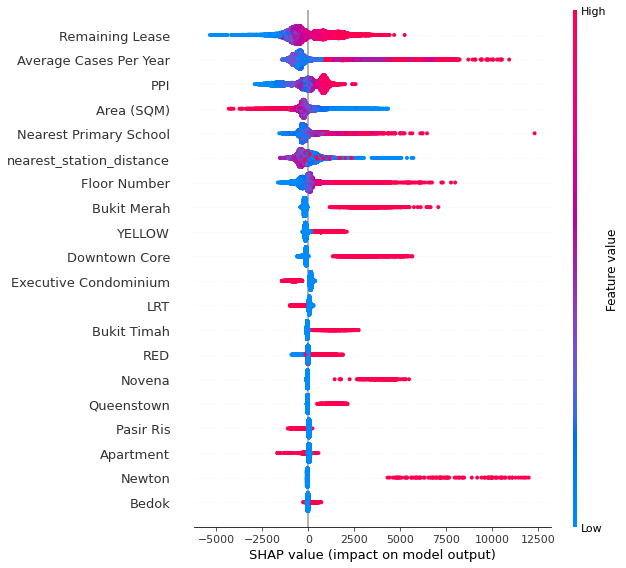

In [57]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

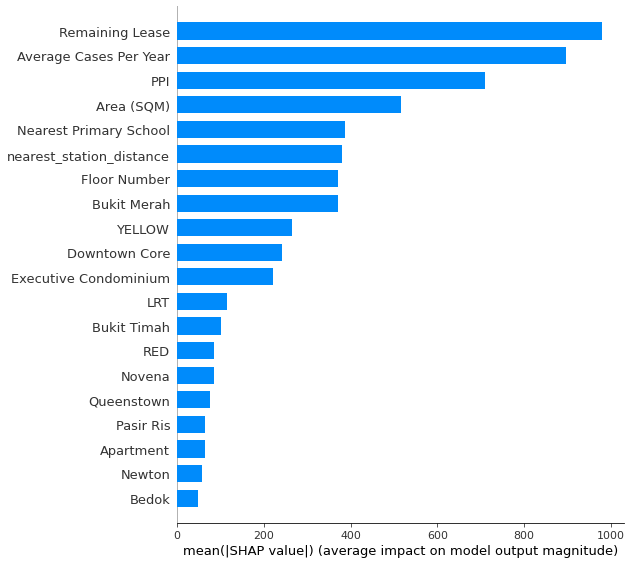

In [58]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')